In [ ]:
!pip install -q xlrd
!pip install openpyxl --upgrade
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd 
import numpy as np
from itertools import cycle, islice
#import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import re
import statsmodels.api as sm
import statsmodels.formula.api as smf

import scipy
import sklearn.linear_model as lm
pd.options.display.max_rows = 12
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from IPython.core.pylabtools import figsize
from pandas.api.types import CategoricalDtype
import psycopg2
from psycopg2 import OperationalError
import pandas.io.sql as sqlio
import scipy.stats as stats
import plotly
import plotly.graph_objects as go
from operator import itemgetter
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from plotly.subplots import make_subplots

#**РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ С САЙТА HH.RU**

---



## Загрузка найденных вакансий, очистка от дубликатов

In [ ]:
dataset = pd.read_excel('все_вакансии_1.xlsx', index_col=0)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78928 entries, 0 to 417
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        78928 non-null  int64  
 1   premium                   78928 non-null  bool   
 2   name                      78928 non-null  object 
 3   department                6953 non-null   object 
 4   has_test                  78928 non-null  bool   
 5   response_letter_required  78928 non-null  bool   
 6   area                      78928 non-null  object 
 7   salary                    37445 non-null  object 
 8   type                      78928 non-null  object 
 9   address                   43763 non-null  object 
 10  response_url              7 non-null      object 
 11  sort_point_distance       0 non-null      float64
 12  published_at              78928 non-null  object 
 13  created_at                78928 non-null  object 
 14  archived

In [ ]:
# удаляем повторяющиеся строки, проверяем по всем столбцам
dataset = dataset.drop_duplicates(['id','name',	'area',	'key_skills',	'region'])


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53853 entries, 0 to 417
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        53853 non-null  int64  
 1   premium                   53853 non-null  bool   
 2   name                      53853 non-null  object 
 3   department                4455 non-null   object 
 4   has_test                  53853 non-null  bool   
 5   response_letter_required  53853 non-null  bool   
 6   area                      53853 non-null  object 
 7   salary                    27693 non-null  object 
 8   type                      53853 non-null  object 
 9   address                   30544 non-null  object 
 10  response_url              6 non-null      object 
 11  sort_point_distance       0 non-null      float64
 12  published_at              53853 non-null  object 
 13  created_at                53853 non-null  object 
 14  archived

## Очистка зарплаты и запись двух доп.колонок **"зарплата от"** и **"зарплата до"** сохранили в ***dataset_3*** обработка валют по курсу EUR, USD

In [ ]:
dataset.isnull().sum()       # просматриваем пустые значения в столбцах

id                     0
premium                0
name                   0
department         49398
has_test               0
                   ...  
experience             0
key_skills             0
specializations        0
region                 0
Unnamed: 35        53852
Length: 35, dtype: int64

In [ ]:
dataset_2 = dataset['salary']

# на отдельной строке попробовали регулярку, оказывается датасет возврвщает не словарь со значениями, на что я потратил время.... а просто строка, их легче обрабатывать
import re
a = "{'from': 25000, 'to': 50000, 'currency': 'RUR', 'gross': True}"
nums = int(re.findall(r'\d+',a)[0])
nums

25000

пишем две функции для зарплаты от, и для зарплаты до,  и учитываем курс и в чём указана зарплата "RUR", 'EUR', 'USD'
будем их делить на два столбца, так как в одном нам их не удастся проанализировать и сопоставить

In [ ]:
def clear_salary_from(i):
    if i!=0:
      try:
        if "RUR" in i:
          if '''{'from': None''' in i:
            i = 0
          else:
            i = int(re.findall(r'\d+',i)[0])
            # if 0<i<1001:
            #   i=i*1000
          return int(i)
        elif "EUR" in i:
            if '''{'from': None''' in i:
              i = 0
            else:
              i = int(re.findall(r'\d+',i)[0])*60.16
            return int(i)
        elif "USD" in i:
            if '''{'from': None''' in i:
              i = 0
            else:
              i = int(re.findall(r'\d+',i)[0])*58.61
            return int(i)
      except:
        i=0
        return int(i) 
    else:
      i=0

# проверяем наши функции что получаем на выходе
res=[]
for i in dataset_2:
  i = clear_salary_from(i)
  res.append(i)


In [ ]:
def clear_salary_to(i):
    if i!=0:
      try:
        if "RUR" in i:
          if '''{'from': None''' in i:
            i = int(re.findall(r'\d+',i)[0])
            # if 0<i<1001:
            #   i=i*1000
          elif '''to': None''' in i:
            i=0
          else:
            i = int(re.findall(r'\d+',i)[1])
            if 0<i<1001:
              i=i*1000
          return int(i)
        elif "EUR" in i:
            if '''{'from': None''' in i:
              i = int(re.findall(r'\d+',i)[0])*60.16
            elif '''to': None''' in i:
             i=0
            else:
              i = int(re.findall(r'\d+',i)[1])*60.16
            return int(i)
        elif "USD" in i:
            if '''{'from': None''' in i:
              i = int(re.findall(r'\d+',i)[0])*58.61
            elif '''to': None''' in i:
              i=0
            else:
              i = int(re.findall(r'\d+',i)[1])*58.61
            return int(i)
      except:
        i=0
        return int(i) 
    else:
      i=0

# проверяем наши функции что получаем на выходе
res=[]
for i in dataset_2:
  i = clear_salary_to(i)
  res.append(i)

In [ ]:
#записываем результат в переменную
salary_from = dataset_2.apply(clear_salary_from)
salary_from.head()

0        0.0
1        0.0
2    80000.0
3        0.0
4        0.0
Name: salary, dtype: float64

In [ ]:
#записываем результат в переменную
salary_to = dataset_2.apply(clear_salary_to)
salary_to.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: salary, dtype: float64

In [ ]:
#добавляем наши новые столбцы в имеющийся датасет
dataset['зарплата от'] = salary_from
dataset['зарплата до'] = salary_to

In [ ]:
#для наглядности снова применяем метод fillna, чтобы пропали все NaN, и сохраняем результат в новый датасет_3
dataset_3 = dataset.fillna(0)
dataset_3.head()

id  premium                                          name department  \
0  44297659    False                                   3D-аниматор          0   
1  66955720    False                                   3D-аниматор          0   
2  67416852    False  3D-Аниматор/3D-Моделлер/Технический художник          0   
3  67290283    False                                   3D-Аниматор          0   
4  43455211    False      Senior 3D Animator (Старший 3D аниматор)          0   

   has_test  response_letter_required  \
0     False                     False   
1     False                     False   
2     False                     False   
3     False                     False   
4     False                     False   

                                                area  \
0  {'id': '1', 'name': 'Москва', 'url': 'https://...   
1  {'id': '1', 'name': 'Москва', 'url': 'https://...   
2  {'id': '1', 'name': 'Москва', 'url': 'https://...   
3  {'id': '1', 'name': 'Москва', 'url': 'https://...   
4  {'id': '1', 'name': 'Москва', 'url': 'https://...   

                                              salary  \
0                                                  0   
1                                                  0   
2  {'from': 80000, 'to': None, 'currency': 'RUR',...   
3                                                  0   
4                                                  0   

                                 type  \
0  {'id': 'open', 'name': 'Открытая'}   
1  {'id': 'open', 'name': 'Открытая'}   
2  {'id': 'open', 'name': 'Открытая'}   
3  {'id': 'open', 'name': 'Открытая'}   
4  {'id': 'open', 'name': 'Открытая'}   

                                             address  ... working_time_modes  \
0                                                  0  ...                 []   
1                                                  0  ...                 []   
2  {'city': 'Москва', 'street': 'Ленинский проспе...  ...                 []   
3                                                  0  ...                 []   
4  {'city': 'Москва', 'street': 'Тверская улица',...  ...                 []   

   accept_temporary                                        description  \
0             False  <p>Студия Кефир ищет 3D-аниматора на игровые п...   
1             False  <p>3D-аниматор (с возможностью удаленной работ...   
2             False  <p>Мы - компания, которая занимается разработк...   
3             False  <p>Обязанности:</p> <ul> <li> <p>Анимация перс...   
4             False  <p><strong>Social Quantum​ </strong>— один из ...   

                                          experience  \
0  {'id': 'between1And3', 'name': 'От 1 года до 3...   
1  {'id': 'between1And3', 'name': 'От 1 года до 3...   
2  {'id': 'between1And3', 'name': 'От 1 года до 3...   
3    {'id': 'between3And6', 'name': 'От 3 до 6 лет'}   
4    {'id': 'between3And6', 'name': 'От 3 до 6 лет'}   

                                          key_skills  \
0  [{'name': 'Autodesk Maya'}, {'name': 'Анимация...   
1  [{'name': 'Autodesk Maya'}, {'name': 'Анимация...   
2  [{'name': '3D Max'}, {'name': 'Unity'}, {'name...   
3  [{'name': 'Adobe Photoshop'}, {'name': 'Unity'...   
4  [{'name': 'Autodesk Maya'}, {'name': 'Adobe Ph...   

                                     specializations  region Unnamed: 35  \
0  [{'id': '1.475', 'name': 'Игровое ПО', 'profar...  Москва           0   
1  [{'id': '1.475', 'name': 'Игровое ПО', 'profar...  Москва           0   
2  [{'id': '1.475', 'name': 'Игровое ПО', 'profar...  Москва           0   
3  [{'id': '1.475', 'name': 'Игровое ПО', 'profar...  Москва           0   
4  [{'id': '1.475', 'name': 'Игровое ПО', 'profar...  Москва           0   

  зарплата от зарплата до  
0         0.0         0.0  
1         0.0         0.0  
2     80000.0         0.0  
3         0.0         0.0  
4         0.0         0.0  

[5 rows x 37 columns]

In [ ]:
# проверяем что получилось по основным данным
dataset_3[['name','зарплата от','зарплата до']].head(10)

name  зарплата от  зарплата до
0                                        3D-аниматор          0.0          0.0
1                                        3D-аниматор          0.0          0.0
2       3D-Аниматор/3D-Моделлер/Технический художник      80000.0          0.0
3                                        3D-Аниматор          0.0          0.0
4           Senior 3D Animator (Старший 3D аниматор)          0.0          0.0
5  Marketing 3D Animator (Маркетинговый 3D аниматор)          0.0          0.0
6                                        3D Аниматор          0.0          0.0
7                                        3D аниматор          0.0          0.0
8                             3D-аниматор (MY.GAMES)          0.0          0.0
9                                        3D аниматор          0.0          0.0

## Очистка area и запись нового столбца **"город"**

In [ ]:
# Пробуем на отдельной строке
a ='''{'id': '1', 'name': 'Москва', 'url': 'https://api.hh.ru/areas/1'}'''
a = str(a.split('''name': ''',)[1])
print(a)
a =str(a.split(''', 'url':''')[0])
print(a)

'Москва', 'url': 'https://api.hh.ru/areas/1'}
'Москва'


In [ ]:
def clear_area(i):
  i = str(i.split('''name': ''',)[1])
  i =str(i.split(''', 'url':''')[0])
  i= re.sub(r'[.,"\'?:!;]', '', i)
  return i

In [ ]:
# проверка в отдельном цикле по столбцу area
ress=[]
for i in dataset_3['area']:
  i = clear_area(i)
  ress.append(i)

In [ ]:
clear_areas = dataset_3['area'].apply(clear_area)
clear_areas.head()

0    Москва
1    Москва
2    Москва
3    Москва
4    Москва
Name: area, dtype: object

In [ ]:
dataset_3['город'] = clear_areas
dataset_3.head(5)

id  premium                                          name department  \
0  44297659    False                                   3D-аниматор          0   
1  66955720    False                                   3D-аниматор          0   
2  67416852    False  3D-Аниматор/3D-Моделлер/Технический художник          0   
3  67290283    False                                   3D-Аниматор          0   
4  43455211    False      Senior 3D Animator (Старший 3D аниматор)          0   

   has_test  response_letter_required  \
0     False                     False   
1     False                     False   
2     False                     False   
3     False                     False   
4     False                     False   

                                                area  \
0  {'id': '1', 'name': 'Москва', 'url': 'https://...   
1  {'id': '1', 'name': 'Москва', 'url': 'https://...   
2  {'id': '1', 'name': 'Москва', 'url': 'https://...   
3  {'id': '1', 'name': 'Москва', 'url': 'https://...   
4  {'id': '1', 'name': 'Москва', 'url': 'https://...   

                                              salary  \
0                                                  0   
1                                                  0   
2  {'from': 80000, 'to': None, 'currency': 'RUR',...   
3                                                  0   
4                                                  0   

                                 type  \
0  {'id': 'open', 'name': 'Открытая'}   
1  {'id': 'open', 'name': 'Открытая'}   
2  {'id': 'open', 'name': 'Открытая'}   
3  {'id': 'open', 'name': 'Открытая'}   
4  {'id': 'open', 'name': 'Открытая'}   

                                             address  ... accept_temporary  \
0                                                  0  ...            False   
1                                                  0  ...            False   
2  {'city': 'Москва', 'street': 'Ленинский проспе...  ...            False   
3                                                  0  ...            False   
4  {'city': 'Москва', 'street': 'Тверская улица',...  ...            False   

                                         description  \
0  <p>Студия Кефир ищет 3D-аниматора на игровые п...   
1  <p>3D-аниматор (с возможностью удаленной работ...   
2  <p>Мы - компания, которая занимается разработк...   
3  <p>Обязанности:</p> <ul> <li> <p>Анимация перс...   
4  <p><strong>Social Quantum​ </strong>— один из ...   

                                          experience  \
0  {'id': 'between1And3', 'name': 'От 1 года до 3...   
1  {'id': 'between1And3', 'name': 'От 1 года до 3...   
2  {'id': 'between1And3', 'name': 'От 1 года до 3...   
3    {'id': 'between3And6', 'name': 'От 3 до 6 лет'}   
4    {'id': 'between3And6', 'name': 'От 3 до 6 лет'}   

                                          key_skills  \
0  [{'name': 'Autodesk Maya'}, {'name': 'Анимация...   
1  [{'name': 'Autodesk Maya'}, {'name': 'Анимация...   
2  [{'name': '3D Max'}, {'name': 'Unity'}, {'name...   
3  [{'name': 'Adobe Photoshop'}, {'name': 'Unity'...   
4  [{'name': 'Autodesk Maya'}, {'name': 'Adobe Ph...   

                                     specializations  region Unnamed: 35  \
0  [{'id': '1.475', 'name': 'Игровое ПО', 'profar...  Москва           0   
1  [{'id': '1.475', 'name': 'Игровое ПО', 'profar...  Москва           0   
2  [{'id': '1.475', 'name': 'Игровое ПО', 'profar...  Москва           0   
3  [{'id': '1.475', 'name': 'Игровое ПО', 'profar...  Москва           0   
4  [{'id': '1.475', 'name': 'Игровое ПО', 'profar...  Москва           0   

  зарплата от зарплата до   город  
0         0.0         0.0  Москва  
1         0.0         0.0  Москва  
2     80000.0         0.0  Москва  
3         0.0         0.0  Москва  
4         0.0         0.0  Москва  

[5 rows x 38 columns]

## Очистка столбца **"type"** создание новой колонки **"тип вакансии"**



In [ ]:
a ='''{'id': 'open', 'name': 'Открытая'}'''
a = str(a.split('''name': ''',)[1])
print(a)
a= re.sub(r'[.,"\'?}:!;]', '', a)
print(a)


'Открытая'}
Открытая


In [ ]:
def clear_type(i):
  i = str(i.split('''name': ''',)[1])
  i= re.sub(r'[.,"\'?}:!;]', '', i)
  return i

In [ ]:
clear_type = dataset_3['type'].apply(clear_type)
clear_type.head()
clear_type.tail()

410    Открытая
412    Открытая
414    Открытая
416    Открытая
417    Открытая
Name: type, dtype: object

In [ ]:
dataset_3['тип вакансии'] = clear_type
dataset_3.head(5)

id  premium                                          name department  \
0  44297659    False                                   3D-аниматор          0   
1  66955720    False                                   3D-аниматор          0   
2  67416852    False  3D-Аниматор/3D-Моделлер/Технический художник          0   
3  67290283    False                                   3D-Аниматор          0   
4  43455211    False      Senior 3D Animator (Старший 3D аниматор)          0   

   has_test  response_letter_required  \
0     False                     False   
1     False                     False   
2     False                     False   
3     False                     False   
4     False                     False   

                                                area  \
0  {'id': '1', 'name': 'Москва', 'url': 'https://...   
1  {'id': '1', 'name': 'Москва', 'url': 'https://...   
2  {'id': '1', 'name': 'Москва', 'url': 'https://...   
3  {'id': '1', 'name': 'Москва', 'url': 'https://...   
4  {'id': '1', 'name': 'Москва', 'url': 'https://...   

                                              salary  \
0                                                  0   
1                                                  0   
2  {'from': 80000, 'to': None, 'currency': 'RUR',...   
3                                                  0   
4                                                  0   

                                 type  \
0  {'id': 'open', 'name': 'Открытая'}   
1  {'id': 'open', 'name': 'Открытая'}   
2  {'id': 'open', 'name': 'Открытая'}   
3  {'id': 'open', 'name': 'Открытая'}   
4  {'id': 'open', 'name': 'Открытая'}   

                                             address  ...  \
0                                                  0  ...   
1                                                  0  ...   
2  {'city': 'Москва', 'street': 'Ленинский проспе...  ...   
3                                                  0  ...   
4  {'city': 'Москва', 'street': 'Тверская улица',...  ...   

                                         description  \
0  <p>Студия Кефир ищет 3D-аниматора на игровые п...   
1  <p>3D-аниматор (с возможностью удаленной работ...   
2  <p>Мы - компания, которая занимается разработк...   
3  <p>Обязанности:</p> <ul> <li> <p>Анимация перс...   
4  <p><strong>Social Quantum​ </strong>— один из ...   

                                          experience  \
0  {'id': 'between1And3', 'name': 'От 1 года до 3...   
1  {'id': 'between1And3', 'name': 'От 1 года до 3...   
2  {'id': 'between1And3', 'name': 'От 1 года до 3...   
3    {'id': 'between3And6', 'name': 'От 3 до 6 лет'}   
4    {'id': 'between3And6', 'name': 'От 3 до 6 лет'}   

                                          key_skills  \
0  [{'name': 'Autodesk Maya'}, {'name': 'Анимация...   
1  [{'name': 'Autodesk Maya'}, {'name': 'Анимация...   
2  [{'name': '3D Max'}, {'name': 'Unity'}, {'name...   
3  [{'name': 'Adobe Photoshop'}, {'name': 'Unity'...   
4  [{'name': 'Autodesk Maya'}, {'name': 'Adobe Ph...   

                                     specializations  region Unnamed: 35  \
0  [{'id': '1.475', 'name': 'Игровое ПО', 'profar...  Москва           0   
1  [{'id': '1.475', 'name': 'Игровое ПО', 'profar...  Москва           0   
2  [{'id': '1.475', 'name': 'Игровое ПО', 'profar...  Москва           0   
3  [{'id': '1.475', 'name': 'Игровое ПО', 'profar...  Москва           0   
4  [{'id': '1.475', 'name': 'Игровое ПО', 'profar...  Москва           0   

  зарплата от зарплата до   город тип вакансии  
0         0.0         0.0  Москва     Открытая  
1         0.0         0.0  Москва     Открытая  
2     80000.0         0.0  Москва     Открытая  
3         0.0         0.0  Москва     Открытая  
4         0.0         0.0  Москва     Открытая  

[5 rows x 39 columns]

## Очистка даты и время публикации вакансии запись в колонки **"дата публикации"**, **"время публикации"**

In [ ]:
def clear_published(i):
  i = i.split("T")[0]
  return str(i)
def clear_time(i):
  i = i.split("T")[1].split('+')[0]
  return str(i)

In [ ]:
clear_published = dataset_3['published_at'].apply(clear_published)
clear_time = dataset_3['created_at'].apply(clear_time)
dataset_3['дата публикации'] = clear_published
dataset_3['дата публикации'] = pd.to_datetime(dataset_3['дата публикации']) # перезаписали колонку из формата object  в datetime
dataset_3['время публикации'] = clear_time
dataset_3.head(5)

id  premium                                          name department  \
0  44297659    False                                   3D-аниматор          0   
1  66955720    False                                   3D-аниматор          0   
2  67416852    False  3D-Аниматор/3D-Моделлер/Технический художник          0   
3  67290283    False                                   3D-Аниматор          0   
4  43455211    False      Senior 3D Animator (Старший 3D аниматор)          0   

   has_test  response_letter_required  \
0     False                     False   
1     False                     False   
2     False                     False   
3     False                     False   
4     False                     False   

                                                area  \
0  {'id': '1', 'name': 'Москва', 'url': 'https://...   
1  {'id': '1', 'name': 'Москва', 'url': 'https://...   
2  {'id': '1', 'name': 'Москва', 'url': 'https://...   
3  {'id': '1', 'name': 'Москва', 'url': 'https://...   
4  {'id': '1', 'name': 'Москва', 'url': 'https://...   

                                              salary  \
0                                                  0   
1                                                  0   
2  {'from': 80000, 'to': None, 'currency': 'RUR',...   
3                                                  0   
4                                                  0   

                                 type  \
0  {'id': 'open', 'name': 'Открытая'}   
1  {'id': 'open', 'name': 'Открытая'}   
2  {'id': 'open', 'name': 'Открытая'}   
3  {'id': 'open', 'name': 'Открытая'}   
4  {'id': 'open', 'name': 'Открытая'}   

                                             address  ...  \
0                                                  0  ...   
1                                                  0  ...   
2  {'city': 'Москва', 'street': 'Ленинский проспе...  ...   
3                                                  0  ...   
4  {'city': 'Москва', 'street': 'Тверская улица',...  ...   

                                          key_skills  \
0  [{'name': 'Autodesk Maya'}, {'name': 'Анимация...   
1  [{'name': 'Autodesk Maya'}, {'name': 'Анимация...   
2  [{'name': '3D Max'}, {'name': 'Unity'}, {'name...   
3  [{'name': 'Adobe Photoshop'}, {'name': 'Unity'...   
4  [{'name': 'Autodesk Maya'}, {'name': 'Adobe Ph...   

                                     specializations  region Unnamed: 35  \
0  [{'id': '1.475', 'name': 'Игровое ПО', 'profar...  Москва           0   
1  [{'id': '1.475', 'name': 'Игровое ПО', 'profar...  Москва           0   
2  [{'id': '1.475', 'name': 'Игровое ПО', 'profar...  Москва           0   
3  [{'id': '1.475', 'name': 'Игровое ПО', 'profar...  Москва           0   
4  [{'id': '1.475', 'name': 'Игровое ПО', 'profar...  Москва           0   

   зарплата от зарплата до   город тип вакансии дата публикации  \
0          0.0         0.0  Москва     Открытая      2022-06-29   
1          0.0         0.0  Москва     Открытая      2022-06-29   
2      80000.0         0.0  Москва     Открытая      2022-07-01   
3          0.0         0.0  Москва     Открытая      2022-06-28   
4          0.0         0.0  Москва     Открытая      2022-06-26   

  время публикации  
0         21:49:45  
1         18:18:01  
2         18:55:04  
3         13:30:21  
4         19:26:35  

[5 rows x 41 columns]

In [ ]:
pd.to_datetime(dataset_3['дата публикации']).head(5)

0   2022-06-29
1   2022-06-29
2   2022-07-01
3   2022-06-28
4   2022-06-26
Name: дата публикации, dtype: datetime64[ns]

## Очистка графика работы

In [ ]:
dataset['schedule'].head()

0    {'id': 'remote', 'name': 'Удаленная работа'}
1        {'id': 'fullDay', 'name': 'Полный день'}
2        {'id': 'fullDay', 'name': 'Полный день'}
3        {'id': 'fullDay', 'name': 'Полный день'}
4        {'id': 'fullDay', 'name': 'Полный день'}
Name: schedule, dtype: object

In [ ]:
def clear_schedule(i):
  i = str(i.split('''name': ''',)[1])
  i= re.sub(r'[.,"\'?}:!;]', '', i)
  return i

In [ ]:
clear_schedule = dataset_3['schedule'].apply(clear_schedule)
clear_schedule.head()

0    Удаленная работа
1         Полный день
2         Полный день
3         Полный день
4         Полный день
Name: schedule, dtype: object

In [ ]:
dataset_3['График работы'] = clear_schedule
dataset_3.head(5)

id  premium                                          name department  \
0  44297659    False                                   3D-аниматор          0   
1  66955720    False                                   3D-аниматор          0   
2  67416852    False  3D-Аниматор/3D-Моделлер/Технический художник          0   
3  67290283    False                                   3D-Аниматор          0   
4  43455211    False      Senior 3D Animator (Старший 3D аниматор)          0   

   has_test  response_letter_required  \
0     False                     False   
1     False                     False   
2     False                     False   
3     False                     False   
4     False                     False   

                                                area  \
0  {'id': '1', 'name': 'Москва', 'url': 'https://...   
1  {'id': '1', 'name': 'Москва', 'url': 'https://...   
2  {'id': '1', 'name': 'Москва', 'url': 'https://...   
3  {'id': '1', 'name': 'Москва', 'url': 'https://...   
4  {'id': '1', 'name': 'Москва', 'url': 'https://...   

                                              salary  \
0                                                  0   
1                                                  0   
2  {'from': 80000, 'to': None, 'currency': 'RUR',...   
3                                                  0   
4                                                  0   

                                 type  \
0  {'id': 'open', 'name': 'Открытая'}   
1  {'id': 'open', 'name': 'Открытая'}   
2  {'id': 'open', 'name': 'Открытая'}   
3  {'id': 'open', 'name': 'Открытая'}   
4  {'id': 'open', 'name': 'Открытая'}   

                                             address  ...  \
0                                                  0  ...   
1                                                  0  ...   
2  {'city': 'Москва', 'street': 'Ленинский проспе...  ...   
3                                                  0  ...   
4  {'city': 'Москва', 'street': 'Тверская улица',...  ...   

                                     specializations  region Unnamed: 35  \
0  [{'id': '1.475', 'name': 'Игровое ПО', 'profar...  Москва           0   
1  [{'id': '1.475', 'name': 'Игровое ПО', 'profar...  Москва           0   
2  [{'id': '1.475', 'name': 'Игровое ПО', 'profar...  Москва           0   
3  [{'id': '1.475', 'name': 'Игровое ПО', 'profar...  Москва           0   
4  [{'id': '1.475', 'name': 'Игровое ПО', 'profar...  Москва           0   

  зарплата от  зарплата до   город тип вакансии дата публикации  \
0         0.0          0.0  Москва     Открытая      2022-06-29   
1         0.0          0.0  Москва     Открытая      2022-06-29   
2     80000.0          0.0  Москва     Открытая      2022-07-01   
3         0.0          0.0  Москва     Открытая      2022-06-28   
4         0.0          0.0  Москва     Открытая      2022-06-26   

  время публикации     График работы  
0         21:49:45  Удаленная работа  
1         18:18:01       Полный день  
2         18:55:04       Полный день  
3         13:30:21       Полный день  
4         19:26:35       Полный день  

[5 rows x 42 columns]

## Очистка столбца **"employer"**  и запись в столбец **"Название работодателя"**

In [ ]:
clear_employer = dataset_3['employer'].apply(clear_area)
dataset_3['Название работодателя'] = clear_employer
dataset_3.head(5)

id  premium                                          name department  \
0  44297659    False                                   3D-аниматор          0   
1  66955720    False                                   3D-аниматор          0   
2  67416852    False  3D-Аниматор/3D-Моделлер/Технический художник          0   
3  67290283    False                                   3D-Аниматор          0   
4  43455211    False      Senior 3D Animator (Старший 3D аниматор)          0   

   has_test  response_letter_required  \
0     False                     False   
1     False                     False   
2     False                     False   
3     False                     False   
4     False                     False   

                                                area  \
0  {'id': '1', 'name': 'Москва', 'url': 'https://...   
1  {'id': '1', 'name': 'Москва', 'url': 'https://...   
2  {'id': '1', 'name': 'Москва', 'url': 'https://...   
3  {'id': '1', 'name': 'Москва', 'url': 'https://...   
4  {'id': '1', 'name': 'Москва', 'url': 'https://...   

                                              salary  \
0                                                  0   
1                                                  0   
2  {'from': 80000, 'to': None, 'currency': 'RUR',...   
3                                                  0   
4                                                  0   

                                 type  \
0  {'id': 'open', 'name': 'Открытая'}   
1  {'id': 'open', 'name': 'Открытая'}   
2  {'id': 'open', 'name': 'Открытая'}   
3  {'id': 'open', 'name': 'Открытая'}   
4  {'id': 'open', 'name': 'Открытая'}   

                                             address  ...  region  \
0                                                  0  ...  Москва   
1                                                  0  ...  Москва   
2  {'city': 'Москва', 'street': 'Ленинский проспе...  ...  Москва   
3                                                  0  ...  Москва   
4  {'city': 'Москва', 'street': 'Тверская улица',...  ...  Москва   

   Unnamed: 35 зарплата от зарплата до   город тип вакансии дата публикации  \
0            0         0.0         0.0  Москва     Открытая      2022-06-29   
1            0         0.0         0.0  Москва     Открытая      2022-06-29   
2            0     80000.0         0.0  Москва     Открытая      2022-07-01   
3            0         0.0         0.0  Москва     Открытая      2022-06-28   
4            0         0.0         0.0  Москва     Открытая      2022-06-26   

  время публикации     График работы Название работодателя  
0         21:49:45  Удаленная работа          Студия Кефир  
1         18:18:01       Полный день                Графит  
2         18:55:04       Полный день             Среда Нет  
3         13:30:21       Полный день           Айспик Лодж  
4         19:26:35       Полный день        Social Quantum  

[5 rows x 43 columns]

## Очистка requirement и responsibility запись в столбцы **"Требования"**  и **"Обязанности"**, но они не целые в датасете.

In [ ]:
s = '''{'requirement': 'Навыки скининга и создания рига. Знание особенностей анимации в Unity, в частности реалтаймовой ИК. Любовь к современным экшен-играм и...', 'responsibility': 'Владение Autodesk Maya - для работы в команде. Допускается использование других пакетов, но лишь при условии самостоятельного создания анимации на всех...'}'''
r = s.split('''{'requirement': ''')[1].split('''responsibility': ''')[0]
r = re.sub(r'["\'?}]', '', r)
d = s.split('''{'requirement': ''')[1].split('''responsibility': ''')[1]
d = re.sub(r'["\'?}]', '', d)
print(r)
print(d)

Навыки скининга и создания рига. Знание особенностей анимации в Unity, в частности реалтаймовой ИК. Любовь к современным экшен-играм и..., 
Владение Autodesk Maya - для работы в команде. Допускается использование других пакетов, но лишь при условии самостоятельного создания анимации на всех...


In [ ]:
def clear_requirement(i):
  i = i.split('''{'requirement': ''')[1].split('''responsibility': ''')[0]
  i = re.sub(r'["\'?}]', '', i)
  return i

def clear_responsibility(i):
  i = i.split('''{'requirement': ''')[1].split('''responsibility': ''')[1]
  i = re.sub(r'["\'?}]', '', i)
  return i

In [ ]:
clear_requirement = dataset_3['snippet'].apply(clear_requirement)
clear_responsibility = dataset_3['snippet'].apply(clear_responsibility)
dataset_3['Требования'] = clear_requirement
dataset_3['Обязанности'] = clear_responsibility


In [ ]:
dataset_3[['Требования','Обязанности']].head(5)

Требования  \
0  Навыки скининга и создания рига. Знание особен...   
1  Знаете принципы анимации и умеете применять их...   
2  Наличие портфолио проектов. Владение принципам...   
3  Опыт работы и профильное портфолио. Знание игр...   
4  Опыт работы от 3-х лет. Наличие портфолио. Отл...   

                                         Обязанности  
0  Владение Autodesk Maya - для работы в команде....  
1  Вам предстоит анимировать персонажей, животных...  
2  Создание анимаций для игровых персонажей. Диза...  
3  Анимация персонажей, игровых объектов, катсцен...  
4  Создание анимаций персонажей. Взаимодействие с...

## Очистка description	string	, содержит html запись в столбец **"Описание вакансии"**

In [ ]:
a = '<p>Студия Кефир ищет 3D-аниматора на игровые проекты.</p> <p><strong>Вы – наш человек, если у вас есть:</strong></p> <ul> <li>владение Autodesk Maya - для работы в команде. Допускается использование других пакетов, но лишь при условии самостоятельного создания анимации на всех этапах, начиная со скининга и рига модели</li> <li>умение придумывать анимации под стиль конкретного проекта (где-то потребуется реализм, где-то яркая стильная мультяшность и т.д.)</li> <li>навык передавать анимацией физические свойства (вес, упругость и т.д.), определенный характер (если это персонаж), динамику движения и т.д.</li> <li>умение создавать наборы анимаций с учетом переходов между ними в игре (например, анимация прыжка персонажа)</li> <li>профильное портфолио</li> </ul> <p><strong>Пригодится:</strong></p> <ul> <li>навыки скининга и создания рига</li> <li>знание особенностей анимации в Unity, в частности реалтаймовой ИК</li> <li>любовь к современным экшен-играм и внушительный игровой стаж</li> <li>желание оттачивать свои навыки и изучать новые инструменты и технологии</li> </ul> <p><strong>Кое-что о задачах:</strong></p> <ul> <li>анимация персонажей, игровых объектов и т.д.</li> <li>экспорт анимированных объектов в Unity</li> </ul> <p><strong>Помимо работы:</strong></p> <ul> <li>живые лекции от топовых спикеров нашего профиля</li> <li>воркшопы с лучшими специалистами индустрии</li> <li>поездки на IT-конференции мирового уровня</li> <li>крутые внутренние ивенты</li> <li>среда - день, посвящённый играм и саморазвитию</li> <li>корпоративы за границей (города и экватора)</li> <li>геймифицированная бонусная система</li> <li>собственная медицинская диагностическая клиника</li> </ul> <p><strong>Само собой:</strong></p> <ul> <li>курсы английского</li> <li>мощное железо</li> <li>персональное меню питания</li> <li>релокационный пакет</li> <li>оформление по ТК РФ</li> </ul> <p>Удаленная работа / релокация в город Волгоград (подбор и оплата комфортного жилья для иногородних сотрудников, помощь с переездом)</p>'
a = re.sub(r'\<[^>]*\>', '', a)
a

'Студия Кефир ищет 3D-аниматора на игровые проекты. Вы – наш человек, если у вас есть:  владение Autodesk Maya - для работы в команде. Допускается использование других пакетов, но лишь при условии самостоятельного создания анимации на всех этапах, начиная со скининга и рига модели умение придумывать анимации под стиль конкретного проекта (где-то потребуется реализм, где-то яркая стильная мультяшность и т.д.) навык передавать анимацией физические свойства (вес, упругость и т.д.), определенный характер (если это персонаж), динамику движения и т.д. умение создавать наборы анимаций с учетом переходов между ними в игре (например, анимация прыжка персонажа) профильное портфолио  Пригодится:  навыки скининга и создания рига знание особенностей анимации в Unity, в частности реалтаймовой ИК любовь к современным экшен-играм и внушительный игровой стаж желание оттачивать свои навыки и изучать новые инструменты и технологии  Кое-что о задачах:  анимация персонажей, игровых объектов и т.д. экспорт 

In [ ]:
def clear_description(i):
  try:
    i = re.sub(r'\<[^>]*\>', '', i)
    return i
  except:
    return i

In [ ]:
clear_description = dataset_3['description'].apply(clear_description)
dataset_3['Описание вакансии'] = clear_description

## Очистка experience и запись в столбец **"Опыт работы"**

In [ ]:
a = '''{'id': 'between1And3', 'name': 'От 1 года до 3 лет'}'''
a = str(a.split('''name': ''')[1])
a = re.sub(r'[.,"\'?}:!;]', '', a)
a

'От 1 года до 3 лет'

In [ ]:
def clear_experience(i):
  i = str(i.split('''name': ''')[1])
  i = re.sub(r'[.,"\'?}:!;]', '', i)
  return i

In [ ]:
clear_experience = dataset_3['experience'].apply(clear_experience)
dataset_3['Опыт работы'] = clear_experience

In [ ]:
dataset_3['Опыт работы'].head(5)

0    От 1 года до 3 лет
1    От 1 года до 3 лет
2    От 1 года до 3 лет
3         От 3 до 6 лет
4         От 3 до 6 лет
Name: Опыт работы, dtype: object

## Очистка key skills запись в колонку **"Ключевые навыки"**

In [ ]:
# пробуем на отдельном примере, с регулярными не получилось, сделано через ast 
import ast
a = '''[{'name': 'Autodesk Maya'}, {'name': 'Анимация'}, {'name': 'Unity'}]'''

# converting string into dictionary
dictionary = ast.literal_eval(a)
print(type(dictionary))
d = ''
for i in dictionary:
  d +=i['name']+', '
print(d)

<class 'list'>
Autodesk Maya, Анимация, Unity, 


In [ ]:
def clear_key_skills(i):
  dictionary = ast.literal_eval(i)
  d = ''
  for i in dictionary:
     d +=i['name']+', '
  return d

In [ ]:
clear_key_skills = dataset_3['key_skills'].apply(clear_key_skills)
dataset_3['Ключевые навыки'] = clear_key_skills

In [ ]:
dataset_3['Ключевые навыки'].head()

0                     Autodesk Maya, Анимация, Unity, 
1    Autodesk Maya, Анимация, Blender 3D, Unity, Un...
2                       3D Max, Unity, Autodesk Maya, 
3    Adobe Photoshop, Unity, 3ds Max, Blender 3D, M...
4    Autodesk Maya, Adobe Photoshop, Работа в коман...
Name: Ключевые навыки, dtype: object

In [ ]:
dataset_3.head(5)

id  premium                                          name department  \
0  44297659    False                                   3D-аниматор          0   
1  66955720    False                                   3D-аниматор          0   
2  67416852    False  3D-Аниматор/3D-Моделлер/Технический художник          0   
3  67290283    False                                   3D-Аниматор          0   
4  43455211    False      Senior 3D Animator (Старший 3D аниматор)          0   

   has_test  response_letter_required  \
0     False                     False   
1     False                     False   
2     False                     False   
3     False                     False   
4     False                     False   

                                                area  \
0  {'id': '1', 'name': 'Москва', 'url': 'https://...   
1  {'id': '1', 'name': 'Москва', 'url': 'https://...   
2  {'id': '1', 'name': 'Москва', 'url': 'https://...   
3  {'id': '1', 'name': 'Москва', 'url': 'https://...   
4  {'id': '1', 'name': 'Москва', 'url': 'https://...   

                                              salary  \
0                                                  0   
1                                                  0   
2  {'from': 80000, 'to': None, 'currency': 'RUR',...   
3                                                  0   
4                                                  0   

                                 type  \
0  {'id': 'open', 'name': 'Открытая'}   
1  {'id': 'open', 'name': 'Открытая'}   
2  {'id': 'open', 'name': 'Открытая'}   
3  {'id': 'open', 'name': 'Открытая'}   
4  {'id': 'open', 'name': 'Открытая'}   

                                             address  ... тип вакансии  \
0                                                  0  ...     Открытая   
1                                                  0  ...     Открытая   
2  {'city': 'Москва', 'street': 'Ленинский проспе...  ...     Открытая   
3                                                  0  ...     Открытая   
4  {'city': 'Москва', 'street': 'Тверская улица',...  ...     Открытая   

   дата публикации время публикации     График работы  Название работодателя  \
0       2022-06-29         21:49:45  Удаленная работа           Студия Кефир   
1       2022-06-29         18:18:01       Полный день                 Графит   
2       2022-07-01         18:55:04       Полный день              Среда Нет   
3       2022-06-28         13:30:21       Полный день            Айспик Лодж   
4       2022-06-26         19:26:35       Полный день         Social Quantum   

                                          Требования  \
0  Навыки скининга и создания рига. Знание особен...   
1  Знаете принципы анимации и умеете применять их...   
2  Наличие портфолио проектов. Владение принципам...   
3  Опыт работы и профильное портфолио. Знание игр...   
4  Опыт работы от 3-х лет. Наличие портфолио. Отл...   

                                         Обязанности  \
0  Владение Autodesk Maya - для работы в команде....   
1  Вам предстоит анимировать персонажей, животных...   
2  Создание анимаций для игровых персонажей. Диза...   
3  Анимация персонажей, игровых объектов, катсцен...   
4  Создание анимаций персонажей. Взаимодействие с...   

                                   Описание вакансии         Опыт работы  \
0  Студия Кефир ищет 3D-аниматора на игровые прое...  От 1 года до 3 лет   
1  3D-аниматор (с возможностью удаленной работы) ...  От 1 года до 3 лет   
2  Мы - компания, которая занимается разработкой,...  От 1 года до 3 лет   
3  Обязанности:   Анимация персонажей, игровых об...       От 3 до 6 лет   
4  Social Quantum​ — один из крупнейших разработч...       От 3 до 6 лет   

                                     Ключевые навыки  
0                   Autodesk Maya, Анимация, Unity,   
1  Autodesk Maya, Анимация, Blender 3D, Unity, Un...  
2                     3D Max, Unity, Autodesk Maya,   
3  Adobe Photoshop, Unity, 3ds Max, Blender 3D, M...  
4  Autodesk Maya, Adob

In [ ]:
import pickle
dataset_3.to_pickle('Dataset_3.pkl')

In [ ]:
#dataset_3.to_excel('Dataset_3exel.xlsx', index = False)

## Очистка id городов и названий городов

In [ ]:
def area_id(i):
  i=re.findall(r'\d', i)[0]
  return i

In [ ]:
dataset_3['area_id'] = dataset['area'].apply(area_id)

In [ ]:
dataset_3['area_id'].head()

0    1
1    1
2    1
3    1
4    1
Name: area_id, dtype: object

In [ ]:
def clear_gorod(i):
  i = str(i.split('''name': ''',)[1])
  i = (i.split('url')[0])
  i= re.sub(r'[.,"\'?}:!;]', '', i)
  return i
dataset_3['город'] = dataset['area'].apply(clear_gorod)

In [ ]:
print(dataset_3['город'].head(5))
dataset_3['город'].tail(5)

0    Москва 
1    Москва 
2    Москва 
3    Москва 
4    Москва 
Name: город, dtype: object


410    Москва 
412    Москва 
414    Москва 
416    Москва 
417    Москва 
Name: город, dtype: object

In [ ]:
dataset_3.to_excel('Все_вакансии_очищенные.xlsx')

##АНАЛИЗ ПОЛУЧЕННЫХ РЕЗУЛЬТАТОВ!
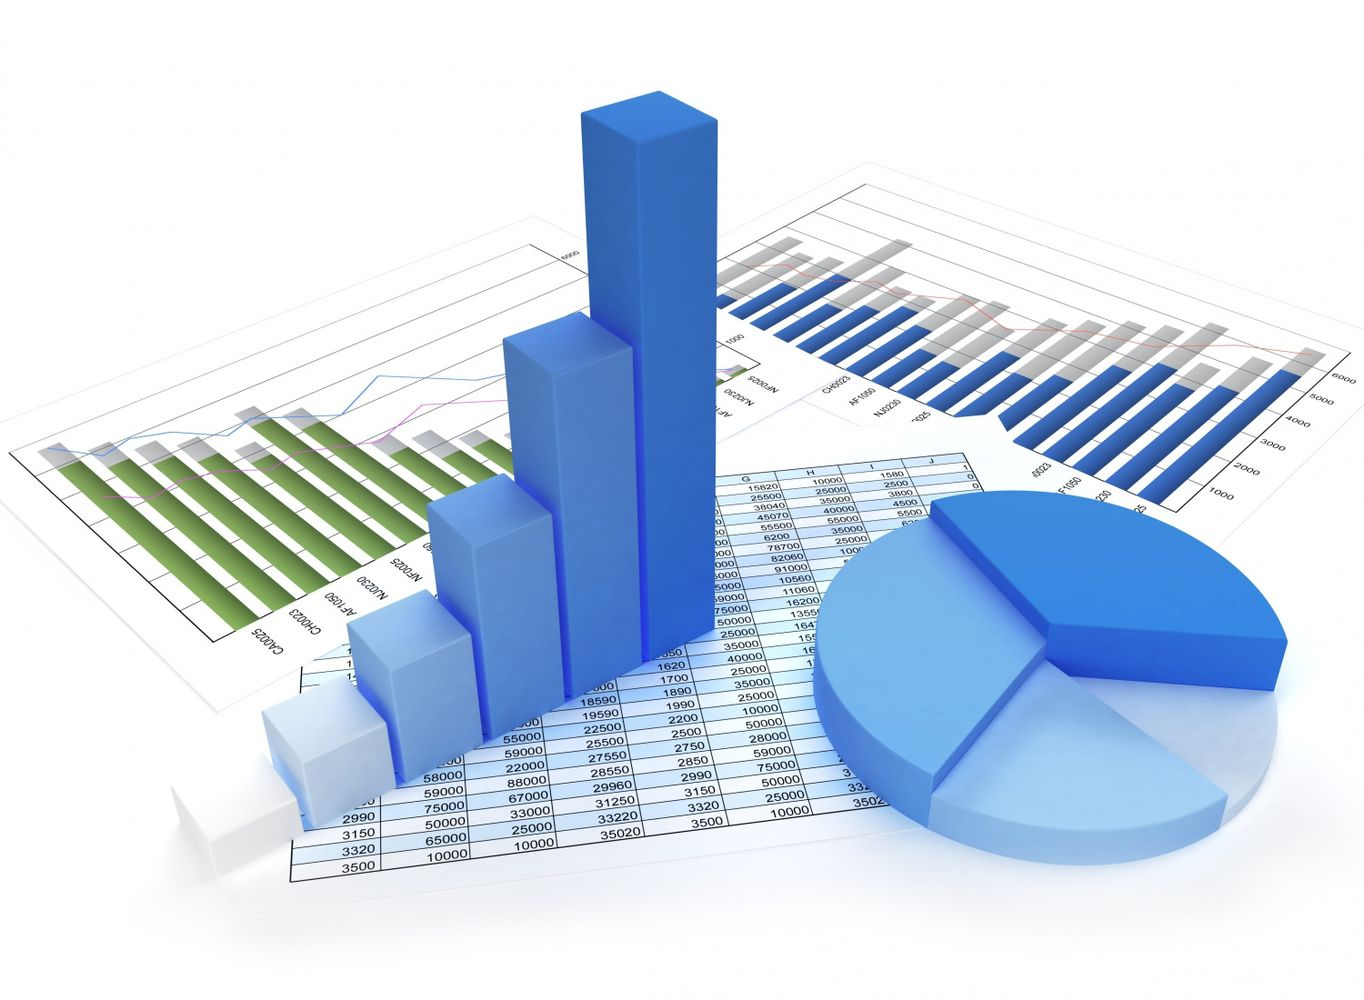

## Анализируем указанный **опыт работы** в вакансиях и рисуем диаграммы

In [ ]:
# просматриваем сколько значений по каждой категории['Нет опыта', 'От 1 года до 3 лет', 'От 3 до 6 лет', 'Более 6 лет']
op_rab = dataset_3['Опыт работы'].value_counts()[['Нет опыта', 'От 1 года до 3 лет', 'От 3 до 6 лет', 'Более 6 лет']]
op_rab

Нет опыта              7374
От 1 года до 3 лет    28139
От 3 до 6 лет         17038
Более 6 лет            1302
Name: Опыт работы, dtype: int64

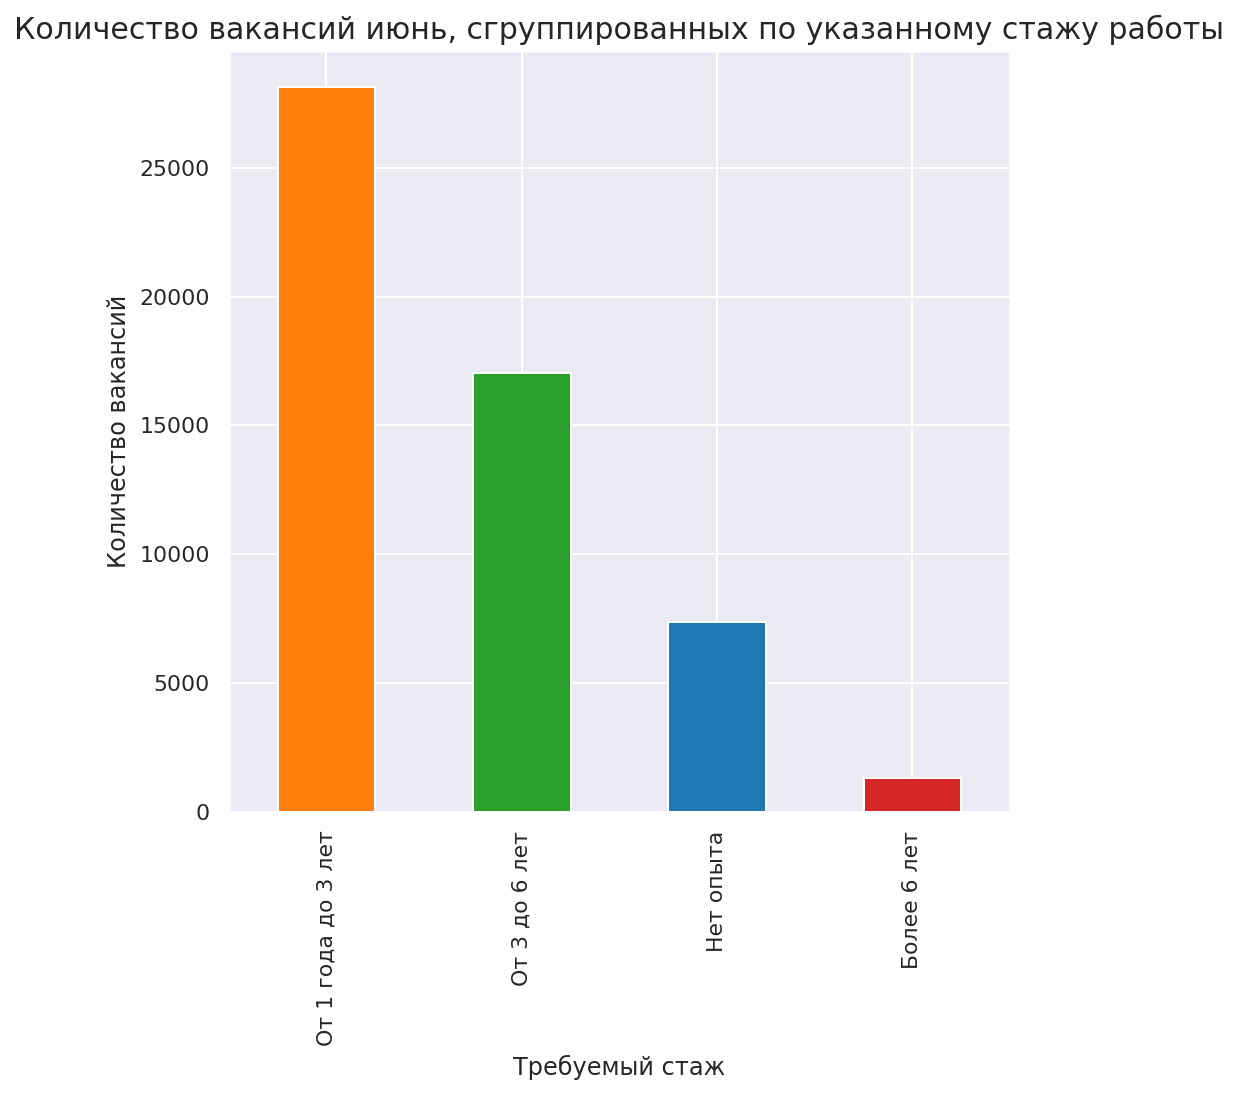

In [ ]:
#строим столбчатую диаграмму, чтобы посмотреть, какой стаж требуется в опубликованных вакансиях value_counts() упорядочивает значения, а при size()
#сортировка происходит по категории, т.е. по индексу
# color=['green','red', 'pink', 'orange', 'grey']
colors1 = ['tab:orange', 'tab:green', 'tab:blue', 'tab:red']
dataset_3['Опыт работы'].value_counts().plot(kind='bar', color = colors1, figsize = (7,7))
plt.title('Количество вакансий июнь, сгруппированных по указанному стажу работы',  fontsize = 15)
plt.xlabel('Требуемый стаж')
plt.ylabel('Количество вакансий')
plt.show()

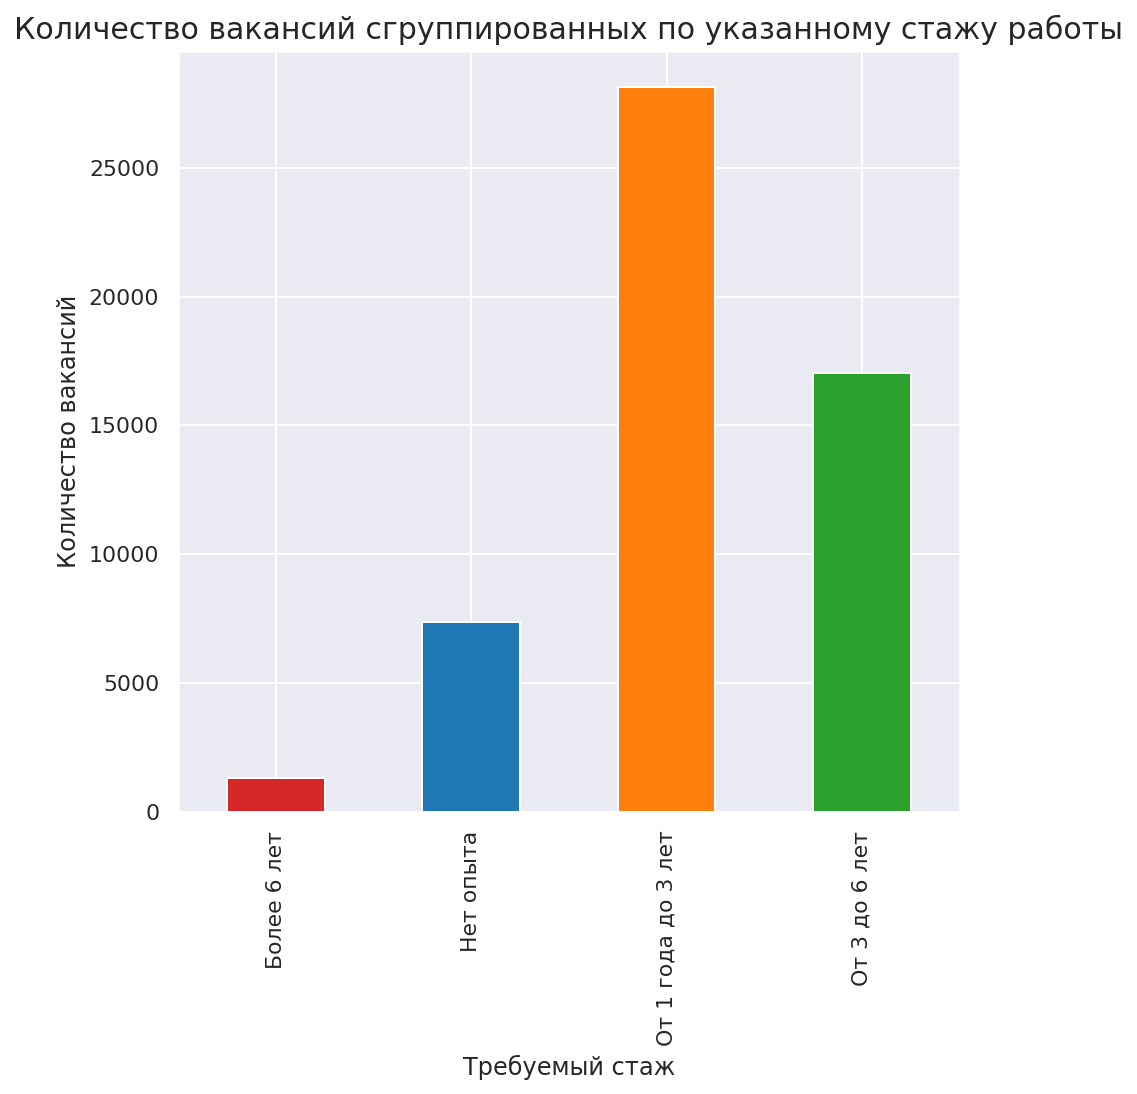

In [ ]:
colors2 = ['tab:red', 'tab:blue', 'tab:orange', 'tab:green']
dataset_3.groupby('Опыт работы').size().plot(kind='bar', color=colors2, figsize = (7,7))
plt.title('Количество вакансий сгруппированных по указанному стажу работы', fontsize = 15)
plt.xlabel('Требуемый стаж')
plt.ylabel('Количество вакансий')
plt.show()

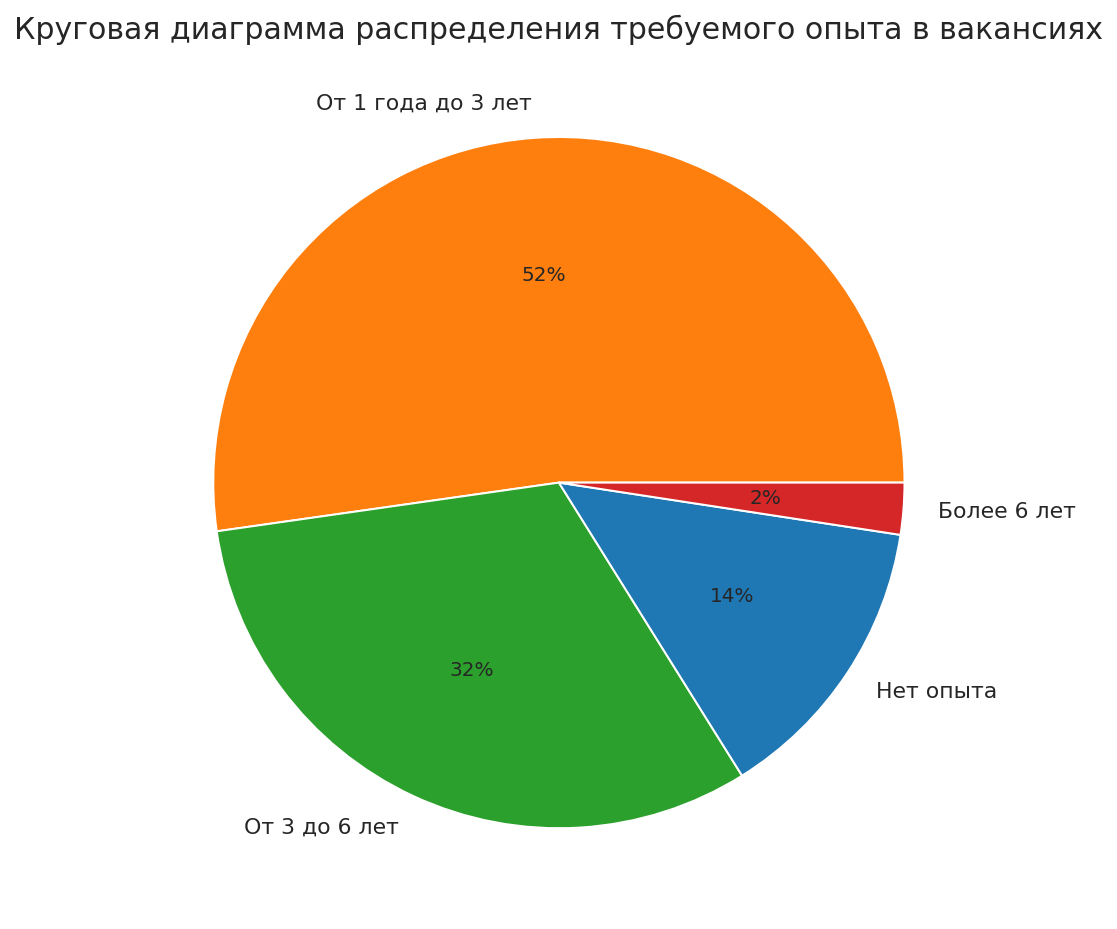

In [ ]:
# colors = ['tab:blue', 'tab:cyan', 'tab:gray', 'tab:orange']
colors = ['tab:orange', 'tab:green', 'tab:blue', 'tab:red']

plt.pie(dataset_3["Опыт работы"].value_counts().values, labels = dataset_3["Опыт работы"].value_counts().index, colors=colors, autopct='%1.0f%%')
plt.title('Круговая диаграмма распределения требуемого опыта в вакансиях', fontsize = 15)
plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=8.0)
plt.show()

In [ ]:
dataset_3.groupby('region')['Опыт работы'].value_counts(ascending=True).dropna().sort_values().unstack().dropna()

Опыт работы                 Более 6 лет  Нет опыта  От 1 года до 3 лет  \
region                                                                   
Алтайский край                      5.0      107.0               217.0   
Амурская область                    2.0       15.0                53.0   
Архангельская область               1.0       27.0                41.0   
Брянская область                    1.0       38.0                77.0   
Владимирская область                1.0       65.0               161.0   
...                                 ...        ...                 ...   
Ханты-Мансийский АО - Югра          2.0       36.0                81.0   
Челябинская область                11.0      133.0               433.0   
Чувашская Республика                1.0       97.0               147.0   
Ямало-Ненецкий АО                   2.0       16.0                25.0   
Ярославская область                 1.0       98.0               202.0   

Опыт работы                 От 3 до 6 лет  
region                                     
Алтайский край                       59.0  
Амурская область                     14.0  
Архангельская область                11.0  
Брянская область                     22.0  
Владимирская область                 43.0  
...                                   ...  
Ханты-Мансийский АО - Югра           29.0  
Челябинская область                 187.0  
Чувашская Республика                 42.0  
Ямало-Ненецкий АО                    12.0  
Ярославская область                  72.0  

[55 rows x 4 columns]

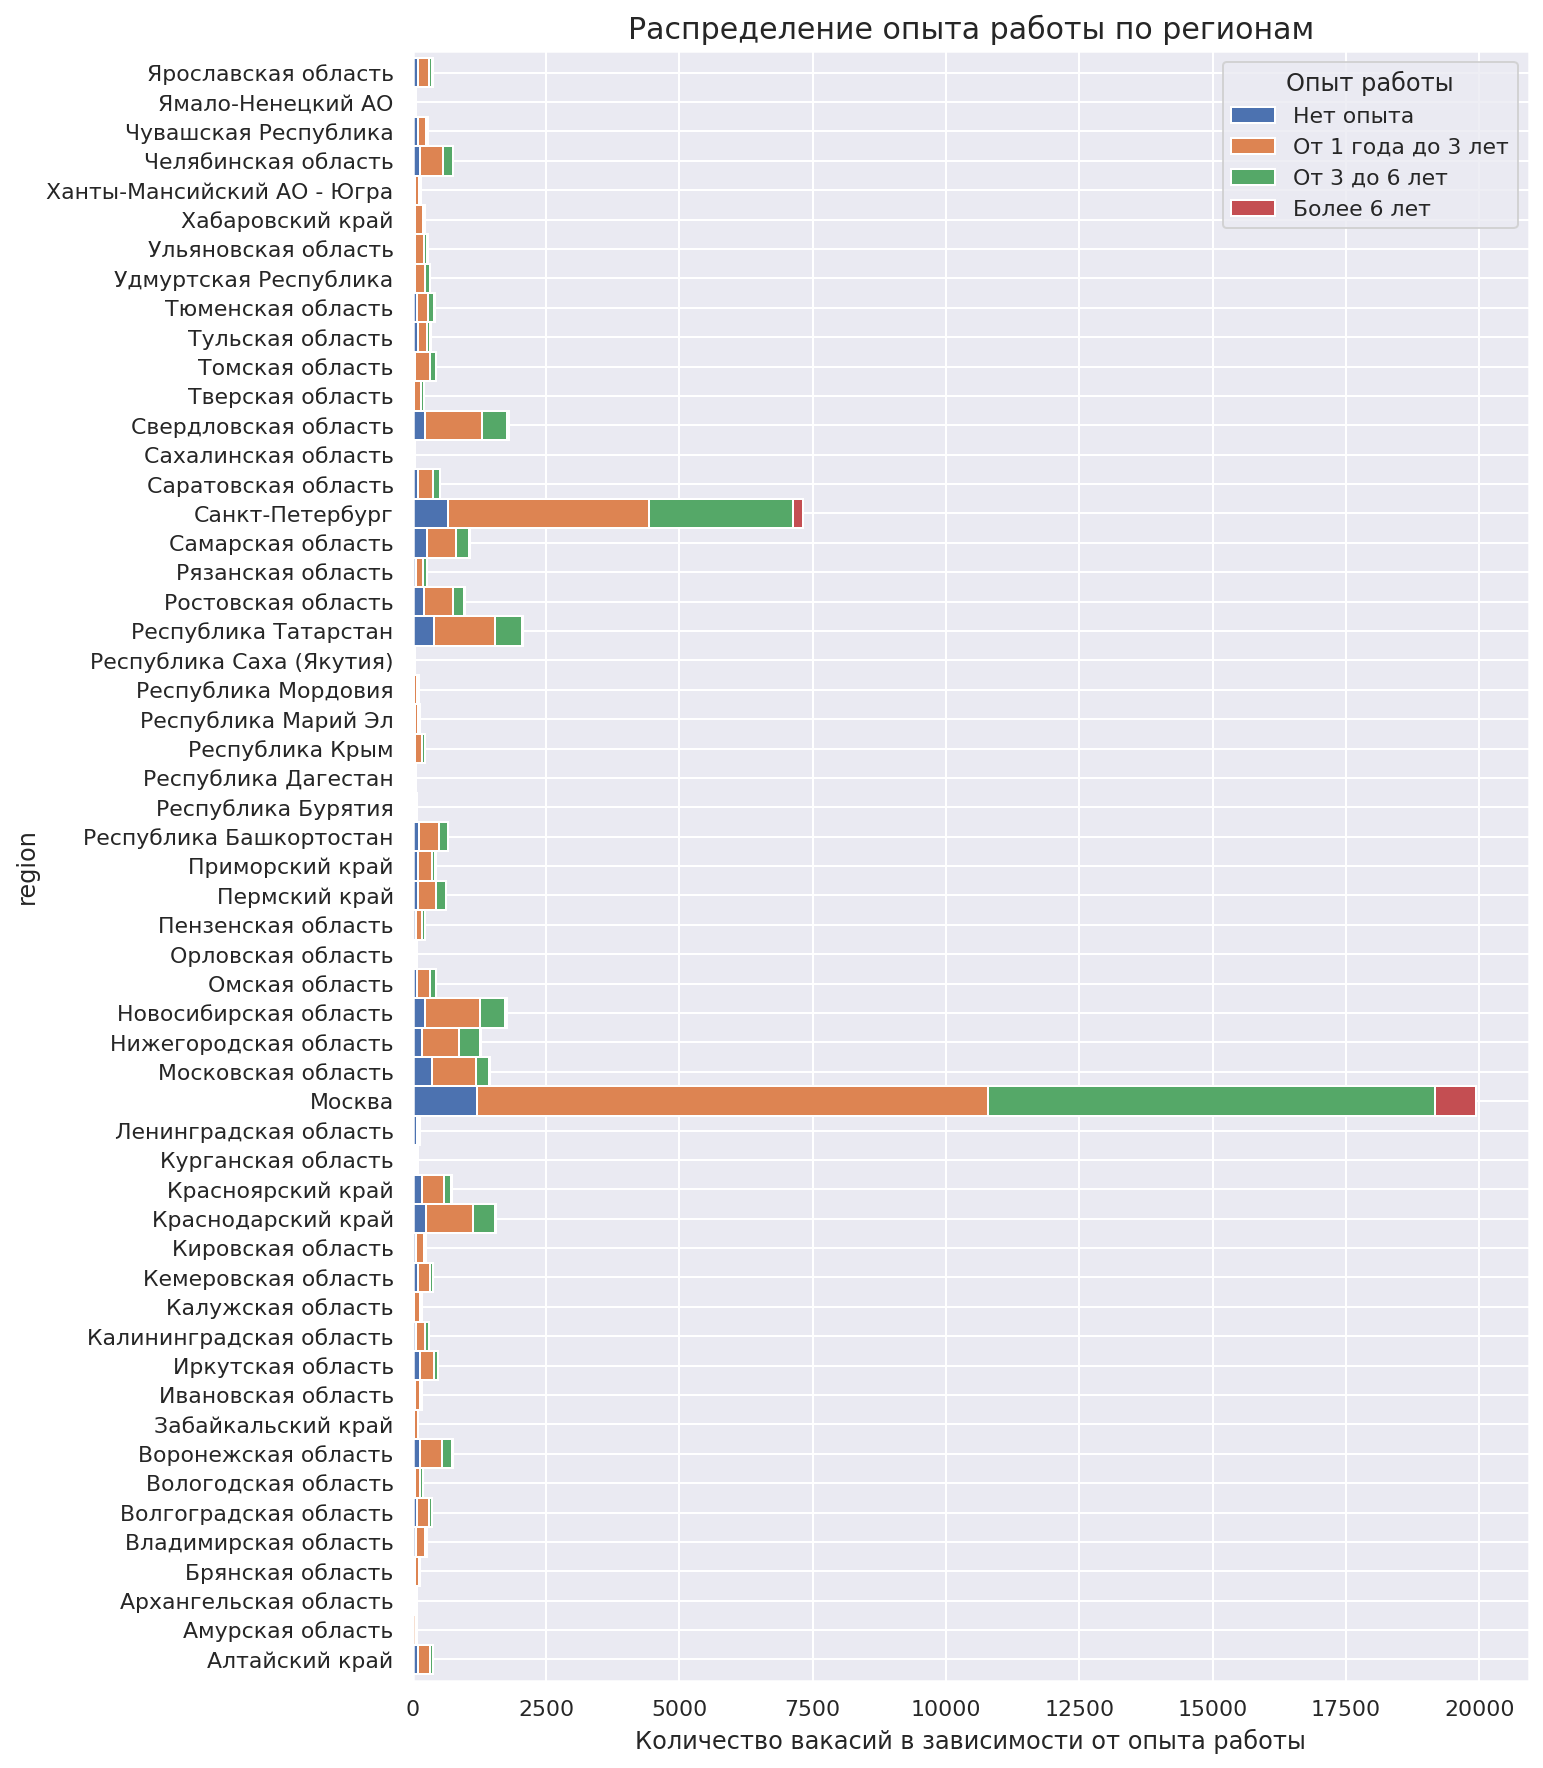

In [ ]:
dataset_3.groupby('region')['Опыт работы'].value_counts(ascending=True).dropna().sort_values().unstack().dropna().plot(kind='barh', stacked=True,y = (['Нет опыта', 'От 1 года до 3 лет', 'От 3 до 6 лет', 'Более 6 лет']), width=1, figsize =  (10, 15))
plt.title('Распределение опыта работы по регионам', fontsize = 15)
plt.xlabel('Количество вакасий в зависимости от опыта работы')
plt.show()


## Анализ вакансий по регионам (cколько вакансий в каждом регионе)

In [ ]:
region_vacancies = dataset_3['region'].value_counts(ascending=False).head(30)
region_vacancies

Москва                     19929
Санкт-Петербург             7325
Республика Татарстан        2070
Свердловская область        1808
Новосибирская область       1766
                           ...  
Тульская область             335
Удмуртская Республика        325
Калининградская область      315
Чувашская Республика         287
Ульяновская область          279
Name: region, Length: 30, dtype: int64

In [ ]:
# немного добавим цвета в нашу диаграмму
from matplotlib import cm
color = cm.inferno_r(np.linspace(.4,.8, 30))
color

array([[0.865006, 0.316822, 0.226055, 1.      ],
       [0.851384, 0.30226 , 0.239636, 1.      ],
       [0.832299, 0.283913, 0.257383, 1.      ],
       [0.817341, 0.270954, 0.27039 , 1.      ],
       [0.796607, 0.254728, 0.287264, 1.      ],
       [0.775059, 0.239667, 0.303526, 1.      ],
       [0.758422, 0.229097, 0.315266, 1.      ],
       [0.735683, 0.215906, 0.330245, 1.      ],
       [0.718264, 0.206636, 0.340931, 1.      ],
       [0.694627, 0.195021, 0.354388, 1.      ],
       [0.676638, 0.186807, 0.363849, 1.      ],
       [0.652369, 0.176421, 0.375586, 1.      ],
       [0.633998, 0.168992, 0.383704, 1.      ],
       [0.60933 , 0.159474, 0.393589, 1.      ],
       [0.590734, 0.152563, 0.40029 , 1.      ],
       [0.565854, 0.143567, 0.408258, 1.      ],
       [0.547157, 0.136929, 0.413511, 1.      ],
       [0.522206, 0.12815 , 0.419549, 1.      ],
       [0.503493, 0.121575, 0.423356, 1.      ],
       [0.478558, 0.112764, 0.427475, 1.      ],
       [0.453651, 0.

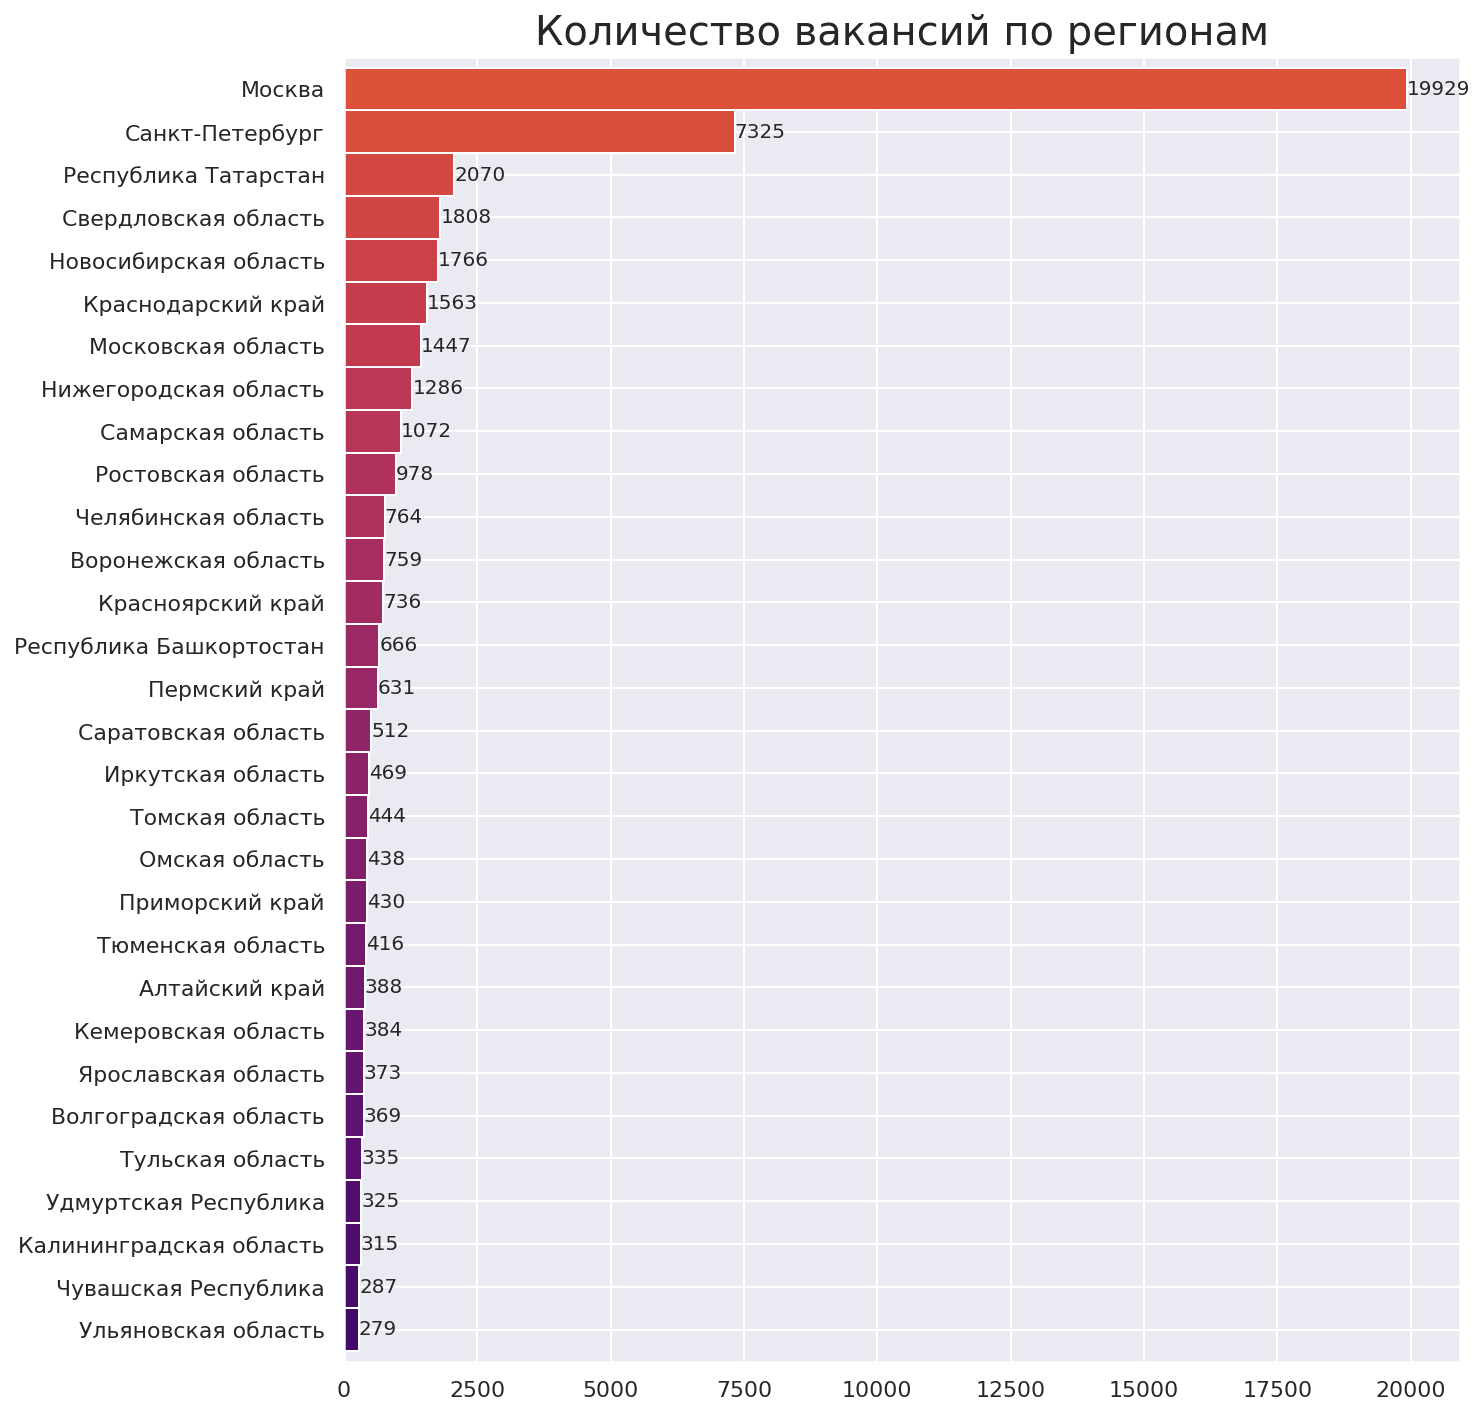

In [ ]:
region_vacancies.plot(kind='barh', figsize =  (10, 12), color=color, width=1).invert_yaxis()
for y,x in enumerate(region_vacancies):
    plt.text(x+0.1,y,'%s' %round(x,1),va='center') # Здесь x находится спереди, y сзади, метка значения добавляется к x, а центр также центрируется по вертикали
# Отображение графики    
plt.title('Количество вакансий по регионам',fontsize = 20)
plt.show()

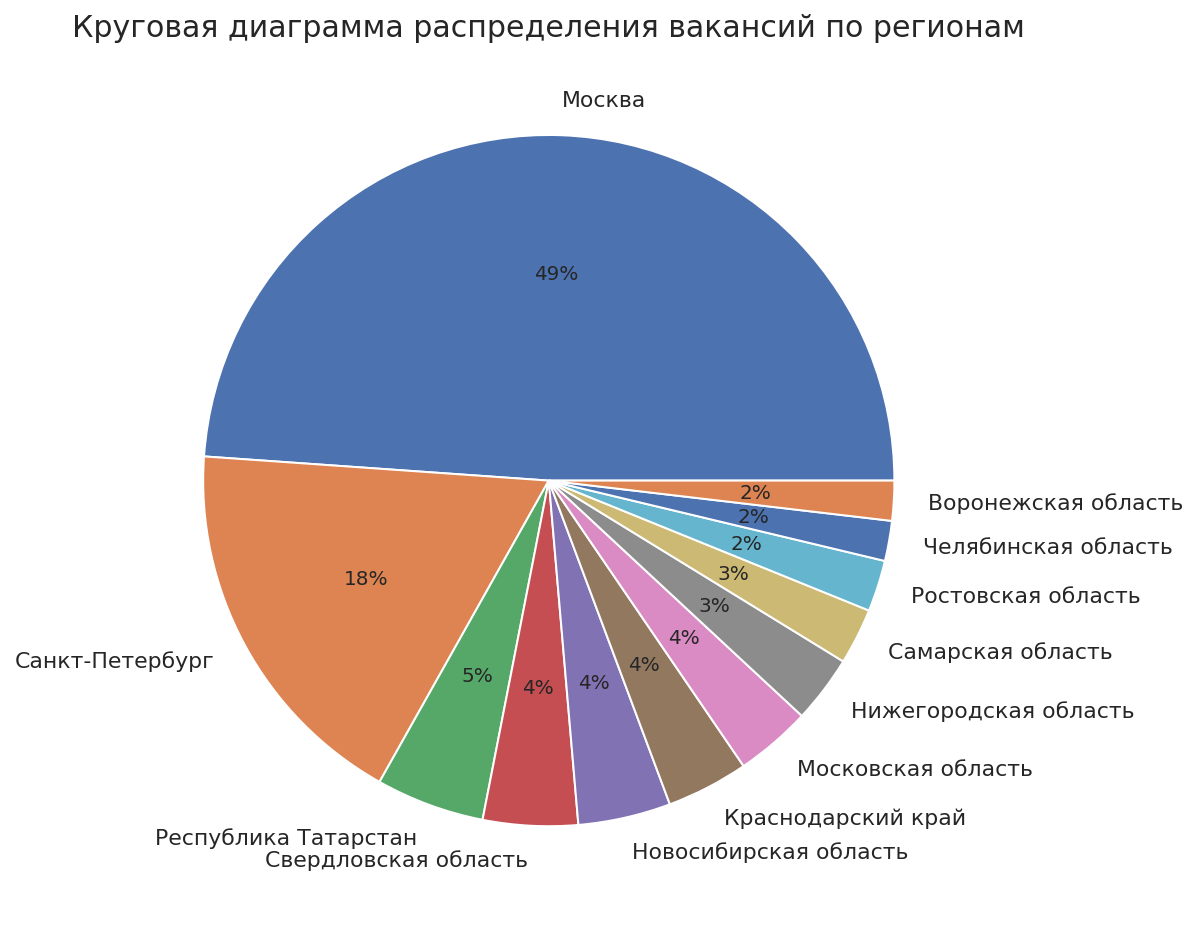

In [ ]:
region_vac = dataset_3['region'].value_counts().head(12)

plt.pie(region_vac.values, labels = region_vac.index, autopct='%1.0f%%')
plt.title('Круговая диаграмма распределения вакансий по регионам', fontsize = 15)
plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=10.0)
plt.show()

## Анализ вакансий, представленных на рынке

In [ ]:
#filtered = dataset[dataset['position'] == 'data scientist']
# dataset[dataset['name'].eq('Data scientist')].count()

'''посмотрим кем представлен рынок вакансий, выведем для наглядности 35 профессий'''
# name_vacancies = dataset_3['name'].str.lower().value_counts().head(35)
name_vacancies = dataset_3['name'].value_counts().head(35)
name_vacancies.head(10)

Программист 1С             1841
Системный администратор     877
Продавец-консультант        833
Системный аналитик          763
SMM-менеджер                421
Оператор 1С                 382
Инженер-электроник          350
Аналитик                    345
Контент-менеджер            317
Бизнес-аналитик             283
Name: name, dtype: int64

In [ ]:
color_2 = cm.inferno_r(np.linspace(0,1, 12))
color_2

array([[9.88362e-01, 9.98364e-01, 6.44924e-01, 1.00000e+00],
       [9.60626e-01, 8.59069e-01, 2.98010e-01, 1.00000e+00],
       [9.87714e-01, 6.82807e-01, 7.24890e-02, 1.00000e+00],
       [9.69163e-01, 5.15946e-01, 6.34880e-02, 1.00000e+00],
       [9.02003e-01, 3.64492e-01, 1.84116e-01, 1.00000e+00],
       [7.96607e-01, 2.54728e-01, 2.87264e-01, 1.00000e+00],
       [6.64540e-01, 1.81539e-01, 3.69846e-01, 1.00000e+00],
       [5.22206e-01, 1.28150e-01, 4.19549e-01, 1.00000e+00],
       [3.72768e-01, 7.39150e-02, 4.32400e-01, 1.00000e+00],
       [2.24763e-01, 3.64050e-02, 3.88129e-01, 1.00000e+00],
       [7.66370e-02, 4.19050e-02, 2.05799e-01, 1.00000e+00],
       [1.46200e-03, 4.66000e-04, 1.38660e-02, 1.00000e+00]])

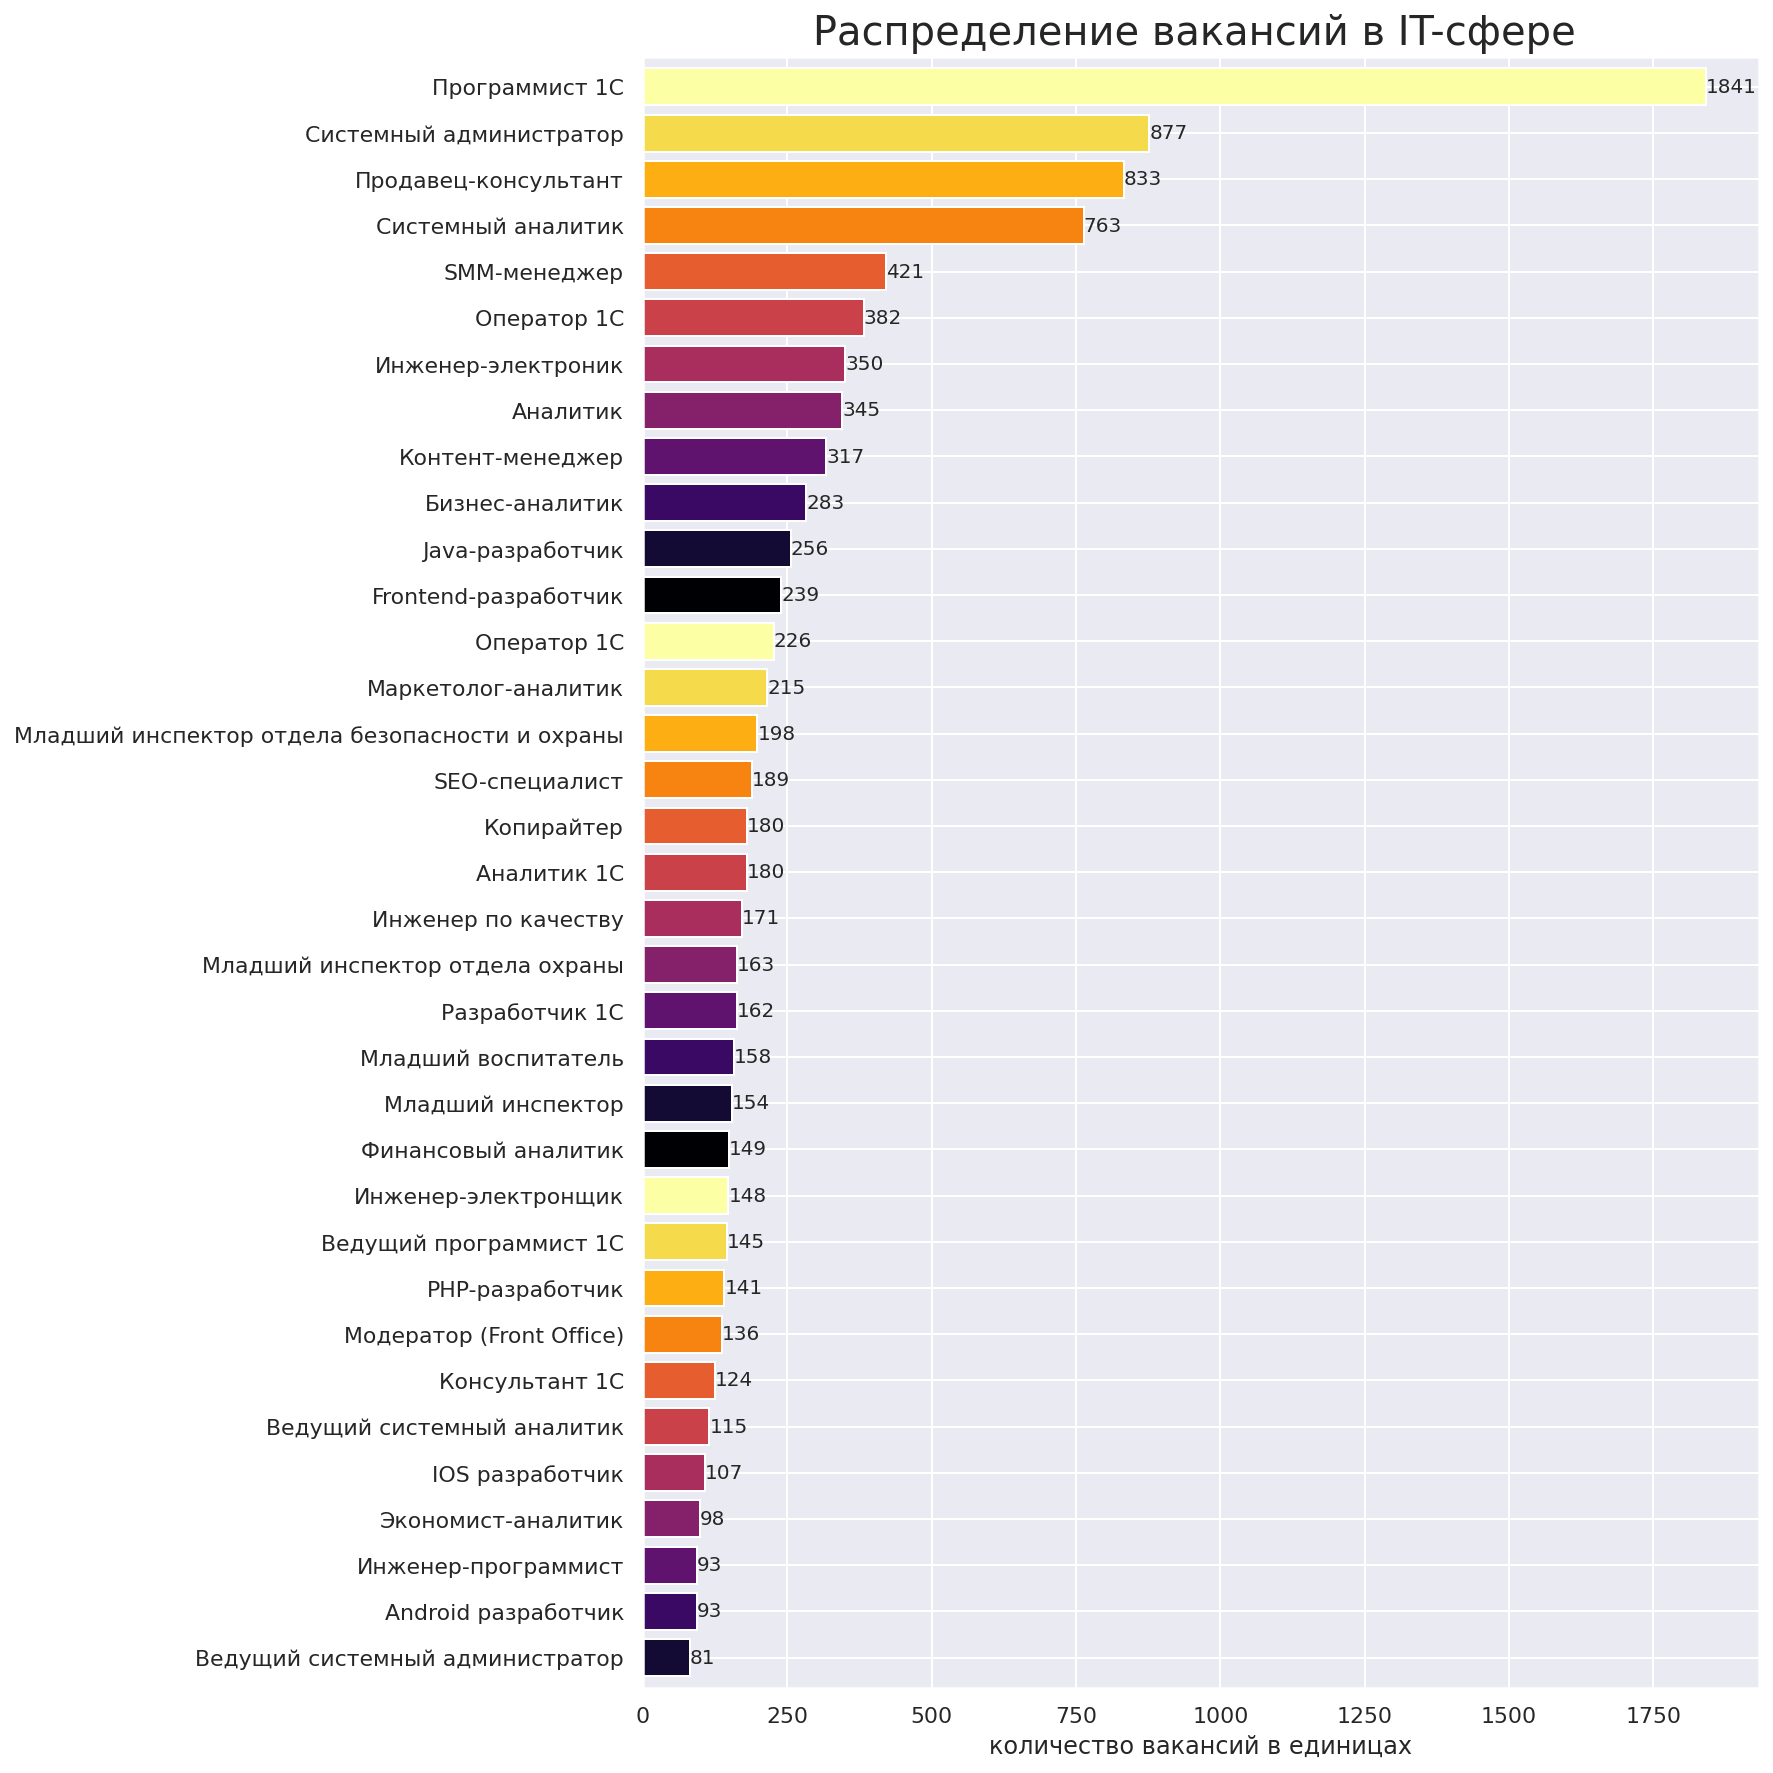

In [ ]:
name_vacancies.plot(kind='barh', figsize =  (10, 15), color=color_2, width=0.8).invert_yaxis()
for y,x in enumerate(name_vacancies):
    plt.text(x+0.1,y,'%s' %round(x,1),va='center') # Здесь x находится спереди, y сзади, метка значения добавляется к x, а центр также центрируется по вертикали
# Отображение графики   
plt.title('Распределение вакансий в IT-сфере ',fontsize = 20)
plt.xlabel('количество вакансий в единицах')
plt.show()

## Выбираем строки только с указанной зарплатой от и до, считаем среднюю, и записываем всё в новый датасет dataset_salary_2

In [ ]:
dataset_salary = dataset_3[(dataset_3['зарплата от'] !=0) & (dataset_3['зарплата до'] !=0)]   # выбрали строки, только те, в которых указана зарплата от и зарплата до

In [ ]:
# создаем столбец средняя зарплата
dataset_salary['средняя зарплата'] =(dataset_salary['зарплата от']+dataset_salary['зарплата до'])/2

In [ ]:
# перезаписываем датасет с нужными нам для анализа столбцами 
dataset_salary_2 = dataset_salary[['id', 'name', "зарплата от", "зарплата до",'средняя зарплата',"город", "region","тип вакансии",
                                   "дата публикации", "время публикации","Название работодателя", "График работы",
                                 "Требования", "Обязанности", "Описание вакансии", "Опыт работы", "Ключевые навыки",  ]]

In [ ]:
dataset_salary_2.head()

id                                               name  зарплата от  \
2  67281137  3D Motion Designer (видео дизайнер, 3D анимато...      50000.0   
3  67075607  C# developer junior / middle (.net, full-stack...     100000.0   
5  66553433        Back-end Developer (Ruby On Rails) удалённо     100000.0   
6  66865301                            Backend (С++) Developer      80000.0   
8  66141342                               Back - End Developer     180480.0   

   зарплата до  средняя зарплата             город           region  \
2     150000.0          100000.0  Санкт-Петербург   Санкт-Петербург   
3     220000.0          160000.0           Москва            Москва   
5     350000.0          225000.0           Москва            Москва   
6     160000.0          120000.0           Москва            Москва   
8     360960.0          270720.0           Москва            Москва   

  тип вакансии дата публикации время публикации Название работодателя  \
2     Открытая      2022-06-28         10:57:21                  БИАТ   
3     Открытая      2022-07-01         11:15:52               Mindbox   
5     Открытая      2022-06-29         13:12:43         ПотокДиджитал   
6     Открытая      2022-06-30         13:43:15            Оптимакрос   
8     Открытая      2022-06-28         13:20:25         Avanta Россия   

      График работы                                         Требования  \
2     Гибкий график  Высокий уровень владения Blender (важно). Необ...   
3       Полный день  SQL. Есть удаленная оплачиваемая стажировка на...   
5  Удаленная работа                                             None,    
6  Удаленная работа  В крупный международный проект Optimacros треб...   
8  Удаленная работа  We are open to consider any candidates with fl...   

                                         Обязанности  \
2  Создание анимационных 3D видеороликов. Анимаци...   
3                                               None   
5  Код храниться в Gitlab. В составе продуктовой ...   
6  Разработка новых функций многомерной базы данн...   
8  1. As a Software Engineer you’ll work on globa...   

                                   Описание вакансии         Опыт работы  \
2  Требуется 3D Motion Designer (видео дизайнер, ...       От 3 до 6 лет   
3  Ищем разработчика, который хочет быстро дораст...  От 1 года до 3 лет   
5  Привет!Мы ​команда разработки​ компании​ potok...       От 3 до 6 лет   
6  В крупный международный проект Optimacros треб...       От 3 до 6 лет   
8  Our client international IT company is looking...  От 1 года до 3 лет   

                                     Ключевые навыки  
2  Adobe Photoshop, Adobe Illustrator, Adobe Afte...  
3  .NET Framework, C#, MS SQL, LINQ, .NET Core, A...  
5      PostgreSQL, Ruby On Rails, Ruby, Redis, Git,   
6  Git, ООП, Английский язык, Design Patterns, C++,   
8  Fluent English, Clojure, ClojureScript, Python...

In [ ]:
dataset_salary_2.to_excel('Вакансии с зарплатой.xlsx')

In [ ]:
dataset_salary_2.to_pickle('Dataset_salary_2.pkl')

 ##  просматриваем месяца по которым опубликованы наши вакансии

In [ ]:
dataset_salary_2[dataset_salary_2['дата публикации'].dt.month ==6].head()  ##  просматриваем месяца по которым опубликованы наши вакансии это только июнь и до 2.07

id                                               name  зарплата от  \
2   67281137  3D Motion Designer (видео дизайнер, 3D анимато...      50000.0   
5   66553433        Back-end Developer (Ruby On Rails) удалённо     100000.0   
6   66865301                            Backend (С++) Developer      80000.0   
8   66141342                               Back - End Developer     180480.0   
19  67154791                    Remote Senior Backend Developer     351660.0   

    зарплата до  средняя зарплата             город           region  \
2      150000.0          100000.0  Санкт-Петербург   Санкт-Петербург   
5      350000.0          225000.0           Москва            Москва   
6      160000.0          120000.0           Москва            Москва   
8      360960.0          270720.0           Москва            Москва   
19     527490.0          439575.0           Москва            Москва   

   тип вакансии дата публикации время публикации Название работодателя  \
2      Открытая      2022-06-28         10:57:21                  БИАТ   
5      Открытая      2022-06-29         13:12:43         ПотокДиджитал   
6      Открытая      2022-06-30         13:43:15            Оптимакрос   
8      Открытая      2022-06-28         13:20:25         Avanta Россия   
19     Открытая      2022-06-24         11:34:49                Picnic   

       График работы                                         Требования  \
2      Гибкий график  Высокий уровень владения Blender (важно). Необ...   
5   Удаленная работа                                             None,    
6   Удаленная работа  В крупный международный проект Optimacros треб...   
8   Удаленная работа  We are open to consider any candidates with fl...   
19  Удаленная работа  Ideally 8+ years of experience with back-end e...   

                                          Обязанности  \
2   Создание анимационных 3D видеороликов. Анимаци...   
5   Код храниться в Gitlab. В составе продуктовой ...   
6   Разработка новых функций многомерной базы данн...   
8   1. As a Software Engineer you’ll work on globa...   
19                                               None   

                                    Описание вакансии         Опыт работы  \
2   Требуется 3D Motion Designer (видео дизайнер, ...       От 3 до 6 лет   
5   Привет!Мы ​команда разработки​ компании​ potok...       От 3 до 6 лет   
6   В крупный международный проект Optimacros треб...       От 3 до 6 лет   
8   Our client international IT company is looking...  От 1 года до 3 лет   
19  Responsibilities  We are a promising startup b...         Более 6 лет   

                                      Ключевые навыки  
2   Adobe Photoshop, Adobe Illustrator, Adobe Afte...  
5       PostgreSQL, Ruby On Rails, Ruby, Redis, Git,   
6   Git, ООП, Английский язык, Design Patterns, C++,   
8   Fluent English, Clojure, ClojureScript, Python...  
19  Atlassian Jira, Английский язык, Teamplayer, T...

## Анализ ключевых навыков

In [ ]:
res = dataset_3['Ключевые навыки']
c = Counter(''.join(res).split(','))
# сделаем сортировку и выведем первые 30 навыков
skills_vac = sorted(c.items(), key =  itemgetter(1), reverse = True)[:30]
skills_vac

[(' SQL', 7096),
 (' Git', 5538),
 (' Работа в команде', 5259),
 (' Грамотная речь', 4603),
 (' Английский язык', 3535),
 (' JavaScript', 3413),
 (' Linux', 3340),
 (' Python', 3313),
 (' 1С: Предприятие 8', 3308),
 (' 1С программирование', 3285),
 (' Пользователь ПК', 3148),
 (' PostgreSQL', 3035),
 (' Java', 2926),
 (' ООП', 2239),
 (' Аналитическое мышление', 2226),
 (' PHP', 2122),
 (' Работа с большим объемом информации', 2066),
 (' HTML', 1953),
 (' MySQL', 1946),
 (' Грамотность', 1919),
 (' Управление проектами', 1915),
 (' Активные продажи', 1855),
 (' MS PowerPoint', 1745),
 (' Adobe Photoshop', 1671),
 (' CSS', 1612),
 (' Навыки продаж', 1586),
 (' Atlassian Jira', 1537),
 (' 1С: Документооборот', 1531),
 (' MS SQL', 1509),
 (' 1С: Зарплата и управление персоналом', 1507)]

In [ ]:
# делаем словарь таблицей, чтобы в дальнейшем нарисовать схемы и графики
skills_vac_tab = pd.DataFrame(skills_vac, columns = ['Навык', 'количество'])
skills_vac_tab

Навык  количество
0                                     SQL        7096
1                                     Git        5538
2                        Работа в команде        5259
3                          Грамотная речь        4603
4                         Английский язык        3535
..                                    ...         ...
25                          Навыки продаж        1586
26                         Atlassian Jira        1537
27                    1С: Документооборот        1531
28                                 MS SQL        1509
29   1С: Зарплата и управление персоналом        1507

[30 rows x 2 columns]

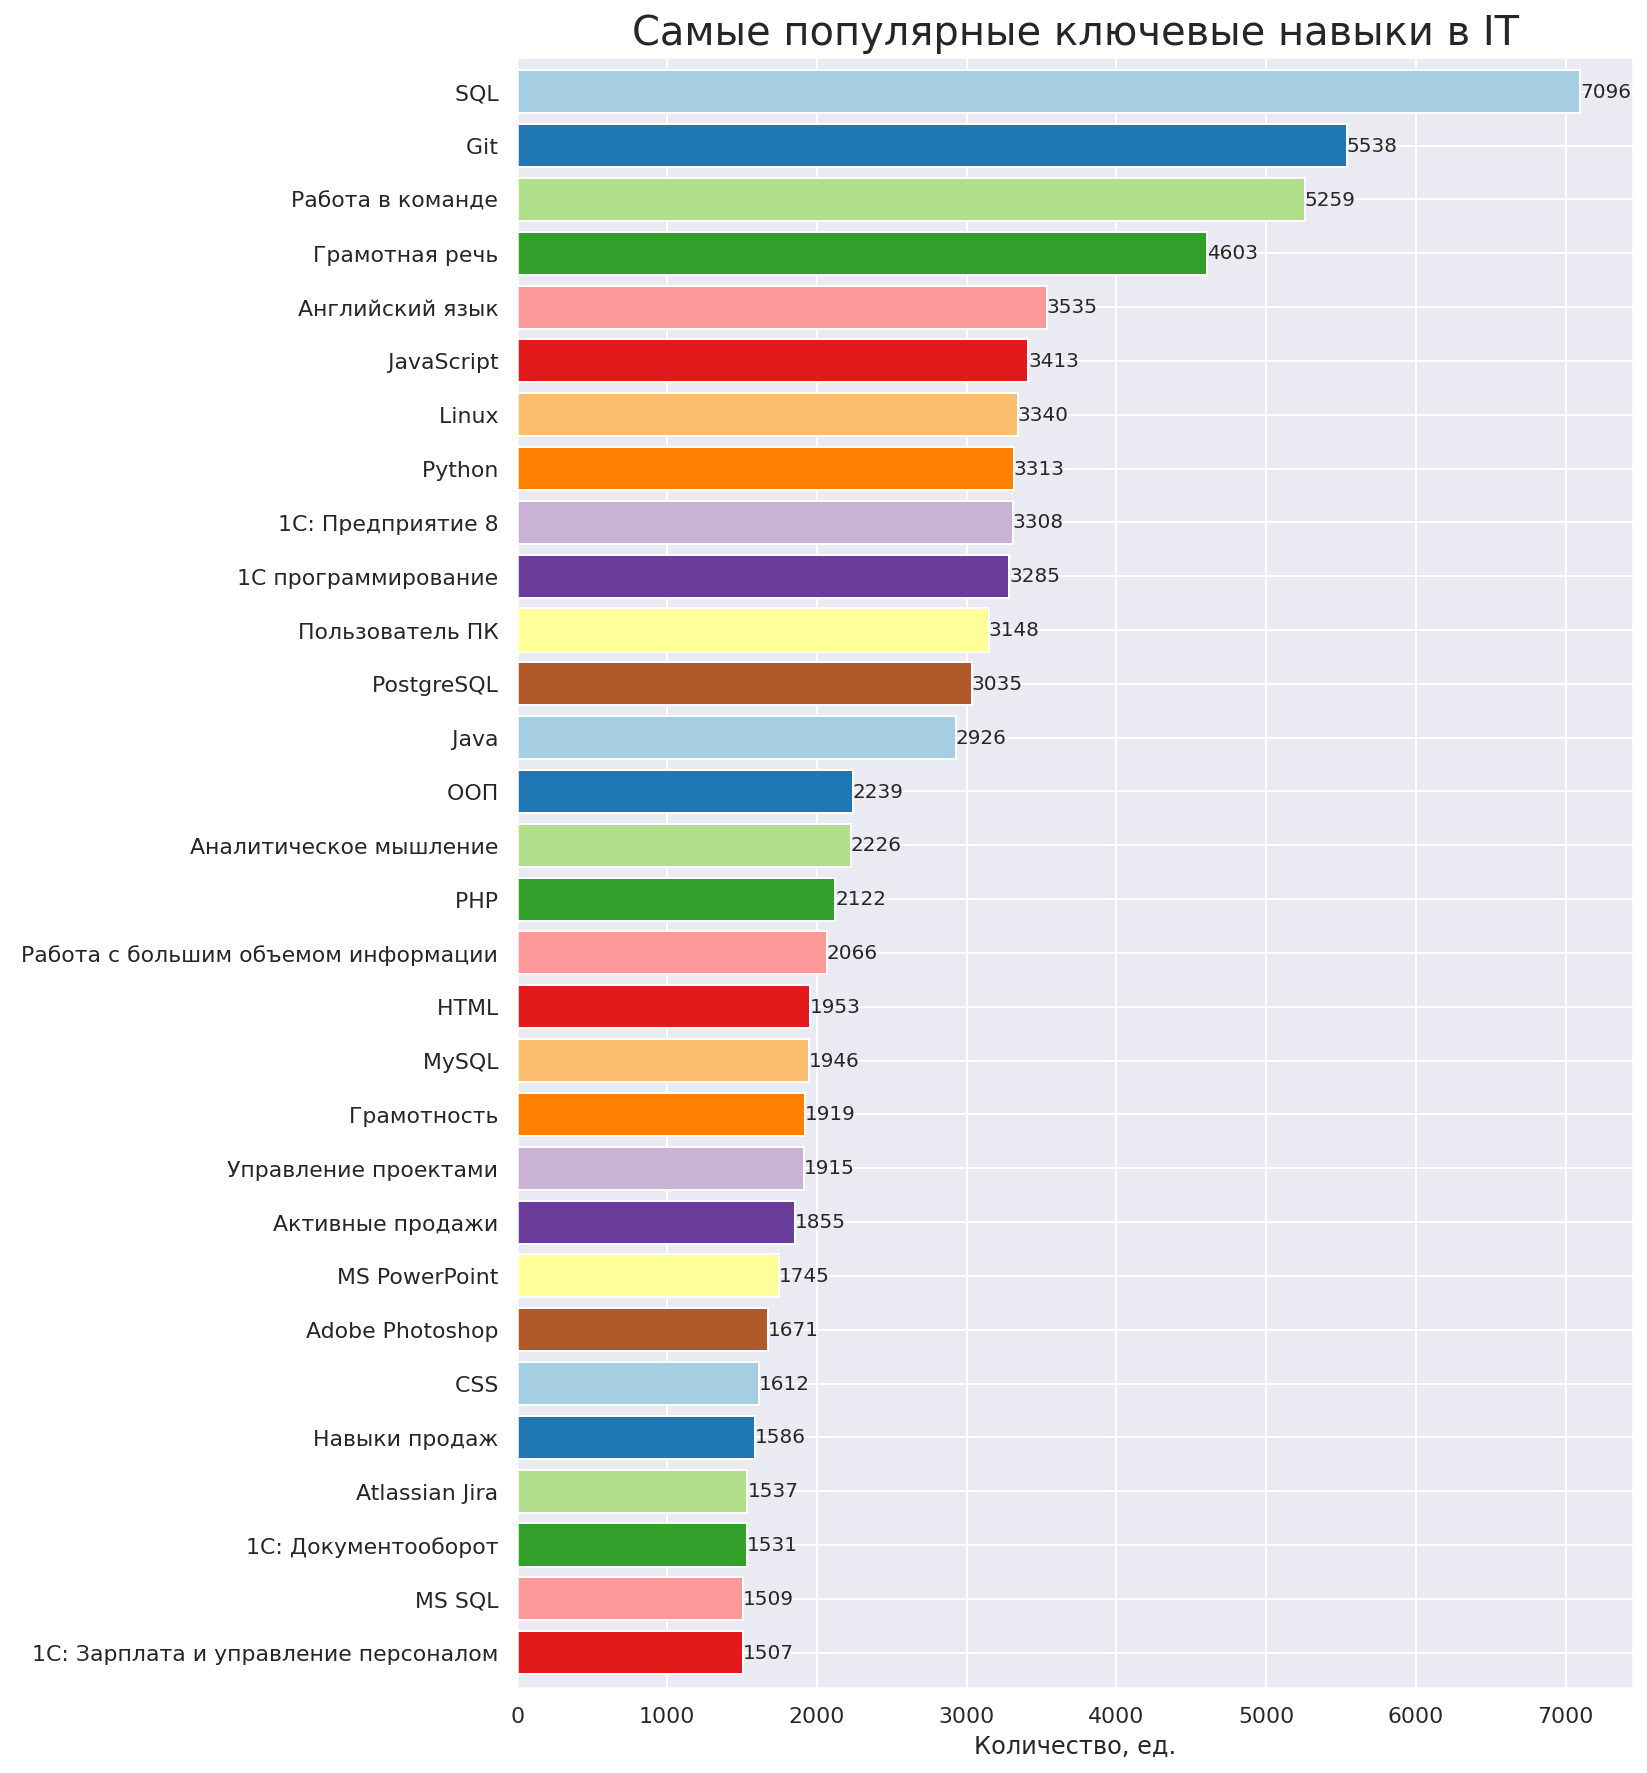

In [ ]:
from matplotlib.colors import get_named_colors_mapping
# color=(.1, .2,.3,.4)
# color=plt.cm.Paired(np.arange(len(skills_1C_pd)))
# ['b','g','r','c','m','y','g']

skills_vac_tab['количество'].plot(kind = 'barh', figsize =  (10, 15), color=plt.cm.Paired(np.arange(len(skills_vac_tab['количество'])))[:12],
                                width=0.8).invert_yaxis()
for y,x in enumerate(skills_vac_tab['количество']):
    plt.text(x+0.1,y,'%s' %round(x,1),va='center') # Здесь x находится спереди, y сзади, метка значения добавляется к x, а центр также центрируется по вертикали
# Отображение графики    
plt.title('Самые популярные ключевые навыки в IT',fontsize = 20)
plt.xlabel('Количество, ед.')

plt.yticks(range(30),[' SQL',' Git', ' Работа в команде', ' Грамотная речь', ' Английский язык', ' JavaScript', ' Linux', ' Python', ' 1С: Предприятие 8',
 ' 1С программирование', ' Пользователь ПК', ' PostgreSQL', ' Java', ' ООП', ' Аналитическое мышление', ' PHP', ' Работа с большим объемом информации',
 ' HTML', ' MySQL', ' Грамотность', ' Управление проектами', ' Активные продажи', ' MS PowerPoint', ' Adobe Photoshop', ' CSS', ' Навыки продаж',
 ' Atlassian Jira', ' 1С: Документооборот', ' MS SQL', ' 1С: Зарплата и управление персоналом'])
plt.show()

## Анализ средней зарплаты IT-вакансий по регионам

In [ ]:
#переводим регионы в категории, группируем зарплаты по регионам и выводим среднее значение, и удаляем пустые строки
# dataset_salary_2['region'] = dataset_3['region'].astype('category')
region_salary = dataset_salary_2.groupby('region')['средняя зарплата'].median().sort_values().dropna()
region_salary.head()

region
Курганская область                   30000.0
Республика Северная Осетия-Алания    32500.0
Республика Хакасия                   35000.0
Саратовская область                  35000.0
Республика Дагестан                  36250.0
Name: средняя зарплата, dtype: float64

In [ ]:
salary_bez_vybros = dataset_salary_2[dataset_salary_2['средняя зарплата']<360000]

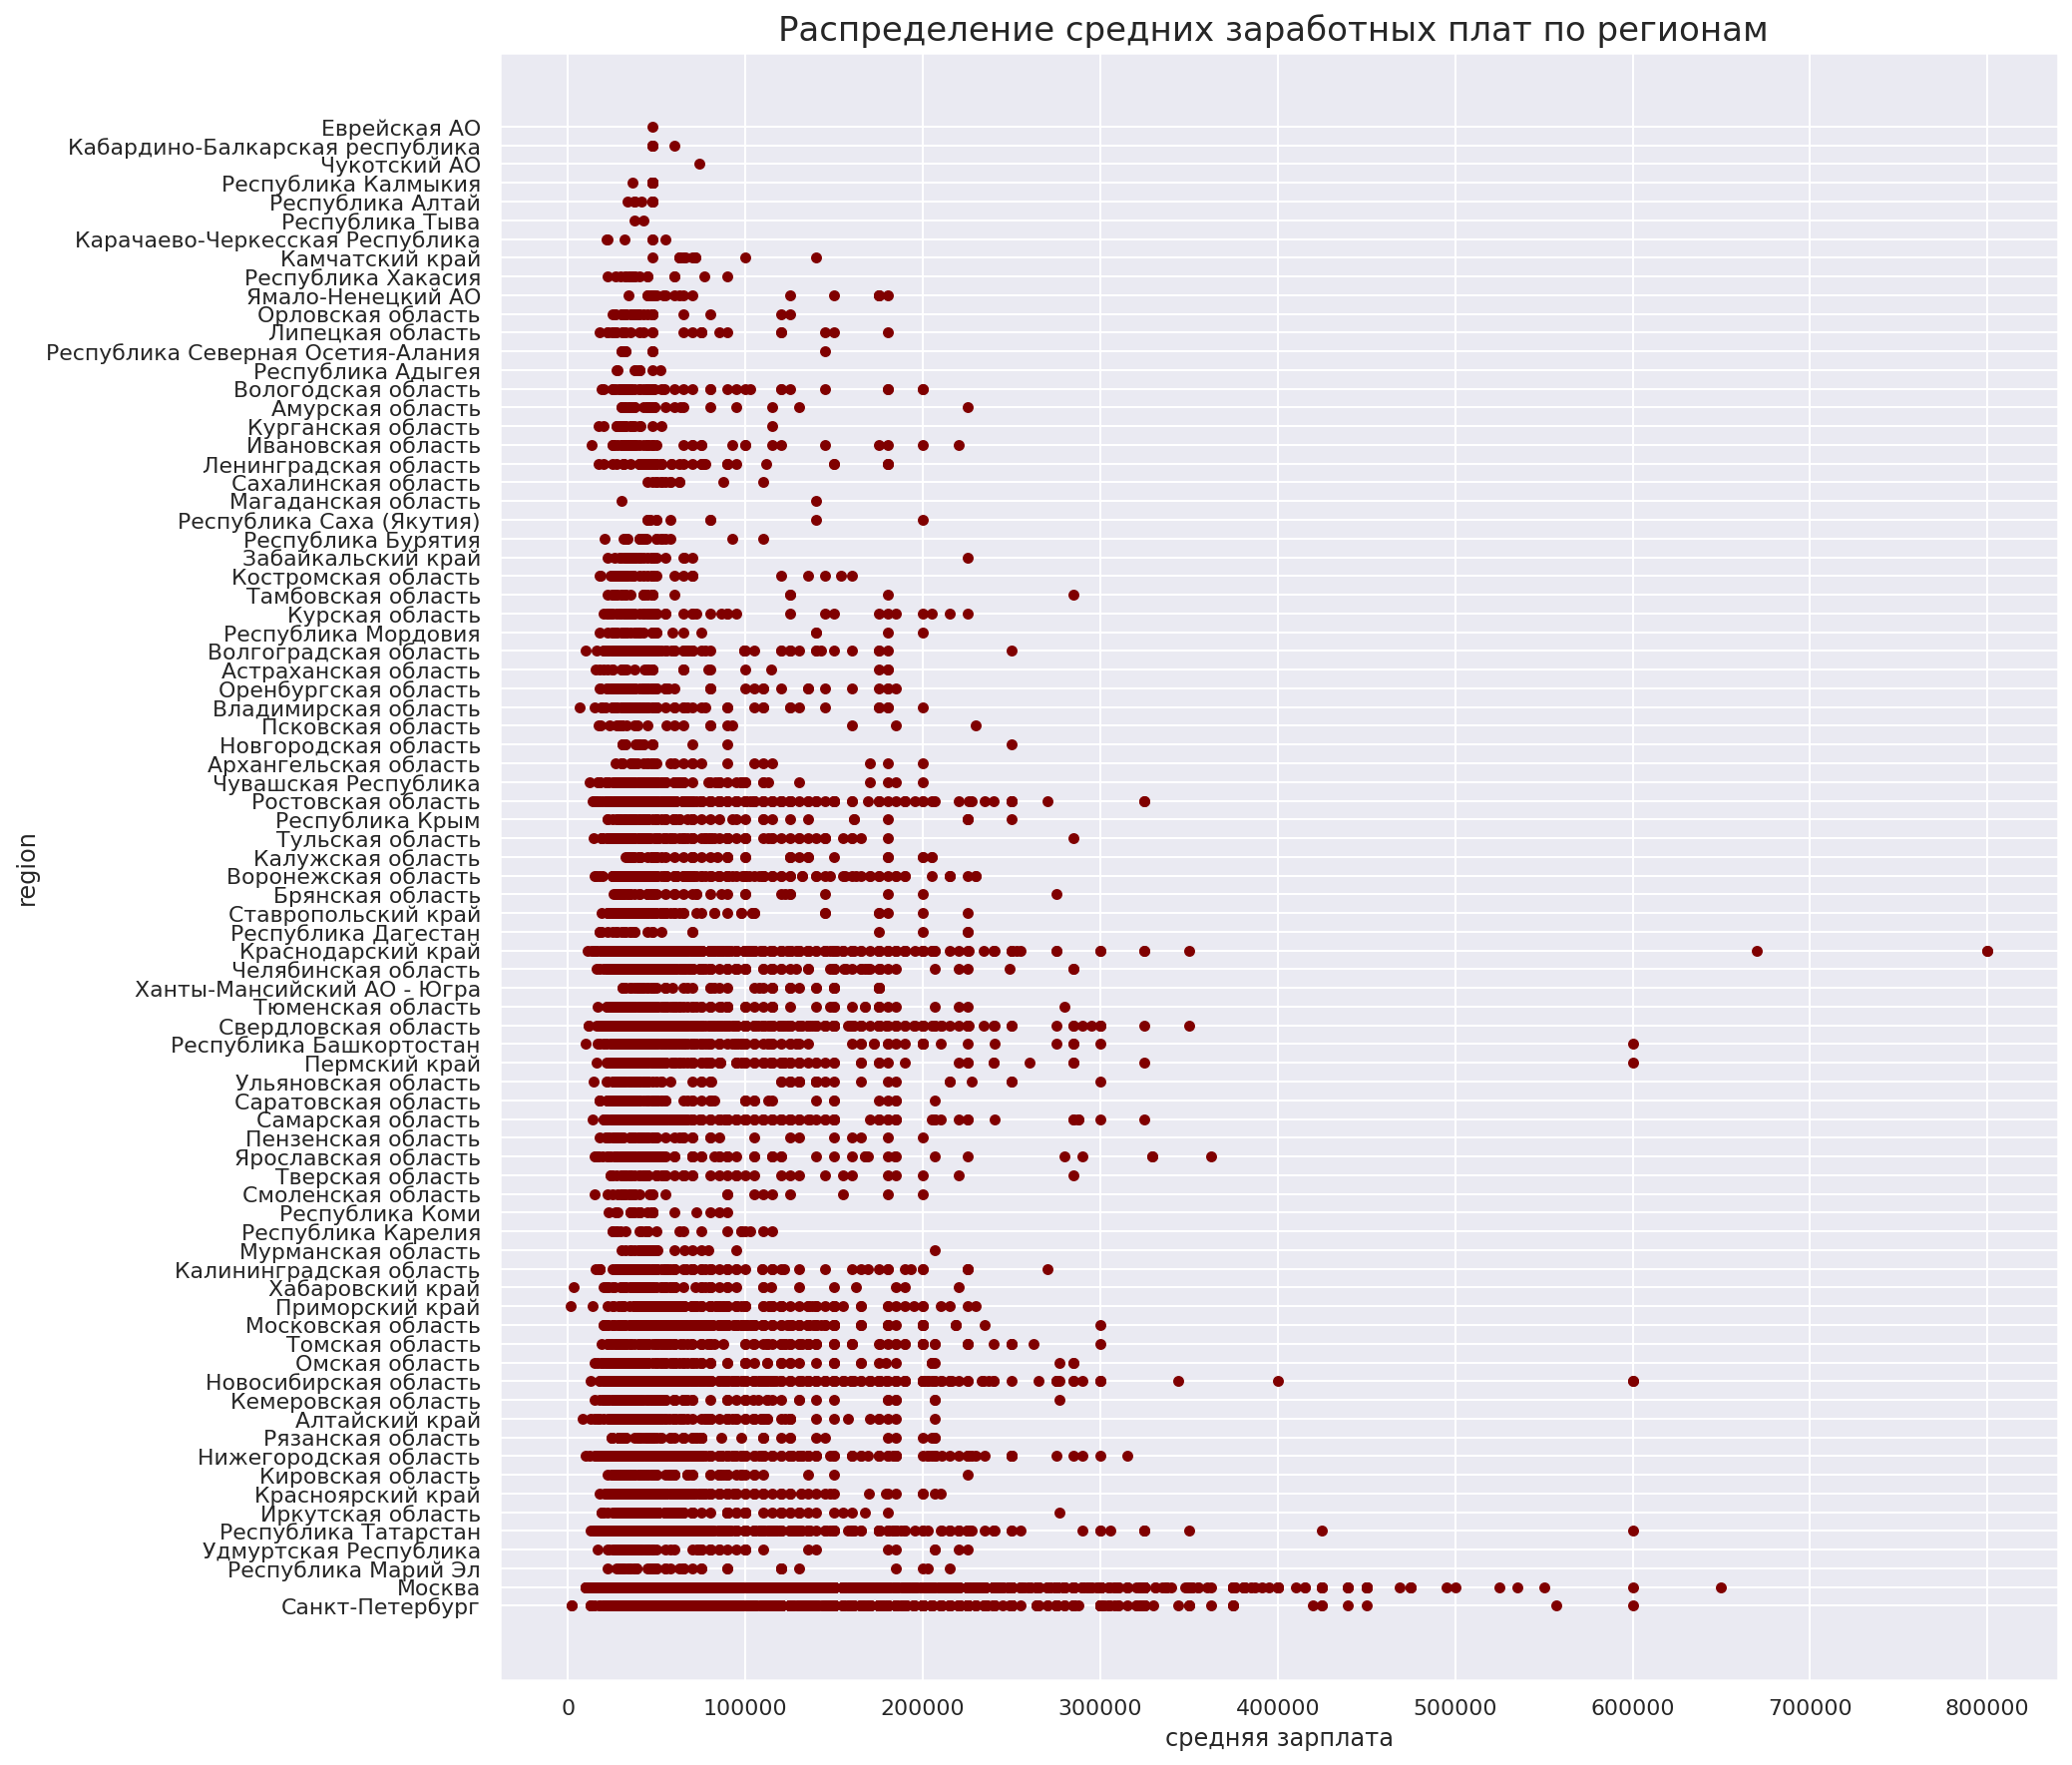

In [ ]:
dataset_salary_2.plot('средняя зарплата','region', kind = 'scatter', figsize=(14,15), color='maroon')
plt.title('Распределение средних заработных плат по регионам ', fontsize = 17)
plt.show()

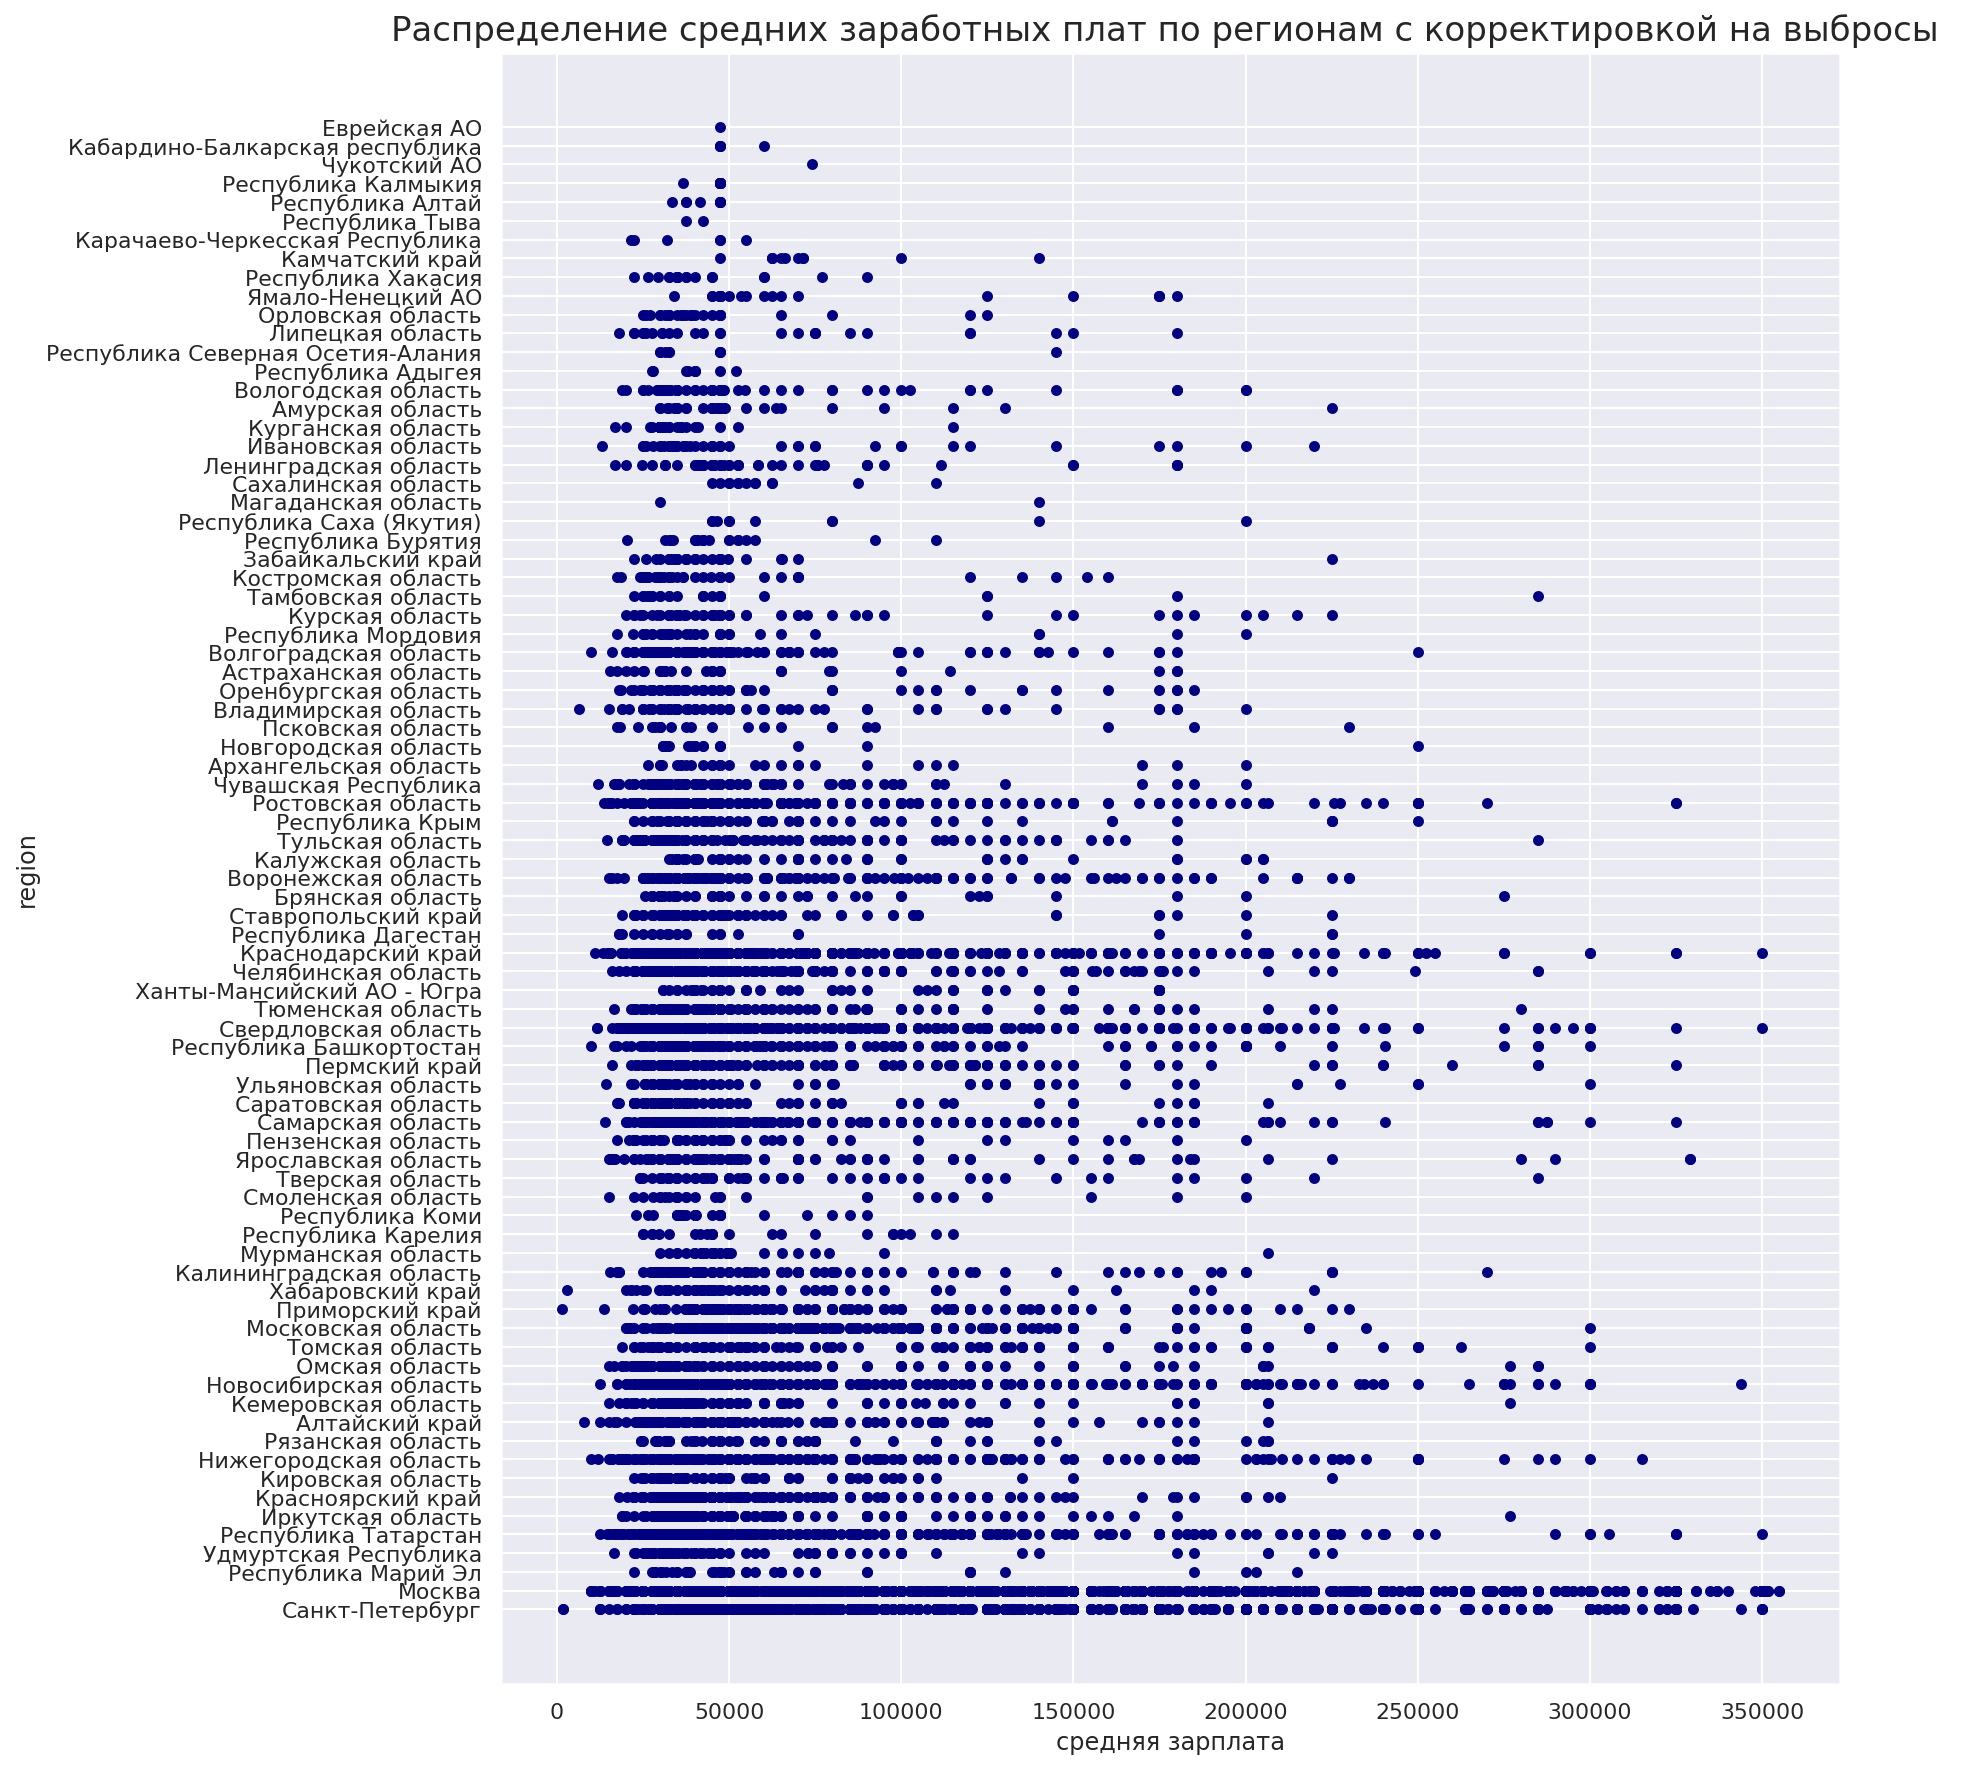

In [ ]:
salary_bez_vybros.plot('средняя зарплата','region', kind = 'scatter', figsize=(12,15), color='navy')
plt.title('Распределение средних заработных плат по регионам с корректировкой на выбросы ', fontsize = 17)
plt.show()

In [ ]:
salary_bez_vybros.to_excel('Вакансии с зарплатой с удалением выбросов.xlsx')

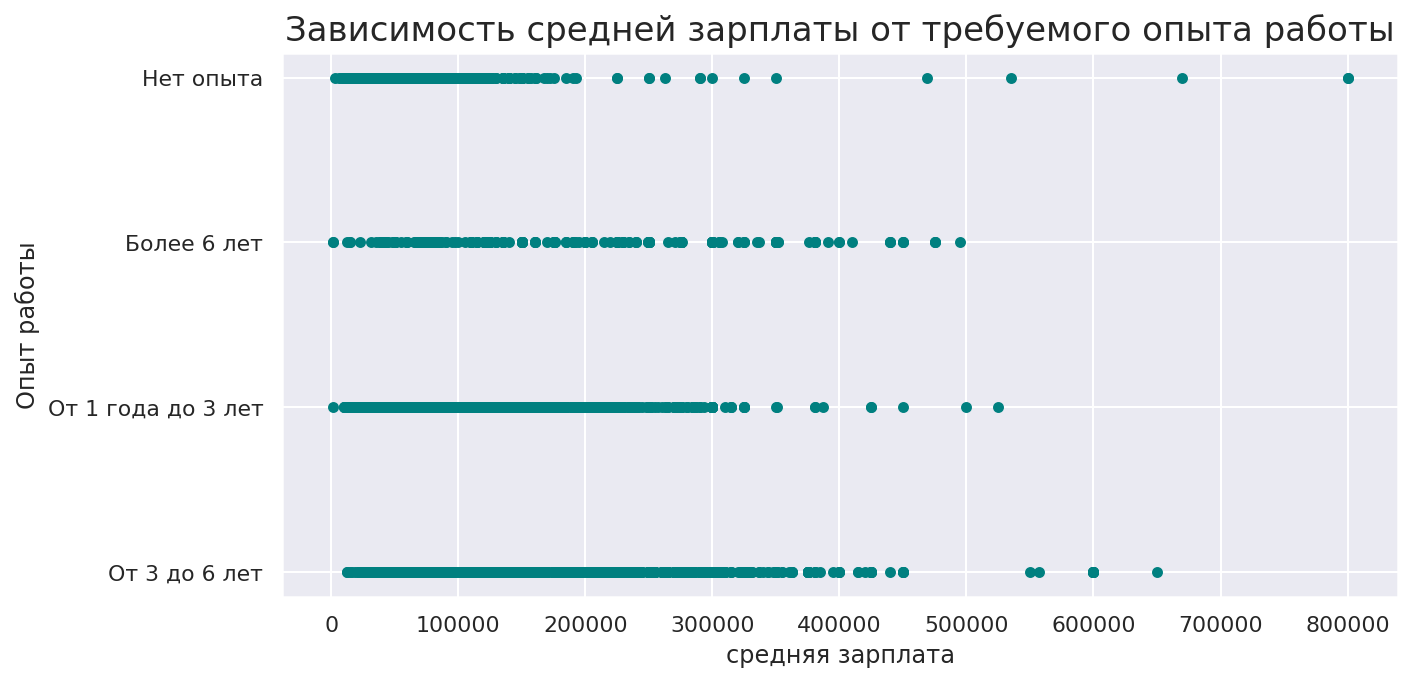

In [ ]:
dataset_salary_2.plot('средняя зарплата', 'Опыт работы', kind = 'scatter', figsize = (10,5), color='teal')
plt.title('Зависимость средней зарплаты от требуемого опыта работы', fontsize = 17)
plt.show()

как видно из представленных выше на диаграмме рассеивания хорошо видно, что имеются выбросы, которые надо удалить

<function matplotlib.pyplot.show(*args, **kw)>

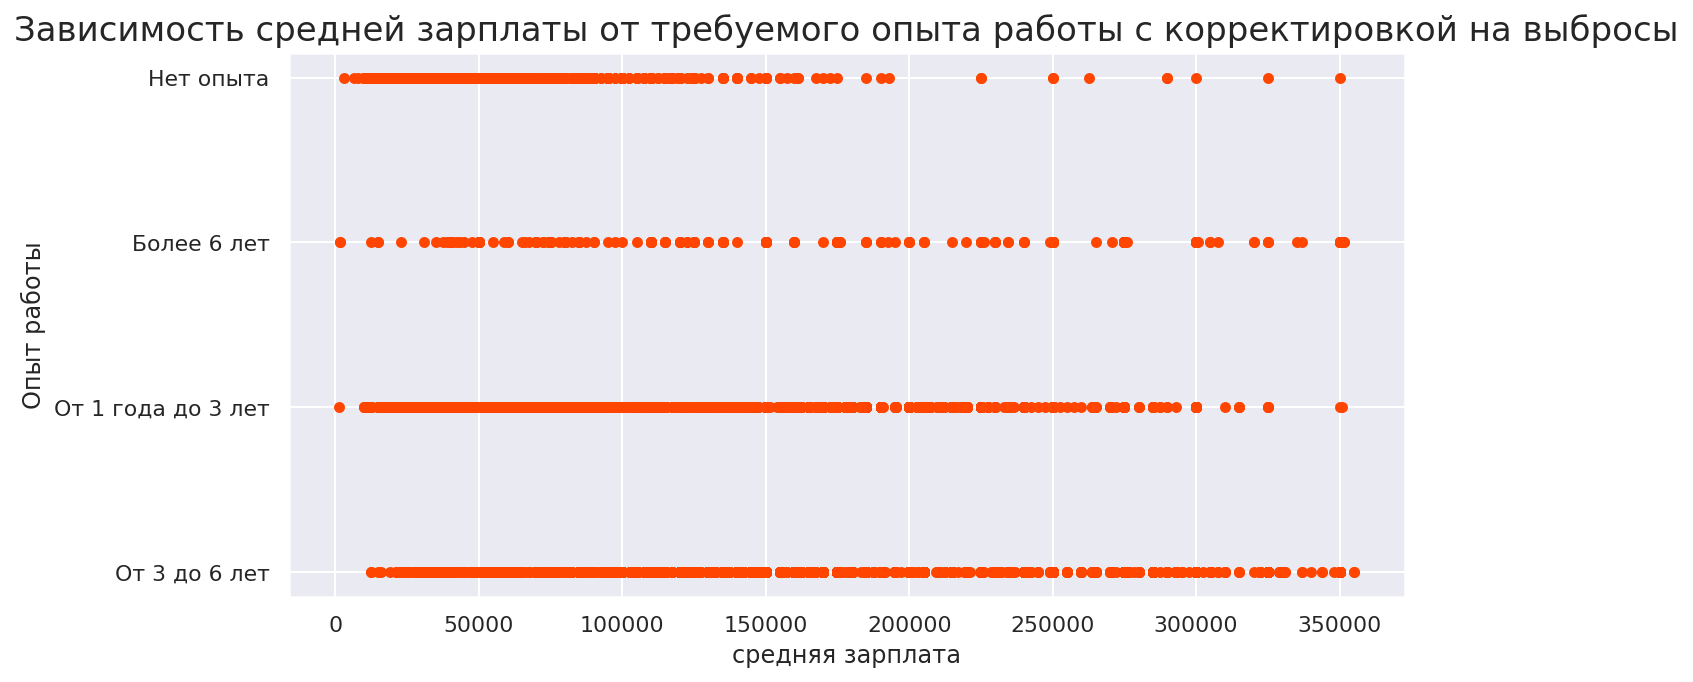

In [ ]:
salary_bez_vybros.plot('средняя зарплата', 'Опыт работы', kind = 'scatter', figsize = (10,5), color='orangered')
plt.title('Зависимость средней зарплаты от требуемого опыта работы c корректировкой на выбросы', fontsize = 17)
plt.show

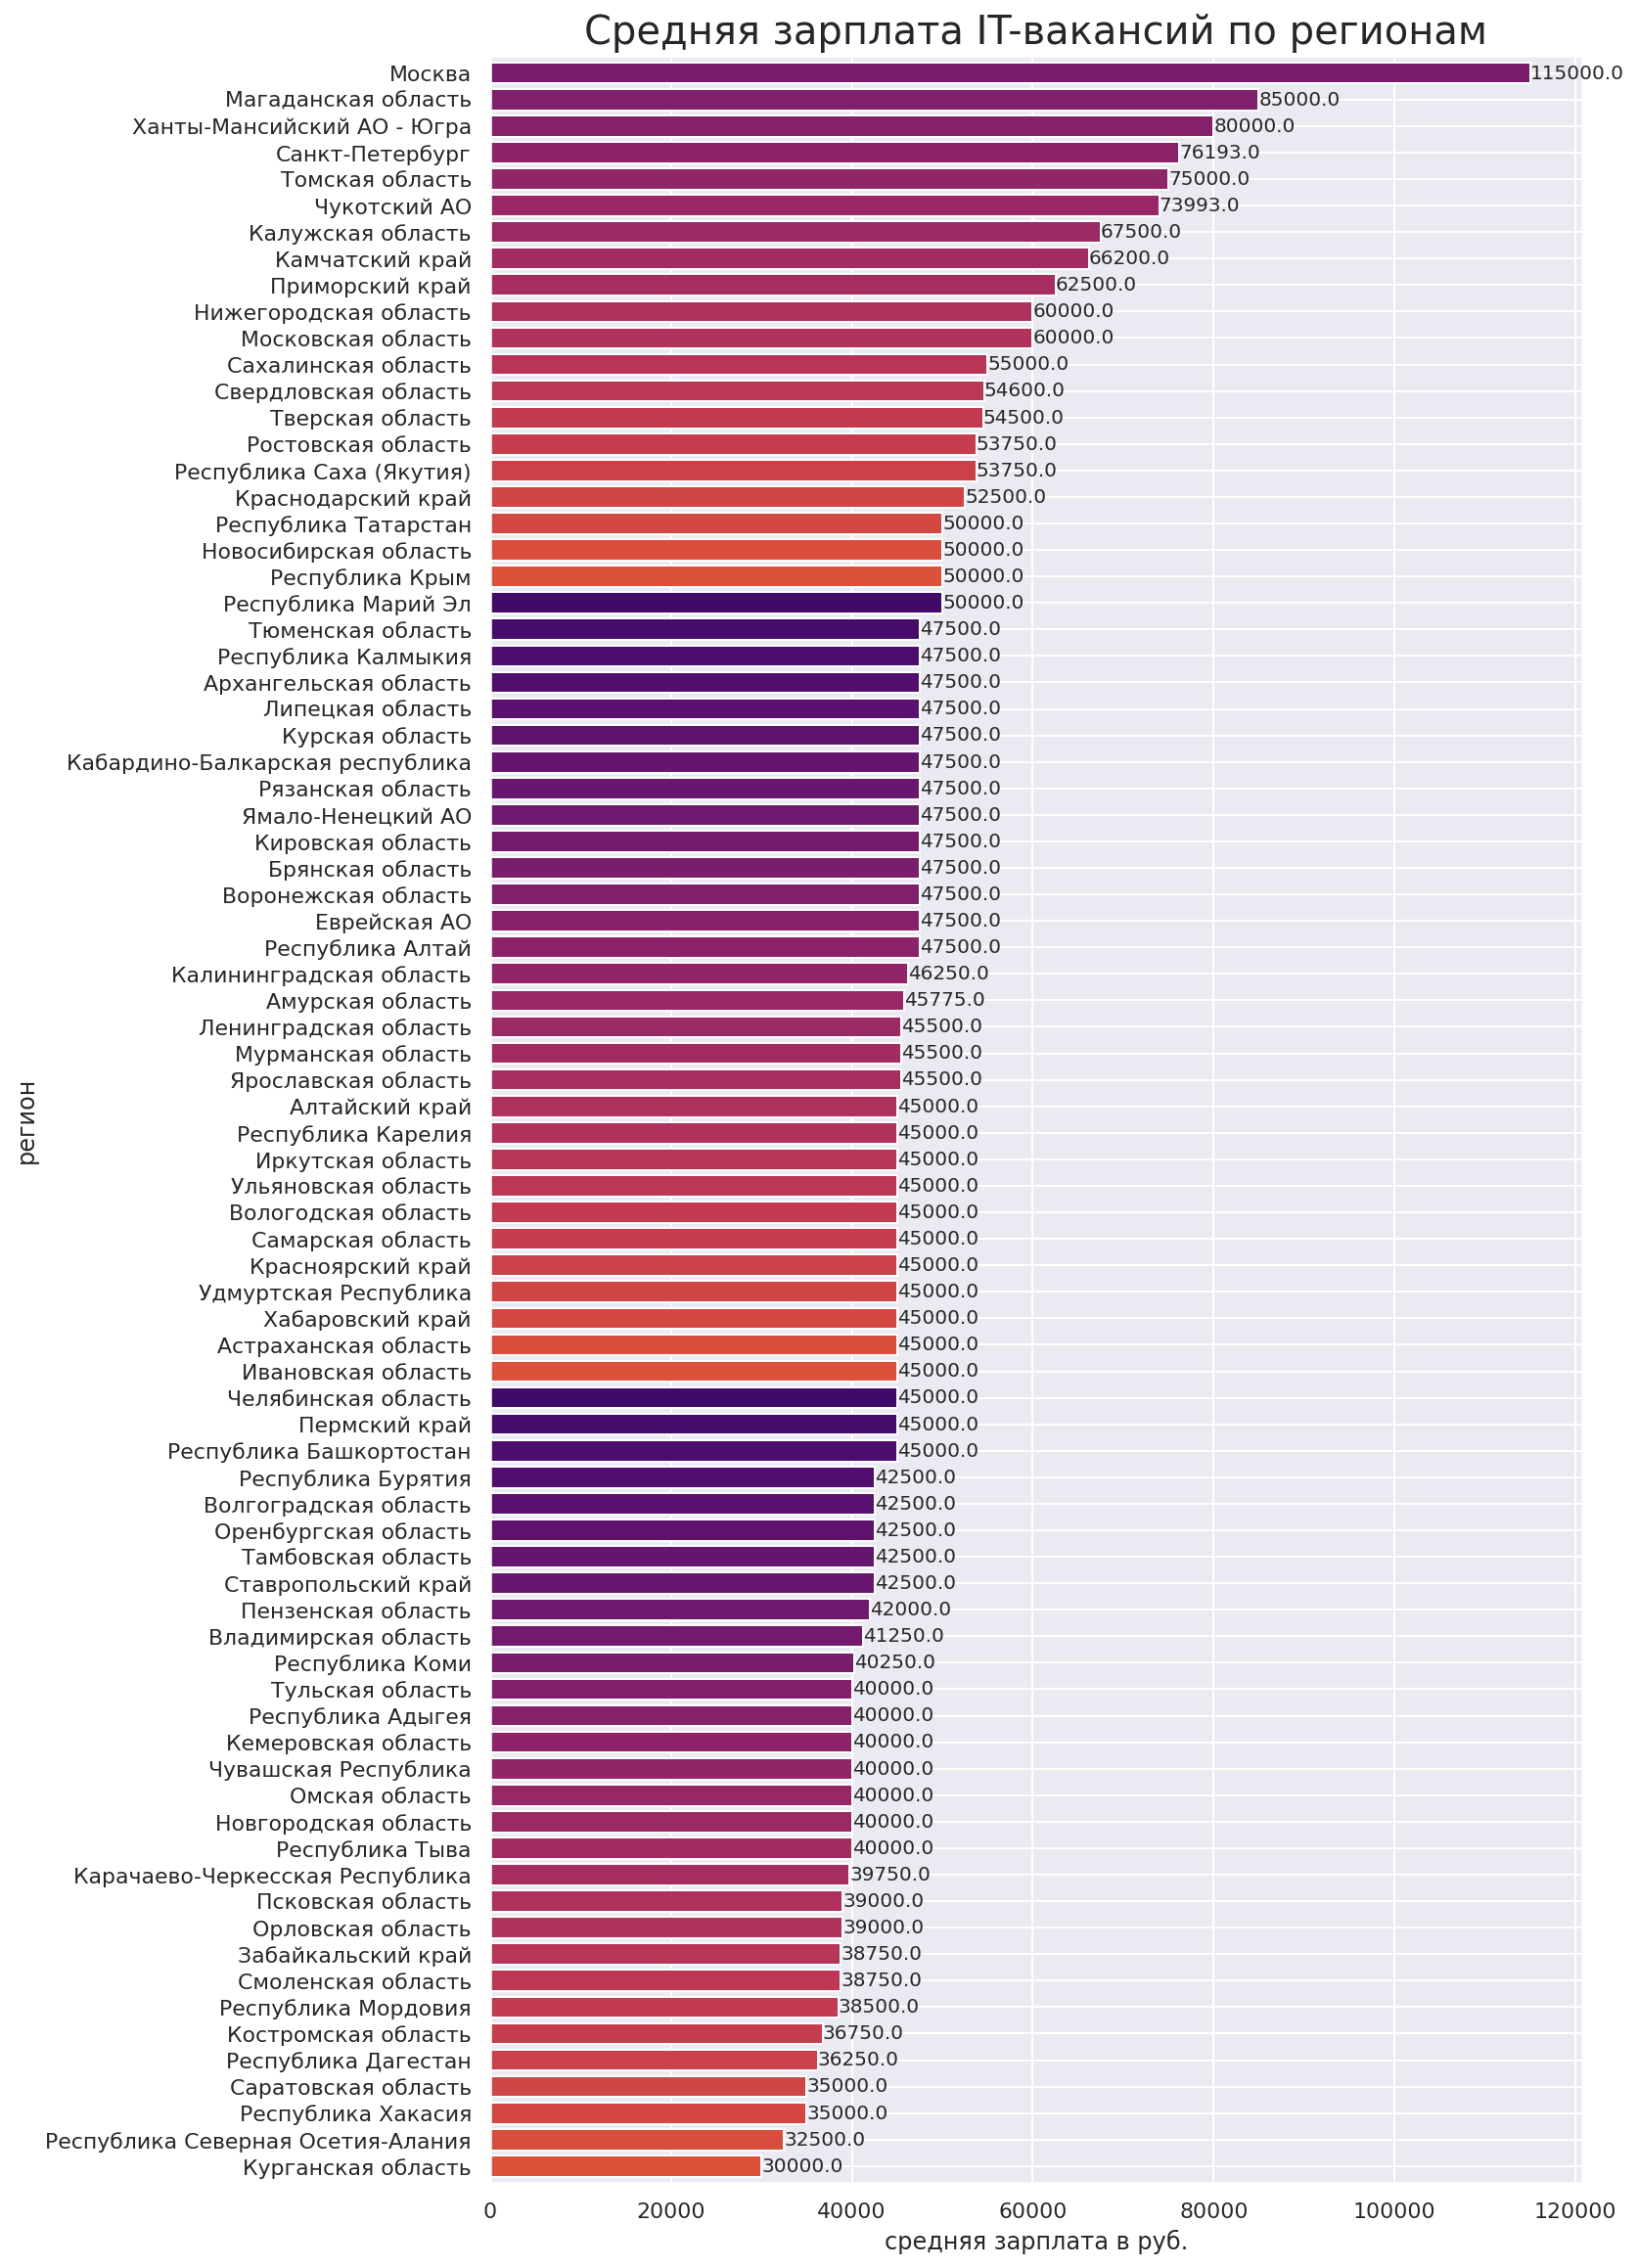

In [ ]:
region_salary.plot(kind='barh', figsize =  (10, 20), color=color, width=0.8)
for y,x in enumerate(region_salary):
    plt.text(x+0.1,y,'%s' %round(x,1),va='center') # Здесь x находится спереди, y сзади, метка значения добавляется к x, а центр также центрируется по вертикали
# Отображение графики
plt.title('Средняя зарплата IT-вакансий по регионам',fontsize = 20)
plt.xlabel('средняя зарплата в руб.')  
plt.ylabel('регион')
plt.show()

In [ ]:
dataset_salary_2['средняя зарплата'].sort_values(ascending = False)

39     800000.0
41     800000.0
43     670000.0
529    650000.0
1      600000.0
         ...   
33       6500.0
4        3000.0
496      1750.0
219      1750.0
42       1400.0
Name: средняя зарплата, Length: 13508, dtype: float64

In [ ]:
median = dataset_salary_2['средняя зарплата'].median()
print('медиана равна:', median)
percentile_10_value = dataset_salary_2['средняя зарплата'].quantile(0.10)
percentile_25_value = dataset_salary_2['средняя зарплата'].quantile(0.25)
percentile_50_value = dataset_salary_2['средняя зарплата'].quantile(0.50)
percentile_75_value = dataset_salary_2['средняя зарплата'].quantile(0.75)
percentile_90_value = dataset_salary_2['средняя зарплата'].quantile(0.90)
print('10-й процентиль средней зарплаты: ', round(percentile_10_value,2))
print('25-й процентиль средняей зарплаты: ', percentile_25_value)
print('50-й процентиль средней зарплаты: ', percentile_50_value)
print('75-й процентиль средней зарплаты: ', percentile_75_value)
print('90-й процентиль средней зарплаты: ', percentile_90_value)

медиана равна: 62500.0
10-й процентиль средней зарплаты:  30700.0
25-й процентиль средняей зарплаты:  40000.0
50-й процентиль средней зарплаты:  62500.0
75-й процентиль средней зарплаты:  120000.0
90-й процентиль средней зарплаты:  200000.0


In [ ]:
dataset_salary_2['средняя зарплата'].describe().apply("{0:.2f}".format)


count     13508.00
mean      90656.98
std       72723.25
min        1400.00
25%       40000.00
50%       62500.00
75%      120000.00
max      800000.00
Name: средняя зарплата, dtype: object

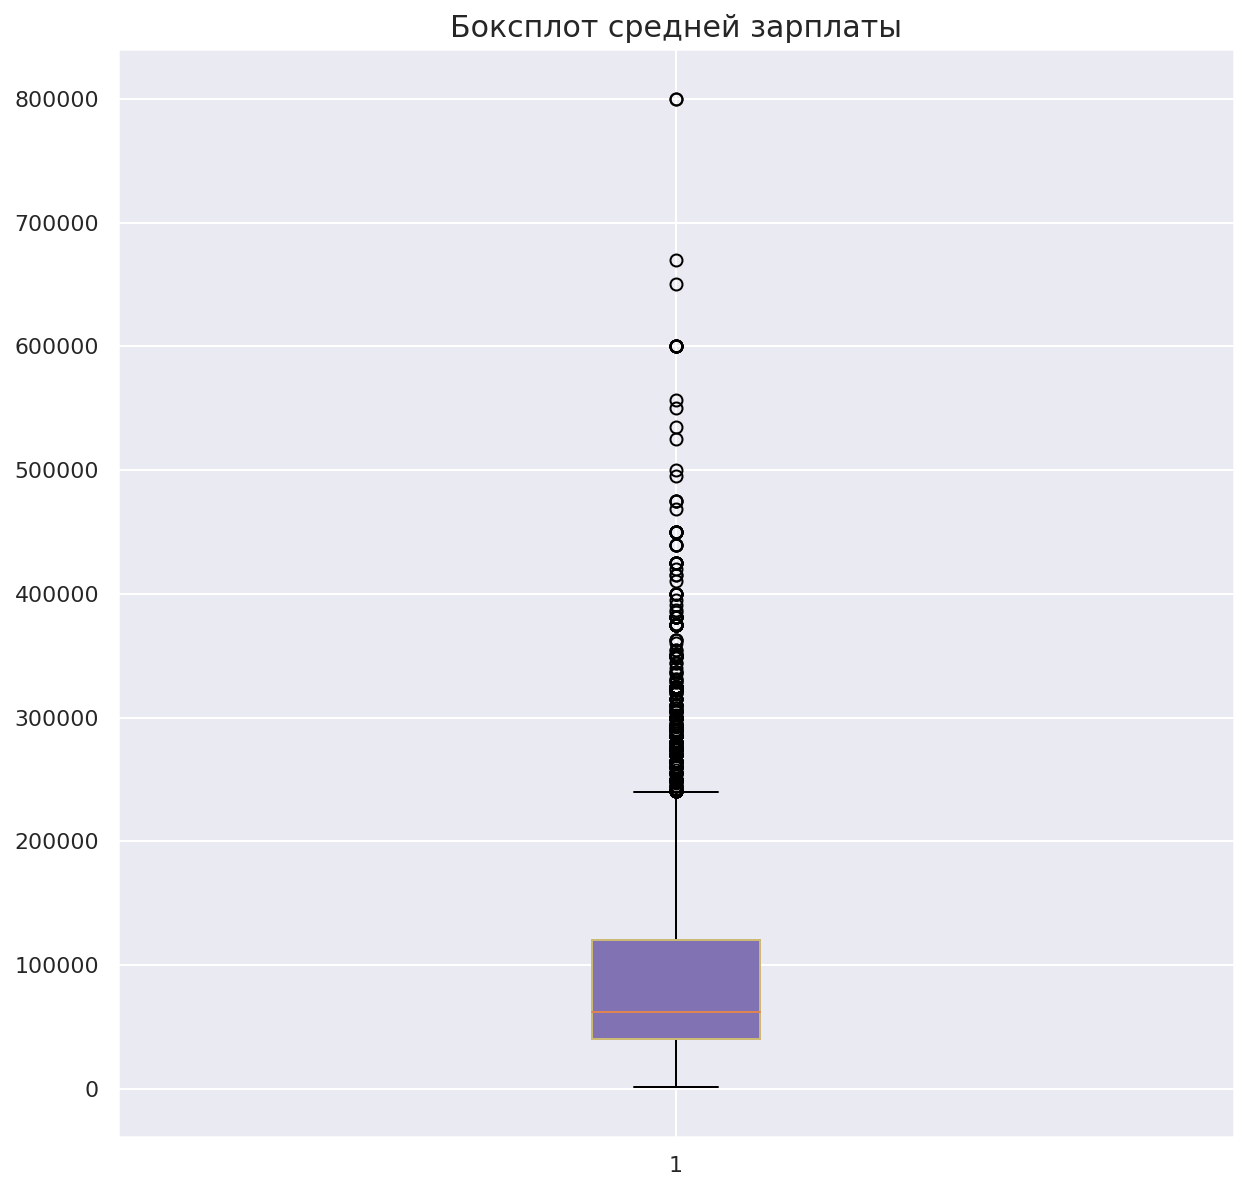

In [ ]:
plt.boxplot(dataset_salary_2['средняя зарплата'], figsize(10,10),patch_artist=True, boxprops=dict(facecolor='m', color='y'))
plt.title('Боксплот средней зарплаты',fontsize = 15)
plt.show()

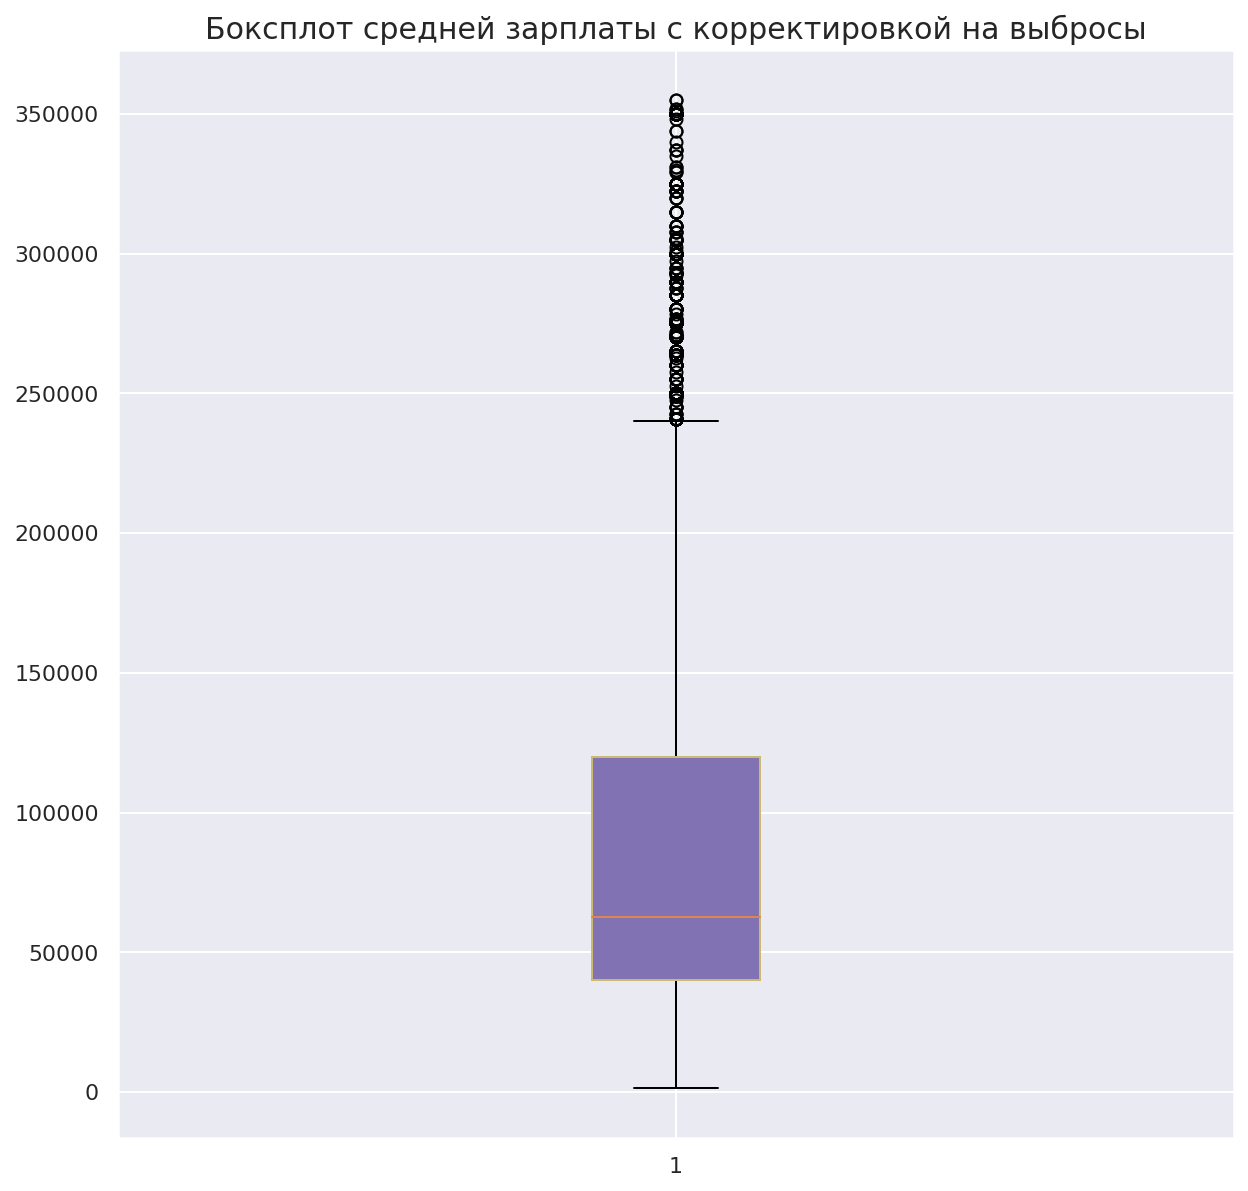

In [ ]:
plt.boxplot(salary_bez_vybros['средняя зарплата'], figsize(10,10),patch_artist=True, boxprops=dict(facecolor='m', color='y'))
plt.title('Боксплот средней зарплаты c корректировкой на выбросы',fontsize = 15)
plt.show()

In [ ]:
# смотрим на средние зарплаты, какие преобладают
salary = round(salary_bez_vybros['средняя зарплата'].value_counts(bins = 10), 1)#.head(12)
salary

(36760.0, 72120.0]               4895
(1046.3990000000001, 36760.0]    2689
(72120.0, 107480.0]              1988
(107480.0, 142840.0]             1339
(142840.0, 178200.0]              904
(178200.0, 213560.0]              667
(213560.0, 248920.0]              414
(248920.0, 284280.0]              266
(284280.0, 319640.0]              163
(319640.0, 355000.0]               99
Name: средняя зарплата, dtype: int64

<function matplotlib.pyplot.show(*args, **kw)>

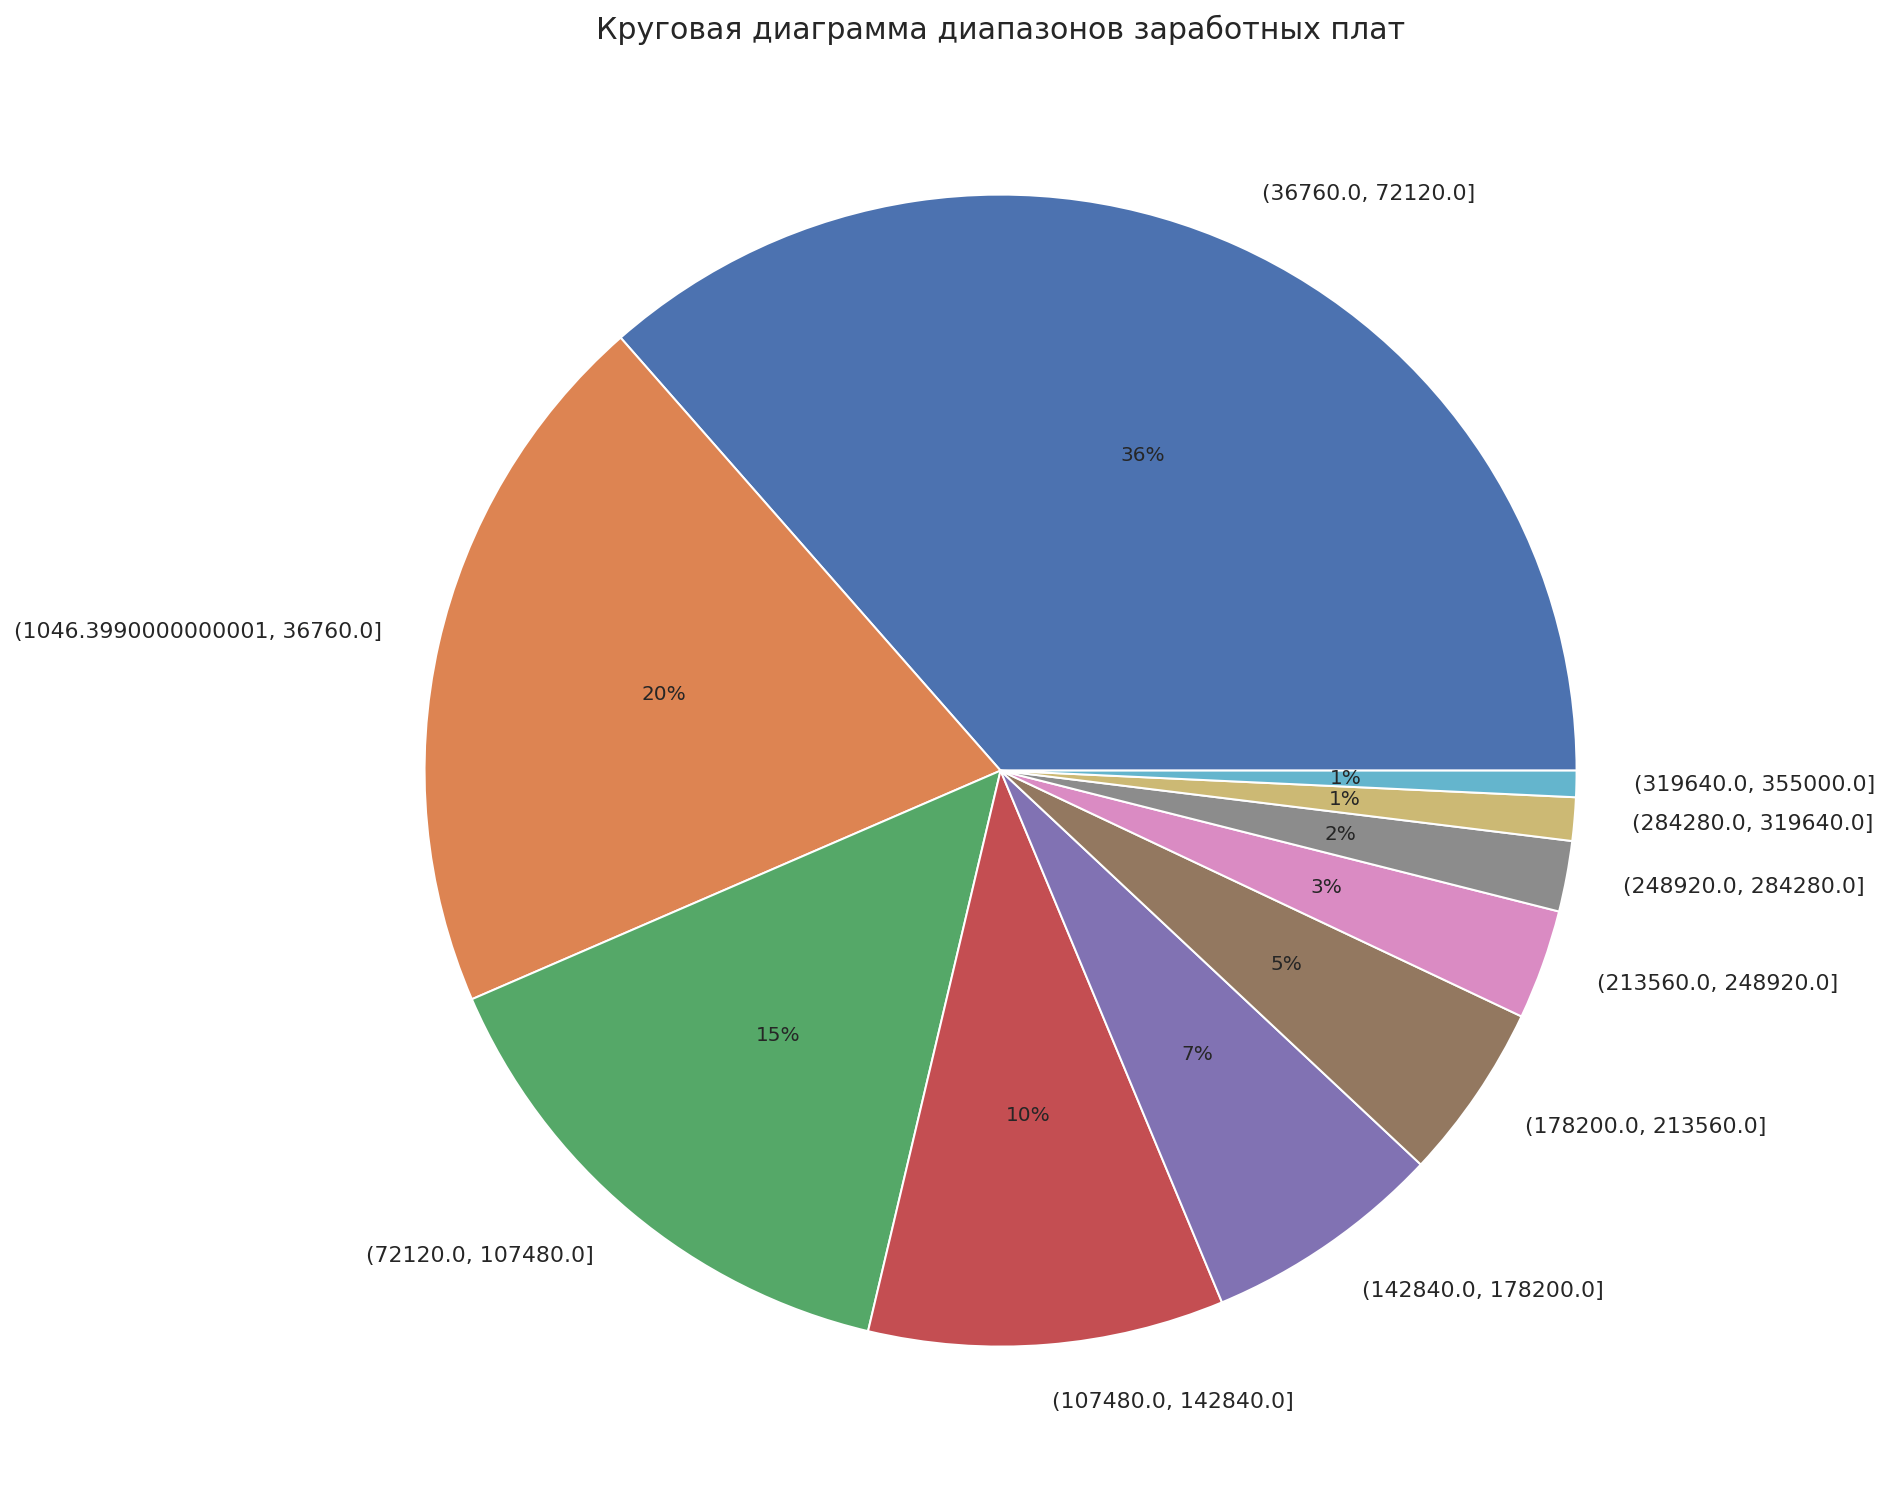

In [ ]:
plt.pie(salary.values, labels = salary.index, autopct='%1.0f%%')
plt.title('Круговая диаграмма диапазонов заработных плат', fontsize = 15)
plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=10.0)
plt.show

теперь посмотрим связь средней заработной платы с учётом графика работы

In [ ]:
salary_bez_vybros['График работы'] = salary_bez_vybros['График работы'].astype('category')


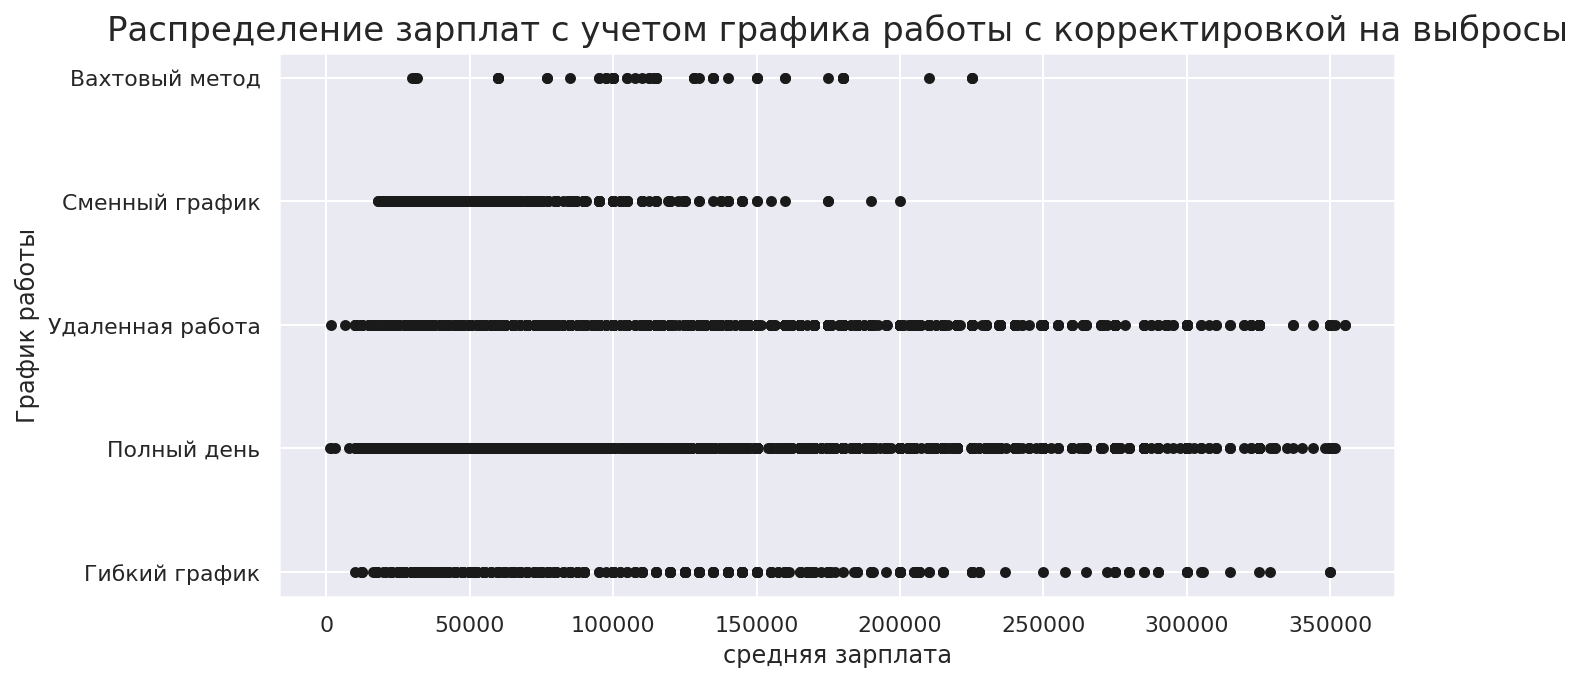

In [ ]:
salary_bez_vybros.plot('средняя зарплата', 'График работы', kind = 'scatter', figsize = (10,5), color='k')
plt.title('Распределение зарплат с учетом графика работы c корректировкой на выбросы', fontsize = 17)
plt.show()

## выше по разбиению вакансий на названия, мы увидели, что преобладают вакансии на ПРОГРАММИСТА 1С, давайте его проанализируем
 
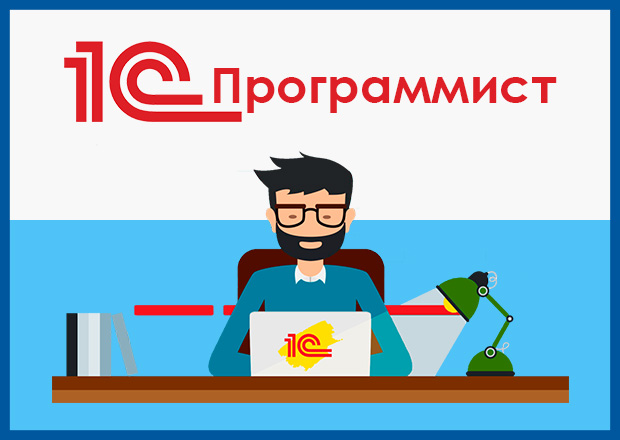

In [ ]:
# создаем отдельный датасет по фильтру
dataset_1C = dataset_3[dataset_3['name'] == 'Программист 1С']
dataset_1C = dataset_1C[['id', 'name', "зарплата от", "зарплата до","город", "region",
                         "тип вакансии","дата публикации", "время публикации","Название работодателя",'График работы','Ключевые навыки', "Требования",
                         "Обязанности", "Описание вакансии", "Опыт работы"]]
dataset_1C.head()                   

id            name  зарплата от  зарплата до    город  region  \
96   67033429  Программист 1С          0.0          0.0  Москва   Москва   
170  67256134  Программист 1С     130000.0          0.0  Москва   Москва   
180  66542854  Программист 1С     230000.0     230000.0  Москва   Москва   
182  67012829  Программист 1С          0.0          0.0  Москва   Москва   
189  67343158  Программист 1С     110000.0          0.0  Москва   Москва   

    тип вакансии дата публикации время публикации Название работодателя  \
96      Открытая      2022-06-30         11:18:53         Деловая среда   
170     Открытая      2022-06-30         15:29:06  Торговый дом Автопак   
180     Открытая      2022-07-01         15:10:44             НОВОТРАНС   
182     Открытая      2022-07-02         19:07:36                 FORTA   
189     Открытая      2022-07-02         14:48:28     ТД Альфа-Комплект   

        График работы                                    Ключевые навыки  \
96   Удаленная работа  1С: Зарплата и управление персоналом, 1С: Пред...   
170       Полный день                                                      
180       Полный день                              1С программирование,    
182  Удаленная работа  Управленческий учет, MS SQL Server, SQL, ERP-с...   
189       Полный день                                                      

                                            Требования  \
96   Опыт организации взаимодействия между базами <...   
170  Знание платформы 1С (управляемые и неуправляем...   
180  Опыт работы от 3 лет. Хорошее знание БСП, СКД,...   
182  Свободное владение языком программирования в с...   
189                    1С Предприятие 8.1, 8.2, 8.3.,    

                                           Обязанности  \
96   ...<highlighttext>баз</highlighttext> <highlig...   
170  Администрирование <highlighttext>баз</highligh...   
180  Создание обменов с внешними базами <highlightt...   
182  Модификация и обновление программного обеспече...   
189  ...конфигураций информационных <highlighttext>...   

                                     Описание вакансии         Опыт работы  
96   Обязанности:  Консультация и поддержка пользов...  От 1 года до 3 лет  
170  Требования:  Образование высшее техническое; З...       От 3 до 6 лет  
180  Обязанности:  Разработка нетиповой конфигураци...       От 3 до 6 лет  
182  Forta - ведущий поставщик надежных и безопасны...       От 3 до 6 лет  
189  Обязанности:  Разработка (модификация) конфигу...       От 3 до 6 лет

In [ ]:
dataset_1C.to_excel('Вакансии на программиста 1С все.xlsx')


## Анализ распределения вакансий "Программист 1С" по регионам


In [ ]:
region_vacancies_1C = dataset_1C['region'].value_counts(ascending=False).head(30)
region_vacancies_1C.head(10)

Москва                   396
Санкт-Петербург          204
Свердловская область      86
Нижегородская область     83
Краснодарский край        69
Новосибирская область     65
Республика Татарстан      61
Красноярский край         61
Самарская область         54
Воронежская область       47
Name: region, dtype: int64

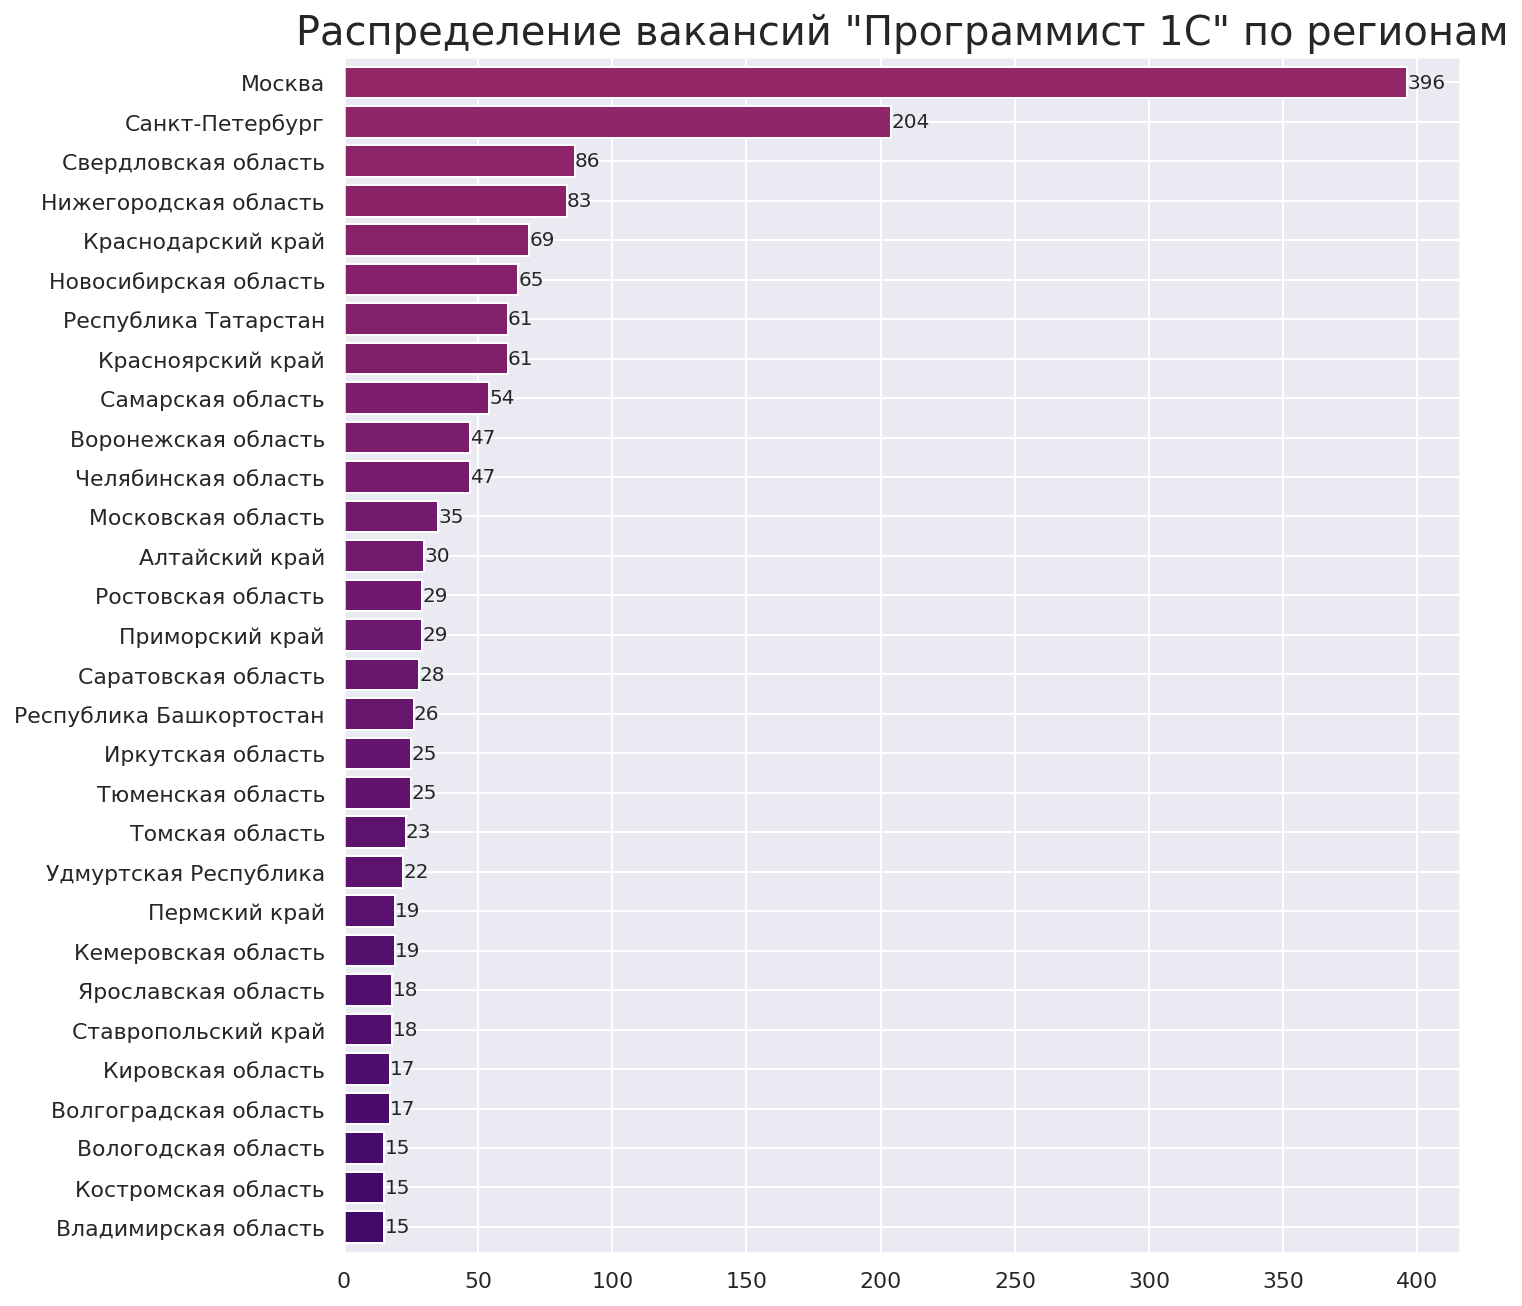

In [ ]:
colors_2 = cm.inferno_r(np.linspace(.6,.8, 30))
region_vacancies_1C.plot(kind='barh', figsize =  (10, 11), color=colors_2, width=0.8).invert_yaxis()
for y,x in enumerate(region_vacancies_1C):
    plt.text(x+0.1,y,'%s' %round(x,1),va='center') # Здесь x находится спереди, y сзади, метка значения добавляется к x, а центр также центрируется по вертикали
# Отображение графики    
plt.title('Распределение вакансий "Программист 1С" по регионам',fontsize = 20)
plt.show()

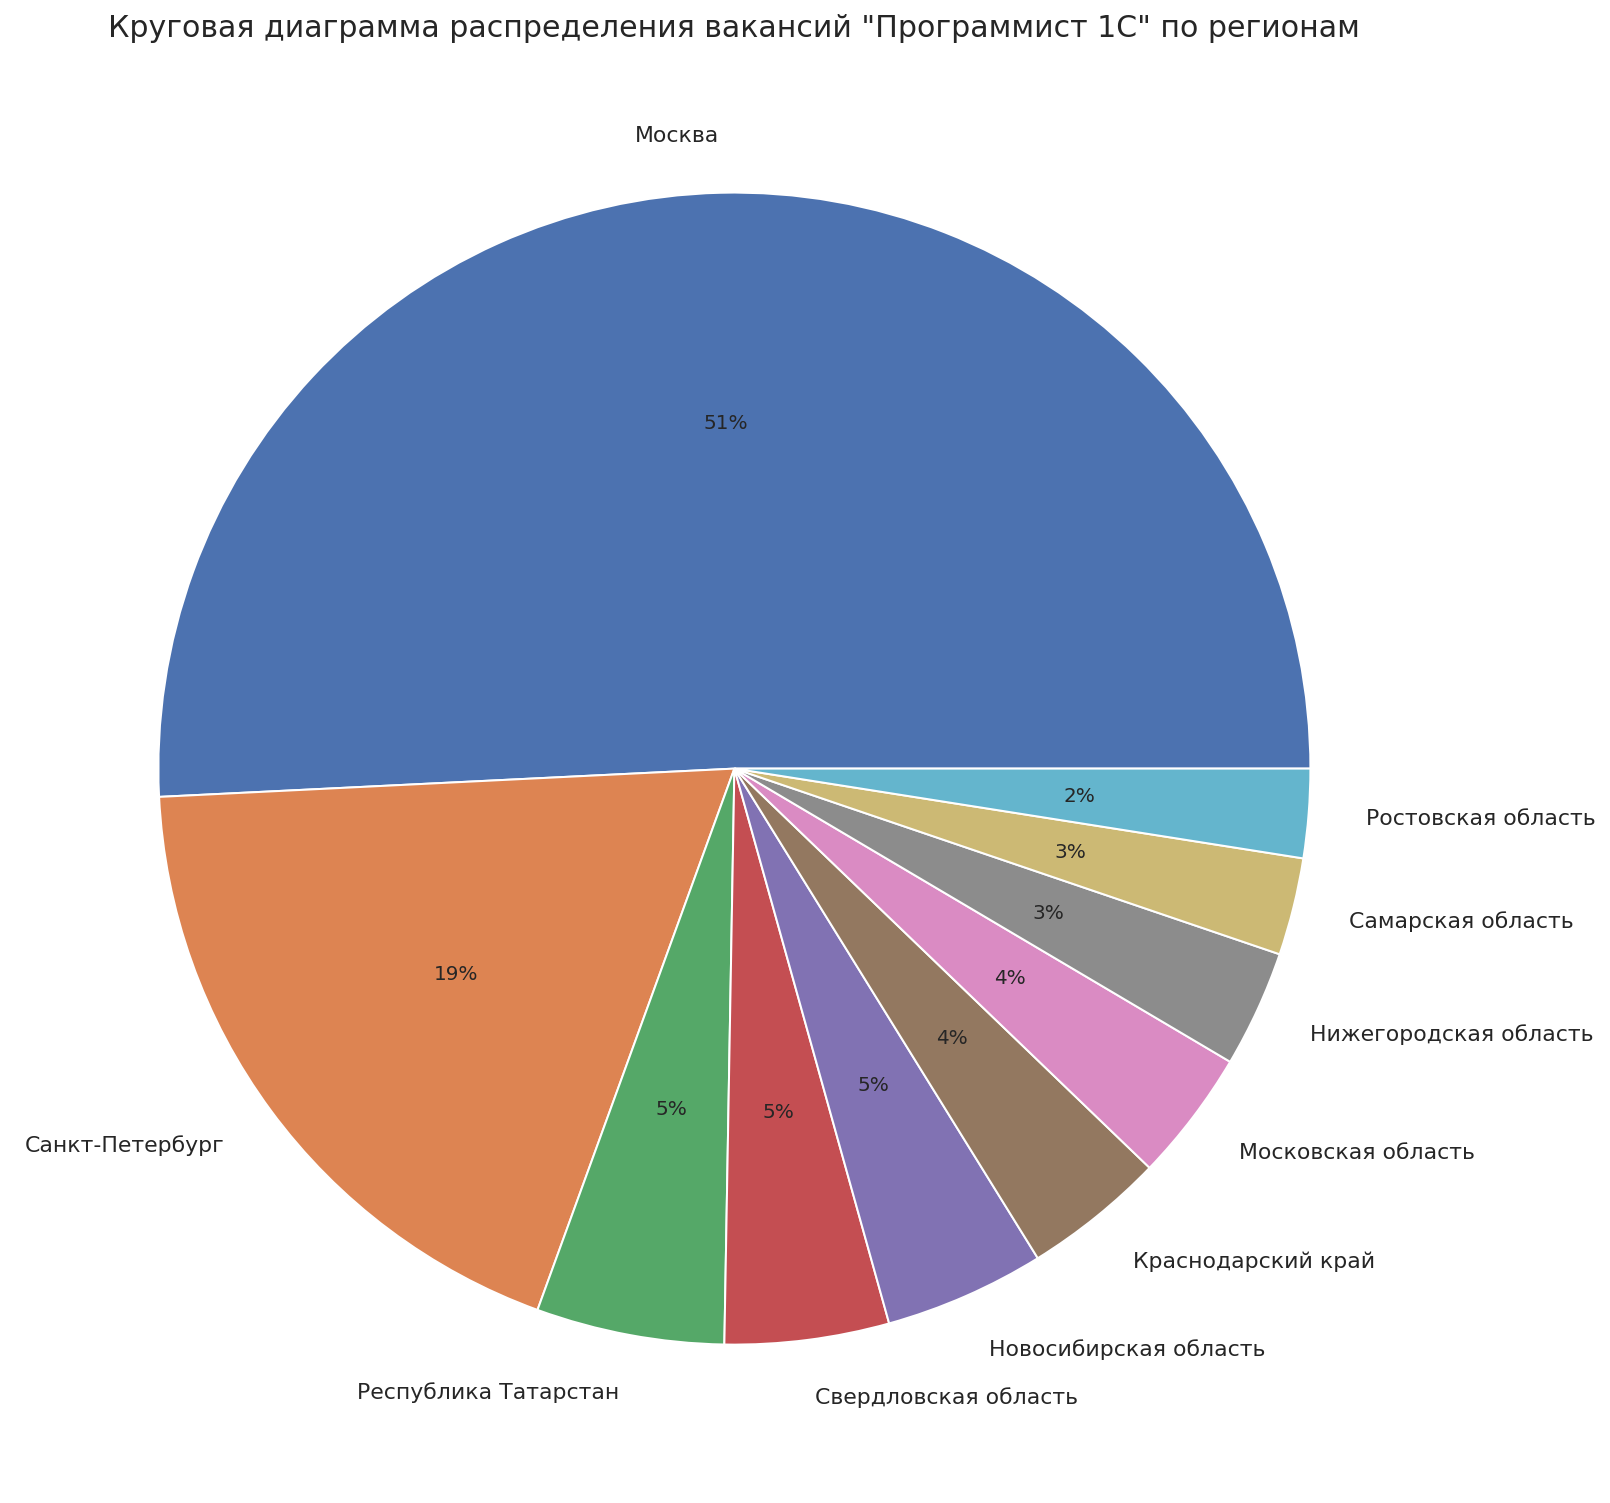

In [ ]:
region_vacancies_1C_2 = dataset_3['region'].value_counts().head(10)

plt.pie(region_vacancies_1C_2.values, labels = region_vacancies_1C_2.index, autopct='%1.0f%%')
plt.title('Круговая диаграмма распределения вакансий "Программист 1С" по регионам', fontsize = 15)
plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=10.0)
plt.show()

## Анализ требуемого опыта работы вакансии "Программист 1С"

In [ ]:
dataset_1C['Опыт работы'].value_counts()

От 1 года до 3 лет    959
От 3 до 6 лет         804
Нет опыта              59
Более 6 лет            19
Name: Опыт работы, dtype: int64

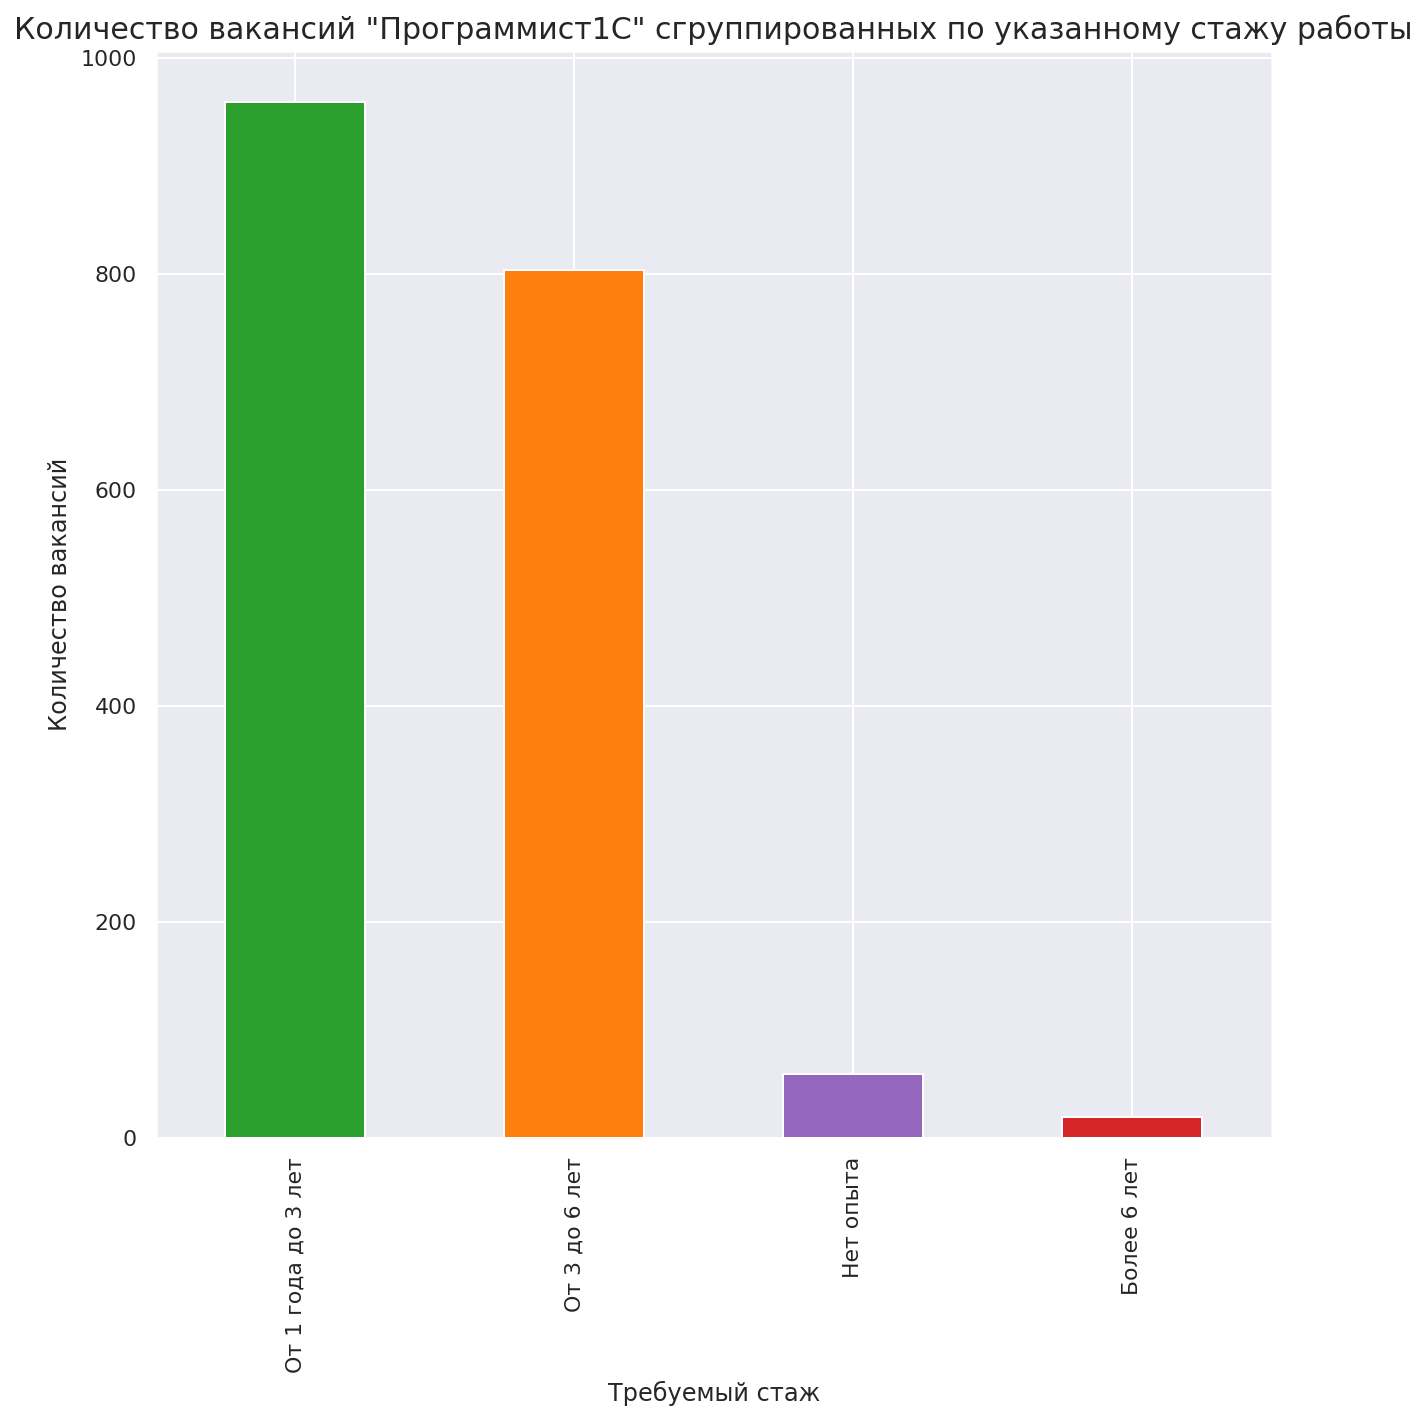

In [ ]:
colors1 = ['tab:green', 'tab:orange', 'tab:purple', 'tab:red']
dataset_1C['Опыт работы'].value_counts().plot(kind='bar', color = colors1)
plt.title('Количество вакансий "Программист1С" сгруппированных по указанному стажу работы',  fontsize = 15)
plt.xlabel('Требуемый стаж')
plt.ylabel('Количество вакансий')
plt.show()

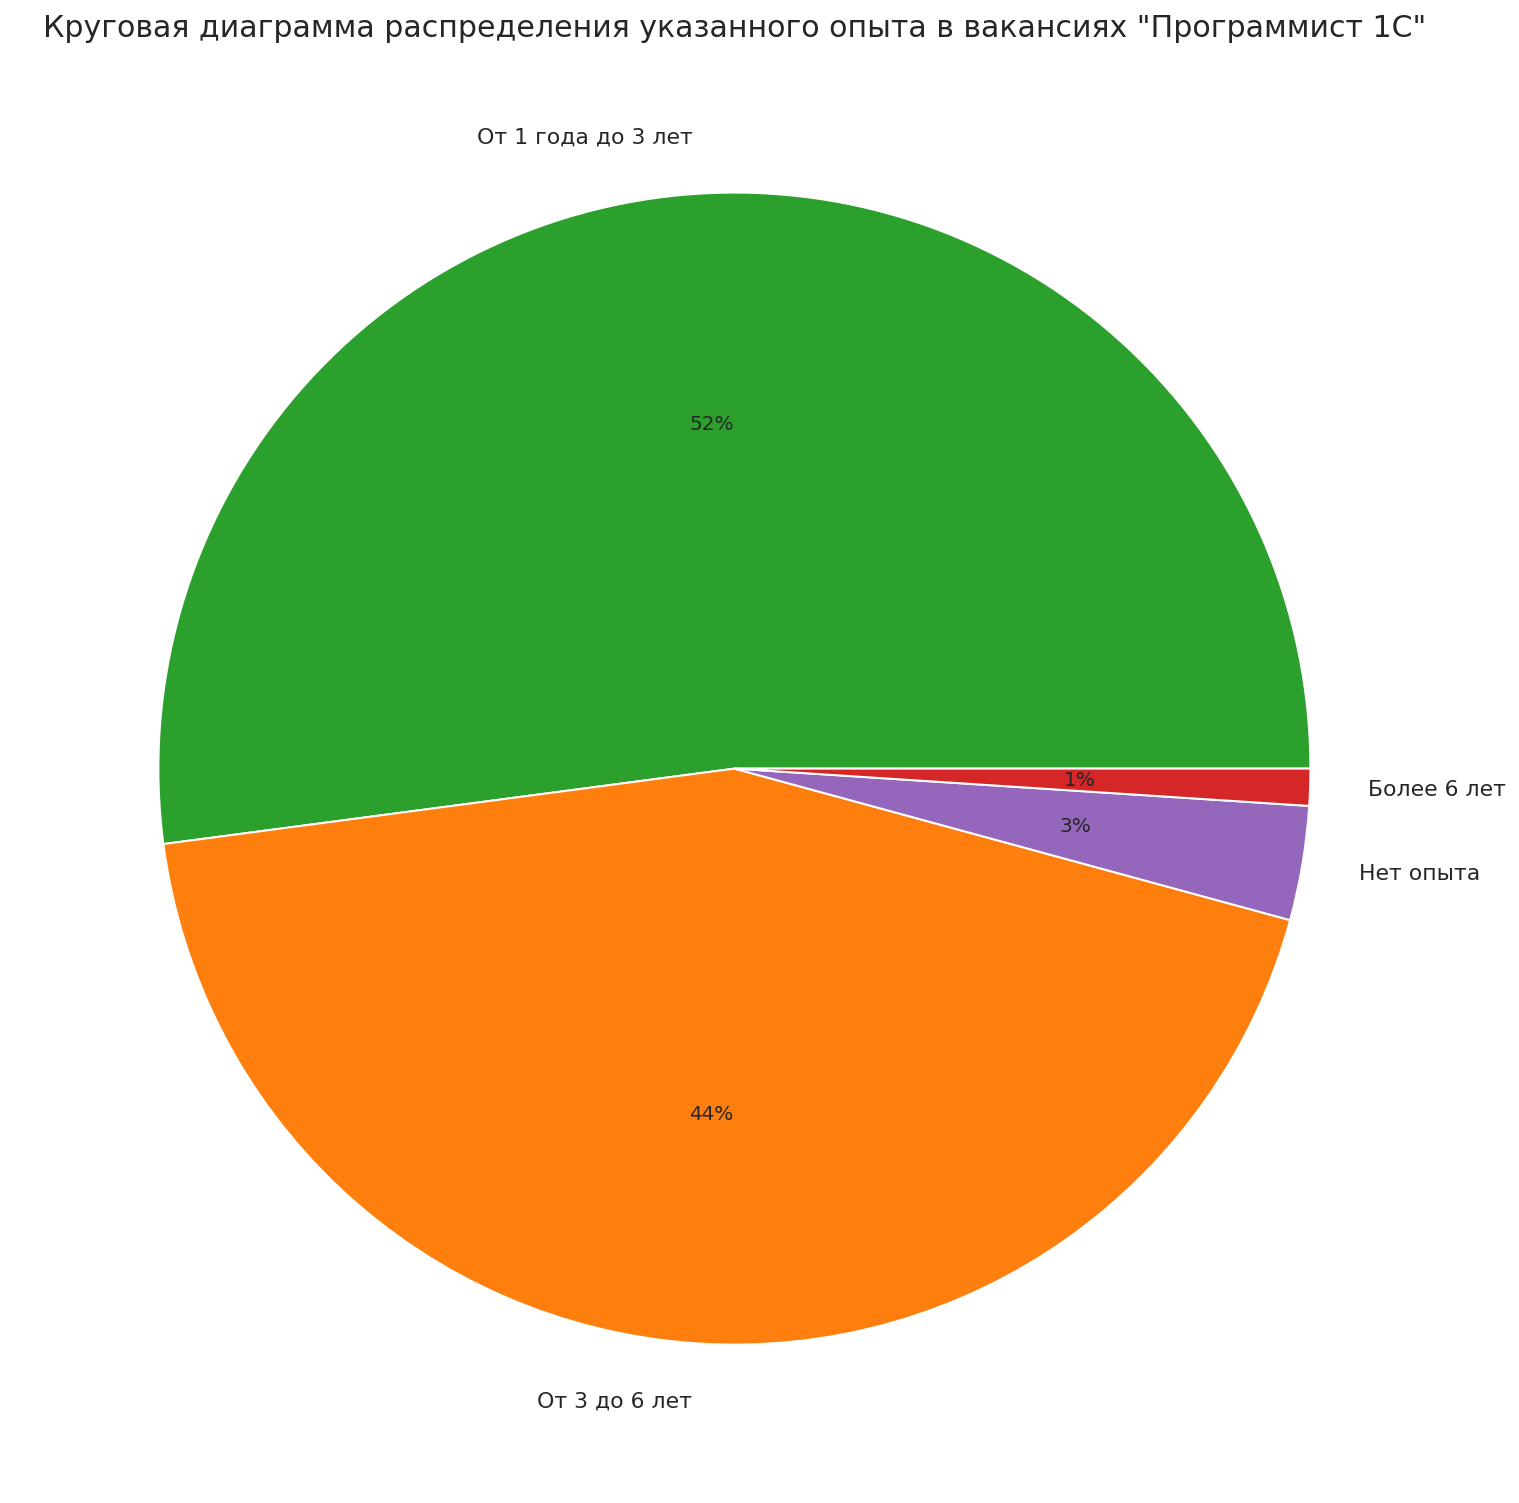

In [ ]:
colors = ['tab:green', 'tab:orange', 'tab:purple', 'tab:red']

plt.pie(dataset_1C["Опыт работы"].value_counts().values, labels = dataset_1C["Опыт работы"].value_counts().index, colors=colors, autopct='%1.0f%%')
plt.title('Круговая диаграмма распределения указанного опыта в вакансиях "Программист 1С"', fontsize = 15)
plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=8.0)
plt.show()

##Анализ зарплат вакансии "Программист 1С" по регионам

In [ ]:
dataset_salary_1С = dataset_1C[(dataset_1C['зарплата от'] !=0) & (dataset_1C['зарплата до'] !=0)]   # выбрали строки, только те, в которых указана зарплата от и зарплата до

In [ ]:
# создаем столбец средняя зарплата
dataset_salary_1С['средняя зарплата 1C'] =(dataset_salary_1С['зарплата от']+dataset_salary_1С['зарплата до'])/2

In [ ]:
dataset_salary_1C_2 =dataset_salary_1С[['id', 'name', "зарплата от", "зарплата до",'средняя зарплата 1C',"город", "region","тип вакансии",
                                   "дата публикации", "время публикации","Название работодателя", "График работы",
                                 "Требования", "Обязанности", "Описание вакансии", "Опыт работы", "Ключевые навыки",  ]]
dataset_salary_1C_2.head()

id            name  зарплата от  зарплата до  средняя зарплата 1C  \
180  66542854  Программист 1С     230000.0     230000.0             230000.0   
196  67326640  Программист 1С     150000.0     180000.0             165000.0   
220  67344784  Программист 1С     100000.0     150000.0             125000.0   
449  66147186  Программист 1С     200000.0     250000.0             225000.0   
40   67130569  Программист 1С     140000.0     170000.0             155000.0   

                город           region тип вакансии дата публикации  \
180           Москва            Москва     Открытая      2022-07-01   
196           Москва            Москва     Открытая      2022-07-02   
220           Москва            Москва     Открытая      2022-06-29   
449           Москва            Москва     Открытая      2022-06-06   
40   Санкт-Петербург   Санкт-Петербург     Открытая      2022-07-02   

    время публикации Название работодателя     График работы  \
180         15:10:44             НОВОТРАНС       Полный день   
196         09:54:30               Русроял       Полный день   
220         15:24:20              Лантегра  Удаленная работа   
449         16:18:48              РостДжоб  Удаленная работа   
40          15:37:13       Невская Палитра       Полный день   

                                            Требования  \
180  Опыт работы от 3 лет. Хорошее знание БСП, СКД,...   
196  Опыт разработки (программирование, обычные и у...   
220  Приветствуются наличие сертификатов специалист...   
449  Практические знания в предметных областях: опе...   
40   Опыт программирования в среде 1С: Предприятие ...   

                                           Обязанности  \
180  Создание обменов с внешними базами <highlightt...   
196  Администрирование 1С-окружения. Учет лицензий,...   
220  Создание новых объектов, модулей, написание но...   
449  Работа с хранилищем конфигураций и обновление ...   
40   Обучение персонала компании работе с вновь соз...   

                                     Описание вакансии         Опыт работы  \
180  Обязанности:  Разработка нетиповой конфигураци...       От 3 до 6 лет   
196   Обязанности:  Разработка и сопровождение знач...       От 3 до 6 лет   
220  Обязанности:  Программирование, разработка в с...  От 1 года до 3 лет   
449  Крупный агропромышленный холдинг - ТОП-10 на р...  От 1 года до 3 лет   
40   Обязанности:  Программное сопровождение систем...       От 3 до 6 лет   

                                       Ключевые навыки  
180                              1С программирование,   
196                                                     
220                                                     
449  1C: Финансы, Умение слушать, Работа в условиях...  
40   1С: Предприятие 8, 1С программирование, 1C: Бу...

In [ ]:
dataset_salary_1C_2.to_excel('Вакансии на программиста 1С только с зарплатами.xlsx')

In [ ]:
#переводим регионы в категории, группируем зарплаты по регионам и выводим среднее значение, и удаляем пустые строки
dataset_salary_1C_2['region'] = dataset_salary_1C_2['region'].astype('category')
region_salary_1C = dataset_salary_1C_2.groupby('region')['средняя зарплата 1C'].median().sort_values().dropna()
region_salary_1C.head(10)

region
Забайкальский край            55000.0
Республика Коми               56250.0
Красноярский край             75000.0
Республика Карелия            75000.0
Ханты-Мансийский АО - Югра    80000.0
Ульяновская область           80500.0
Пермский край                 85000.0
Новгородская область          90000.0
Ставропольский край           90000.0
Республика Хакасия            90000.0
Name: средняя зарплата 1C, dtype: float64

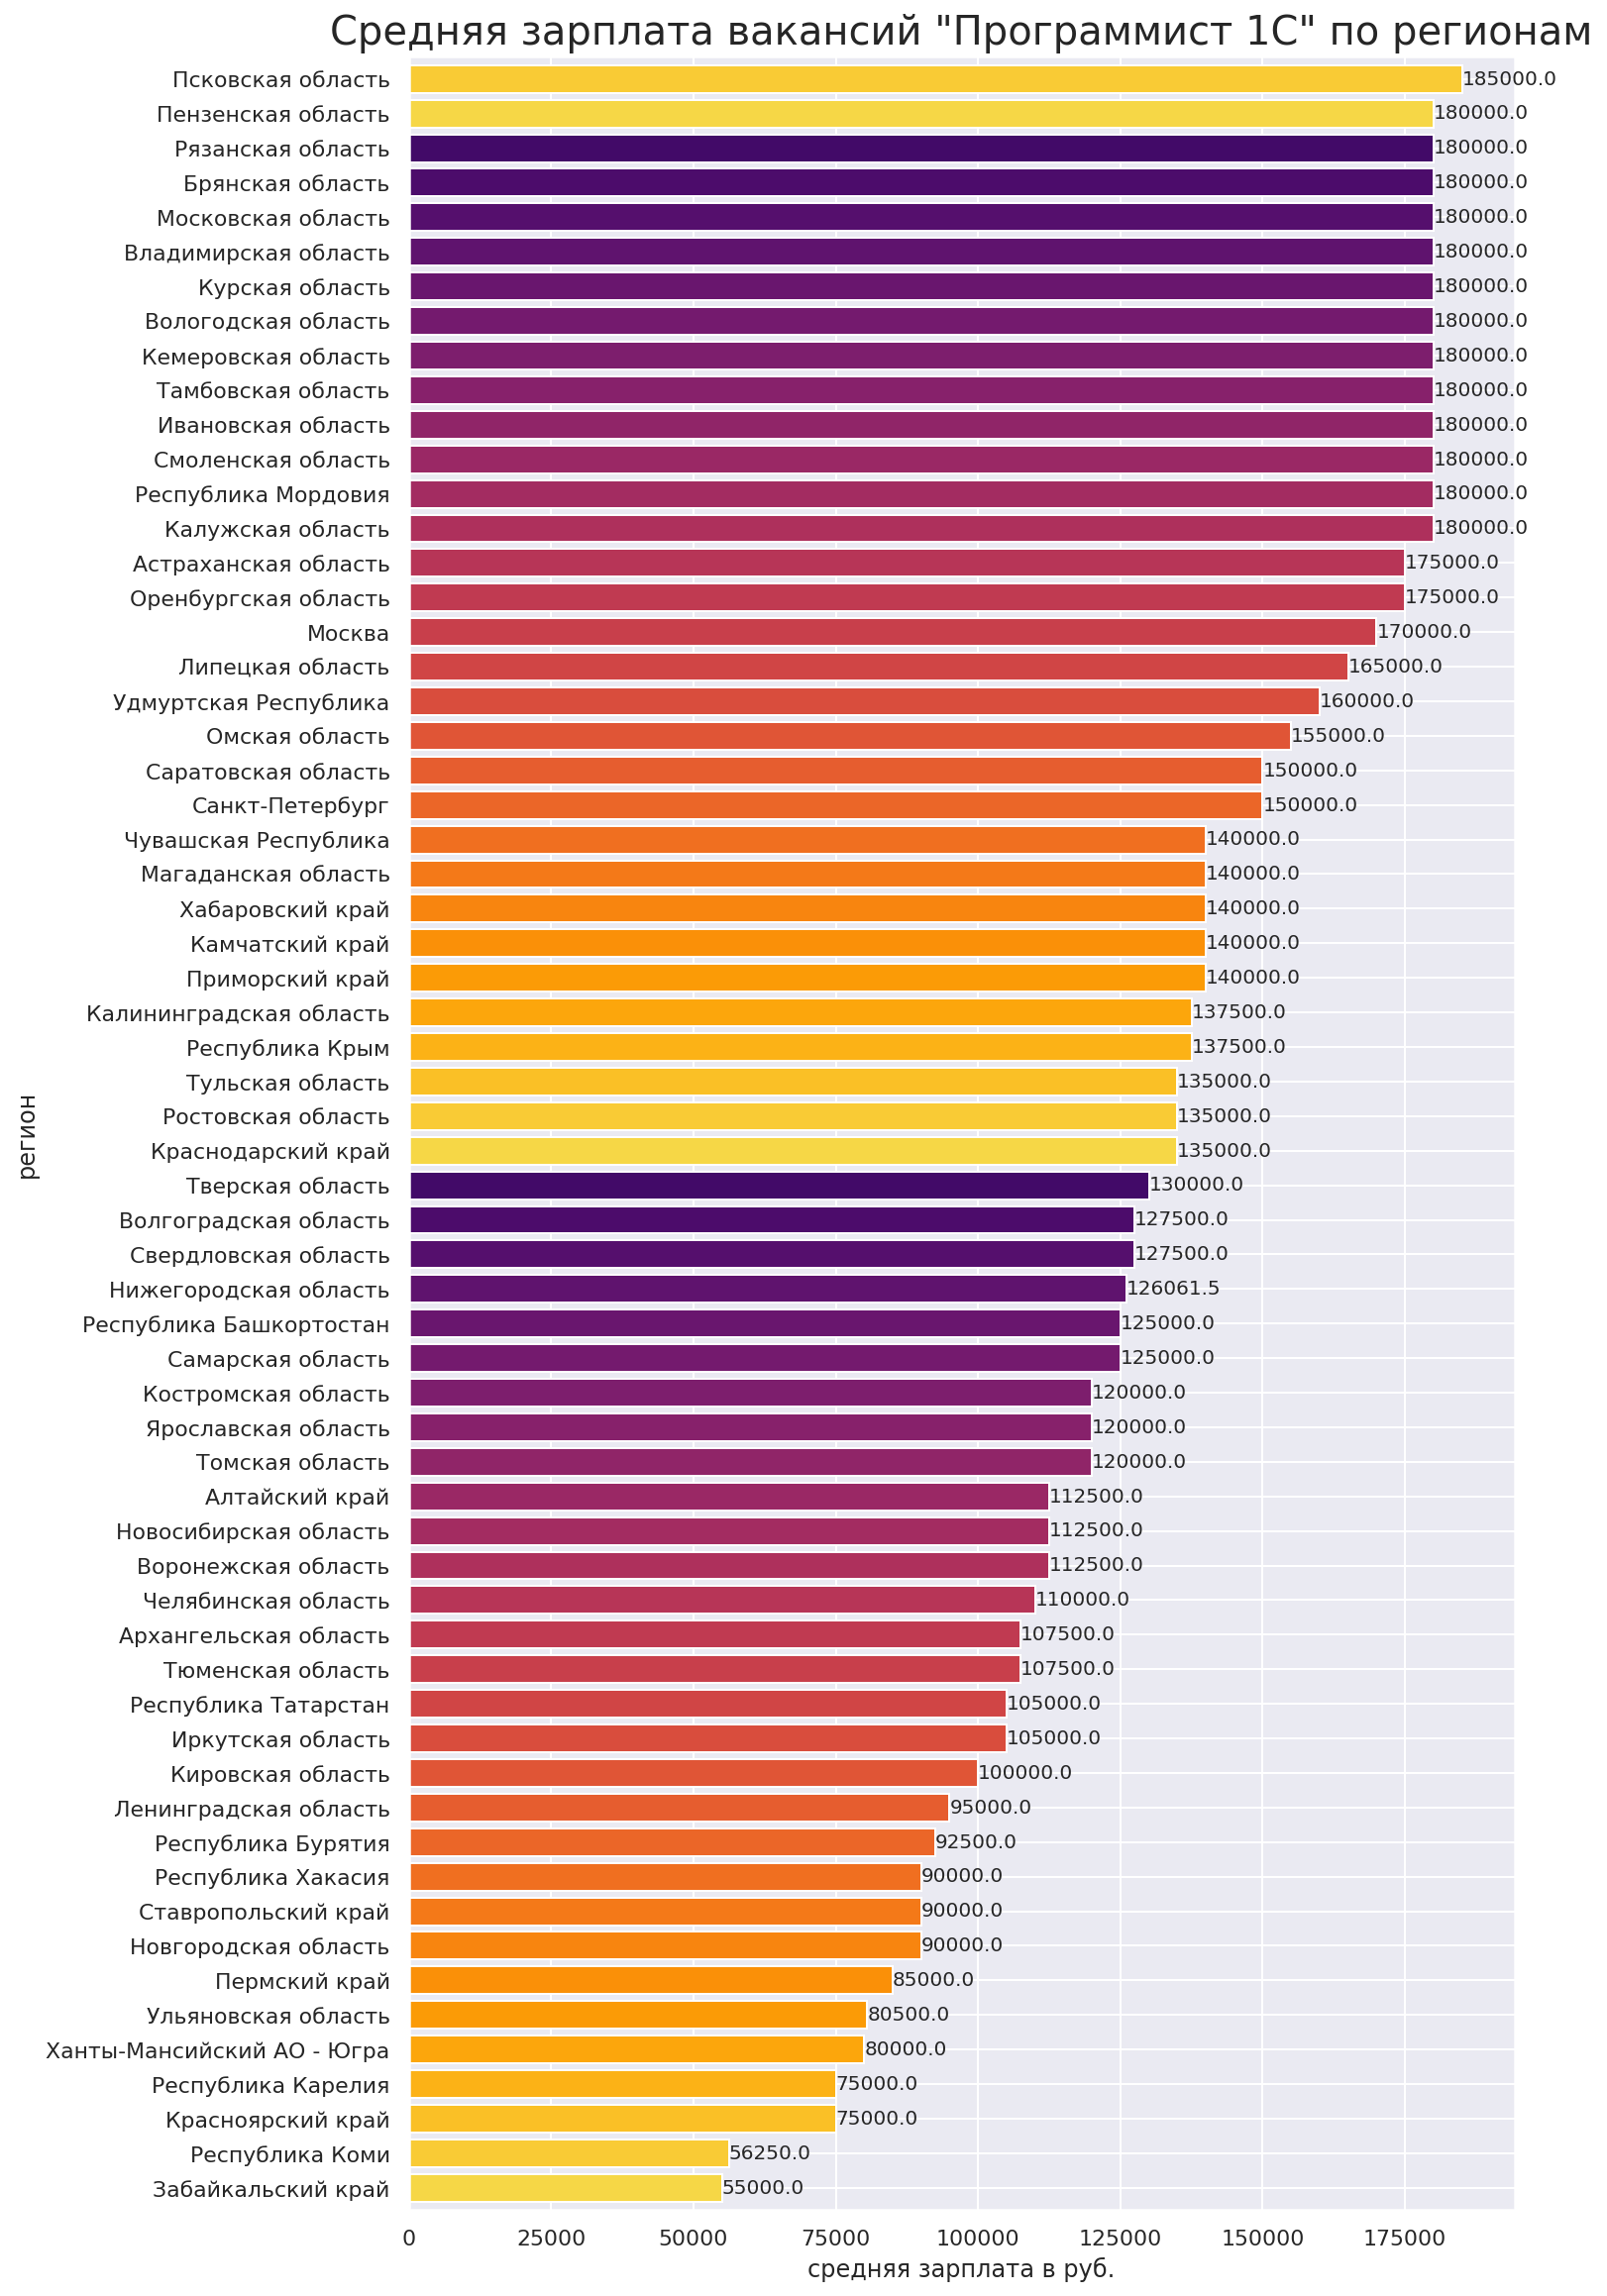

In [ ]:
color_1C = cm.inferno_r(np.linspace(.1,.8, 30))
region_salary_1C.plot(kind='barh', figsize =  (10, 20), color= color_1C, width=0.8)
for y,x in enumerate(region_salary_1C):
    plt.text(x+0.1,y,'%s' %round(x,1),va='center') # Здесь x находится спереди, y сзади, метка значения добавляется к x, а центр также центрируется по вертикали
# Отображение графики
plt.title('Средняя зарплата вакансий "Программист 1С" по регионам',fontsize = 20)
plt.xlabel('средняя зарплата в руб.')  
plt.ylabel('регион')
plt.show()

In [ ]:
dataset_salary_1C_2['средняя зарплата 1C'].describe()

count       520.000000
mean     134714.716346
std       47632.560269
min       35000.000000
25%       95000.000000
50%      133750.000000
75%      180000.000000
max      260000.000000
Name: средняя зарплата 1C, dtype: float64

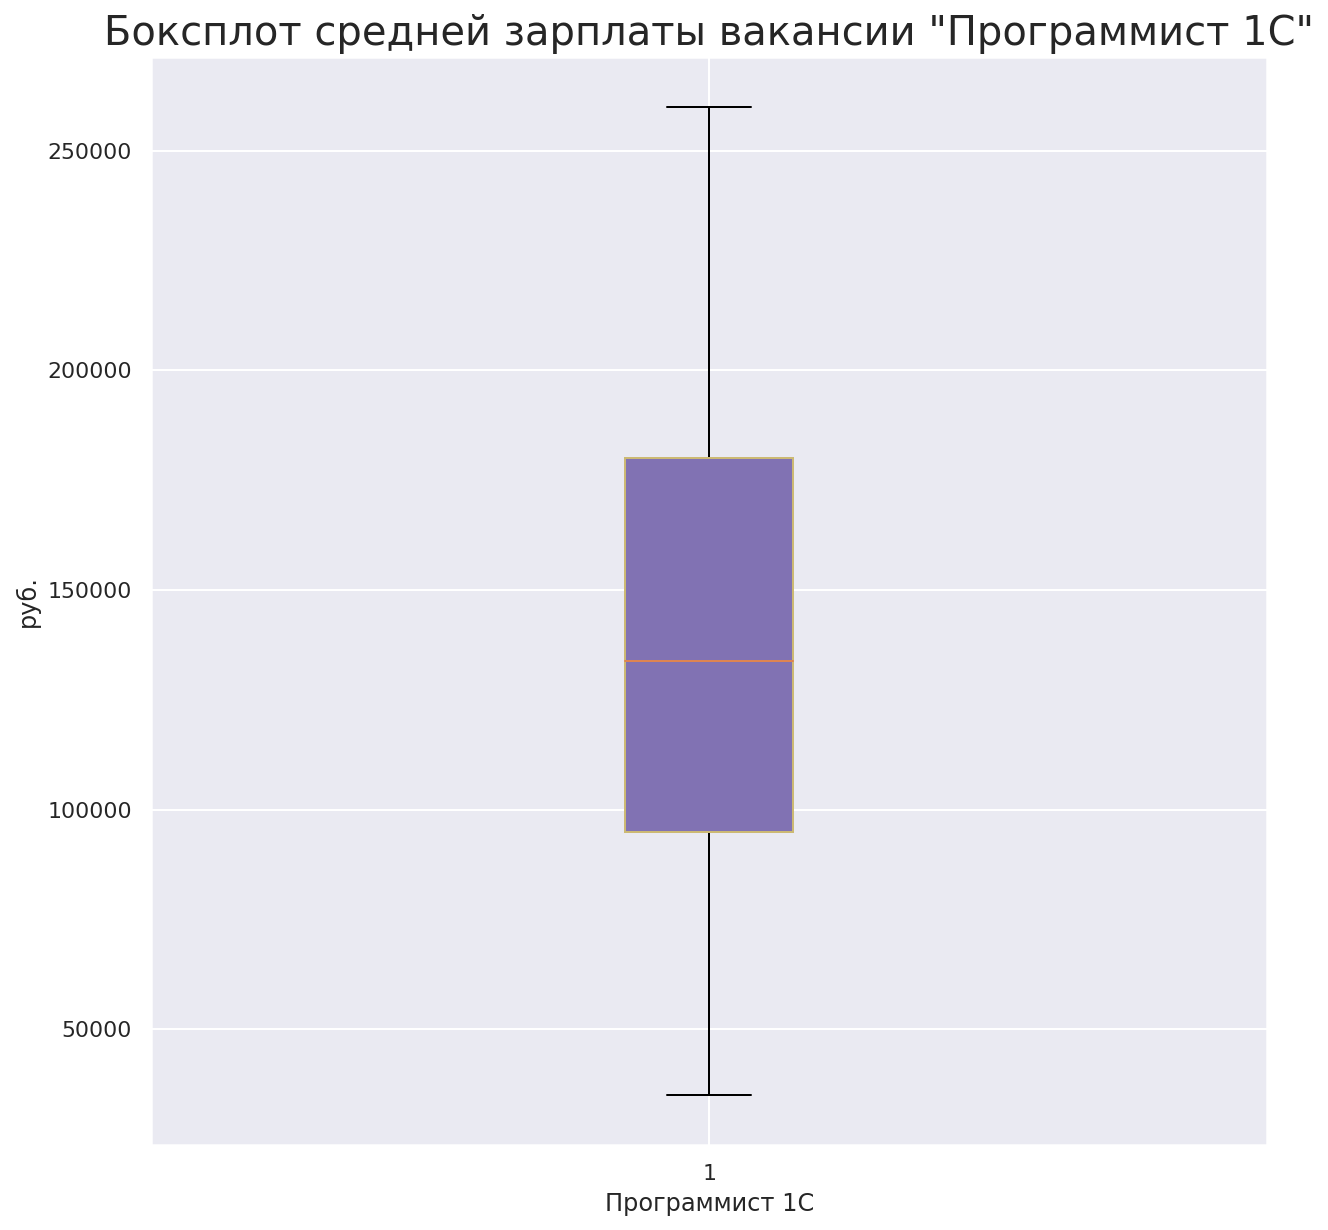

In [ ]:
plt.boxplot(dataset_salary_1C_2['средняя зарплата 1C'], figsize(10,10),patch_artist=True, boxprops=dict(facecolor='m', color='y'))
plt.title('Боксплот средней зарплаты вакансии "Программист 1С"',fontsize = 20)
plt.xlabel("Программист 1С")
plt.ylabel('руб.')
plt.show()

In [ ]:
# смотрим на средние зарплаты, какие преобладают
salary_1C = round(dataset_salary_1C_2['средняя зарплата 1C'].sort_values().value_counts(bins = 10))
salary_1C

(170000.0, 192500.0]    114
(102500.0, 125000.0]     79
(57500.0, 80000.0]       77
(80000.0, 102500.0]      65
(125000.0, 147500.0]     58
(147500.0, 170000.0]     56
(192500.0, 215000.0]     34
(34774.999, 57500.0]     19
(215000.0, 237500.0]     14
(237500.0, 260000.0]      4
Name: средняя зарплата 1C, dtype: int64

<function matplotlib.pyplot.show(*args, **kw)>

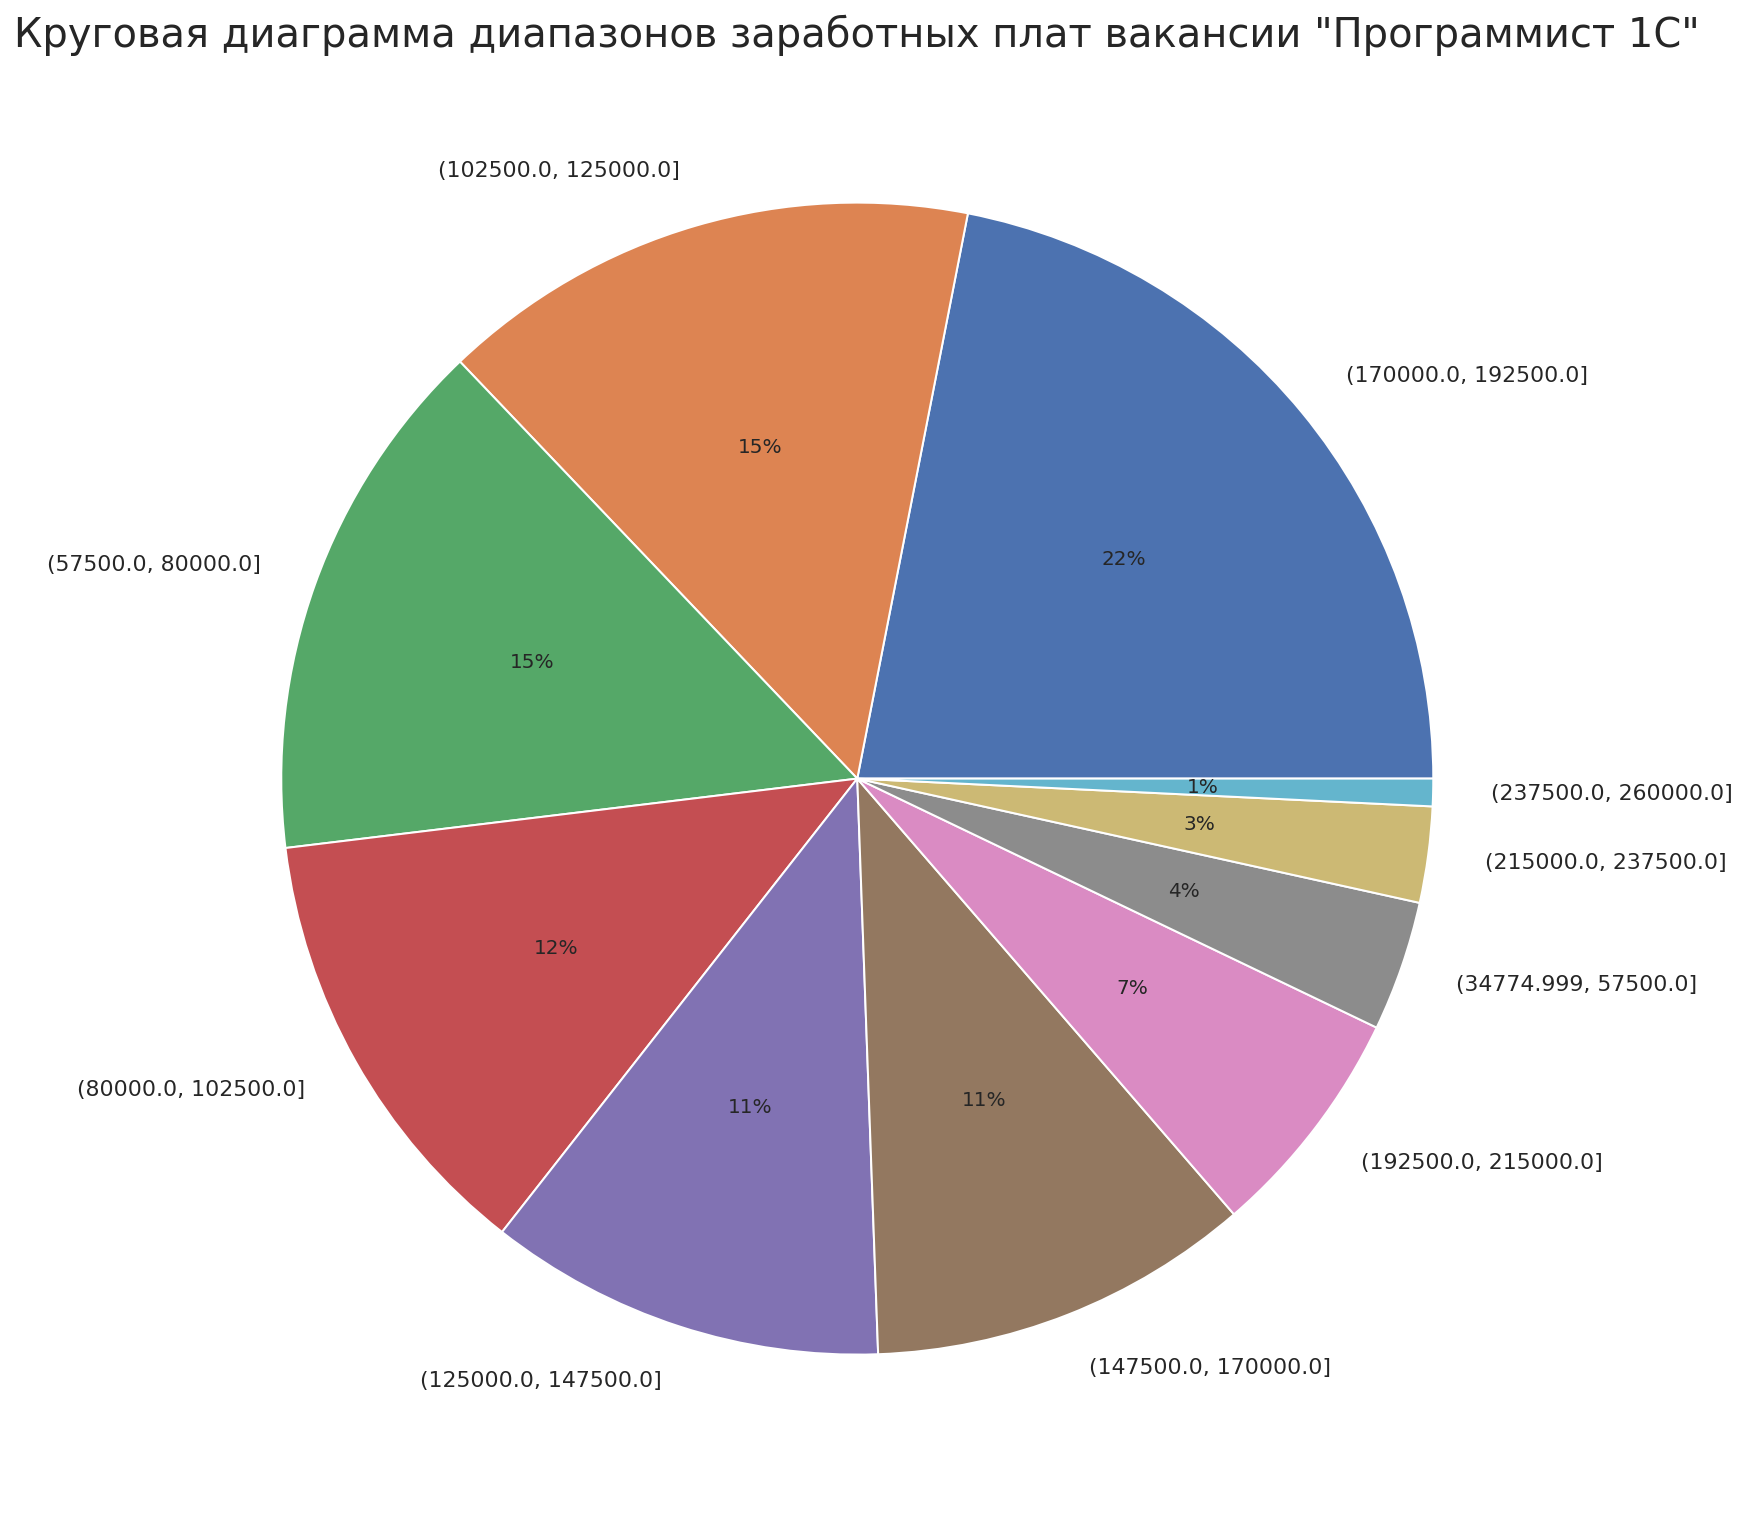

In [ ]:
plt.pie(salary_1C.values, labels = salary_1C.index, autopct='%1.0f%%')
plt.title('Круговая диаграмма диапазонов заработных плат вакансии "Программист 1С"', fontsize = 20)
plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=10.0)
plt.show

## Анализ зависимости зарплаты "Программиста 1С" от опыта работы

In [ ]:
salary_1C_op = round(dataset_salary_1C_2.groupby('Опыт работы')['средняя зарплата 1C'].mean().sort_values())
salary_1C_op

Опыт работы
Нет опыта              97639.0
От 1 года до 3 лет    113329.0
От 3 до 6 лет         156693.0
Более 6 лет           165000.0
Name: средняя зарплата 1C, dtype: float64

In [ ]:
# salary_1C_op.plot(kind = 'scatter', figsize = (8,8))

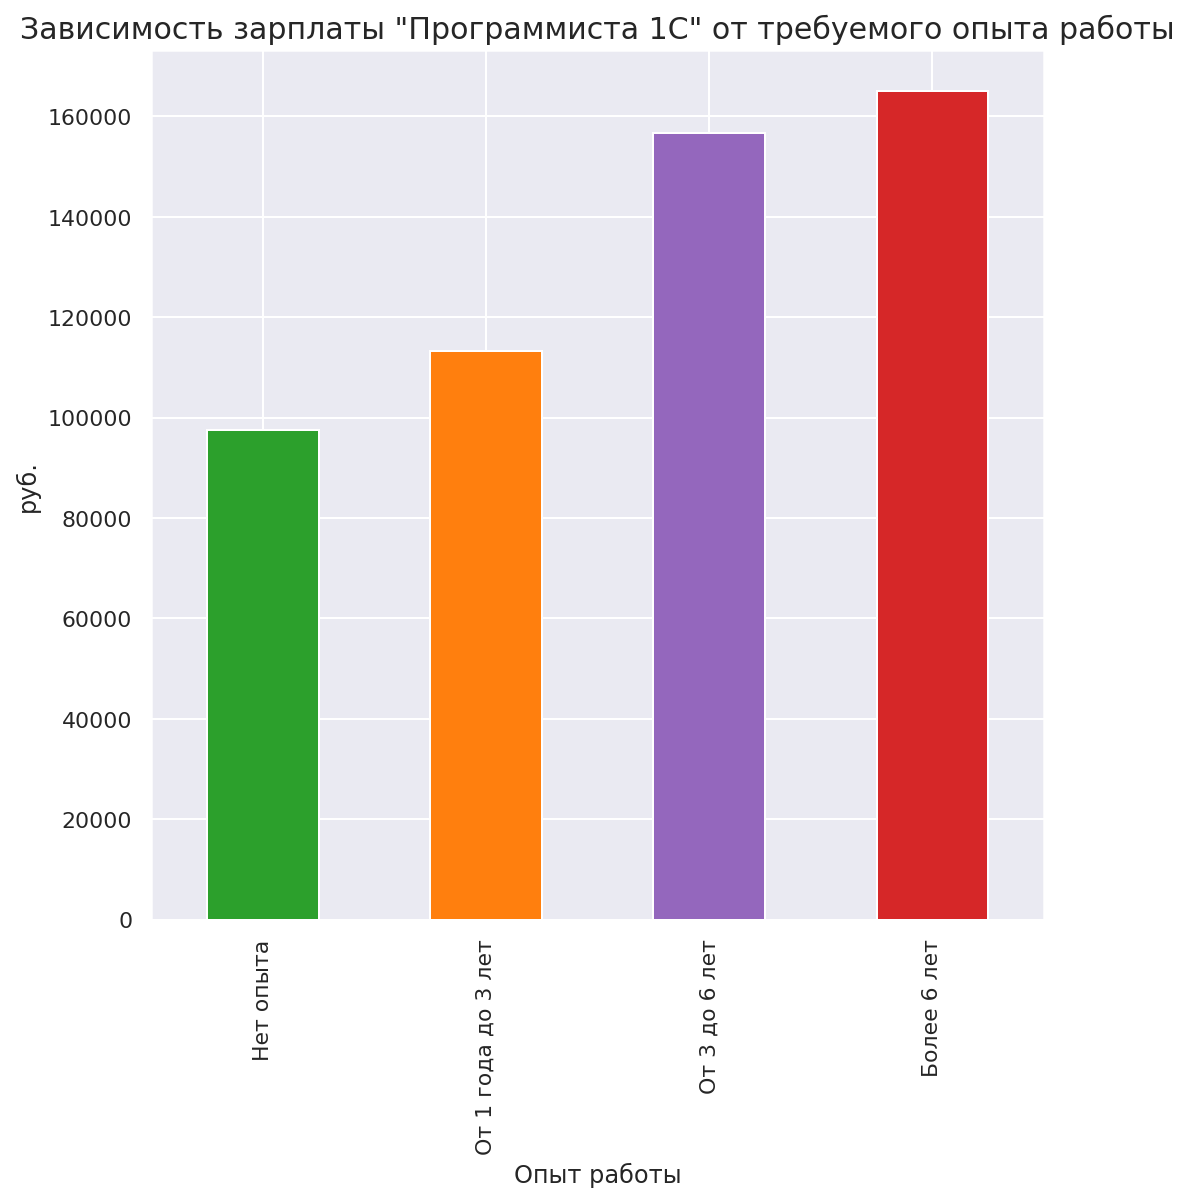

In [ ]:
salary_1C_op.plot(kind = 'bar', color = colors, figsize = (8,8))
plt.title('Зависимость зарплаты "Программиста 1С" от требуемого опыта работы', fontsize = 15)
plt.ylabel('руб.')
plt.show()

## Анализ распределения зарплат вакансии "Программист 1С" с учетом графика работы

In [ ]:
dataset_salary_1C_2['График работы'].astype('category').head()

180         Полный день
196         Полный день
220    Удаленная работа
449    Удаленная работа
40          Полный день
Name: График работы, dtype: category
Categories (3, object): ['Гибкий график', 'Полный день', 'Удаленная работа']

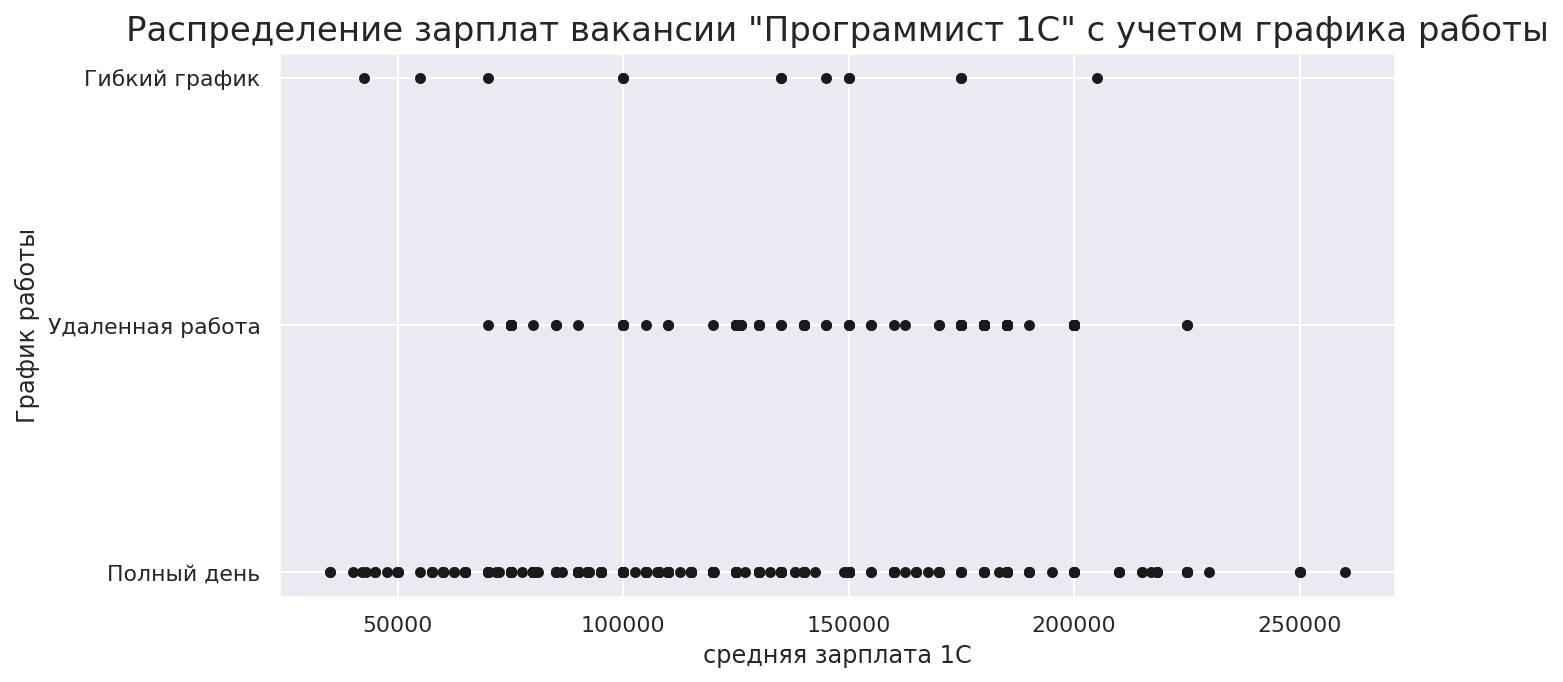

In [ ]:
dataset_salary_1C_2.plot('средняя зарплата 1C', 'График работы', kind = 'scatter', figsize = (10,5), color='k')
plt.title('Распределение зарплат вакансии "Программист 1С" с учетом графика работы', fontsize = 17)
plt.show()

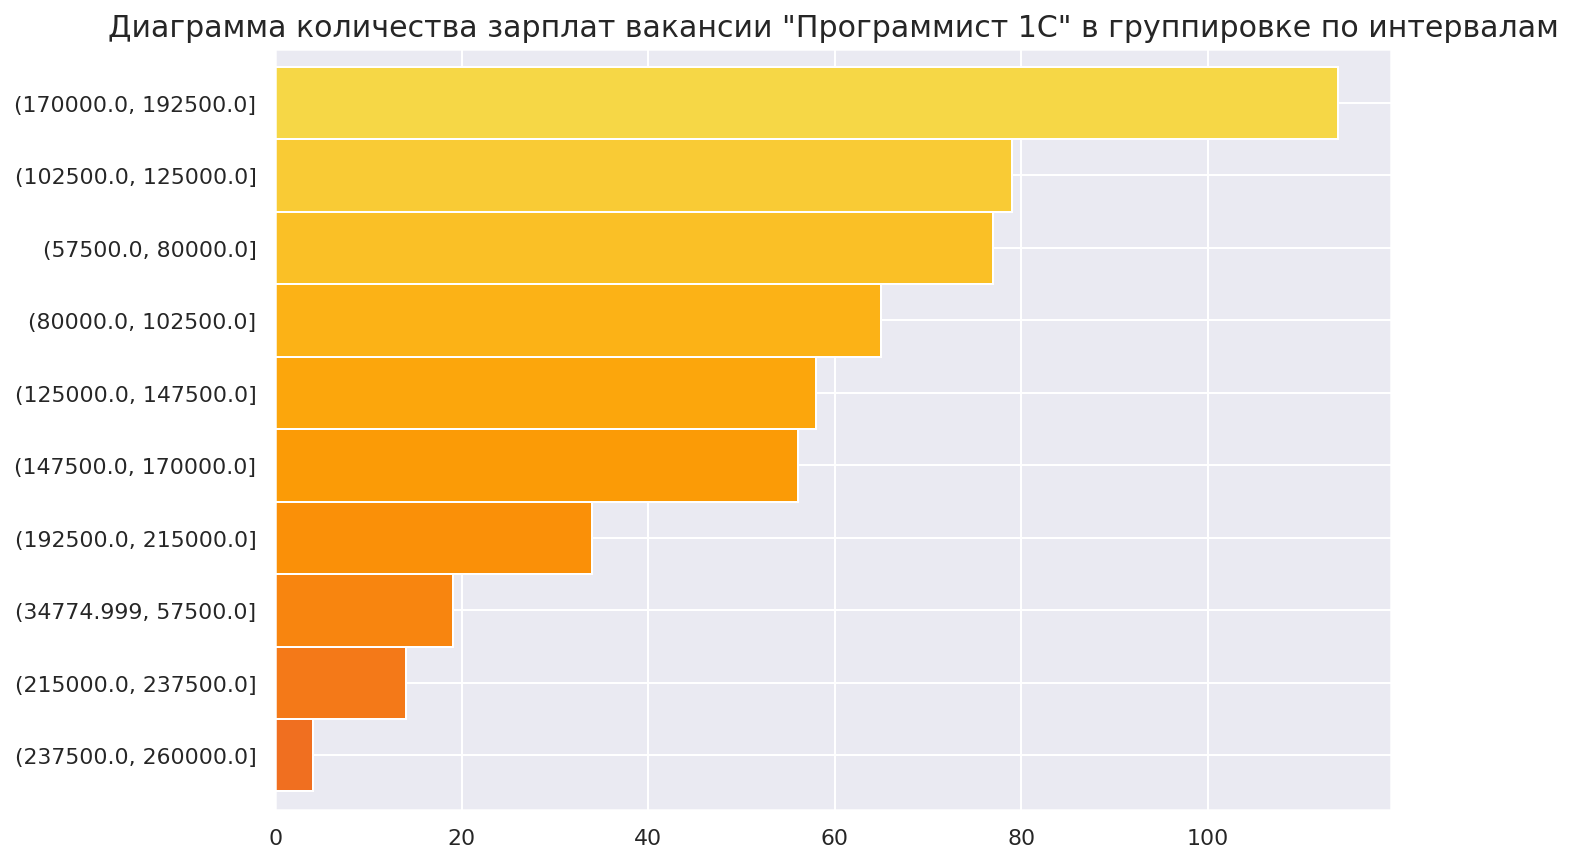

In [ ]:
dataset_salary_1C_2['средняя зарплата 1C'].value_counts(bins=10).plot(kind = "barh",stacked=True, width=1, color=color_1C, figsize =  (10, 7)).invert_yaxis()
plt.title('Диаграмма количества зарплат вакансии "Программист 1С" в группировке по интервалам', fontsize=15)
plt.show()

In [ ]:
# barh по зарплате с учётом графика, наглядно не красиво, поэтому перевели в bar
# salary_grafik = dataset_salary_1C_2.groupby('средняя зарплата 1C')['График работы'].value_counts().unstack()
# salary_grafik.plot(kind='bar',stacked=True, y = (['Полный день', 'Гибкий график', 'Удаленная работа']),rot=90, width=1, figsize =  (17, 10))
# plt.ylabel('количество')
# # for x,y in enumerate(salary_grafik):
# #     plt.text(x,y+0.1,'%s' %round(y,1),ha='center')
# plt.title('Диаграмма распределения средней зарплаты вакансии "Программист 1С" с учетом графика работы', fontsize = 15)
# plt.show()

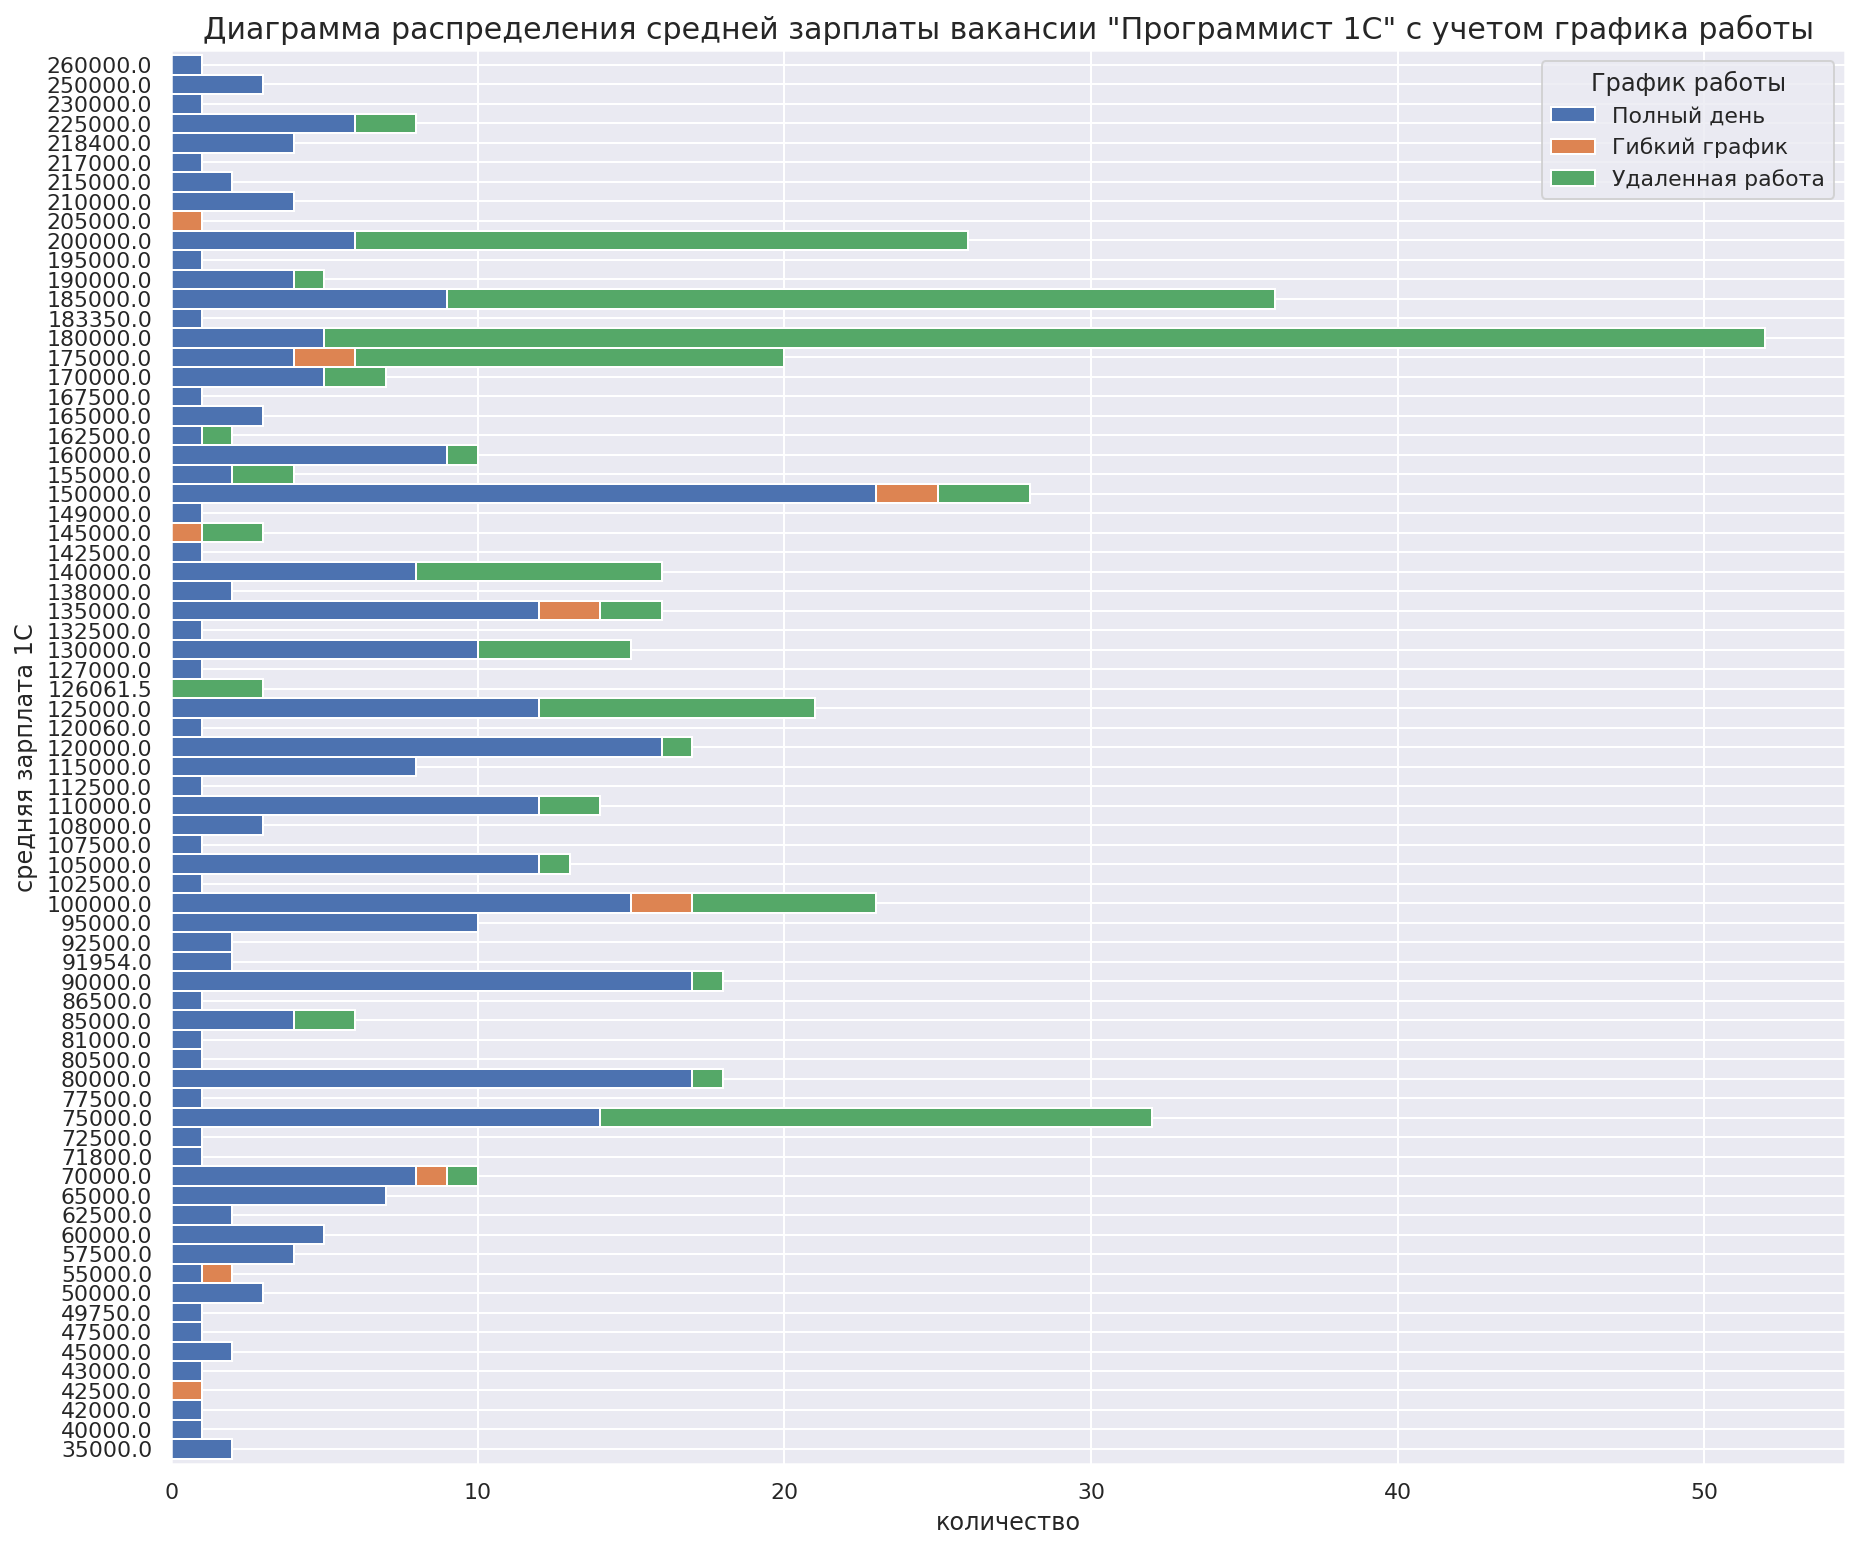

In [ ]:
#y = (['Полный день', 'Гибкий график', 'Удаленная работа'])
salary_grafik = dataset_salary_1C_2.groupby('средняя зарплата 1C')['График работы'].value_counts().unstack()
salary_grafik.plot(kind='barh',stacked=True, y = (['Полный день', 'Гибкий график', 'Удаленная работа']), width=1, figsize =  (15, 13))
plt.xlabel('количество')
plt.title('Диаграмма распределения средней зарплаты вакансии "Программист 1С" с учетом графика работы', fontsize = 15)
plt.show()

## Анализ ключевых навыков вакансии "Программист 1С"

In [ ]:
# подсчитаем количество лидирующих ключевых навыков
resu = dataset_1C['Ключевые навыки']
r = Counter(''.join(resu).split(','))
# сделаем сортировку и выведем первые 30 навыков
skills_1C = sorted(r.items(), key =  itemgetter(1), reverse = True)[:30]
skills_1C

[(' 1С программирование', 1091),
 (' 1С: Предприятие 8', 766),
 (' 1С: Зарплата и управление персоналом', 441),
 (' 1С: Бухгалтерия', 425),
 (' 1С: Документооборот', 365),
 (' 1С: Управление Торговлей', 347),
 (' 1С: Управление Производственным Предприятием', 191),
 (' Обновление конфигурации 1С', 189),
 (' 1С: Комплексная автоматизация', 166),
 (' ERP-системы на базе 1С', 154),
 (' 1C: Бухгалтерия', 127),
 (' MS SQL', 122),
 (' SQL', 106),
 (' 1C: Предприятие', 96),
 (' 1С: Управление предприятием', 95),
 (' Создание конфигурации 1С', 94),
 (' Ответственность', 93),
 (' Клиентоориентированность', 92),
 (' XML', 77),
 (' 1С: Торговля', 68),
 (' 1С: Розница', 66),
 (' 1С: Зарплата и кадры', 59),
 (' Удаленная работа', 47),
 (' MS SQL Server', 45),
 (' 1C ERP', 45),
 (' 1С: Производство', 45),
 (' Разработка технических заданий', 44),
 (' Работа в условиях многозадачности', 43),
 (' Работа с базами данных', 42),
 (' ERP', 41)]

In [ ]:
# делаем словарь таблицей, чтобы в дальнейшем нарисовать схемы и графики
skills_1C_pd = pd.DataFrame(skills_1C, columns = ['Навык', 'количество'])
skills_1C_pd

Навык  количество
0                     1С программирование        1091
1                       1С: Предприятие 8         766
2    1С: Зарплата и управление персоналом         441
3                         1С: Бухгалтерия         425
4                     1С: Документооборот         365
..                                    ...         ...
25                       1С: Производство          45
26         Разработка технических заданий          44
27      Работа в условиях многозадачности          43
28                 Работа с базами данных          42
29                                    ERP          41

[30 rows x 2 columns]

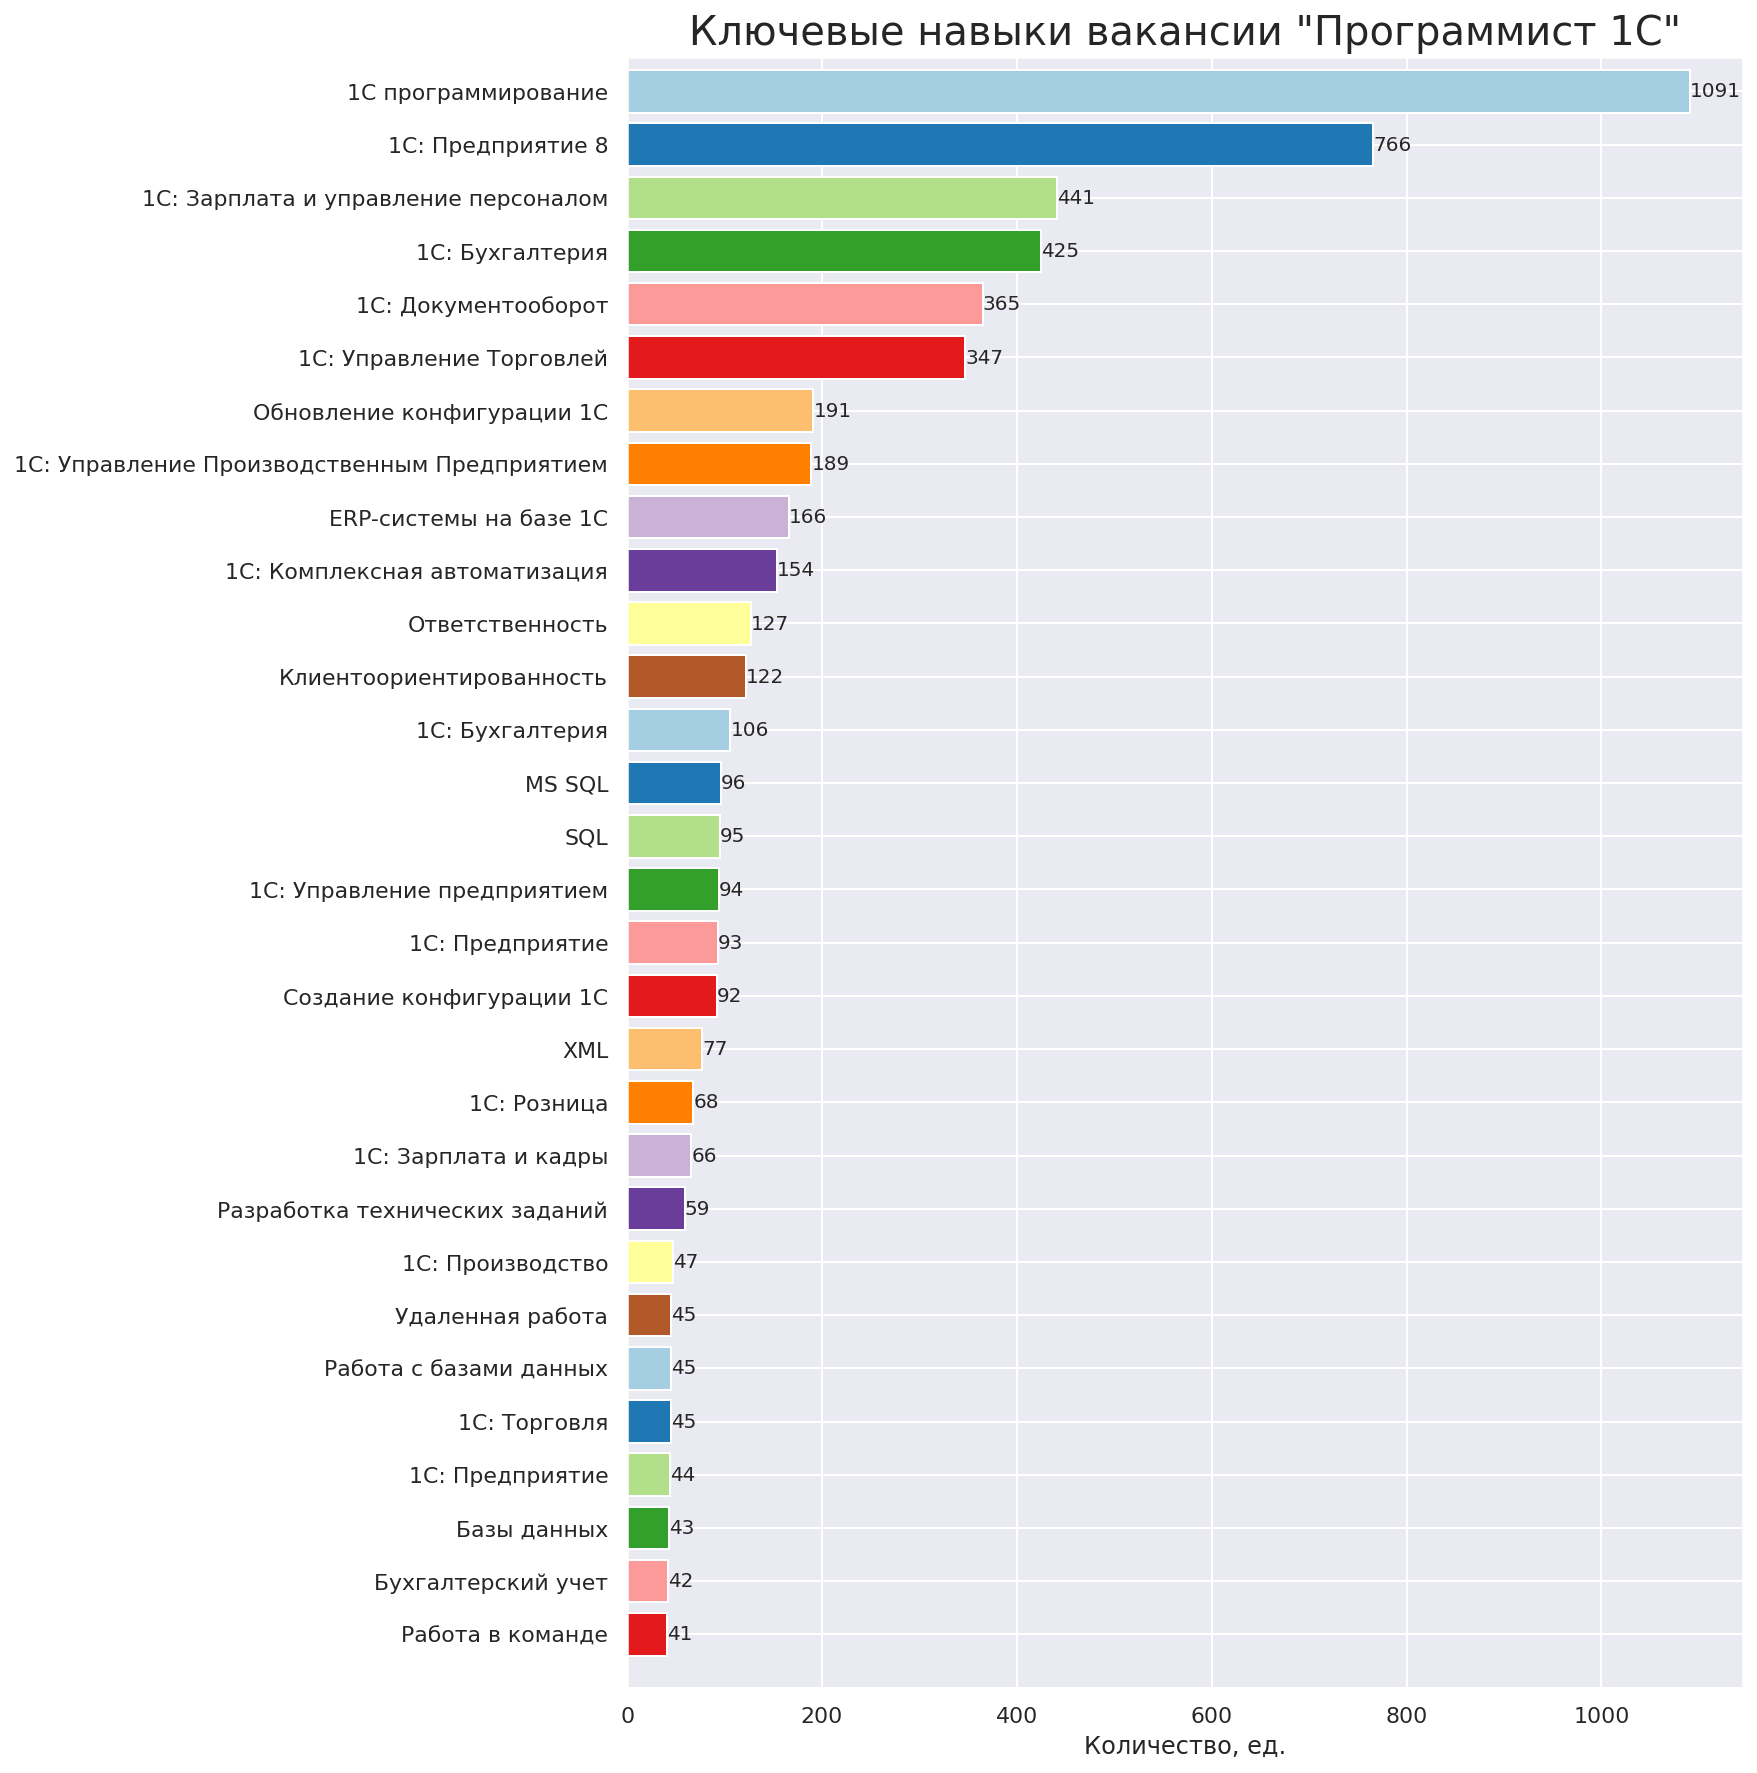

In [ ]:
from matplotlib.colors import get_named_colors_mapping
# color=(.1, .2,.3,.4)
# color=plt.cm.Paired(np.arange(len(skills_1C_pd)))
# ['b','g','r','c','m','y','g']

skills_1C_pd['количество'].plot(kind = 'barh', figsize =  (10, 15), color=plt.cm.Paired(np.arange(len(skills_1C_pd['количество'])))[:12],
                                width=0.8).invert_yaxis()

for y,x in enumerate(skills_1C_pd['количество']):
    plt.text(x+0.1,y,'%s' %round(x,1),va='center') # Здесь x находится спереди, y сзади, метка значения добавляется к x, а центр также центрируется по вертикали
# Отображение графики    
plt.title('Ключевые навыки вакансии "Программист 1С"',fontsize = 20)
plt.xlabel('Количество, ед.')

plt.yticks(range(31),['1С программирование','1С: Предприятие 8','1С: Зарплата и управление персоналом','1С: Бухгалтерия','1С: Документооборот',
            '1С: Управление Торговлей','Обновление конфигурации 1С','1С: Управление Производственным Предприятием','ERP-системы на базе 1С',
            '1С: Комплексная автоматизация','Ответственность','Клиентоориентированность','1C: Бухгалтерия','MS SQL','SQL',
            '1С: Управление предприятием','1C: Предприятие','Создание конфигурации 1С','XML','1С: Розница','1С: Зарплата и кадры',
            'Разработка технических заданий','1С: Производство','Удаленная работа','Работа с базами данных','1С: Торговля',
            '1С: Предприятие','Базы данных','Бухгалтерский учет','Работа в команде'])
plt.show()

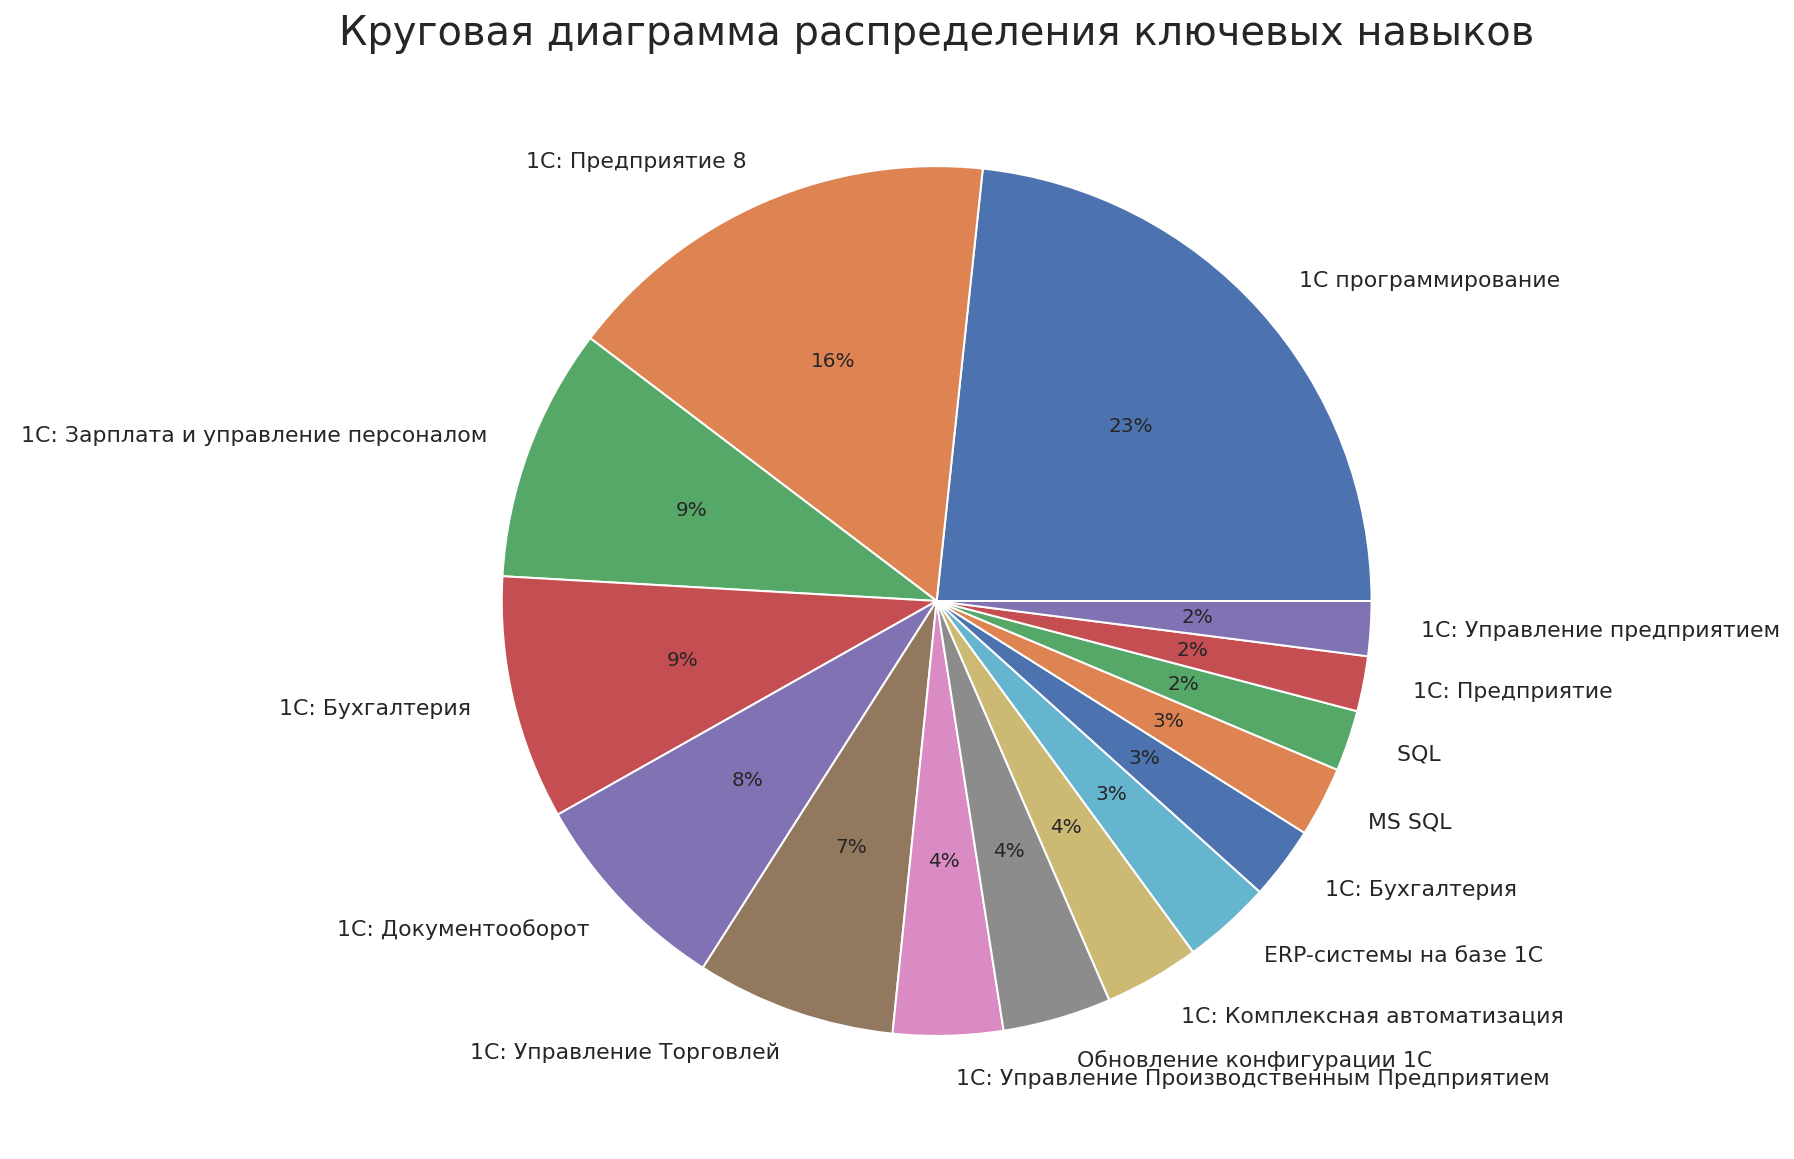

In [ ]:
# смотрим процентное соотношение навыков в общем количестве навыков
plt.pie(skills_1C_pd['количество'][:15].values, labels = skills_1C_pd['Навык'][:15], autopct='%1.0f%%')
plt.title('Круговая диаграмма распределения ключевых навыков', fontsize = 20)
plt.show()

# **РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ С САЙТОВ SKILLBOX.RU И STEPIC.ORG**

## ЗАГРУЖАЕМ ИНФОРМАЦИЮ ПО КУРСАМ С САЙТА SKILLBOX!


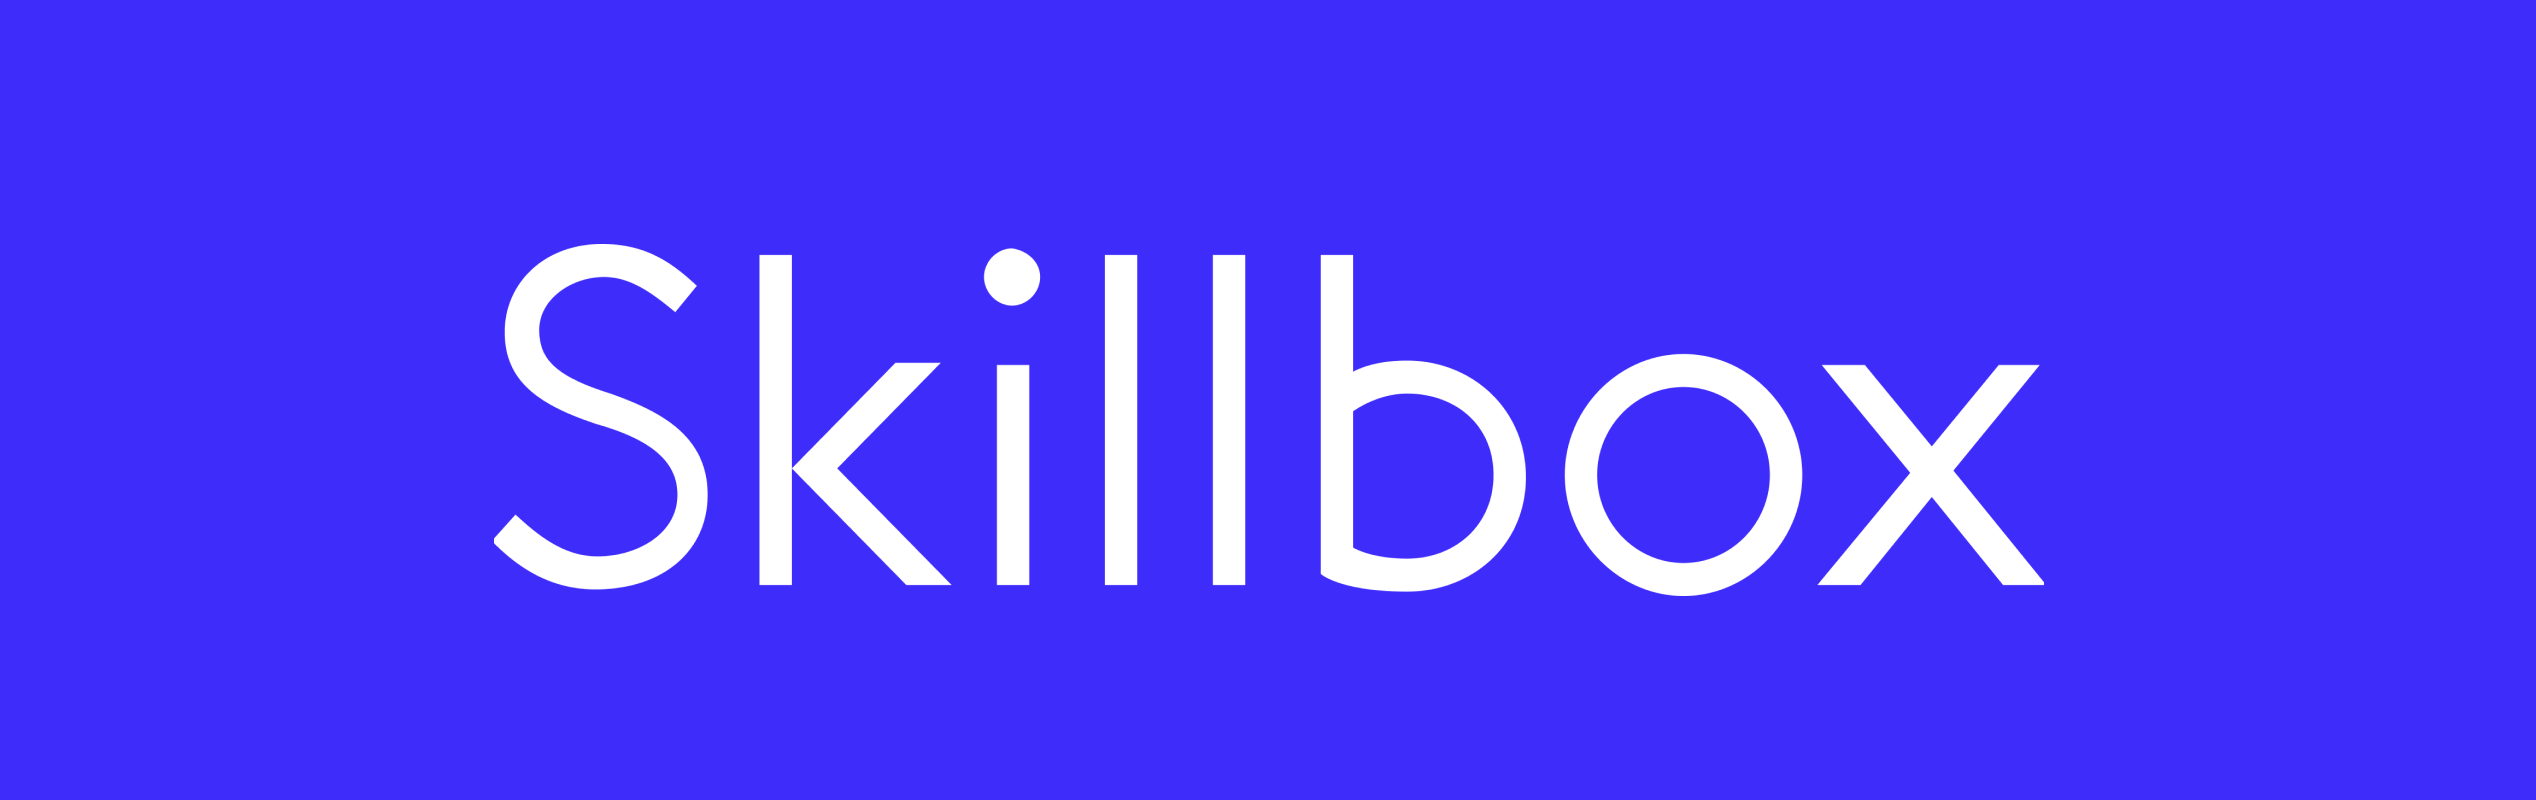

## Просматриваем информацию очищаем и создаём новый столбец, **"стоимость курса"**

In [ ]:
dataset_skillbox = pd.read_csv("Skillbox_new.csv")

In [ ]:
dataset_skillbox.head(5)

название                                                url  \
0    Python-разработчик      https://skillbox.ru/course/profession-python/   
1  Графический дизайнер  https://skillbox.ru/course/profession-graphdes...   
2       Бизнес-аналитик  https://skillbox.ru/course/profession-business...   
3        3D-дженералист          https://skillbox.ru/course/3d-generalist/   
4      Режиссёр монтажа            https://skillbox.ru/course/film-editor/   

   срок обучения в месяцах                                  чему вы научитесь  \
0                       12  Создавать простые и сложные модульные программ...   
1                       24  Создавать графику для брендов\nНаучитесь работ...   
2                       13  Рассчитывать бизнес-модель\nРазберётесь в спец...   
3                       24  Настраивать свет и тени для моделиСоздавать Ha...   
4                       12  Работать в Adobe Premiere Pro\nИзучите инструм...   

   цена  гарантия трудоустройства  
0  5987                         1  
1  4814                         0  
2  4625                         1  
3  6287                         0  
4  7859                         0

In [ ]:
def clear(i):
  try:
    i = re.sub(r'\<[^>]*\>', '', i)
    i = re.sub('\s+', ' ', i)
    return i
  except:
    return i

In [ ]:
dataset_skillbox['чему вы научитесь'].iloc[3]

'Настраивать свет и тени для моделиСоздавать Hard Surface моделиСоздавать модели в Houdini, Autodesk Maya, Blender и ZBrushРаботать с текстурами, формой и цветом моделиРеалистично передавать анатомию персонажаАнимировать объекты и персонажейДелать процедурную анимациюУверенно работать в PhotoshopСоздавать стилизованные и реалистичные текстуры в Substance Painter'

In [ ]:
dataset_skillbox['чему вы научитесь'] = dataset_skillbox['чему вы научитесь'].apply(clear)
dataset_skillbox['чему вы научитесь'].head(5)

0    Создавать простые и сложные модульные программ...
1    Создавать графику для брендов Научитесь работа...
2    Рассчитывать бизнес-модель Разберётесь в специ...
3    Настраивать свет и тени для моделиСоздавать Ha...
4    Работать в Adobe Premiere Pro Изучите инструме...
Name: чему вы научитесь, dtype: object

In [ ]:
dataset_skillbox.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   название                  152 non-null    object
 1   url                       152 non-null    object
 2   срок обучения в месяцах   152 non-null    int64 
 3   чему вы научитесь         152 non-null    object
 4   цена                      152 non-null    int64 
 5   гарантия трудоустройства  152 non-null    int64 
dtypes: int64(3), object(3)
memory usage: 7.2+ KB


In [ ]:
dataset_skillbox['стоимость курса'] = dataset_skillbox['срок обучения в месяцах']*dataset_skillbox['цена']

In [ ]:
dataset_skillbox.head(5)

название                                                url  \
0    Python-разработчик      https://skillbox.ru/course/profession-python/   
1  Графический дизайнер  https://skillbox.ru/course/profession-graphdes...   
2       Бизнес-аналитик  https://skillbox.ru/course/profession-business...   
3        3D-дженералист          https://skillbox.ru/course/3d-generalist/   
4      Режиссёр монтажа            https://skillbox.ru/course/film-editor/   

   срок обучения в месяцах                                  чему вы научитесь  \
0                       12  Создавать простые и сложные модульные программ...   
1                       24  Создавать графику для брендов Научитесь работа...   
2                       13  Рассчитывать бизнес-модель Разберётесь в специ...   
3                       24  Настраивать свет и тени для моделиСоздавать Ha...   
4                       12  Работать в Adobe Premiere Pro Изучите инструме...   

   цена  гарантия трудоустройства  стоимость курса  
0  5987                         1            71844  
1  4814                         0           115536  
2  4625                         1            60125  
3  6287                         0           150888  
4  7859                         0            94308

In [ ]:
dataset_skillbox.to_excel('Skillbox_exel.xlsx')

## Анализ

In [ ]:
round(dataset_skillbox['срок обучения в месяцах'].mean())

13

рассчитав медиана мы узнали, что средний срок обучения по профессиям составляет 13 месяцев

In [ ]:
round(dataset_skillbox['стоимость курса'].describe())

count       152.0
mean      67362.0
std       35026.0
min        4152.0
25%       44196.0
50%       58050.0
75%       80730.0
max      177288.0
Name: стоимость курса, dtype: float64

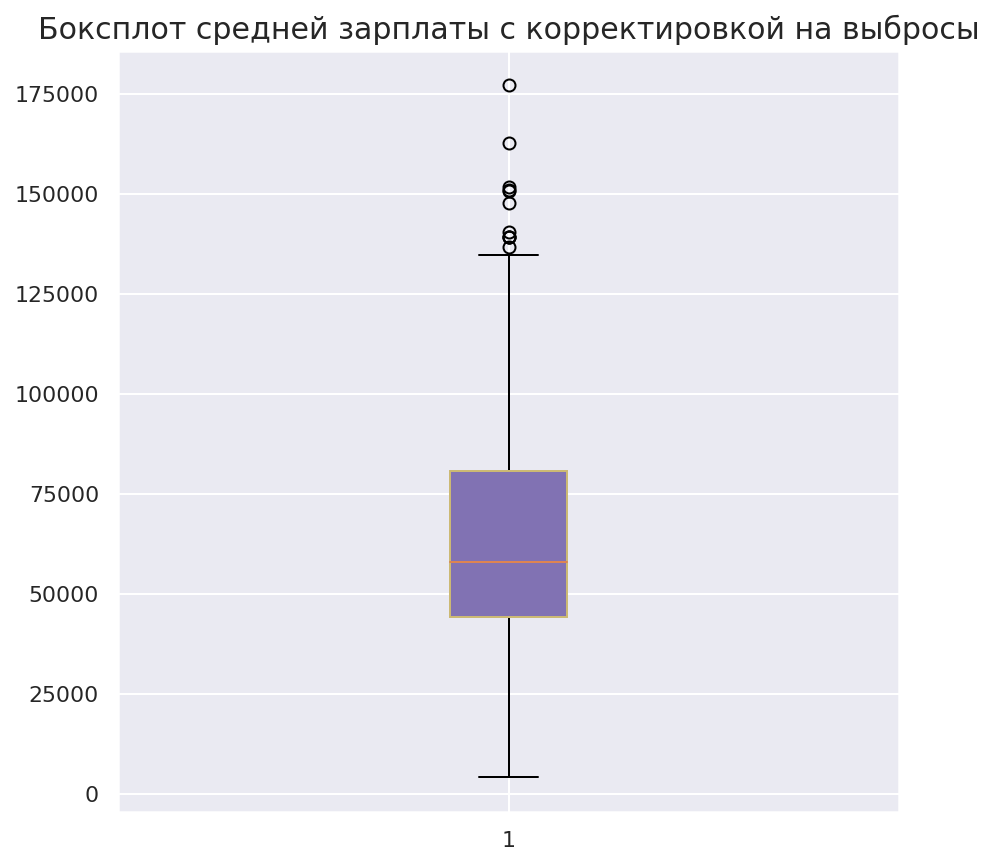

In [ ]:
plt.boxplot(dataset_skillbox['стоимость курса'], figsize(7,7),patch_artist=True, boxprops=dict(facecolor='m', color='y'))
plt.title('Боксплот средней зарплаты c корректировкой на выбросы',fontsize = 15)
plt.show()

Наиболее свойственная цена на профессии со skillbox в района от 44 до 80 тыс.руб. со средним сроком обучения 13 месяцев

Графически посмотрим на цену обучения

In [ ]:
# dataset_skillbox['срок обучения в месяцах'] = dataset_skillbox['срок обучения в месяцах'].astype("category")

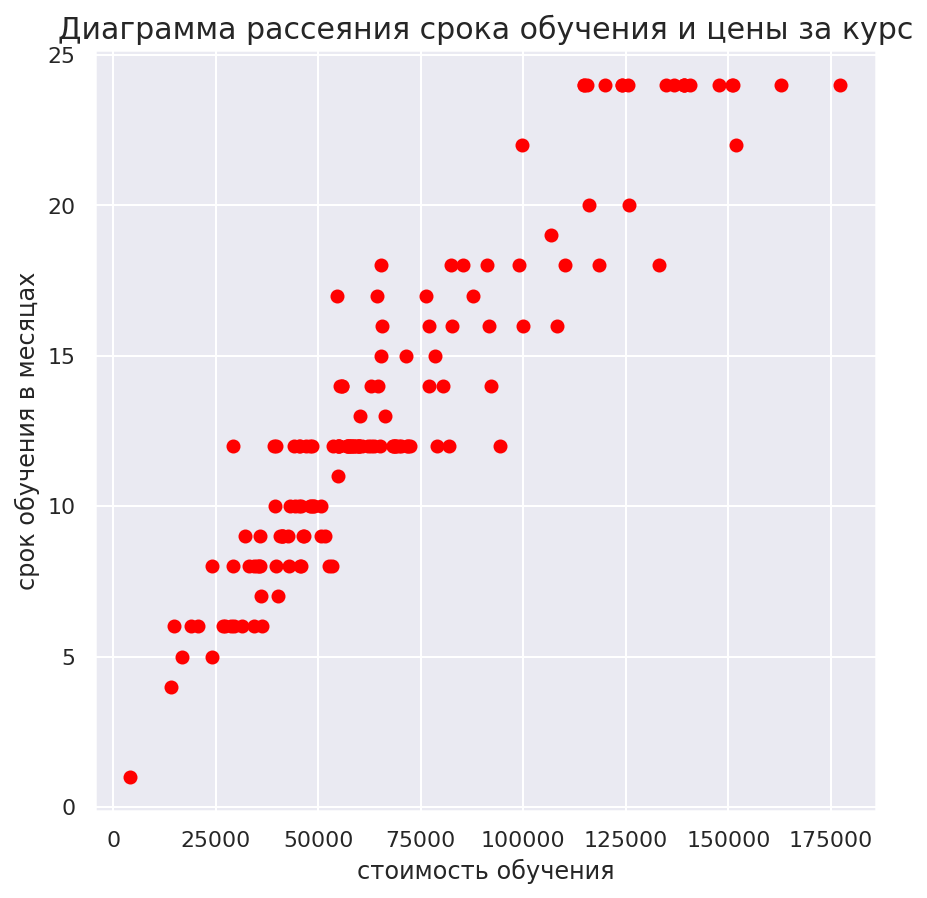

In [ ]:
plt.scatter(dataset_skillbox['стоимость курса'],dataset_skillbox['срок обучения в месяцах'], color='red')
plt.title('Диаграмма рассеяния срока обучения и цены за курс',fontsize = 15)
plt.xlabel('стоимость обучения')
plt.ylabel('срок обучения в месяцах')
plt.show()

На диаграмме рассеяния видна прямая связь срока обучения и стоимости курса. Чем больше по времени обучение, тем соответственно выше стоимость.

## ЗАГРУЖАЕМ ИНФОРМАЦИЮ ПОЛУЧЕННУЮ НА STEPIC.ORG!

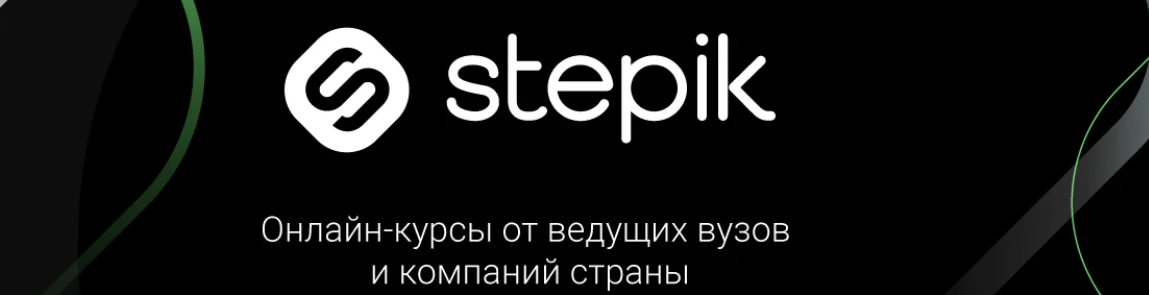

## Загрузка данных

загружаем данные, которые были получены с помощью BeautifulSoup

In [ ]:
dataset_learns_stepic = pd.read_excel("/content/курсы_step_1_до_120_тыс.xlsx", index_col = 0) 

In [ ]:
dataset_learns_stepic.head(5)

название курса                      ссылка на курс  \
0           Epic Guide to Stepik   https://stepik.org/course/1/promo   
1           Python for Beginners   https://stepik.org/course/5/promo   
2  Программирование на языке C++   https://stepik.org/course/7/promo   
3         Python for Programmers  https://stepik.org/course/10/promo   
4                    City Design  https://stepik.org/course/43/promo   

   количество учащихся  
0                 4503  
1                 6923  
2               115128  
3                 5935  
4                 7382

от сюда возьмем только id, чтобы через них скачать данные через api

загружаем данные, которые были получены с помощью API stepic.org

In [ ]:
dataset_stepic = pd.read_excel('/content/stepic_api_obnovl (2).xlsx', index_col=0)

In [ ]:
dataset_stepic.head(3)

title  \
id                                  
5            Python for Beginners   
7   Программирование на языке C++   
10         Python for Programmers   

                                              summary            workload  \
id                                                                          
5                                                 NaN                 NaN   
7   Данный базовый курс повествует об основных сре...  5-7 часов в неделю   
10        Based on the presentation by Alex Martelli.                 NaN   

                                       intro  \
id                                             
5                                        NaN   
7   https://player.vimeo.com/video/102503011   
10                                       NaN   

                               course_format          target_audience  \
id                                                                      
5                                        NaN                      NaN   
7   Видео-лекции, задачи на программирование  Студенты младших курсов   
10                                       NaN                      NaN   

                         certificate_cover_org  is_certificate_issued  \
id                                                                      
5                                          NaN                      0   
7   /media/courses/7/certificate_cover_org.png                      1   
10                                         NaN                      0   

    is_certificate_auto_issued  certificate_regular_threshold  ...  \
id                                                             ...   
5                            0                            0.0  ...   
7                            1                           90.0  ...   
10                           0                            0.0  ...   

    actions.can_be_bought.enabled actions.can_be_deleted.enabled  \
id                                                                 
5                               0                              0   
7                               0                              0   
10                              0                              0   

   intro_video.id intro_video.duration intro_video.status  \
id                                                          
5             NaN                  NaN                NaN   
7          7717.0                 51.0              ready   
10            NaN                  NaN                NaN   

   intro_video.upload_date  intro_video.filename  \
id                                                 
5                      NaN                   NaN   
7     2016-04-07T15:03:45Z                   NaN   
10                     NaN                   NaN   

    options.course_preview.preview_lesson_id  options.can_add_learners  \
id                                                                       
5                                        NaN                       NaN   
7                                        NaN                       NaN   
10                                       NaN                       NaN   

    options.actions.manage_learners  
id                                   
5                               NaN  
7                               NaN  
10                              NaN  

[3 rows x 112 columns]

In [ ]:
dataset_stepic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 740 entries, 5 to 119495
Columns: 112 entries, title to options.actions.manage_learners
dtypes: float64(20), int64(44), object(48)
memory usage: 653.3+ KB


отберём только самые нужные столбцы в датасете

In [ ]:
dataset_stepic = dataset_stepic[['title','course_format', 'price', 'summary', 'workload','is_certificate_issued','learners_count', 'certificates_count',
                'lessons_count', 'quizzes_count', 'challenges_count','requirements', 'description',
                  'readiness', 'difficulty', 'acquired_skills', 'course_type']]
dataset_stepic.head(5)

title                             course_format  \
id                                                                             
5             Python for Beginners                                       NaN   
7    Программирование на языке C++  Видео-лекции, задачи на программирование   
10          Python for Programmers                                       NaN   
47  Core Concepts in Data Analysis                                       NaN   
61       Bioinformatics Algorithms                                       NaN   

    price                                            summary  \
id                                                             
5     NaN                                                NaN   
7     NaN  Данный базовый курс повествует об основных сре...   
10    NaN        Based on the presentation by Alex Martelli.   
47    NaN              https://www.coursera.org/course/datan   
61    NaN  <a href="https://class.coursera.org/bioinforma...   

              workload  is_certificate_issued  learners_count  \
id                                                              
5                  NaN                      0            6931   
7   5-7 часов в неделю                      1          117843   
10                 NaN                      0            5934   
47                 NaN                      0           12004   
61                 NaN                      0           13012   

    certificates_count  lessons_count  quizzes_count  challenges_count  \
id                                                                       
5                    0              6             15                 5   
7                 8097             41             28                45   
10                   0              8             11                 4   
47                   0              7              0                 7   
61                   0            118             43                79   

                                         requirements  \
id                                                      
5                                                 NaN   
7   Курс рассчитан на студентов, владеющих синтакс...   
10                                                NaN   
47                                                NaN   
61                                                NaN   

                                          description  readiness difficulty  \
id                                                                            
5                                                 NaN        0.6        NaN   
7   <p> Программа курса основана на программах кур...        1.0        NaN   
10  Based on <a href="http://www.aleax.it/goo_py4p...        0.7        NaN   
47                                                NaN        0.4        NaN   
61                                                NaN        0.9        NaN   

   acquired_skills course_type  
id                              
5              NaN       basic  
7              NaN  enterprise  
10             NaN       basic  
47             NaN       basic  
61             NaN  enterprise

In [ ]:
dataset_stepic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 740 entries, 5 to 119495
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  739 non-null    object 
 1   course_format          56 non-null     object 
 2   price                  122 non-null    float64
 3   summary                612 non-null    object 
 4   workload               317 non-null    object 
 5   is_certificate_issued  740 non-null    int64  
 6   learners_count         740 non-null    int64  
 7   certificates_count     740 non-null    int64  
 8   lessons_count          740 non-null    int64  
 9   quizzes_count          740 non-null    int64  
 10  challenges_count       740 non-null    int64  
 11  requirements           359 non-null    object 
 12  description            588 non-null    object 
 13  readiness              740 non-null    float64
 14  difficulty             152 non-null    object 
 15  acq

## очистка данных

In [ ]:
def clear(i):
  try:
    i = re.sub(r'\<[^>]*\>', '', i)
    i = re.sub('\s+', ' ', i)
    return i
  except:
    return i

In [ ]:
dataset_stepic['summary'] = dataset_stepic['summary'].apply(clear)

In [ ]:
dataset_stepic['requirements'] = dataset_stepic['requirements'].apply(clear)

In [ ]:
dataset_stepic['description'] = dataset_stepic['description'].apply(clear)

In [ ]:
def clear_aktiv(i):
  i = re.sub(r'\\<[^>]*\>', ' ', i)
  i= re.sub(r'[.,"\'?:•!;]', ' ', i)
  i = re.sub('\s+', ' ', i)
  i=re.sub("[\|\|t]","",i)
  return i

In [ ]:
dataset_stepic['acquired_skills'] = dataset_stepic['acquired_skills'].apply(str).apply(clear_aktiv)

In [ ]:
dataset_stepic.head(3)

title                             course_format  \
id                                                                            
5            Python for Beginners                                       NaN   
7   Программирование на языке C++  Видео-лекции, задачи на программирование   
10         Python for Programmers                                       NaN   

    price                                            summary  \
id                                                             
5     NaN                                                NaN   
7     NaN  Данный базовый курс повествует об основных сре...   
10    NaN        Based on the presentation by Alex Martelli.   

              workload  is_certificate_issued  learners_count  \
id                                                              
5                  NaN                      0            6931   
7   5-7 часов в неделю                      1          117843   
10                 NaN                      0            5934   

    certificates_count  lessons_count  quizzes_count  challenges_count  \
id                                                                       
5                    0              6             15                 5   
7                 8097             41             28                45   
10                   0              8             11                 4   

                                         requirements  \
id                                                      
5                                                 NaN   
7   Курс рассчитан на студентов, владеющих синтакс...   
10                                                NaN   

                                          description  readiness difficulty  \
id                                                                            
5                                                 NaN        0.6        NaN   
7    Программа курса основана на программах курсов...        1.0        NaN   
10  Based on the presentation by Alex Martelli. Co...        0.7        NaN   

   acquired_skills course_type  
id                              
5              nan       basic  
7              nan  enterprise  
10             nan       basic

In [ ]:
dataset_stepic.to_excel('Stepic_org.xlsx')

## проанализируем (всё в одном разделе) курсы по количеству учащихся, ценам, сопоставим количество записавшихся на курсы и количество выданных сертификатов(т.е. кто прошёл курс до конца),посмотрим на связь между ценой и количеством учащихся, а далее перейдём к статистическому анализу 

In [ ]:
# применяем, для того, чтобы знать, какое количество человек передавать в фильтр
dataset_stepic['learners_count'].sort_values(ascending=False).head(10)

id
67       607038
363      311092
76       209444
38218    185576
187      171042
4350     162107
512      160324
63054    159516
73       159424
2223     141260
Name: learners_count, dtype: int64

отберём самые популярные курсы по кол-ву поступивших 20 курсов

In [ ]:
dataset_stepic_top = dataset_stepic[dataset_stepic['learners_count']>84000]
dataset_stepic_top.head(3)

title  \
id                                  
7   Программирование на языке C++   
67     Программирование на Python   
73               Введение в Linux   

                                        course_format  price  \
id                                                             
7            Видео-лекции, задачи на программирование    NaN   
67   Видеолекции, задачи на программирование (Python)    NaN   
73  Видео-лекции, тесты, задачи на написание скрип...    NaN   

                                              summary            workload  \
id                                                                          
7   Данный базовый курс повествует об основных сре...  5-7 часов в неделю   
67  Курс посвящен базовым понятиям и элементам язы...  3-6 часов в неделю   
73  Курс знакомит слушателей с операционной систем...   3-4 часа в неделю   

    is_certificate_issued  learners_count  certificates_count  lessons_count  \
id                                                                             
7                       1          117843                8097             41   
67                      1          607038               61219             28   
73                      1          159424               18626             23   

    quizzes_count  challenges_count  \
id                                    
7              28                45   
67             27                44   
73             84                 9   

                                         requirements  \
id                                                      
7   Курс рассчитан на студентов, владеющих синтакс...   
67  Курс адресован слушателям, которые ранее не им...   
73  Курс рассчитан на начинающих пользователей Lin...   

                                          description  readiness difficulty  \
id                                                                            
7    Программа курса основана на программах курсов...        1.0        NaN   
67  В этом курсе по программированию на языке Pyth...        1.0        NaN   
73  В рамках представленного курса слушатели позна...        1.0        NaN   

   acquired_skills course_type  
id                              
7              nan  enterprise  
67             nan  enterprise  
73             nan  enterprise

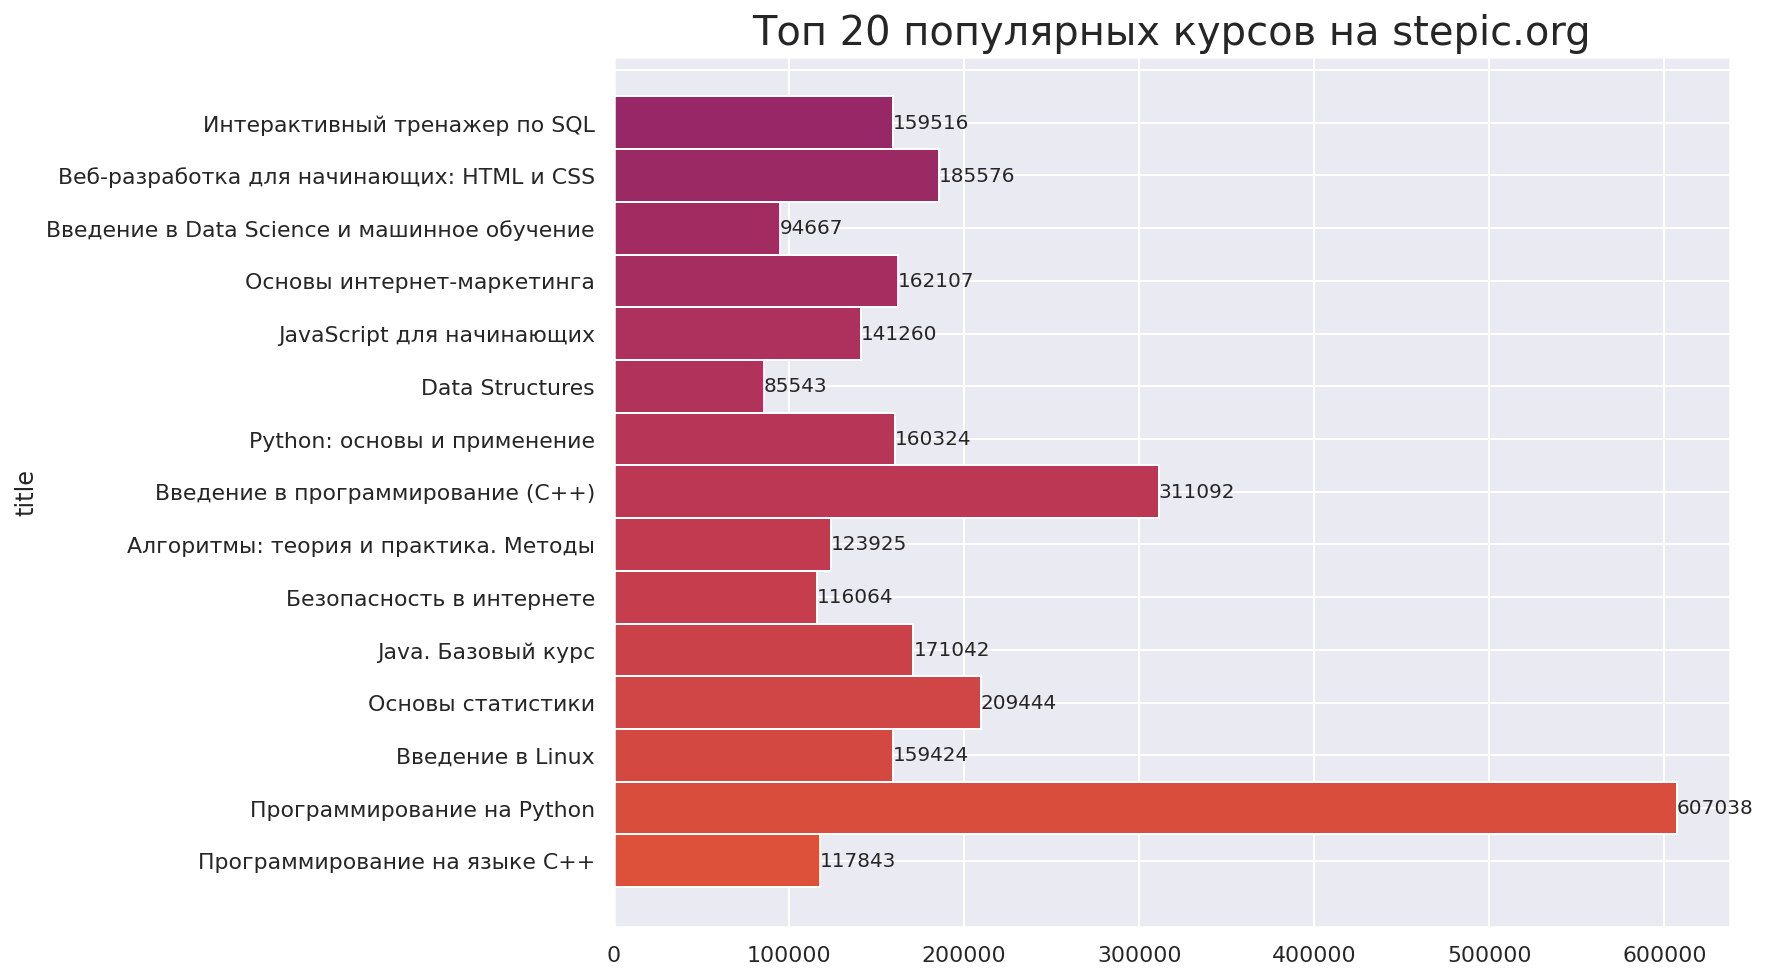

In [ ]:
dataset_stepic_top['learners_count'].plot(y = dataset_stepic_top['learners_count'], x = dataset_stepic_top['title'],
                                               figsize = (10,8),kind='barh', width = 1, color=color)
for y,x in enumerate(dataset_stepic_top['learners_count']):
    plt.text(x+0.1,y,'%s' %round(x,1),va='center')
plt.yticks(range(31),dataset_stepic_top['title'])
plt.axis('tight')
plt.ylabel('title')
plt.title('Топ 20 популярных курсов на stepic.org', fontsize = 20)
plt.show()

Первое место занимают курсы на Python и это весьма предсказуемо, так как программисты со знанием Python очень сильно востребованы, на этот языке происходит обработка данных(аналитика) и в анализе ключевых навыков python по популярности входит в десятку популярных. Востребованность курсов по С++ велика, достаточно вспомнить, где он используется: микроконтроллеры,роботы, десктопные и мобильные приложения, веб, игры, системы моделирования, прогнозирования, обработки статистики и в нейронных сетях. Везде. Просто не существует такой области программирования, где C++ был бы бесполезен, он быстр, универсален и востребован.

In [ ]:
dataset_stepic_price = dataset_stepic[dataset_stepic['price']>1]

In [ ]:
dataset_stepic_price.to_excel('Stepic_price.xlsx')

In [ ]:
dataset_stepic_price['price'].describe()

count      122.000000
mean      4801.581967
std       9131.631350
min        149.000000
25%        900.000000
50%       1940.000000
75%       4100.000000
max      60000.000000
Name: price, dtype: float64

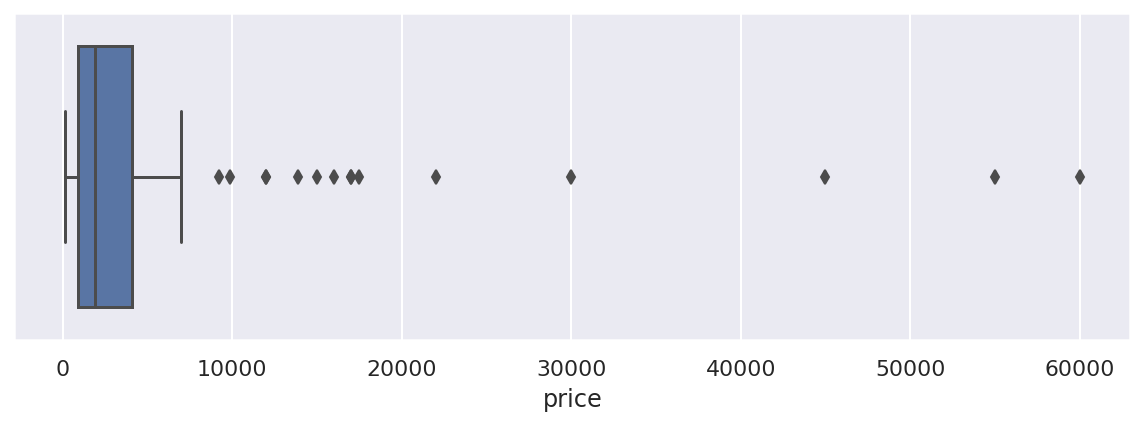

In [ ]:
f, ax = plt.subplots(figsize=(10, 3))
sns.boxplot(x=dataset_stepic_price['price'])
plt.show()

Видно большое количество выбросов, начиная примерно от 6 тыс.рублей, для наглядности уберём эти выбросы и графически отобразим :

In [ ]:
dataset_stepic_price_b_v = dataset_stepic[dataset_stepic['price']<6000]

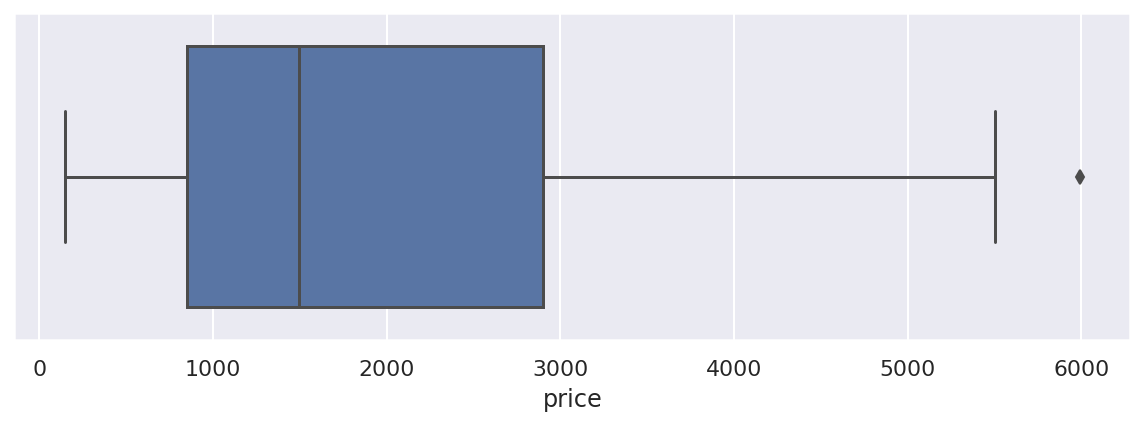

In [ ]:
f, ax = plt.subplots(figsize=(10, 3))
sns.boxplot(x=dataset_stepic_price_b_v['price'])
plt.show()

удалили выбросы и в основом цены у нас рассполагаются от 800 рублей и почти до 3 тыс.рублей

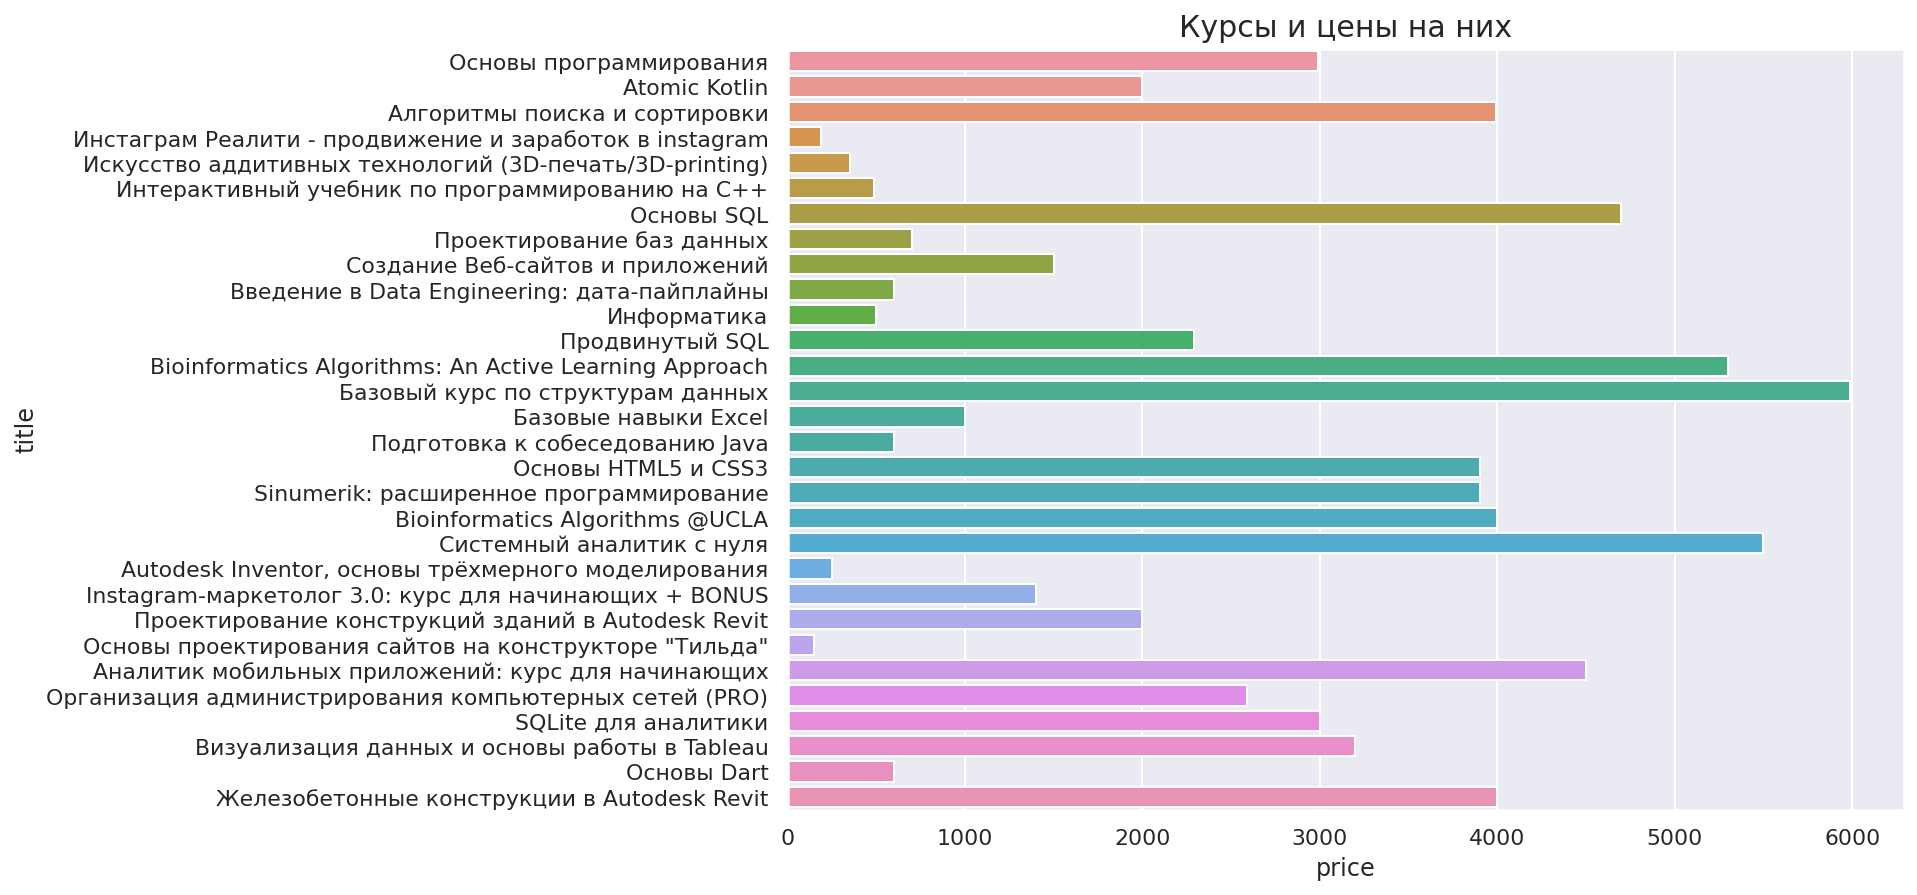

In [ ]:
f, ax = plt.subplots(figsize=(10, 7))
sns.barplot(x = dataset_stepic_price_b_v['price'][:30], y = dataset_stepic_price_b_v['title'][:30])
plt.title('Курсы и цены на них', fontsize = 15)
plt.show()

здесь выведены не все курсы с ценами, но видно, что более высокие цены на курсы по структурам данных, аналитика, SQL. Посмотрим на взаимосвязь цены курса и количество учащихся,  именно на платных курсах.

In [ ]:
a = dataset_stepic_price_b_v.groupby(['price','title'])['learners_count'].idxmax().tail(20)
a

price   title                                                          
3500.0  Основы разработки игр на С# (Gamedev / DOTNET / .NET / C Sharp)    101274
        Профессии в SMM: эффективное включение в сферу и быстрый рост      102827
3900.0  Sinumerik: расширенное программирование                             63067
        Основы HTML5 и CSS3                                                 58973
3990.0  Алгоритмы поиска и сортировки                                       23981
                                                                            ...  
4900.0  Tableau Профессионал                                                94450
4990.0  Kotlin - быстрый старт                                             118541
5300.0  Bioinformatics Algorithms: An Active Learning Approach              55789
5500.0  Системный аналитик с нуля                                           68303
5990.0  Базовый курс по структурам данных                                   55971
Name: learners_count, Leng

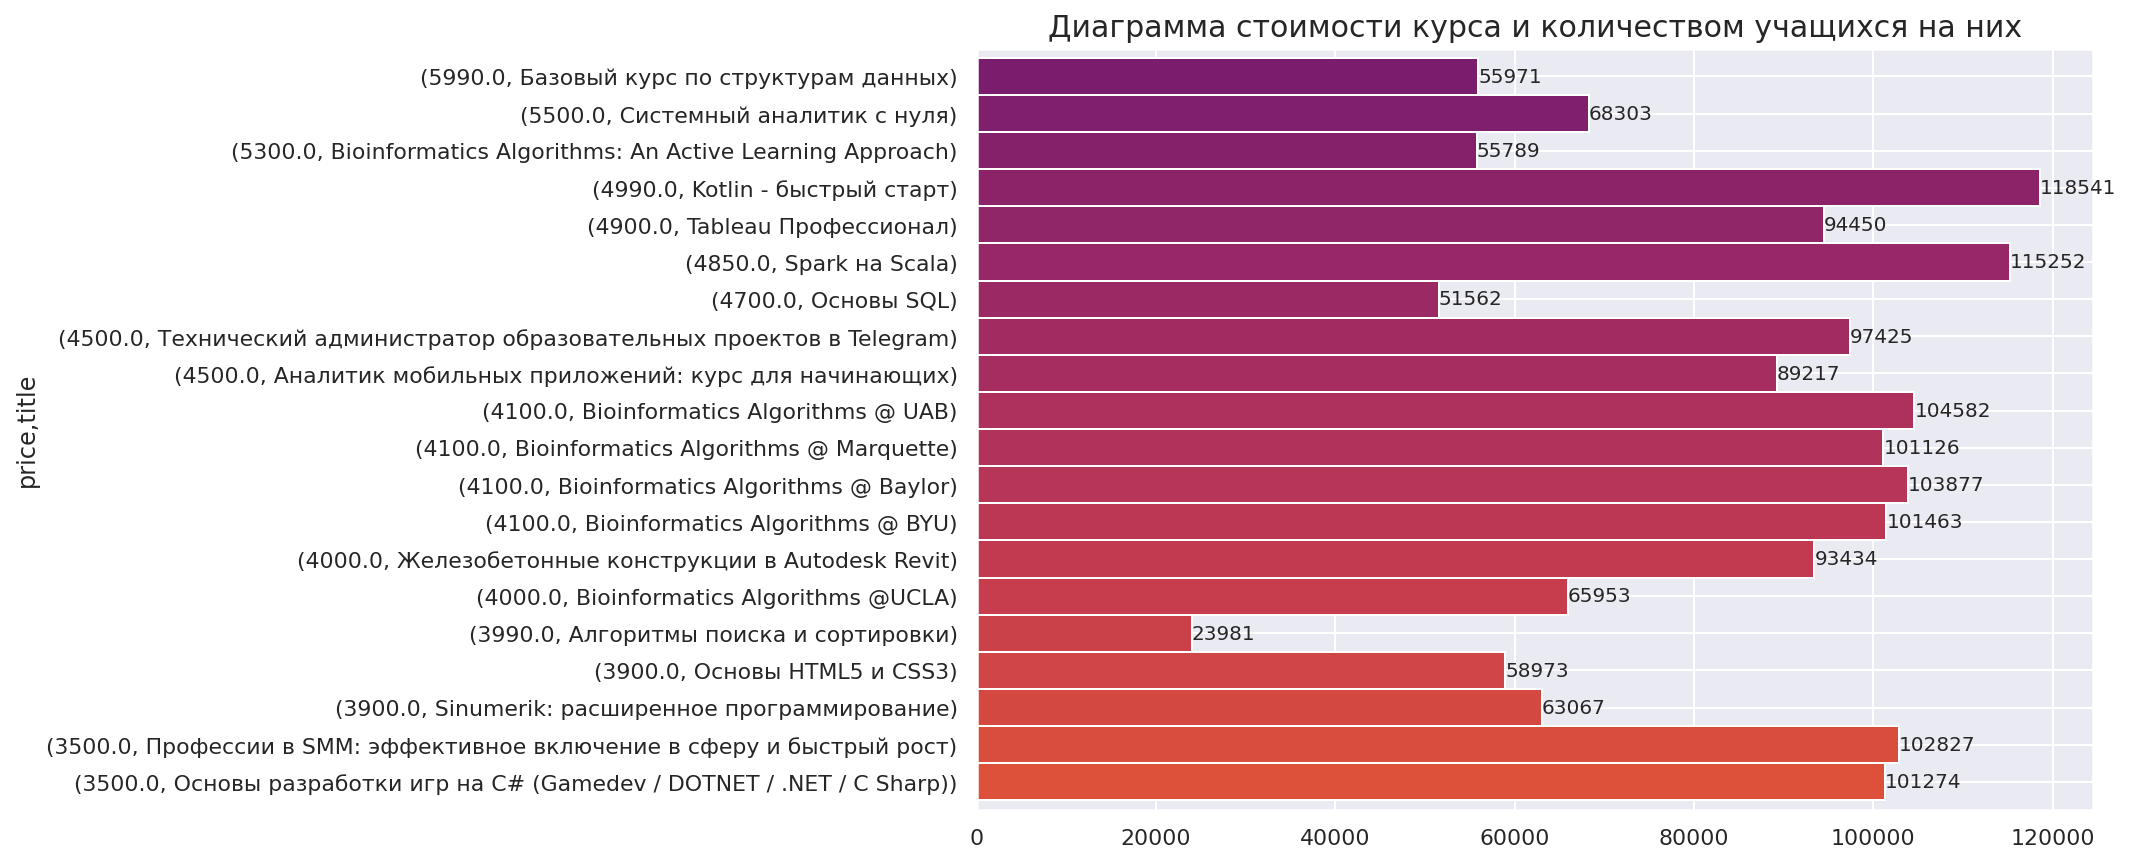

In [ ]:
a.plot(kind='barh', stacked=True,  width=1, figsize = (10, 7), color=color)
plt.title('Диаграмма стоимости курса и количеством учащихся на них', fontsize = 15)
for x,y in enumerate(a):
    plt.text(y+0.1,x,'%s' %round(y,1),va='center')
plt.show()

здесь получилась немного нагромажденная таблица, но посмотрим на связь цены с количеством учащихся, были отобраны примерно в небольшом диапазоне курсы от 6 до 4 тыс.руб.. Курсы достаточно разнообразные, аналитика, SQL, SMM, Kotlin, четыре курса по биоинформатике, здесь нельзя сказать какой курс самый лучший по цене и популярности, вывод в другом, что платные курсы тоже не менее популярные по записи, в сравнении с бесплатными. Люди готовы платить за знания.

 Давайте лучше посмотрим на связь между количество поступивших на курс и количеством выданных сертификатов, т.е. кто закончил курс до конца, возьмём датасет с 20 самыми популярными курсами, по количеству записавшихся на них

In [ ]:
dataset_stepic_top[['certificates_count','learners_count']].head(10)

certificates_count  learners_count
id                                     
7                  8097          117843
67                61219          607038
73                18626          159424
76                35716          209444
187                8519          171042
191               62713          116064
217                5915          123925
363               18903          311092
512               17048          160324
579                1319           85543

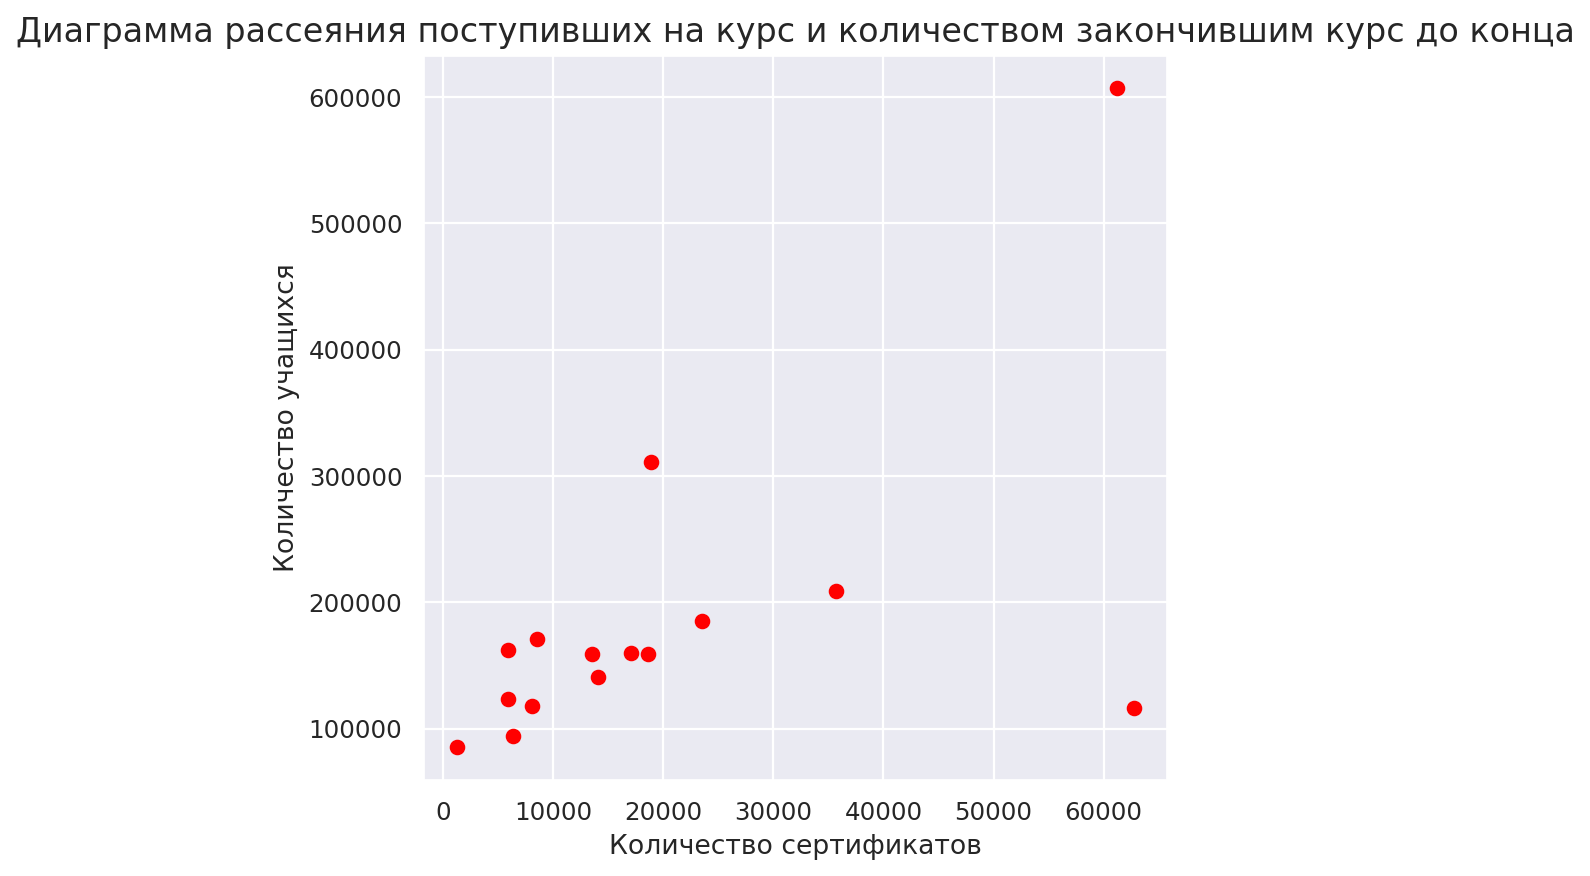

In [ ]:
plt.figure(figsize=(6,6), dpi=80)
plt.scatter(dataset_stepic_top['certificates_count'], dataset_stepic_top['learners_count'], color='red')
plt.title('Диаграмма рассеяния поступивших на курс и количеством закончившим курс до конца', fontsize=15)

plt.xlabel('Количество сертификатов')
plt.ylabel('Количество учащихся')
plt.show()

разброс достаточно велик, например поступило 607 тыс. человек, а закончило около 61 тыс., поступило 311 тыс., а закончило 19 тыс., 209 и 35.  Есть один выброс среди курсов, поступило 212 тыс., есть и выбросы, которые пока удалять не будем.

#**СТАТИСТИЧЕСКИЙ АНАЛИЗ ДАННЫХ ПО ВАКАНСИЯМ**

##Вывод датасета, удаление выбросов

Возьмём для анализа датасет dataset_salary_2 отфильтрованный по указанным в них зарплатах от и до и по проведённому анализу выше мы увидели что надо удалить выбросы, такие как в 100 рублей и 800000 руб

для удобства работы, переведём зарплату из float в ineger

In [ ]:
dataset_salary_2['средняя зарплата'] = dataset_salary_2['средняя зарплата'].astype(np.int64)

In [ ]:
dataset_salary_2['зарплата от'] = dataset_salary_2['зарплата от'].astype(np.int64)
dataset_salary_2['зарплата до'] = dataset_salary_2['зарплата до'].astype(np.int64)

In [ ]:
dataset_salary_2.head()

id                                               name  зарплата от  \
2  67281137  3D Motion Designer (видео дизайнер, 3D анимато...        50000   
3  67075607  C# developer junior / middle (.net, full-stack...       100000   
5  66553433        Back-end Developer (Ruby On Rails) удалённо       100000   
6  66865301                            Backend (С++) Developer        80000   
8  66141342                               Back - End Developer       180480   

   зарплата до  средняя зарплата             город           region  \
2       150000            100000  Санкт-Петербург   Санкт-Петербург   
3       220000            160000           Москва            Москва   
5       350000            225000           Москва            Москва   
6       160000            120000           Москва            Москва   
8       360960            270720           Москва            Москва   

  тип вакансии дата публикации время публикации Название работодателя  \
2     Открытая      2022-06-28         10:57:21                  БИАТ   
3     Открытая      2022-07-01         11:15:52               Mindbox   
5     Открытая      2022-06-29         13:12:43         ПотокДиджитал   
6     Открытая      2022-06-30         13:43:15            Оптимакрос   
8     Открытая      2022-06-28         13:20:25         Avanta Россия   

      График работы                                         Требования  \
2     Гибкий график  Высокий уровень владения Blender (важно). Необ...   
3       Полный день  SQL. Есть удаленная оплачиваемая стажировка на...   
5  Удаленная работа                                             None,    
6  Удаленная работа  В крупный международный проект Optimacros треб...   
8  Удаленная работа  We are open to consider any candidates with fl...   

                                         Обязанности  \
2  Создание анимационных 3D видеороликов. Анимаци...   
3                                               None   
5  Код храниться в Gitlab. В составе продуктовой ...   
6  Разработка новых функций многомерной базы данн...   
8  1. As a Software Engineer you’ll work on globa...   

                                   Описание вакансии         Опыт работы  \
2  Требуется 3D Motion Designer (видео дизайнер, ...       От 3 до 6 лет   
3  Ищем разработчика, который хочет быстро дораст...  От 1 года до 3 лет   
5  Привет!Мы ​команда разработки​ компании​ potok...       От 3 до 6 лет   
6  В крупный международный проект Optimacros треб...       От 3 до 6 лет   
8  Our client international IT company is looking...  От 1 года до 3 лет   

                                     Ключевые навыки  
2  Adobe Photoshop, Adobe Illustrator, Adobe Afte...  
3  .NET Framework, C#, MS SQL, LINQ, .NET Core, A...  
5      PostgreSQL, Ruby On Rails, Ruby, Redis, Git,   
6  Git, ООП, Английский язык, Design Patterns, C++,   
8  Fluent English, Clojure, ClojureScript, Python...

In [ ]:
dataset_bez_vybros = dataset_salary_2[(dataset_salary_2['зарплата от']> 20000) & (dataset_salary_2['средняя зарплата']<360000)]


In [ ]:
dataset_bez_vybros.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12727 entries, 2 to 343
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     12727 non-null  int64         
 1   name                   12727 non-null  object        
 2   зарплата от            12727 non-null  int64         
 3   зарплата до            12727 non-null  int64         
 4   средняя зарплата       12727 non-null  int64         
 5   город                  12727 non-null  object        
 6   region                 12727 non-null  object        
 7   тип вакансии           12727 non-null  object        
 8   дата публикации        12727 non-null  datetime64[ns]
 9   время публикации       12727 non-null  object        
 10  Название работодателя  12727 non-null  object        
 11  График работы          12727 non-null  object        
 12  Требования             12727 non-null  object        
 13  Обя

##Графически посмотрим на данные

In [ ]:
dataset_bez_vybros['зарплата от'].describe()

count     12727.000000
mean      73035.645164
std       54193.324218
min       20100.000000
25%       35000.000000
50%       50000.000000
75%      100000.000000
max      330000.000000
Name: зарплата от, dtype: float64

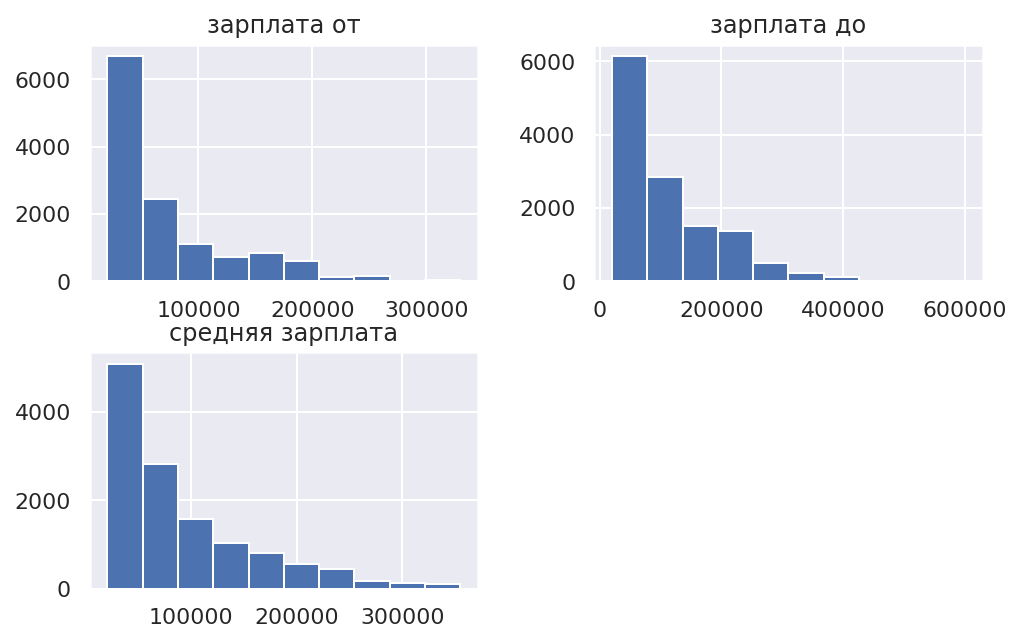

In [ ]:
dataset_bez_vybros[['зарплата от','зарплата до','средняя зарплата']].hist(bins=10, figsize = (8,5)) #]
plt.show()

##Описательные статистики

In [ ]:
round(dataset_bez_vybros[['зарплата от',	'зарплата до',	'средняя зарплата']].describe())

зарплата от  зарплата до  средняя зарплата
count      12727.0      12727.0           12727.0
mean       73036.0     110577.0           91807.0
std        54193.0      83235.0           66975.0
min        20100.0      20500.0           20500.0
25%        35000.0      50000.0           42500.0
50%        50000.0      80000.0           65000.0
75%       100000.0     150000.0          125000.0
max       330000.0     600000.0          355000.0

In [ ]:
round(dataset_bez_vybros[['зарплата от',	'зарплата до',	'средняя зарплата']].mean()) # среднее значение

зарплата от          73036.0
зарплата до         110577.0
средняя зарплата     91807.0
dtype: float64

In [ ]:
round(dataset_bez_vybros[['зарплата от',	'зарплата до',	'средняя зарплата']].std()) # средне квадратическое отклонение

зарплата от         54193.0
зарплата до         83235.0
средняя зарплата    66975.0
dtype: float64

In [ ]:
dataset_bez_vybros[['зарплата от',	'зарплата до',	'средняя зарплата']].skew()  # коэффициент асимметрии

зарплата от         1.559666
зарплата до         1.458443
средняя зарплата    1.419615
dtype: float64

In [ ]:
dataset_bez_vybros[['зарплата от',	'зарплата до',	'средняя зарплата']].kurtosis()    # коэффициент эксцесса

зарплата от         2.056722
зарплата до         1.890919
средняя зарплата    1.493594
dtype: float64

## Проверим нормальность зарплаты по критерию согласия Пирсона

In [ ]:
stats.normaltest(dataset_bez_vybros['зарплата от'])

NormaltestResult(statistic=3396.759861001834, pvalue=0.0)

In [ ]:
stats.normaltest(dataset_bez_vybros['зарплата до'])

NormaltestResult(statistic=3112.1048833172463, pvalue=0.0)

In [ ]:
stats.normaltest(dataset_bez_vybros['средняя зарплата'])

NormaltestResult(statistic=2887.829151483999, pvalue=0.0)

Вывод:  мы получили значение pvalue  и он в трёх случаях равен 0.0 и это меньше чем уровень значимости в 0.05, нулевую гипотезу о равенстве законов распределения отклоняем. Делаем вывод, что наша выборка не подчиняется закону нормального распределения. Нормальность отклоняем и будем работать с не параметрикой, т.е. не будем привязываться к распределению, будем работать с порядковыми значениями.

## Проведём анализ влияния категориальных признаков. Критерии сравнения групп

##Гипотеза 𝐻0: зарплата не зависит от региона публикации вакансии

Гипотеза 𝐻1: зарплата зависит от региона публикации вакансии

In [ ]:
round(dataset_bez_vybros.groupby('region')[['средняя зарплата']].mean().head())

средняя зарплата
region                                 
Алтайский край                  61477.0
Амурская область                57828.0
Архангельская область           68017.0
Астраханская область            71246.0
Брянская область                67552.0

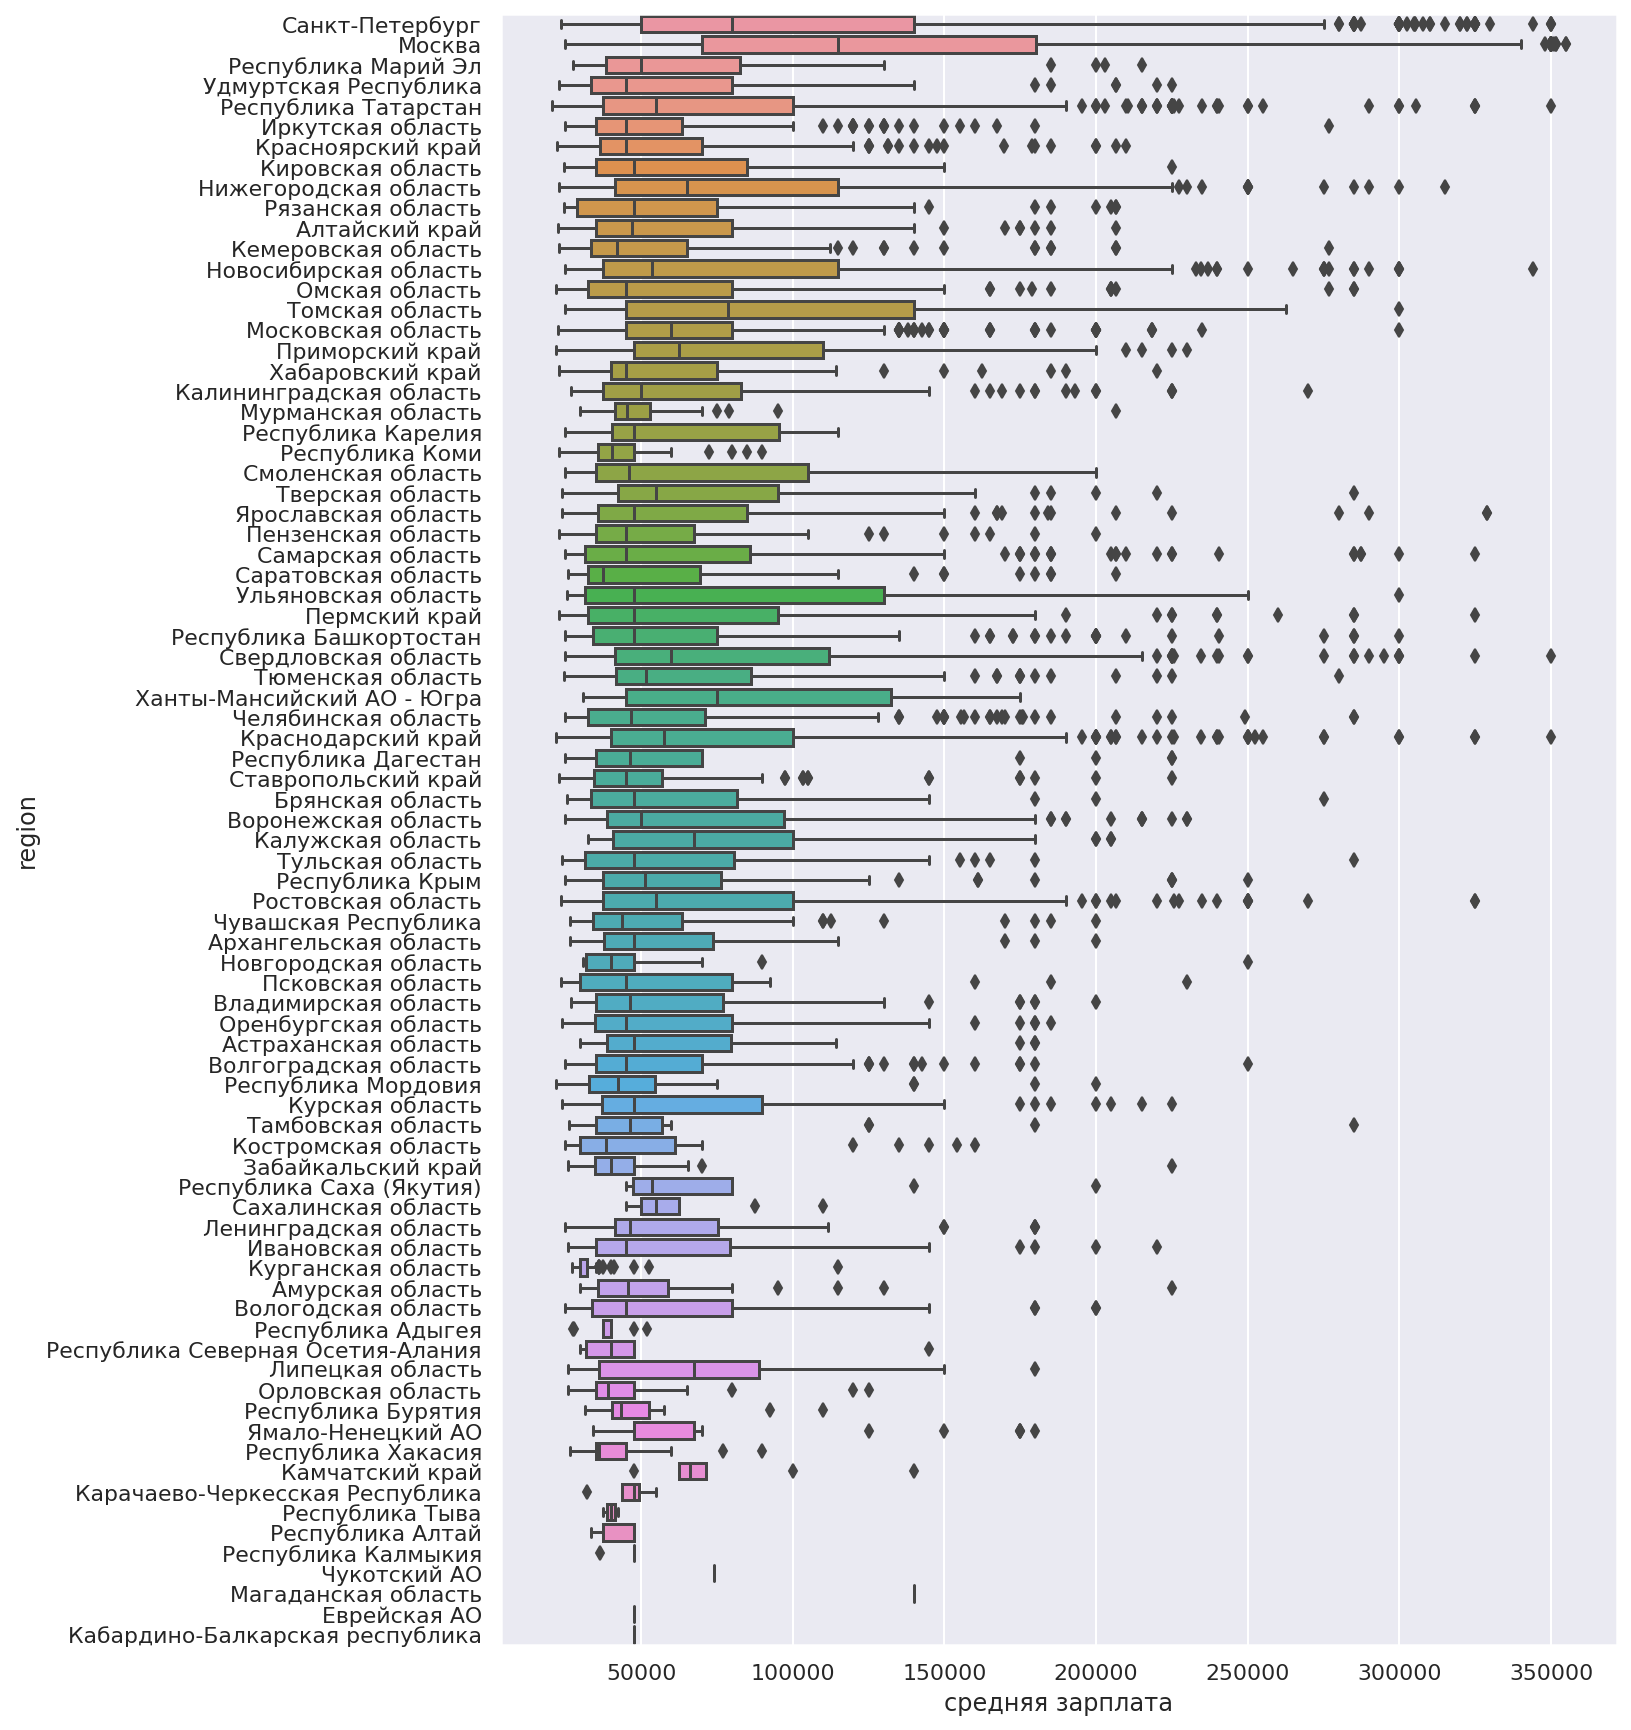

In [ ]:
f, ax = plt.subplots(figsize=(10,15))
fig = sns.boxplot(x='средняя зарплата', y='region', data=dataset_bez_vybros)

Как видим, значения зарплат отличаются в регионах, и для дальнейшего анализа выберем 10 регионов, в которых опубликовано наибольшее количество вакансий

In [ ]:
dataset_bez_vybros.region.value_counts().head(10)

Москва                   3262
Санкт-Петербург          1576
Республика Татарстан      511
Московская область        496
Краснодарский край        495
Свердловская область      482
Новосибирская область     474
Красноярский край         302
Самарская область         300
Нижегородская область     281
Name: region, dtype: int64

после того, как мы узнали в каких регионах больше всего опубликовано вакансий, отдельно по каждому сгруппируем их в новые датасеты

In [ ]:
Moscow = dataset_bez_vybros[dataset_bez_vybros['region']== 'Москва']
Saint_Petersburg = dataset_bez_vybros[dataset_bez_vybros['region']== 'Санкт-Петербург']
Republic_of_Tatarstan = dataset_bez_vybros[dataset_bez_vybros['region']== 'Республика Татарстан']
Moscow_region = dataset_bez_vybros[dataset_bez_vybros['region']== 'Московская область']
Krasnodar_Territory = dataset_bez_vybros[dataset_bez_vybros['region']== 'Краснодарский край']
Sverdlovsk_region = dataset_bez_vybros[dataset_bez_vybros['region']== 'Свердловская область']
Novosibirsk_region = dataset_bez_vybros[dataset_bez_vybros['region']== 'Новосибирская область']
Krasnoyarsk_Territory = dataset_bez_vybros[dataset_bez_vybros['region']== 'Красноярский край']
Samara_region = dataset_bez_vybros[dataset_bez_vybros['region']== 'Самарская область']
Nizhny_Novgorod_region = dataset_bez_vybros[dataset_bez_vybros['region']== 'Нижегородская область']
#проверяем гипотезы о нормальности
print(stats.normaltest(Moscow['средняя зарплата']))
print(stats.normaltest(Saint_Petersburg['средняя зарплата']))
print(stats.normaltest(Republic_of_Tatarstan['средняя зарплата']))
print(stats.normaltest(Moscow_region['средняя зарплата']))
print(stats.normaltest(Krasnodar_Territory['средняя зарплата']))
print(stats.normaltest(Sverdlovsk_region['средняя зарплата']))
print(stats.normaltest(Novosibirsk_region['средняя зарплата']))
print(stats.normaltest(Krasnoyarsk_Territory['средняя зарплата']))
print(stats.normaltest(Samara_region['средняя зарплата']))
print(stats.normaltest(Nizhny_Novgorod_region['средняя зарплата']))

NormaltestResult(statistic=261.4766636215723, pvalue=1.663657496652917e-57)
NormaltestResult(statistic=287.2676300883244, pvalue=4.174713839274821e-63)
NormaltestResult(statistic=180.1312977717976, pvalue=7.673361872334778e-40)
NormaltestResult(statistic=214.62883098868488, pvalue=2.477088494561969e-47)
NormaltestResult(statistic=171.37861225855204, pvalue=6.103896907457613e-38)
NormaltestResult(statistic=143.88233653946241, pvalue=5.706208006246569e-32)
NormaltestResult(statistic=111.34623469297836, pvalue=6.629371334515933e-25)
NormaltestResult(statistic=152.78259060735093, pvalue=6.663186730137752e-34)
NormaltestResult(statistic=141.40814144044288, pvalue=1.9661300372487954e-31)
NormaltestResult(statistic=71.20221284461986, pvalue=3.456494985284454e-16)


In [ ]:
# просто собрали пять самых крупных регионов в однин датасет
df_top_5_region = pd.concat([Moscow, Saint_Petersburg,Republic_of_Tatarstan, Moscow_region, Krasnodar_Territory])

для всех выборок отклоняем гипотезу о нормальности, т.е. наши совокупности являются количественными, но не нормальными, применяем тест Крускала-Уоллиса

In [ ]:
stats.kruskal(Moscow['средняя зарплата'],Saint_Petersburg['средняя зарплата'],Republic_of_Tatarstan['средняя зарплата'],
                         Moscow_region['средняя зарплата'],Krasnodar_Territory['средняя зарплата'],Sverdlovsk_region['средняя зарплата'],
                         Novosibirsk_region['средняя зарплата'],Krasnoyarsk_Territory['средняя зарплата'],Samara_region['средняя зарплата'],
                         Nizhny_Novgorod_region['средняя зарплата'])

KruskalResult(statistic=1328.4890939942602, pvalue=2.1729677636683295e-280)

Вывод: pvalue меньше чем альфа, значит нулевая гипотеза о том, что зарплата не зависит от региона ОТВЕРГАЕТСЯ, т.е. есть статистически значимые отличия между регионами

## Гипотеза 𝐻0: зарплата не зависит от опыта работы, указанного в вакансии

Гипотеза 𝐻1: зарплата зависит от опыта работы, указанного в вакансии

In [ ]:
round(dataset_bez_vybros.groupby('Опыт работы')[['средняя зарплата']].mean())

средняя зарплата
Опыт работы                         
Более 6 лет                 174093.0
Нет опыта                    46986.0
От 1 года до 3 лет           82984.0
От 3 до 6 лет               151542.0

посмотрим на количество вакансий по каждой категории, и видим, что они не равномерно распределены, на первом месте по количеству вакансий стоит указанный стаж 'от 1 года до 3 лет', далее примерно одинаковые 'от 3 до 6' лет и 'нет опыта', наименьшее количество со стажем 'более 6 лет'

In [ ]:
dataset_bez_vybros.groupby('Опыт работы')[['средняя зарплата']].count()

средняя зарплата
Опыт работы                         
Более 6 лет                      216
Нет опыта                       2823
От 1 года до 3 лет              6855
От 3 до 6 лет                   2833

графически отобразим наши группы

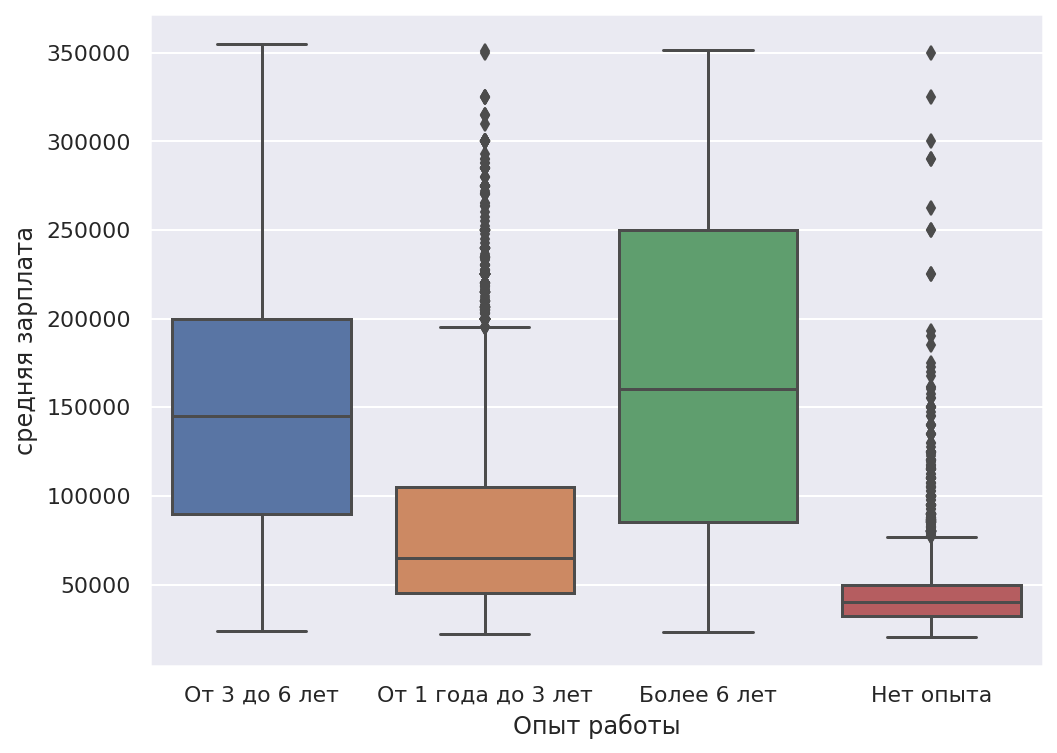

In [ ]:
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='Опыт работы', y='средняя зарплата', data=dataset_bez_vybros)

видны большие отличия в средних зарплатах по требуемому опыту работы. Проверим группы на нормальность

In [ ]:
df_ot_3 = dataset_bez_vybros[dataset_bez_vybros['Опыт работы']== 'От 3 до 6 лет']
df_ot_1 = dataset_bez_vybros[dataset_bez_vybros['Опыт работы']== 'От 1 года до 3 лет']
df_ot_6 = dataset_bez_vybros[dataset_bez_vybros['Опыт работы']== 'Более 6 лет']
df_net = dataset_bez_vybros[dataset_bez_vybros['Опыт работы']== 'Нет опыта']
print(stats.normaltest(df_ot_3['средняя зарплата']))
print(stats.normaltest(df_ot_1['средняя зарплата']))
print(stats.normaltest(df_ot_6['средняя зарплата']))
print(stats.normaltest(df_net['средняя зарплата']))


NormaltestResult(statistic=144.02773629106957, pvalue=5.306087945339575e-32)
NormaltestResult(statistic=1826.064601290209, pvalue=0.0)
NormaltestResult(statistic=71.4387809361553, pvalue=3.0709010489635364e-16)
NormaltestResult(statistic=2531.8782684586604, pvalue=0.0)


для всех выборок отклоняем гипотезу о нормальности, т.е. наши совокупности являются количественными, но не нормальными, применяем тест Крускала-Уоллиса

In [ ]:
stats.kruskal(df_ot_3['средняя зарплата'], df_ot_1['средняя зарплата'],df_ot_6['средняя зарплата'],df_net['средняя зарплата'])

KruskalResult(statistic=4299.3720305965335, pvalue=0.0)

Вывод: pvalue меньше чем альфа, значит нулевая гипотеза о том, что зарплата не зависит от опыта работы ОТВЕРГАЕТСЯ, т.е. есть статистически значимые отличия между группами

## Гипотеза 𝐻0: зарплата не зависит от графика работы указанного в  вакансии

Гипотеза 𝐻1: зарплата зависит от графика работы указанного в  вакансии

In [ ]:
round(dataset_bez_vybros.groupby('График работы')[['средняя зарплата']].mean())

средняя зарплата
График работы                     
Вахтовый метод            119323.0
Гибкий график             111982.0
Полный день                86782.0
Сменный график             49763.0
Удаленная работа          134318.0

выведем количество вакансий по каждому графику работы

In [ ]:
dataset_bez_vybros.groupby('График работы')[['средняя зарплата']].count()

средняя зарплата
График работы                     
Вахтовый метод                  69
Гибкий график                  458
Полный день                   8539
Сменный график                1465
Удаленная работа              2196

графически отобразим наши группы

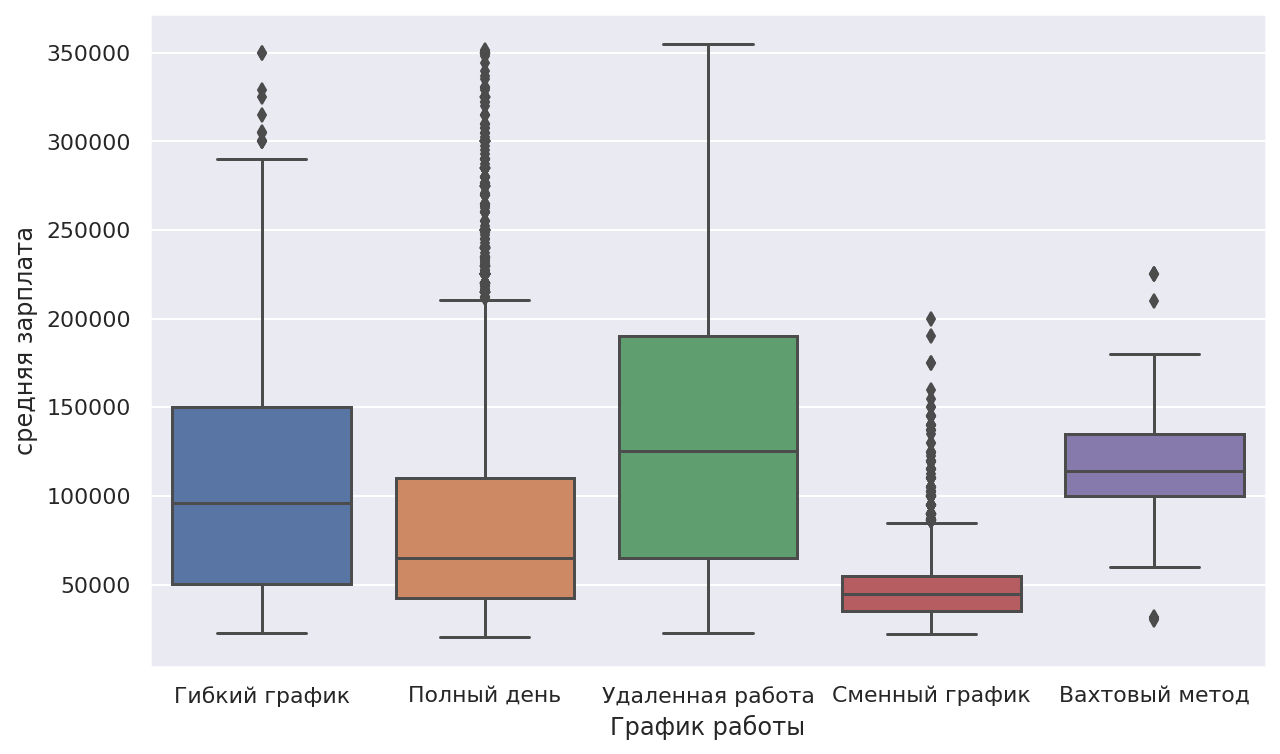

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.boxplot(x='График работы', y='средняя зарплата', data=dataset_bez_vybros)

по графику видно, что средняя зарплата в группах отличается, самая большая по зарплате группа с удалённым графиком, затем с вахтовым методом, но там вакансий меньше чем в гибком графике, затем гибкий график, полный день и наименьшую зарплату и количество вакансий по сменному графику работы(скорее всего этот график предполагает подработки, или время работы в течение суток в разные рабочие дни может различаться). 

Посмотрим на нормальность распределения в этих группах по критерию Пирсона

In [ ]:
df_vaht = dataset_bez_vybros[dataset_bez_vybros['График работы']== 'Вахтовый метод']
df_gib = dataset_bez_vybros[dataset_bez_vybros['График работы']== 'Гибкий график']
df_poln = dataset_bez_vybros[dataset_bez_vybros['График работы']== 'Полный день']
df_smen = dataset_bez_vybros[dataset_bez_vybros['График работы']== 'Сменный график']
df_udal = dataset_bez_vybros[dataset_bez_vybros['График работы']== 'Удаленная работа']

In [ ]:
print(stats.normaltest(df_vaht['средняя зарплата']))
print(stats.normaltest(df_gib['средняя зарплата']))
print(stats.normaltest(df_poln['средняя зарплата']))
print(stats.normaltest(df_smen['средняя зарплата']))
print(stats.normaltest(df_udal['средняя зарплата']))

NormaltestResult(statistic=2.5939508160209352, pvalue=0.2733573383516422)
NormaltestResult(statistic=59.67487491184144, pvalue=1.1009448360647227e-13)
NormaltestResult(statistic=2450.4161926464667, pvalue=0.0)
NormaltestResult(statistic=715.019826106477, pvalue=5.437728692018461e-156)
NormaltestResult(statistic=131.12055620824503, pvalue=3.369248062808735e-29)


Видно, что pvalue по всем группам меньше уровня значимости, значит нулевую гипотезу о нормальности отвергаем. Далее проведём применяем тест Крускала-Уоллиса

In [ ]:
stats.kruskal(df_vaht['средняя зарплата'],df_gib['средняя зарплата'],df_poln['средняя зарплата'],
                           df_smen['средняя зарплата'],df_udal['средняя зарплата'] )

KruskalResult(statistic=1553.825374038113, pvalue=0.0)

Вывод: pvalue меньше чем альфа, значит нулевая гипотеза о том, что зарплата не зависит от графика работы ОТВЕРГАЕТСЯ, т.е. есть статистически значимые отличия между группами

##Гипотеза 𝐻0: зарплата не зависит от профессии 

Гипотеза 𝐻1: зарплата зависит от профессии

In [ ]:
round(dataset_bez_vybros.groupby('name')[['средняя зарплата']].mean()).head(5)

средняя зарплата
name                                                                
(Angular) Front-End разработчик                              69184.0
(Junior/Middle) PHP разработчик                              40000.0
(Младший) специалист по работе со списками и ин...           45000.0
.NET Backend Developer                                       75000.0
.NET backend developer C#                                   110000.0

выведем 10 самых наиболее встречающихся вакансий, затем с ними и продолжим работать

In [ ]:
dataset_bez_vybros[['name']].value_counts().head(10)

name                                          
Программист 1С                                    517
Продавец-консультант                              410
Системный администратор                           259
Младший инспектор отдела безопасности и охраны    197
Оператор 1С                                       153
Модератор (Front Office)                          136
Младший инспектор                                 132
Контент-менеджер                                  108
Оператор 1C                                       107
SMM-менеджер                                      102
dtype: int64

In [ ]:
df_prod = np.array(dataset_bez_vybros[dataset_bez_vybros['name'] == 'Продавец-консультант']['средняя зарплата'])
df_progr = np.array(dataset_bez_vybros[dataset_bez_vybros['name'] == 'Программист 1С']['средняя зарплата'])
df_sis_ad = np.array(dataset_bez_vybros[dataset_bez_vybros['name'] == 'Системный администратор']['средняя зарплата'])
df_ml_in = np.array(dataset_bez_vybros[dataset_bez_vybros['name'] == 'Младший инспектор отдела безопасности и охраны']['средняя зарплата'])
df_oper = np.array(dataset_bez_vybros[dataset_bez_vybros['name'] == 'Оператор 1С']['средняя зарплата'])
df_mod = np.array(dataset_bez_vybros[dataset_bez_vybros['name'] == 'Модератор (Front Office)']['средняя зарплата'])
df_ml_ins = np.array(dataset_bez_vybros[dataset_bez_vybros['name'] == 'Младший инспектор']['средняя зарплата'])
df_kont = np.array(dataset_bez_vybros[dataset_bez_vybros['name'] == 'Контент-менеджер']['средняя зарплата'])
df_oper1C = np.array(dataset_bez_vybros[dataset_bez_vybros['name'] == 'Оператор 1C']['средняя зарплата'])
df_smm = np.array(dataset_bez_vybros[dataset_bez_vybros['name'] == 'SMM-менеджер']['средняя зарплата'])


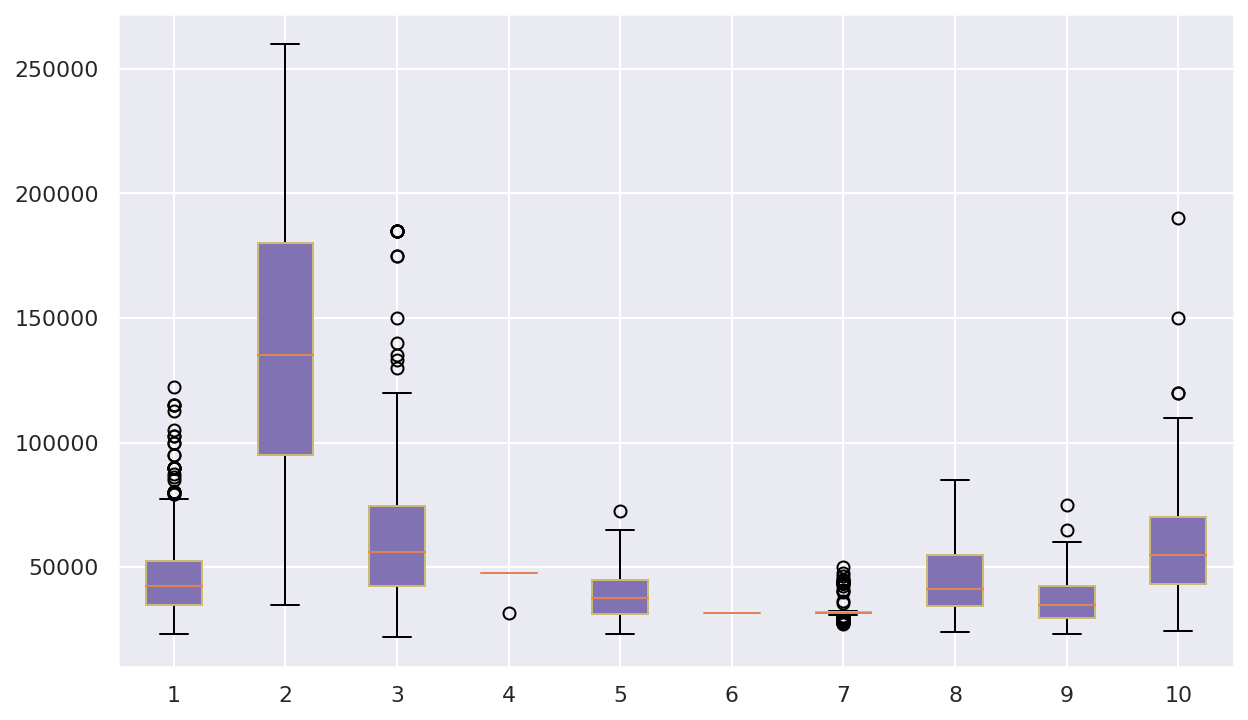

In [ ]:
plt.boxplot ([df_prod, df_progr, df_sis_ad, df_ml_in, df_oper, df_mod, df_ml_ins, df_kont, df_oper1C, df_smm  ], figsize(10,6),
             patch_artist=True, boxprops=dict(facecolor='m', color='y'))
plt.show()

проверяем на нормальность по критерию согласия Пирсона

In [ ]:
print(stats.normaltest(df_prod))
print(stats.normaltest(df_progr))
print(stats.normaltest(df_sis_ad))
print(stats.normaltest(df_ml_in))
print(stats.normaltest(df_oper))
print(stats.normaltest(df_mod))
print(stats.normaltest(df_ml_ins))
print(stats.normaltest(df_kont))
print(stats.normaltest(df_oper1C))
print(stats.normaltest(df_smm))

NormaltestResult(statistic=120.79201039714458, pvalue=5.8931597402459965e-27)
NormaltestResult(statistic=85.16297744243246, pvalue=3.214359275713239e-19)
NormaltestResult(statistic=115.88305062295777, pvalue=6.859860500769991e-26)
NormaltestResult(statistic=436.63443996317653, pvalue=1.5347444005064675e-95)
NormaltestResult(statistic=17.241471312454863, pvalue=0.0001803275468105516)
NormaltestResult(statistic=580.1097645065245, pvalue=1.073408891252605e-126)
NormaltestResult(statistic=37.89604822733789, pvalue=5.901707544004279e-09)
NormaltestResult(statistic=9.977497337131906, pvalue=0.006814185964620454)
NormaltestResult(statistic=18.91846984102899, pvalue=7.796621855670174e-05)
NormaltestResult(statistic=71.47204564676588, pvalue=3.0202471461799846e-16)


во всех группах pvalue меньше уровня значимости, а значит мы всё таки отвергаем гипотезу о нормальности, и снова применяем тест Крускала-Уоллиса

In [ ]:
stats.mstats.kruskalwallis(df_prod,df_progr,df_sis_ad,df_ml_in,df_oper,df_mod,df_ml_ins,df_kont,df_oper1C,df_smm)

KruskalResult(statistic=1381.1276628012752, pvalue=9.240836739592049e-292)

Нулевую гипотезу о том, что зарплата не зависит от профессии отклоняем, и принимаем альтернативную, в группах различия статистически значимы!

##Гипотеза 𝐻0: вакансия не зависит от места её публикации

Гипотеза 𝐻1: вакансия зависит от места её публикации

In [ ]:
df_top_5_region['region'].value_counts()

Москва                  3262
Санкт-Петербург         1576
Республика Татарстан     511
Московская область       496
Краснодарский край       495
Name: region, dtype: int64

In [ ]:
# соберем в один датасет самые попул.профессии из датасета df_top_5_region где уже собрали самые популярные регионы
df1 = df_top_5_region[df_top_5_region['name']=='Продавец-консультант']
df2 = df_top_5_region[df_top_5_region['name']=='Программист 1С']
df3 = df_top_5_region[df_top_5_region['name']=='Системный администратор']
df4 = df_top_5_region[df_top_5_region['name']=='SMM-менеджер']
df5 = df_top_5_region[df_top_5_region['name']=='Оператор 1С']
df_top_vac = pd.concat([df1,df2,df3,df4,df5])

In [ ]:
df_top_vac.head(3)

id                  name  зарплата от  зарплата до  \
310  66714846  Продавец-консультант        60000        85000   
324  67068431  Продавец-консультант        80000       150000   
328  67421486  Продавец-консультант        40000       150000   

     средняя зарплата    город  region тип вакансии дата публикации  \
310             72500  Москва   Москва     Открытая      2022-07-02   
324            115000  Москва   Москва     Открытая      2022-07-01   
328             95000  Москва   Москва     Открытая      2022-07-02   

    время публикации Название работодателя   График работы  \
310         19:11:18                 Траст     Полный день   
324         09:17:00            Avenue VIP  Сменный график   
328         15:27:44       Евростиль Трейд  Сменный график   

                                            Требования  \
310  Пунктуальность, аккуратность. Знание <highligh...   
324  ...базой знаний, умение работать с он-лайн кас...   
328  Грамотная речь. Быстрая обучаемость. Уверенный...   

                                           Обязанности  \
310  Консультации по строительству. Продажа оборудо...   
324  Выполнять плановые показатели продаж. Обеспечи...   
328  Составление коммерческих предложений. Оформлен...   

                                     Описание вакансии         Опыт работы  \
310  Обязанности:  Консультации по строительству Пр...  От 1 года до 3 лет   
324  В московский филиал интернет-бутика крупного х...  От 1 года до 3 лет   
328  В фирменный салон дверей «Фрамир» требуются ме...  От 1 года до 3 лет   

                                       Ключевые навыки  
310  Знание 1С, Консультация, Ответственность и пун...  
324  Работа с кассой, Навыки продаж, работа с VIP к...  
328  Коммуникабельность, Стрессоустойчивость, Грамо...

выведем количество самых популярных вакансий в 5-ти регионах, лидирующих по количеству вакансий

In [ ]:
df_crosstab = pd.crosstab(df_top_vac['name'],df_top_vac['region'])
df_crosstab

region                   Краснодарский край  Москва  Московская область  \
name                                                                      
SMM-менеджер                              7      39                   5   
Оператор 1С                               6       9                  29   
Программист 1С                           19      82                   7   
Продавец-консультант                     24      25                  35   
Системный администратор                  10      45                  10   

region                   Республика Татарстан  Санкт-Петербург  
name                                                            
SMM-менеджер                                2               15  
Оператор 1С                                 7               12  
Программист 1С                             23               48  
Продавец-консультант                       13               22  
Системный администратор                    11               27

нарисуем график

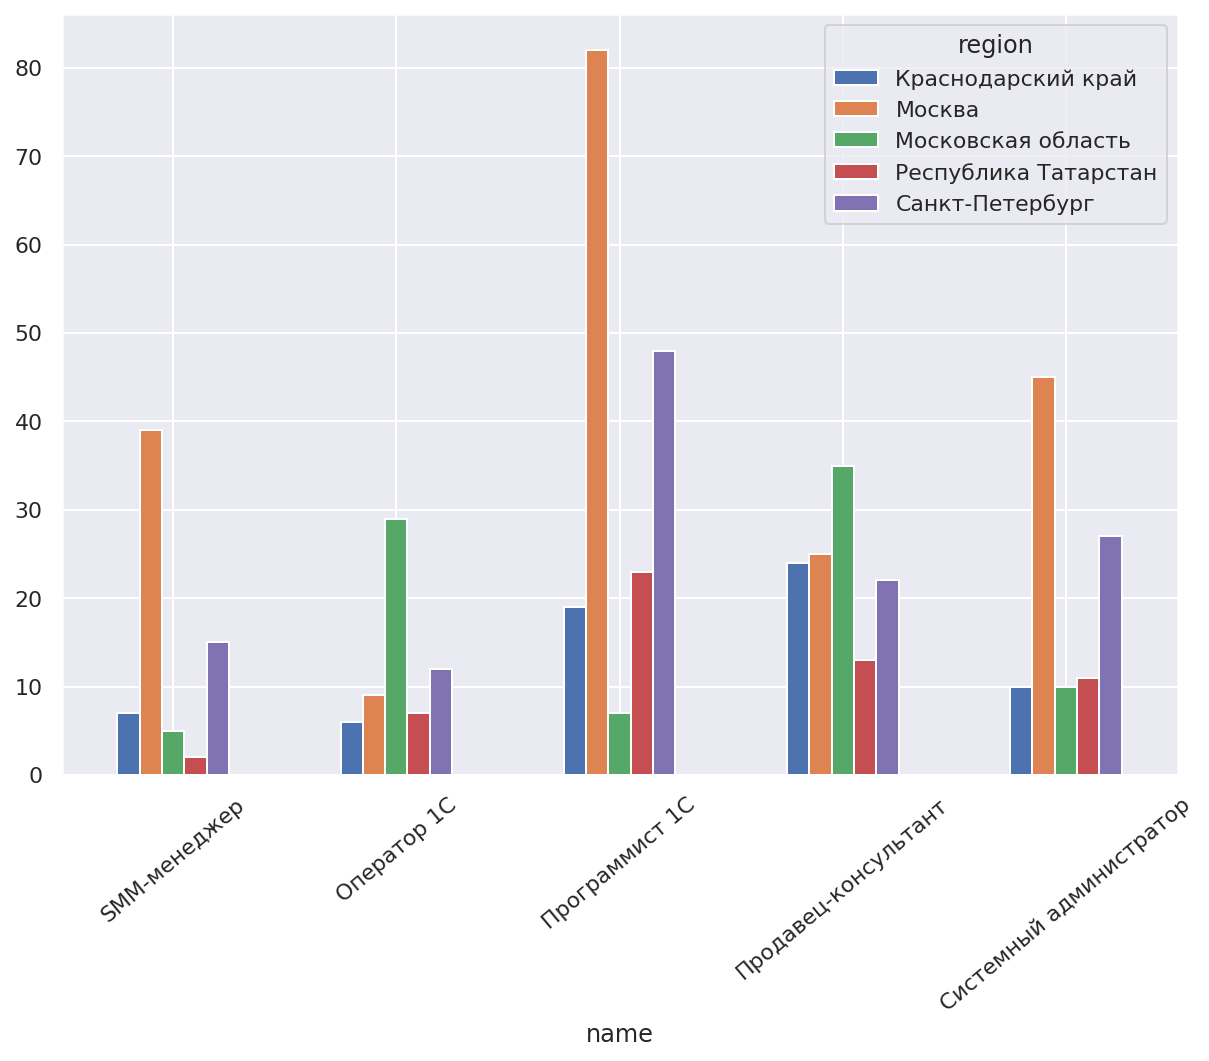

In [ ]:
df_crosstab.plot.bar(figsize=(10,7), rot = 40)

In [ ]:
chi2, prob, df, expected = scipy.stats.chi2_contingency(df_crosstab)
output = "test Statistics: {}\ndegrees of freedom: {}\np-value: {}\n"
 
print(output.format( chi2, df, prob))

test Statistics: 114.5658189934765
degrees of freedom: 16
p-value: 6.047113149359298e-17



Смотря на результаты, можно сказать, что связь между вакансией и регионом сильная.

## Рассчитаем (спрогнозируем) заработную плату для программистов 1С, так как оказалось в развед.анализе что наибольшее количество вакансий именно по этой специальности

воспользуемся датасетом без выбросов, и отфильтруем его про Программистам 1С и стаж работы укажем "без опыта"

In [ ]:
dataset_programmist = dataset_bez_vybros[dataset_bez_vybros['name'] == "Программист 1С"]
dataset_programmist.count()

id                   517
name                 517
зарплата от          517
зарплата до          517
средняя зарплата     517
                    ... 
Требования           517
Обязанности          517
Описание вакансии    517
Опыт работы          517
Ключевые навыки      517
Length: 17, dtype: int64

по данному фильтру получили только 517 вакансий

переведём ключевые навыки в количество, т.е. просто подсчитаем их и запишем в столбец цифрами.

In [ ]:

# подсчитаем количество лидирующих ключевых навыков
res = dataset_programmist['Ключевые навыки']
s = Counter(''.join(res).split(','))
# сделаем сортировку и выведем ключевые навыков
prog_1C_nav = sorted(s.items(), key =  itemgetter(1), reverse = True)[:23]
prog_1C_nav = pd.DataFrame(prog_1C_nav, columns = ['Навык', 'количество'])
prog_1C_nav.head()

Навык  количество
0                    1С программирование         273
1                      1С: Предприятие 8         181
2                        1С: Бухгалтерия         112
3                    1С: Документооборот          96
4   1С: Зарплата и управление персоналом          95

убедимся, что мы правильно переделали ключевые навыки в количество

In [ ]:
dataset_programmist['Количество_навыков'] = dataset_programmist['Ключевые навыки'].str.count(' ') + 1

In [ ]:
dataset_programmist.head(5)

id            name  зарплата от  зарплата до  средняя зарплата  \
180  66542854  Программист 1С       230000       230000            230000   
196  67326640  Программист 1С       150000       180000            165000   
220  67344784  Программист 1С       100000       150000            125000   
449  66147186  Программист 1С       200000       250000            225000   
40   67130569  Программист 1С       140000       170000            155000   

                город           region тип вакансии дата публикации  \
180           Москва            Москва     Открытая      2022-07-01   
196           Москва            Москва     Открытая      2022-07-02   
220           Москва            Москва     Открытая      2022-06-29   
449           Москва            Москва     Открытая      2022-06-06   
40   Санкт-Петербург   Санкт-Петербург     Открытая      2022-07-02   

    время публикации Название работодателя     График работы  \
180         15:10:44             НОВОТРАНС       Полный день   
196         09:54:30               Русроял       Полный день   
220         15:24:20              Лантегра  Удаленная работа   
449         16:18:48              РостДжоб  Удаленная работа   
40          15:37:13       Невская Палитра       Полный день   

                                            Требования  \
180  Опыт работы от 3 лет. Хорошее знание БСП, СКД,...   
196  Опыт разработки (программирование, обычные и у...   
220  Приветствуются наличие сертификатов специалист...   
449  Практические знания в предметных областях: опе...   
40   Опыт программирования в среде 1С: Предприятие ...   

                                           Обязанности  \
180  Создание обменов с внешними базами <highlightt...   
196  Администрирование 1С-окружения. Учет лицензий,...   
220  Создание новых объектов, модулей, написание но...   
449  Работа с хранилищем конфигураций и обновление ...   
40   Обучение персонала компании работе с вновь соз...   

                                     Описание вакансии         Опыт работы  \
180  Обязанности:  Разработка нетиповой конфигураци...       От 3 до 6 лет   
196   Обязанности:  Разработка и сопровождение знач...       От 3 до 6 лет   
220  Обязанности:  Программирование, разработка в с...  От 1 года до 3 лет   
449  Крупный агропромышленный холдинг - ТОП-10 на р...  От 1 года до 3 лет   
40   Обязанности:  Программное сопровождение систем...       От 3 до 6 лет   

                                       Ключевые навыки  Количество_навыков  
180                              1С программирование,                    3  
196                                                                      1  
220                                                                      1  
449  1C: Финансы, Умение слушать, Работа в условиях...                  30  
40   1С: Предприятие 8, 1С программирование, 1C: Бу...                  15

In [ ]:
dataset_programmist['region'].value_counts().head(10)

Москва                   82
Санкт-Петербург          48
Красноярский край        29
Республика Татарстан     23
Свердловская область     22
Нижегородская область    21
Краснодарский край       19
Приморский край          19
Новосибирская область    18
Самарская область        16
Name: region, dtype: int64

давайте возьмём только пять регионов, и по ним продолжим работать

In [ ]:
dataset_programmist = dataset_programmist[(dataset_programmist['region'] =='Москва') | (dataset_programmist['region'] =='Санкт-Петербург') | (dataset_programmist['region'] =='Красноярский край')
                    |(dataset_programmist['region'] =='Республика Татарстан')|(dataset_programmist['region'] =='Свердловская область')]
dataset_programmist.count()

id                    204
name                  204
зарплата от           204
зарплата до           204
средняя зарплата      204
                     ... 
Обязанности           204
Описание вакансии     204
Опыт работы           204
Ключевые навыки       204
Количество_навыков    204
Length: 18, dtype: int64

у нас осталось только 204 вакансии.

## ВЛИЯНИЕ КАТЕГОРИАЛЬНЫХ ФАКТОРОВ. ONE HOT ENCODING. Dummy variables. Посмотрим вляет ли регион на заработную плату, и влияют ли количество ключевых навыков на среднюю зарплату.


оставим в датасете только те колонки, с которыми будем работать

In [ ]:
dataset_programmist_2 = dataset_programmist[['средняя зарплата', 'Количество_навыков', 'region']]

переведём регионы в бинарную систему

In [ ]:
dataset_programmist_2 = pd.concat((dataset_programmist_2,pd.get_dummies(dataset_programmist_2.region, prefix_sep='',)),1)
dataset_programmist_2.head()

средняя зарплата  Количество_навыков           region  Красноярский край  \
180            230000                   3           Москва                  0   
196            165000                   1           Москва                  0   
220            125000                   1           Москва                  0   
449            225000                  30           Москва                  0   
40             155000                  15  Санкт-Петербург                  0   

     Москва  Республика Татарстан  Санкт-Петербург  Свердловская область  
180       1                     0                0                     0  
196       1                     0                0                     0  
220       1                     0                0                     0  
449       1                     0                0                     0  
40        0                     0                1                     0

In [ ]:
dataset_programmist_2['средняя_зарплата'] = dataset_programmist_2['средняя зарплата']

для удобства перезапишем названия наших столбцов, так как при расчёте составные слова нельзя подавать для анализа

In [ ]:
dataset_programmist_2['Красноярск'] = dataset_programmist_2['Красноярский край']
dataset_programmist_2['Москва'] = dataset_programmist_2['Москва']
dataset_programmist_2['Татарстан'] = dataset_programmist_2['Республика Татарстан']
dataset_programmist_2['Петербург'] = dataset_programmist_2['Санкт-Петербург']
dataset_programmist_2['Свердловск'] = dataset_programmist_2['Свердловская область']


и проверим нормально ли распределены количество ключевых навыков, остальные колонки мы проверяли на нормальность распределения, все они оказались не нормально распределёнными, и отклоняли гипотезу, различия были статистически значимыми.

In [ ]:
stats.shapiro(dataset_programmist_2['Количество_навыков'])

ShapiroResult(statistic=0.8987391591072083, pvalue=1.5559110944085575e-10)

отклоняем гипотезу о нормальности распределения, значит работаем со всеми показателями как с не нормально распределенными.

In [ ]:
result = smf.ols('средняя_зарплата ~ Красноярск + Москва + Петербург + Свердловск', data=dataset_programmist_2).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       средняя_зарплата   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     25.30
Date:                Fri, 27 Jan 2023   Prob (F-statistic):           5.92e-17
Time:                        08:48:54   Log-Likelihood:                -2446.2
No. Observations:                 204   AIC:                             4902.
Df Residuals:                     199   BIC:                             4919.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.161e+05   8242.379     14.088      0.000    9.99e+04    1.32e+05
Красноярск -2.802e+04    1.1e+04     -2.538      0.012   -4.98e+04   -6252.074
Москва       5.17e+04   9326.964      5.543      0.000    3.33e+04    7.01e+04
Петербург   2.869e+04      1e+04      2.862      0.005    8924.477    4.85e+04
Свердловск  1.308e+04   1.18e+04      1.110      0.268   -1.02e+04    3.63e+04
==============================================================================
Omnibus:                        4.049   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.132   Jarque-Bera (JB):                3.434
Skew:                           0.223   Prob(JB):                        0.180
Kurtosis:                       2.547   Cond. No.                         7.90
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

фактор: количество навыков мы исключили из модели, так как pvalue выше уровня значимости, оставили только регионы коэффициент детерминации показывает на среднюю связь между регионами и заработной платой, попробуем ещё добавить факторы в нашу модель

In [ ]:
dataset_programmist_2.count()

средняя зарплата      204
Количество_навыков    204
region                204
Красноярский край     204
Москва                204
                     ... 
средняя_зарплата      204
Красноярск            204
Татарстан             204
Петербург             204
Свердловск            204
Length: 13, dtype: int64

In [ ]:
dataset_programmist_2['Опыт_работы'] = dataset_programmist['Опыт работы']

In [ ]:
dataset_programmist_2 = pd.concat((dataset_programmist_2,pd.get_dummies(dataset_programmist_2.Опыт_работы, prefix_sep='',)),1)
dataset_programmist_2.head()

средняя зарплата  Количество_навыков           region  Красноярский край  \
180            230000                   3           Москва                  0   
196            165000                   1           Москва                  0   
220            125000                   1           Москва                  0   
449            225000                  30           Москва                  0   
40             155000                  15  Санкт-Петербург                  0   

     Москва  Республика Татарстан  Санкт-Петербург  Свердловская область  \
180       1                     0                0                     0   
196       1                     0                0                     0   
220       1                     0                0                     0   
449       1                     0                0                     0   
40        0                     0                1                     0   

     средняя_зарплата  Красноярск  Татарстан  Петербург  Свердловск  \
180            230000           0          0          0           0   
196            165000           0          0          0           0   
220            125000           0          0          0           0   
449            225000           0          0          0           0   
40             155000           0          0          1           0   

            Опыт_работы  Более 6 лет  Нет опыта  От 1 года до 3 лет  \
180       От 3 до 6 лет            0          0                   0   
196       От 3 до 6 лет            0          0                   0   
220  От 1 года до 3 лет            0          0                   1   
449  От 1 года до 3 лет            0          0                   1   
40        От 3 до 6 лет            0          0                   0   

     От 3 до 6 лет  
180              1  
196              1  
220              0  
449              0  
40               1

In [ ]:
dataset_programmist_2['лет_6'] = dataset_programmist_2['Более 6 лет']
dataset_programmist_2['Нет_опыта'] = dataset_programmist_2['Нет опыта']
dataset_programmist_2['От_1_до_3'] = dataset_programmist_2['От 1 года до 3 лет']
dataset_programmist_2['От_3_до_6'] = dataset_programmist_2['От 3 до 6 лет']

In [ ]:
result_2 = smf.ols('средняя_зарплата ~ лет_6 + От_3_до_6+От_1_до_3+Красноярск + Москва + Петербург + Свердловск', data=dataset_programmist_2).fit()
result_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       средняя_зарплата   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     19.82
Date:                Fri, 27 Jan 2023   Prob (F-statistic):           5.64e-20
Time:                        08:48:54   Log-Likelihood:                -2433.6
No. Observations:                 204   AIC:                             4883.
Df Residuals:                     196   BIC:                             4910.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8.176e+04   1.59e+04      5.134      0.000    5.04e+04    1.13e+05
лет_6       6.179e+04   2.36e+04      2.618      0.010    1.53e+04    1.08e+05
От_3_до_6   4.675e+04   1.48e+04      3.168      0.002    1.77e+04    7.59e+04
От_1_до_3   2.292e+04   1.48e+04      1.548      0.123   -6274.025    5.21e+04
Красноярск -2.151e+04   1.06e+04     -2.021      0.045   -4.25e+04    -523.808
Москва      4.908e+04   8854.440      5.543      0.000    3.16e+04    6.65e+04
Петербург   3.182e+04   9531.494      3.338      0.001     1.3e+04    5.06e+04
Свердловск  1.084e+04   1.12e+04      0.967      0.335   -1.13e+04     3.3e+04
==============================================================================
Omnibus:                        0.785   Durbin-Watson:                   2.142
Prob(Omnibus):                  0.675   Jarque-Bera (JB):                0.860
Skew:                           0.144   Prob(JB):                        0.651
Kurtosis:                       2.864   Cond. No.                         15.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**мы провели анализ и дополнительно включили в нашу модель опыт работы, pvalue показал, что он важен в модели. В факторах, влияющих на среднюю заработную плату оставили опыт работы и регионы, детерминация возросла и составила 41,5%. На этом не остановимся, попробуем ещё включить дополнительные факторы такие как график работы**

In [ ]:
dataset_programmist['График работы'].value_counts()

Полный день         142
Удаленная работа     54
Гибкий график         8
Name: График работы, dtype: int64

In [ ]:
dataset_programmist_2['График_работы'] = dataset_programmist['График работы']

In [ ]:
dataset_programmist_2 = pd.concat((dataset_programmist_2,pd.get_dummies(dataset_programmist_2.График_работы, prefix_sep='',)),1)
dataset_programmist_2['Полный'] = dataset_programmist_2['Полный день']
dataset_programmist_2['Удаленная'] = dataset_programmist_2['Удаленная работа']
dataset_programmist_2['Гибкий'] = dataset_programmist_2['Гибкий график']

In [ ]:
results_3 = smf.ols('средняя_зарплата ~ Полный +  Гибкий', data=dataset_programmist_2).fit()
results_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       средняя_зарплата   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.5058
Date:                Fri, 27 Jan 2023   Prob (F-statistic):              0.604
Time:                        08:48:54   Log-Likelihood:                -2487.7
No. Observations:                 204   AIC:                             4981.
Df Residuals:                     201   BIC:                             4991.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.368e+05   6557.446     20.869      0.000    1.24e+05     1.5e+05
Полный      6383.6974   7704.041      0.829      0.408   -8807.413    2.16e+04
Гибкий     -5282.3519   1.83e+04     -0.289      0.773   -4.13e+04    3.07e+04
==============================================================================
Omnibus:                       25.607   Durbin-Watson:                   1.339
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.773
Skew:                           0.115   Prob(JB):                       0.0205
Kurtosis:                       2.072   Cond. No.                         6.91
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

График работы не значим в модели, поэтому его не включаем в модель

In [ ]:
results_4 = smf.ols('средняя_зарплата ~ Гибкий+лет_6 + От_3_до_6+Красноярск + Москва + Петербург + Свердловск', data=dataset_programmist_2).fit()
results_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       средняя_зарплата   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     19.84
Date:                Fri, 27 Jan 2023   Prob (F-statistic):           5.47e-20
Time:                        08:48:54   Log-Likelihood:                -2433.5
No. Observations:                 204   AIC:                             4883.
Df Residuals:                     196   BIC:                             4910.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.031e+05   8319.646     12.391      0.000    8.67e+04     1.2e+05
Гибкий      -2.28e+04   1.45e+04     -1.568      0.118   -5.15e+04    5871.099
лет_6       5.075e+04   2.03e+04      2.503      0.013    1.08e+04    9.07e+04
От_3_до_6   2.497e+04   5526.701      4.518      0.000    1.41e+04    3.59e+04
Красноярск -1.937e+04   1.06e+04     -1.827      0.069   -4.03e+04    1535.987
Москва      5.026e+04   8884.949      5.657      0.000    3.27e+04    6.78e+04
Петербург    3.13e+04   9530.862      3.284      0.001    1.25e+04    5.01e+04
Свердловск  1.339e+04   1.12e+04      1.191      0.235   -8775.182    3.56e+04
==============================================================================
Omnibus:                        1.394   Durbin-Watson:                   2.145
Prob(Omnibus):                  0.498   Jarque-Bera (JB):                1.490
Skew:                           0.176   Prob(JB):                        0.475
Kurtosis:                       2.772   Cond. No.                         10.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

оставляем так

просто посмотрели

In [ ]:
x_1 = dataset_programmist_2[['лет_6','От_3_до_6','От_1_до_3','Красноярск','Москва','Петербург','Свердловск']]
LR_1 = lm.LinearRegression()
modd = LR_1.fit(x_1,dataset_programmist_2[['средняя_зарплата']])
modd.intercept_, modd.coef_

(array([81759.68979412]),
 array([[ 61787.38630147,  46754.59454645,  22923.70001777,
         -21510.47143852,  49078.461287  ,  31815.59586005,
          10839.1771836 ]]))

In [ ]:
modd.score(x_1,dataset_programmist_2[['средняя_зарплата']])

0.41452000944936884

Вывод: мы предсказали зарплату в 81760 руб., возможно есть и другие не учтённые факторы, так как нам получилось получить только детерминацию в 41,5%.

# **СТАТИСТИЧЕСКИЙ АНАЛИЗ ДАННЫХ ПО КУРСАМ СО STEPIC.ORG, SKILLBOX.RU И OBRAZOVAL.RU**

## stepic.org 
Загрузим датасеты

для статистического анализа возьмём датасет по stepic.org отфильтрованного только по цене и очищенного от выбросов, с ним и будем работать и паралельно интересно будет посмотреть на второй датасет в котором как оказалось самые популярные , **но** бесплатные курсы.

In [ ]:
df_stepic_price = dataset_stepic_price_b_v[dataset_stepic_price_b_v['learners_count']<35000]
df_stepic_price = df_stepic_price[['title', 'price','is_certificate_issued', 'learners_count', 'certificates_count', 'lessons_count', 'quizzes_count', 'challenges_count']]
df_stepic_price.head(5)

title   price  \
id                                                                 
15001                                      Atomic Kotlin  2000.0   
23981                      Алгоритмы поиска и сортировки  3990.0   
27933  Инстаграм Реалити - продвижение и заработок в ...   190.0   
28995  Искусство аддитивных технологий (3D-печать/3D-...   350.0   
51112   Интерактивный учебник по программированию на C++   490.0   

       is_certificate_issued  learners_count  certificates_count  \
id                                                                 
15001                      0             332                   0   
23981                      0             185                  62   
27933                      0            7445                   0   
28995                      0             842                  93   
51112                      1             555                  20   

       lessons_count  quizzes_count  challenges_count  
id                                                     
15001             89              0                 0  
23981             27            151                49  
27933             21             11                 0  
28995             30            107                 0  
51112             48             75               490

создаём второй датасет, с самыми популярными и бесплатными курсами, ориентируясь на размерность датасета с платными курсами, чтобы количество курсов было равно.

In [ ]:
df_stepic_not_price = dataset_stepic[(dataset_stepic['price'].isnull()) & (dataset_stepic['learners_count']<50000)& (dataset_stepic['learners_count']>5000)]
df_stepic_not_price = df_stepic_not_price[['title', 'price', 'is_certificate_issued','learners_count', 'certificates_count', 'lessons_count', 'quizzes_count', 'challenges_count']]
df_stepic_not_price['price'] = df_stepic_not_price['price'].fillna(0)
df_stepic_not_price.head(5)

title  price  is_certificate_issued  \
id                                                                        
5                    Python for Beginners    0.0                      0   
10                 Python for Programmers    0.0                      0   
47         Core Concepts in Data Analysis    0.0                      0   
61              Bioinformatics Algorithms    0.0                      0   
104  Введение в теоретическую информатику    0.0                      1   

     learners_count  certificates_count  lessons_count  quizzes_count  \
id                                                                      
5              6931                   0              6             15   
10             5934                   0              8             11   
47            12004                   0              7              0   
61            13012                   0            118             43   
104           19151                 246             86            111   

     challenges_count  
id                     
5                   5  
10                  4  
47                  7  
61                 79  
104               118

рассчитаем количество курсов, среднее значение, стандартное отклонение, максимальное и минимальное значения, процентили

In [ ]:
df_stepic_price[['title', 'price','learners_count', 'certificates_count', 'lessons_count', 'quizzes_count', 'challenges_count']].describe()

price  learners_count  certificates_count  lessons_count  \
count   100.000000      100.000000          100.000000     100.000000   
mean   1968.530000      539.430000           58.810000      58.230000   
std    1482.950556     1308.547558          157.096489      54.046903   
min     149.000000        1.000000            0.000000       8.000000   
25%     836.500000       18.750000            0.000000      18.750000   
50%    1495.000000      115.000000            4.500000      38.500000   
75%    2900.000000      406.000000           57.750000      75.500000   
max    5990.000000     9593.000000         1265.000000     214.000000   

       quizzes_count  challenges_count  
count     100.000000        100.000000  
mean       59.280000         29.270000  
std       101.268528         70.694799  
min         0.000000          0.000000  
25%         9.000000          0.000000  
50%        32.000000          0.000000  
75%        73.500000         22.250000  
max       804.000000        490.000000

In [ ]:
df_stepic_not_price[['title', 'price','learners_count', 'certificates_count', 'lessons_count', 'quizzes_count', 'challenges_count']].describe()

price  learners_count  certificates_count  lessons_count  \
count  102.0      102.000000          102.000000     102.000000   
mean     0.0    16563.549020         1059.254902      39.245098   
std      0.0    10187.700765         1756.156141      60.480819   
min      0.0     5090.000000            0.000000       6.000000   
25%      0.0     8487.250000            0.000000      15.000000   
50%      0.0    12937.500000          124.000000      24.500000   
75%      0.0    22461.750000         1605.000000      35.750000   
max      0.0    45880.000000         9790.000000     382.000000   

       quizzes_count  challenges_count  
count     102.000000        102.000000  
mean       66.137255         39.460784  
std        71.037577         77.253430  
min         0.000000          0.000000  
25%        23.250000          0.000000  
50%        41.500000         13.000000  
75%        87.250000         35.000000  
max       459.000000        446.000000

## Проверка нормальности по критерию Шапиро-Уилка

In [ ]:
print('price:', stats.shapiro(df_stepic_price['price']))
print('learners_count', stats.shapiro(df_stepic_price['learners_count']))
print('certificates_count:', stats.shapiro(df_stepic_price['certificates_count']))
print('lessons_count:', stats.shapiro(df_stepic_price['lessons_count']))
print('quizzes_count:', stats.shapiro(df_stepic_price['quizzes_count']))
print('challenges_count:', stats.shapiro(df_stepic_price['challenges_count']))

price: ShapiroResult(statistic=0.8951908349990845, pvalue=8.45792214931862e-07)
learners_count ShapiroResult(statistic=0.41745245456695557, pvalue=4.263532068198395e-18)
certificates_count: ShapiroResult(statistic=0.39867597818374634, pvalue=2.304800224126409e-18)
lessons_count: ShapiroResult(statistic=0.7928621768951416, pvalue=1.503567131910799e-10)
quizzes_count: ShapiroResult(statistic=0.5409299731254578, pvalue=3.696959207492731e-16)
challenges_count: ShapiroResult(statistic=0.4678032398223877, pvalue=2.395193942439775e-17)


pvalue по датесету с ценами во всех столбцах оказался ниже уровня значимости (принятого по умолчанию 0,05), значит мы отклоняем нулевую гипотезу о нормальности распределения и далее работаем с ней, как с не нормально распределённой.

In [ ]:

print('learners_count', stats.shapiro(df_stepic_not_price['learners_count']))
print('certificates_count:', stats.shapiro(df_stepic_not_price['certificates_count']))
print('lessons_count:', stats.shapiro(df_stepic_not_price['lessons_count']))
print('quizzes_count:', stats.shapiro(df_stepic_not_price['quizzes_count']))
print('challenges_count:', stats.shapiro(df_stepic_not_price['challenges_count']))

learners_count ShapiroResult(statistic=0.8876734375953674, pvalue=3.1317441084866005e-07)
certificates_count: ShapiroResult(statistic=0.6687595844268799, pvalue=7.649392593954071e-14)
lessons_count: ShapiroResult(statistic=0.4399287700653076, pvalue=6.105031739956304e-18)
quizzes_count: ShapiroResult(statistic=0.7528756260871887, pvalue=8.255807495971546e-12)
challenges_count: ShapiroResult(statistic=0.553870677947998, pvalue=4.2840840653489897e-16)


pvalue по датесету без цен во всех столбцах оказался ниже уровня значимости (принятого по умолчанию 0,05), значит мы отклоняем нулевую гипотезу о нормальности распределения и далее работаем с ней, как с не нормально распределённой.

## Гипотеза 𝐻0 на стоимость курса не влияют многие факторы, такие как выдача сертификата, количество учащихся, количество выданных сертификатов, состав курса(количество уроков, тестов и задач

Гипотеза 𝐻1:на стоимость курса влияют многие факторы, такие как выдача сертификата, количество учащихся, количество выданных сертификатов, состав курса(количество уроков, тестов и задач

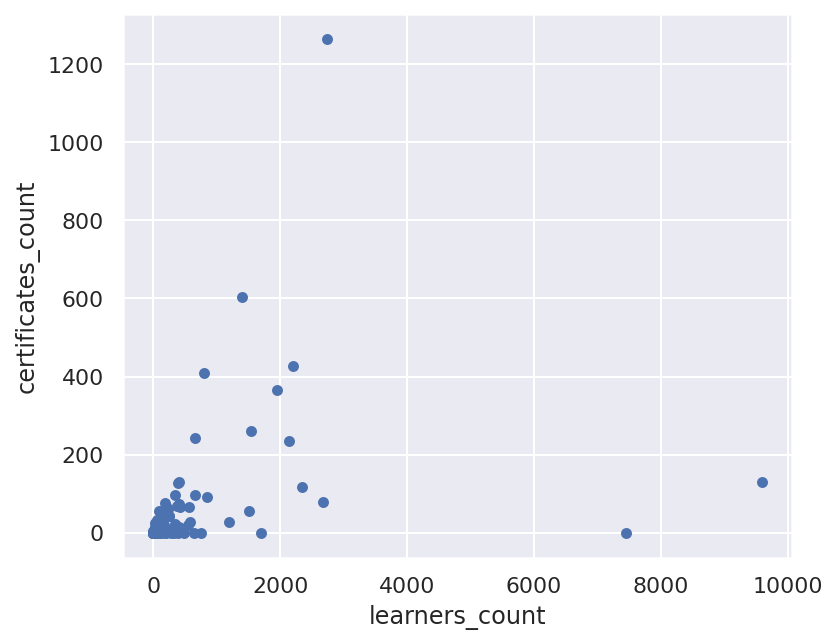

In [ ]:
df_stepic_price.plot('learners_count','certificates_count',kind="scatter", figsize = (6,5))
plt.show()

корреляция очень слабая

In [ ]:
# sns.jointplot('certificates_count','learners_count',  data=df_stepic_price, kind="reg")

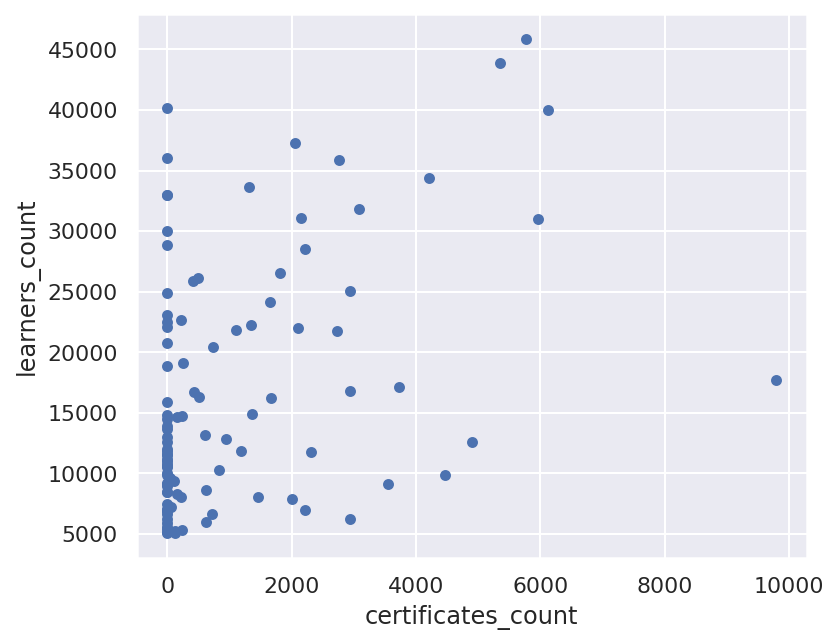

In [ ]:
df_stepic_not_price.plot('certificates_count','learners_count',kind="scatter", figsize = (6,5))
plt.show()

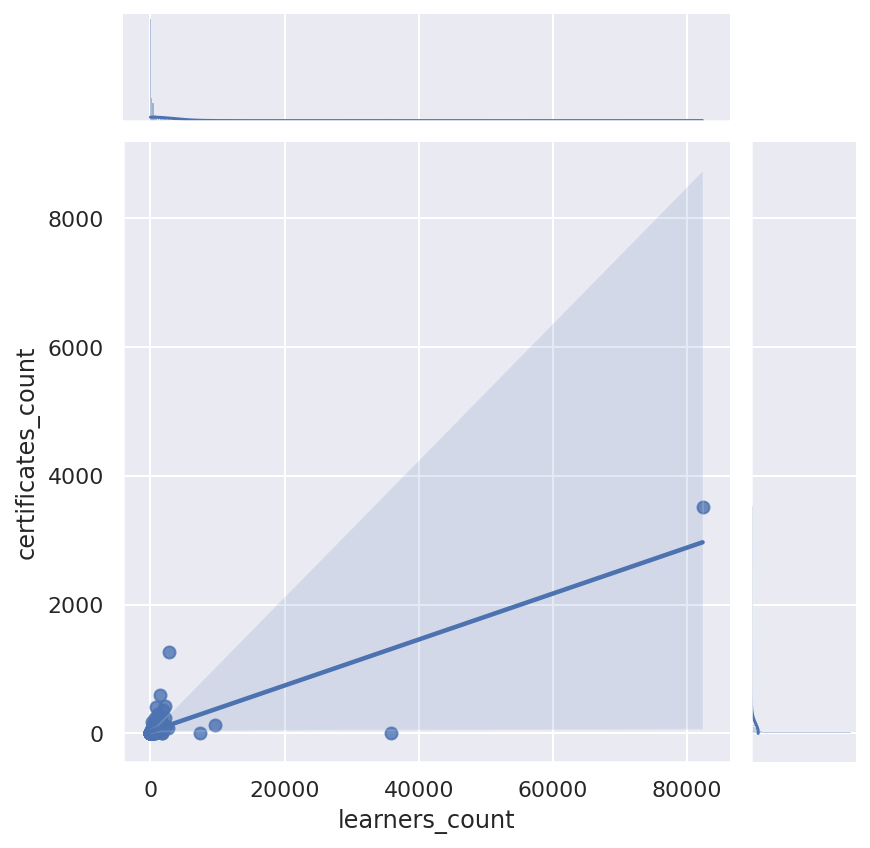

In [ ]:
sns.jointplot('learners_count', 'certificates_count', data=dataset_stepic_price, kind="reg")
plt.show()

## Множественная регрессия 

In [ ]:
X=dataset_stepic_price[['learners_count','certificates_count','lessons_count','quizzes_count',	'challenges_count']]

In [ ]:
LR = lm.LinearRegression()
mod_3 = LR.fit(X,dataset_stepic_price[['price']])

In [ ]:
mod_3.intercept_, mod_3.coef_

(array([4331.99564218]),
 array([[-0.07225188,  0.63072841,  4.11259768,  5.55275678, -2.2844056 ]]))

In [ ]:
mod_3.score(X,dataset_stepic_price[['price']])

0.006262296742211015

очень слабая кореляция, влияния факторов на цену, удалим не значимые факторы

In [ ]:
x1 = [[15000,1500,80,50,40]]
print("Прогноз цены: ",mod_3.predict(x1).round(2))

Прогноз цены:  [[4709.58]]


Проведём множественную регрессию (OLS), чтобы посмотреть влияние факторов на цену

In [ ]:
result1 = smf.ols('price ~ certificates_count+lessons_count+learners_count+quizzes_count+challenges_count', data=dataset_stepic_price).fit()
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.037
Method:                 Least Squares   F-statistic:                    0.1462
Date:                Fri, 27 Jan 2023   Prob (F-statistic):              0.981
Time:                        08:48:58   Log-Likelihood:                -1284.8
No. Observations:                 122   AIC:                             2582.
Df Residuals:                     116   BIC:                             2598.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           4331.9956   1385.699      3.126      0.002    1587.444    7076.547
certificates_count     0.6307      4.589      0.137      0.891      -8.459       9.720
lessons_count          4.1126     17.440      0.236      0.814     -30.429      38.655
learners_count        -0.0723      0.191     -0.378      0.706      -0.451       0.306
quizzes_count          5.5528      8.749      0.635      0.527     -11.775      22.880
challenges_count      -2.2844     11.840     -0.193      0.847     -25.735      21.166
==============================================================================
Omnibus:                      139.306   Durbin-Watson:                   1.694
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2360.111
Skew:                           4.231   Prob(JB):                         0.00
Kurtosis:                      22.816   Cond. No.                     1.36e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.36e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

В итоге мы получили, что факторы, такие как выдача сертификата, количество учащихся, количество выданных сертификатов, состав курса(количество уроков, тестов и задач) не влияют на стоимость курса, значит принимает нулевую гипотезу о не значимости этих факторов на цену, связь очень слабая. Модель для расчёта стоимости у нас получилась, но она не точная, так как мы не нашли влияющие факторы. Как мы до этого видели, курсы бесплатные намного популярнее, чем платные, процент получения сертификатов в бесплатных ниже, чем в платных. Но также мы в разведочном анализе увидели, что и платные курсы не менее популярные, и человек готов платить деньги за знания 

In [ ]:
result2 = smf.ols('learners_count ~ certificates_count', data=dataset_stepic_price).fit()
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         learners_count   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     284.2
Date:                Fri, 27 Jan 2023   Prob (F-statistic):           1.96e-33
Time:                        08:48:58   Log-Likelihood:                -1197.0
No. Observations:                 122   AIC:                             2398.
Df Residuals:                     120   BIC:                             2404.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -169.8248    414.113     -0.410      0.682    -989.740     650.090
certificates_count    19.6960      1.168     16.858      0.000      17.383      22.009
==============================================================================
Omnibus:                      138.841   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8114.680
Skew:                           3.515   Prob(JB):                         0.00
Kurtosis:                      42.331   Cond. No.                         364.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Здесь мы просто увидели, что на количество учащихся влияет количество полученных сертификатов. Популярные и бесплатные курсы, да ещё с выдачей сертификатов пользуются популярностью 

In [ ]:
result3 = smf.ols('certificates_count ~ learners_count+challenges_count', data=dataset_stepic_price).fit()
result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     certificates_count   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     148.0
Date:                Fri, 27 Jan 2023   Prob (F-statistic):           5.27e-33
Time:                        08:48:58   Log-Likelihood:                -809.77
No. Observations:                 122   AIC:                             1626.
Df Residuals:                     119   BIC:                             1634.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           17.2677     18.346      0.941      0.349     -19.060      53.595
learners_count       0.0350      0.002     16.538      0.000       0.031       0.039
challenges_count     0.4284      0.209      2.050      0.043       0.015       0.842
==============================================================================
Omnibus:                       62.467   Durbin-Watson:                   1.834
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3220.912
Skew:                          -0.733   Prob(JB):                         0.00
Kurtosis:                      28.129   Cond. No.                     8.92e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.92e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

проверили что количество выданных сертификатов связано с количеством учащихся и количеством задач включённых в курс, люди смотрят на состав курса, им нужна практика.

## Skillbox

In [ ]:
dataset_skillbox_analiz = dataset_skillbox[['название', 'цена', 'срок обучения в месяцах', 'стоимость курса', 'гарантия трудоустройства' ]]
dataset_skillbox_analiz.head(5)

название  цена  срок обучения в месяцах  стоимость курса  \
0    Python-разработчик  5987                       12            71844   
1  Графический дизайнер  4814                       24           115536   
2       Бизнес-аналитик  4625                       13            60125   
3        3D-дженералист  6287                       24           150888   
4      Режиссёр монтажа  7859                       12            94308   

   гарантия трудоустройства  
0                         1  
1                         0  
2                         1  
3                         0  
4                         0

разделим на две группы датасет с гарантией трудоустройства и без неё и посмотрим как в них отличаются цены и сроки обучения

In [ ]:
df_1 = dataset_skillbox_analiz[dataset_skillbox_analiz['гарантия трудоустройства']==1]
df_0 = dataset_skillbox_analiz[dataset_skillbox_analiz['гарантия трудоустройства']==0]

In [ ]:
round(df_1[['цена'	,'срок обучения в месяцах',	'стоимость курса']].describe(),2)

цена  срок обучения в месяцах  стоимость курса
count    83.00                    83.00            83.00
mean   5074.86                    14.12         73709.81
std     954.96                     5.32         37055.95
min    2427.00                     6.00         23984.00
25%    4561.50                    12.00         47460.00
50%    4983.00                    12.00         60125.00
75%    5714.50                    16.50         87022.00
max    7387.00                    24.00        177288.00

##Анализ влияния количественных признаков

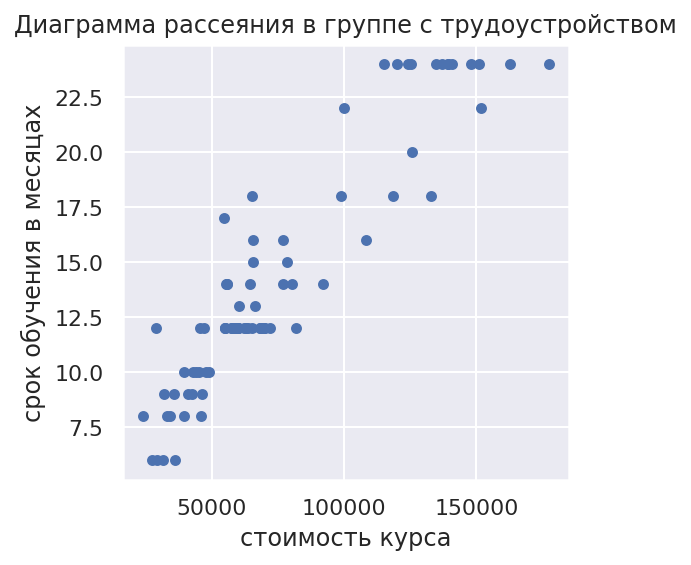

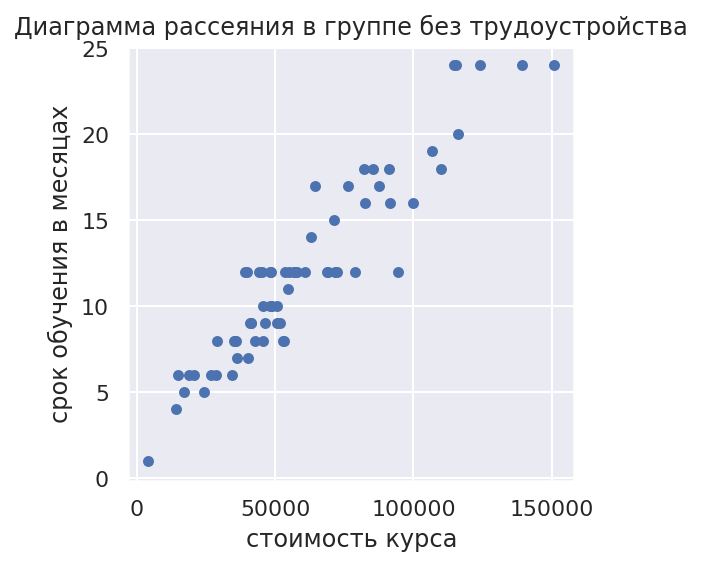

In [ ]:
df_1.plot('стоимость курса','срок обучения в месяцах',kind="scatter", figsize = (4,4), title = 'Диаграмма рассеяния в группе с трудоустройством')
df_0.plot('стоимость курса','срок обучения в месяцах',kind="scatter", figsize = (4,4), title = 'Диаграмма рассеяния в группе без трудоустройства')
plt.show()

видна очень хорошая связь между сроком обучения и ценой за курс

## Гипотеза 𝐻0: срок обучения не влияет на стоимость курса

Гипотеза 𝐻1: срок обучения влияет на стоимость курса

In [ ]:
print('цена:', stats.shapiro(dataset_skillbox_analiz['цена']))
print('срок обучения в месяцах', stats.shapiro(dataset_skillbox_analiz['срок обучения в месяцах']))
print('стоимость курса:', stats.shapiro(dataset_skillbox_analiz['стоимость курса']))
print('гарантия трудоустройства:', stats.shapiro(dataset_skillbox_analiz['гарантия трудоустройства']))

цена: ShapiroResult(statistic=0.9891708493232727, pvalue=0.2911164164543152)
срок обучения в месяцах ShapiroResult(statistic=0.9079605937004089, pvalue=3.2417954543007e-08)
стоимость курса: ShapiroResult(statistic=0.9106597900390625, pvalue=4.714506829373022e-08)
гарантия трудоустройства: ShapiroResult(statistic=0.63331139087677, pvalue=6.662692093521178e-18)


pvalue  в цене имеет значение больше уровня значимости, а все остальные меньше, значит цена имеет нормальное распределение а все остальные показатели не нормально распределены. Посчитаем для них корреляцию

In [ ]:
df_1[['стоимость курса', 'срок обучения в месяцах']].corr()

стоимость курса  срок обучения в месяцах
стоимость курса                 1.000000                 0.929058
срок обучения в месяцах         0.929058                 1.000000

In [ ]:
df_0[['стоимость курса', 'срок обучения в месяцах']].corr()

стоимость курса  срок обучения в месяцах
стоимость курса                 1.000000                 0.938772
срок обучения в месяцах         0.938772                 1.000000

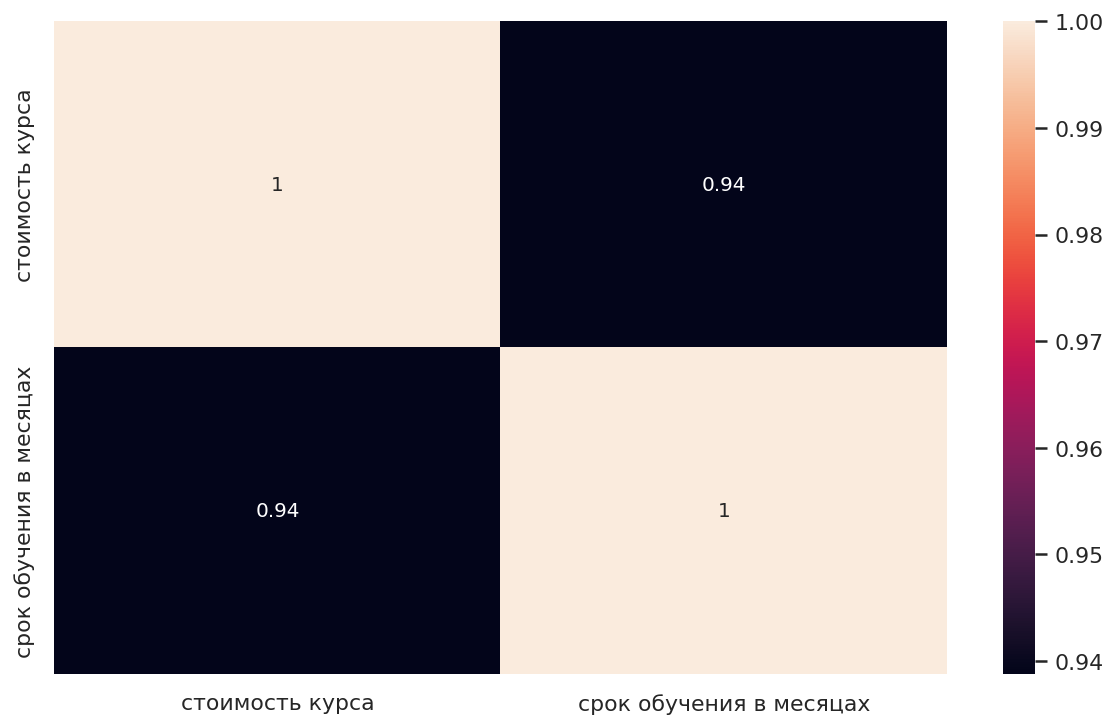

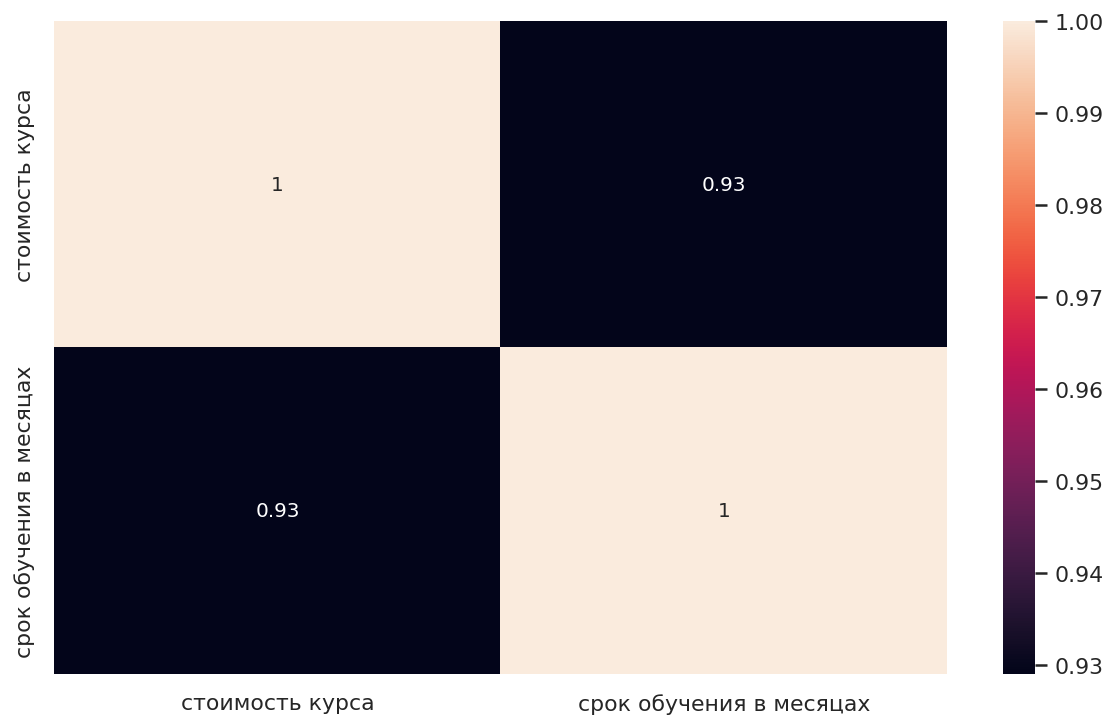

In [ ]:
num = ['стоимость курса', 'срок обучения в месяцах']
hm = sns.heatmap(df_0[num].corr(),annot=True)
plt.show()
hm = sns.heatmap(df_1[num].corr(),annot=True)
plt.show()

оценим их по критерию Манна-Уитни

In [ ]:
scipy.stats.mannwhitneyu(df_1['стоимость курса'],df_1['срок обучения в месяцах'])

MannwhitneyuResult(statistic=6889.0, pvalue=6.885790026138833e-29)

In [ ]:
scipy.stats.mannwhitneyu(df_0['стоимость курса'],df_0['срок обучения в месяцах'])


MannwhitneyuResult(statistic=4761.0, pvalue=3.3038062820111562e-24)

In [ ]:
scipy.stats.mannwhitneyu(dataset_skillbox_analiz['цена'],dataset_skillbox_analiz['срок обучения в месяцах'])

MannwhitneyuResult(statistic=23104.0, pvalue=1.486947359683852e-51)

Вывод: у нас было две выборки с гарантией трудоустройства и без гарантии трудоустройства, данные в них были количественные и не нормально распределены, поэтому мы использовали критерий Манна-Уитни, который показал, что срок обучения сильно влияет на стоимость курса, нулевую гипотезу о том, что срок обучения не влияет на стоимость курса, отклоняем. 

**Парная регрессия (OLS). Классический подход.**

In [ ]:
df_1['срок_обучения_в_месяцах'] = df_1['срок обучения в месяцах']
df_1['стоимость_курса'] = df_1['стоимость курса']
df_0['срок_обучения_в_месяцах'] = df_0['срок обучения в месяцах']
df_0['стоимость_курса'] = df_0['стоимость курса']

In [ ]:
LR = lm.LinearRegression()
mod1 = LR.fit(df_1[['срок_обучения_в_месяцах']],df_1[['стоимость_курса']])
mod1.intercept_, mod1.coef_

(array([-17667.56900938]), array([[6471.26469947]]))

In [ ]:
LR = lm.LinearRegression()
mod5 = LR.fit(df_0[['срок_обучения_в_месяцах']],df_0[['стоимость_курса']])
mod5.intercept_, mod5.coef_

(array([-6446.95948894]), array([[5561.45091929]]))

In [ ]:
results1 = smf.ols('стоимость_курса~ срок_обучения_в_месяцах', data=df_1).fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        стоимость_курса   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     510.9
Date:                Fri, 27 Jan 2023   Prob (F-statistic):           9.90e-37
Time:                        08:49:00   Log-Likelihood:                -907.91
No. Observations:                  83   AIC:                             1820.
Df Residuals:                      81   BIC:                             1825.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -1.767e+04   4316.941     -4.093      0.000   -2.63e+04   -9078.210
срок_обучения_в_месяцах  6471.2647    286.305     22.603      0.000    5901.607    7040.922
==============================================================================
Omnibus:                        3.197   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.202   Jarque-Bera (JB):                3.248
Skew:                          -0.000   Prob(JB):                        0.197
Kurtosis:                       3.969   Cond. No.                         43.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
results2 = smf.ols('стоимость_курса ~ срок_обучения_в_месяцах', data=df_0).fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        стоимость_курса   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     497.4
Date:                Fri, 27 Jan 2023   Prob (F-statistic):           1.02e-32
Time:                        08:49:00   Log-Likelihood:                -737.43
No. Observations:                  69   AIC:                             1479.
Df Residuals:                      67   BIC:                             1483.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -6446.9595   3237.242     -1.991      0.051   -1.29e+04      14.602
срок_обучения_в_месяцах  5561.4509    249.361     22.303      0.000    5063.724    6059.178
==============================================================================
Omnibus:                        3.786   Durbin-Watson:                   1.537
Prob(Omnibus):                  0.151   Jarque-Bera (JB):                2.923
Skew:                           0.404   Prob(JB):                        0.232
Kurtosis:                       3.603   Cond. No.                         32.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Вывод:** в построенных моделях регрессии мы получили распределение остатков, которое не отвечает нормальному распределению (об этом нам говорит Prob(JB), коэффициенты эксцесса и ассиметрии), поэтому модели хоть и статистически значимы, но не адекватны, a значит мы не можем прогнозировать цену по этой модели

**Применим парную регрессию к цене за месяц**

In [ ]:
dataset_skillbox_analiz['срок_обучения_в_месяцах'] = dataset_skillbox_analiz['срок обучения в месяцах']

In [ ]:
LR = lm.LinearRegression()
model = LR.fit(dataset_skillbox_analiz[['срок_обучения_в_месяцах']],dataset_skillbox_analiz[['цена']])
model.intercept_, model.coef_

(array([4159.89562051]), array([[63.88252167]]))

In [ ]:
x = [[2],[4],[6],[12],[18],[24]]
print("Прогноз цены: ", model.predict(x).round())

Прогноз цены:  [[4288.]
 [4415.]
 [4543.]
 [4926.]
 [5310.]
 [5693.]]


получили следующие результаты:


обучение в месяцах |прогноз в месяц|стоимость курса
---------------    | ----------    |---------------|
**2**              |      **4 288**|      **8 576**|
**4**              |      **4 415**|     **17 660**|
**6**              |      **4 543**|     **27 258**|
**12**             |      **4 926**|     **59 112**|
**18**             |      **5 310**|     **95 580**|
**24**             |      **5 693**|    **136 632**|

## Статистический анализ курсов с сайта obrazoval.ru

In [ ]:
dataset_obrazoval = pd.read_excel('obrazoval.xlsx')

In [ ]:
dataset_obrazoval.head(5)

название     цена срок_обучения  \
0                           Основы Курс Data Science  125 000    5 месяцев,   
1                       Java Developer. Professional  121 680    6 месяцев,   
2                 Основы разработки интернет-проекта        0       3ч 49м,   
3                                 Встроенные системы        0    12 недель,   
4  Специалист по техническому обслуживанию и ремо...   37 490     48 ак.ч.,   

   срок_обучения_мес  срок_в_месяцах срок_по_группам начало_обучения  \
0                  5            5.00   от 4 до 6 мес      1975-03-01   
1                  6            6.00   от 4 до 6 мес      1979-04-01   
2                  0            0.01      меньше мес      2017-04-01   
3                  2            2.00   от 1 до 3 мес      1900-01-02   
4                  0            0.07      меньше мес      1996-03-01   

              школа                                             навыки  
0      sf-education                                       Data Science  
1              otus  Java, Hibernate, Gradle, Spring, Lombok, Slack...  
2       loft-school                  Этапы разработки интернет-проекта  
3  universitet-itmo                                                C++  
4        specialist  Архитектура современного ПК, Принципы работы а...

в данных есть два столбца со сроком обучения, один во float другой в int

In [ ]:
dataset_obrazoval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   название           958 non-null    object        
 1   цена               958 non-null    object        
 2   срок_обучения      958 non-null    object        
 3   срок_обучения_мес  958 non-null    int64         
 4   срок_в_месяцах     958 non-null    float64       
 5   срок_по_группам    958 non-null    object        
 6   начало_обучения    958 non-null    datetime64[ns]
 7   школа              958 non-null    object        
 8   навыки             925 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 67.5+ KB


так как разведочный анализ по этим данным не делался, я здесь выведу популярные навыки, и построю для них график, для наглядности

In [2]:
v = 0

In [ ]:
c = Counter(''.join(v).split(','))
skills = sorted(c.items(), key =  itemgetter(1), reverse = True)
skills = pd.DataFrame(skills, columns = ['Навык', 'количество'])
skills = skills.head(20)
skills

Навык  количество
0     JavaScript         131
1         Python          98
2            SQL          91
3            Git          88
4            CSS          84
..           ...         ...
15   Базы данных          34
16                        33
17       Android          31
18    PostgreSQL          28
19       Node.js          28

[20 rows x 2 columns]

In [ ]:
skills['Навык'].tail(10)

10          Docker
11             PHP
12          GitHub
13              IT
14              C#
15     Базы данных
16                
17         Android
18      PostgreSQL
19         Node.js
Name: Навык, dtype: object

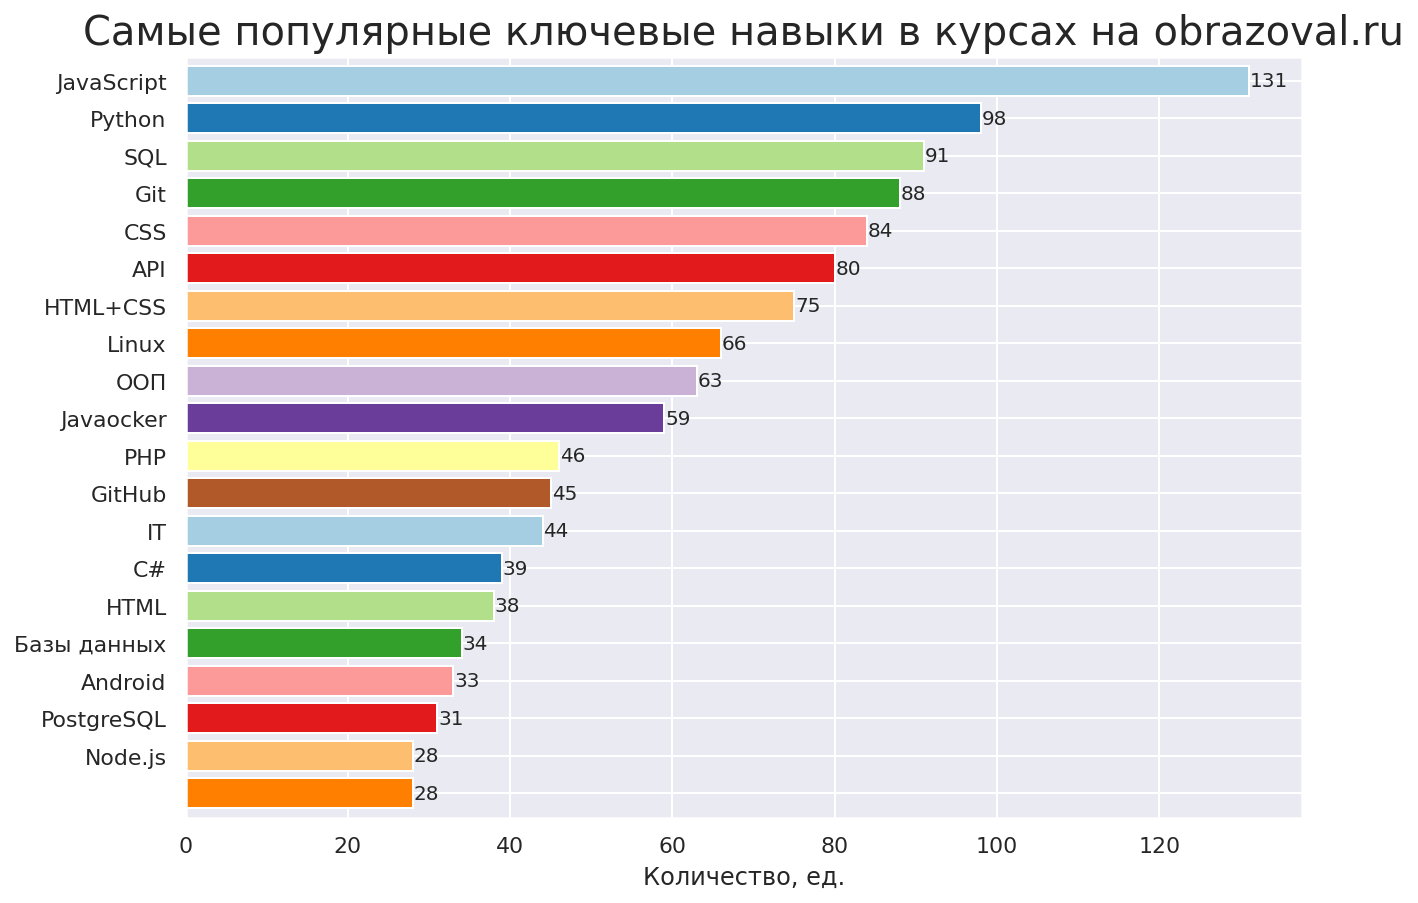

In [ ]:
from matplotlib.colors import get_named_colors_mapping
skills['количество'].plot(kind = 'barh', figsize =  (10, 7), color=plt.cm.Paired(np.arange(len(skills['количество'])))[:12],
                                width=0.8).invert_yaxis()
for y,x in enumerate(skills['количество']):
    plt.text(x+0.1,y,'%s' %round(x,1),va='center') # Здесь x находится спереди, y сзади, метка значения добавляется к x, а центр также центрируется по вертикали
# Отображение графики    
plt.title('Самые популярные ключевые навыки в курсах на obrazoval.ru',fontsize = 20)
plt.xlabel('Количество, ед.')

plt.yticks(range(20),['JavaScript','Python','SQL','Git','CSS','API','HTML+CSS','Linux','ООП','Javaocker','PHP','GitHub','IT','C#','HTML','Базы данных','Android','PostgreSQL','Node.js'])
plt.show()

## Гипотеза 𝐻0: срок обучения не влияет на стоимость курса

Гипотеза 𝐻1: срок обучения влияет на стоимость курса

In [ ]:
fig = px.scatter(x=dataset_obrazoval['срок_в_месяцах'], y=dataset_obrazoval['цена'],  
                 title="Распределение срока обучения и стоимости курсов", )
fig.show()

на графике видно, что самое часто встречается часовое обучение, цены на большом диапазоне, начиная с нуля, до 200 тыс.руб.. Также часто встречаются 3, 4, 5 месяцев и два года. Есть два выброса со сроком обучения в 30 месяцев, стоимостью 800 тыс.руб. и сроком на 48 тыс.руб. со стоимостью 1200 тыс.руб., их мы уберём из анализа. 

In [ ]:
dataset_obrazoval['срок_по_группам'].value_counts()

меньше мес         568
от 1 до 3 мес      133
от 4 до 6 мес      122
более 1 года        60
от 10 до 12 мес     58
от 7 до 9 мес       17
Name: срок_по_группам, dtype: int64

эти данные мы и увидели на графике. что преобладают на сайте obrazoval.ru  курсы с продолжительностью менее 1 месяца

In [ ]:
dataset_obrazoval[dataset_obrazoval['срок_в_месяцах']>25]

название       цена срок_обучения  \
85          Game Design & Development    800 000      2.5 года   
220  Программирование: веб-разработка  1 200 000        4 года   

     срок_обучения_мес  срок_в_месяцах срок_по_группам начало_обучения  \
85                  30            30.0    более 1 года      1979-04-01   
220                 48            48.0    более 1 года      1979-04-01   

        школа                                             навыки  
85   skillbox  Геймдизайн, Unity, C#, 2D-графика, Unreal Engi...  
220  skillbox  Python, Golang, C#, Программирование, Веб-разр...

эти два выброса не включим в дальнейшую работу

In [ ]:
dataset_obrazoval = dataset_obrazoval[dataset_obrazoval['срок_в_месяцах']<25]

увлекаться отрисовкой графикой не будем, его мы приведём в power BI, попробуем провести статистический анализ

Анализ влияния количественных признаков

у нас формат цены object и есть ошибки в строках, сразу не получилось перевести во float, попробуем удалить из них лишние буквы и символы и 

In [ ]:
a = '125\xa0000'
a =a.replace(", ", "")
a = re.sub('[^A-Za-z0-9]+', '',a)
a

'125000'

In [ ]:
def clear_obraz(i):
  i = str(i)
  i =i.replace(", ", "")
  i = re.sub('[^A-Za-z0-9]+', '',i)
  return i

In [ ]:
dataset_obrazoval['цена'] = dataset_obrazoval['цена'].apply(clear_obraz)
dataset_obrazoval['цена'].head(3)

0    125000
1    121680
2         0
Name: цена, dtype: object

теперь после всех изменений изменим тип данных на float64

In [ ]:
dataset_obrazoval['цена'] = dataset_obrazoval['цена'].astype(float)

In [ ]:
round(dataset_obrazoval[['цена', 'срок_обучения_мес']].describe(),2)

цена  срок_обучения_мес
count     956.00             956.00
mean    44828.92               2.85
std     65179.80               5.15
min         0.00               0.00
25%      7000.00               0.00
50%     26000.00               0.00
75%     55307.50               4.00
max    800000.00              24.00

перед началом анализа посмотрим на нормальность распределения цены и срока обучения

In [ ]:
print(stats.shapiro(dataset_obrazoval['цена']))
print(stats.shapiro(dataset_obrazoval['срок_обучения_мес']))

ShapiroResult(statistic=0.5959615111351013, pvalue=2.1664074258461672e-42)
ShapiroResult(statistic=0.6205854415893555, pvalue=1.7912798269464137e-41)


Нулевую гипотезу о нормальности распределения отклоняем.

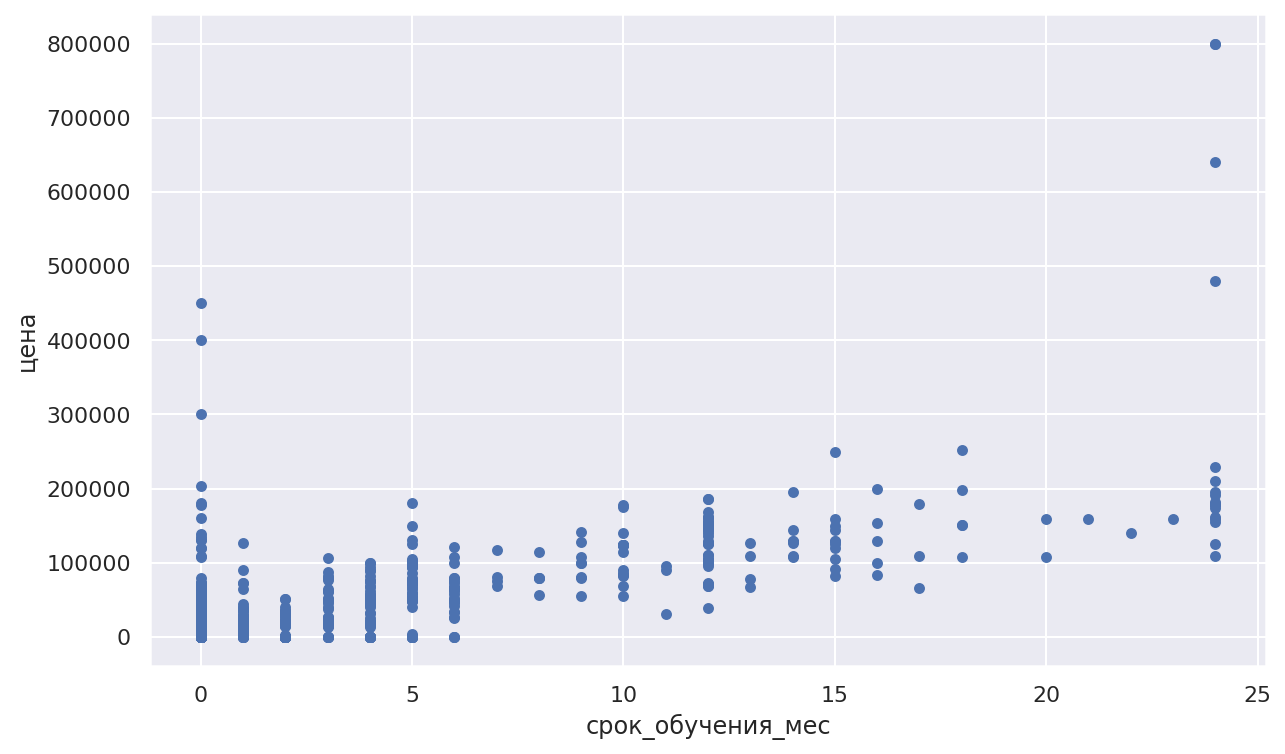

In [ ]:
dataset_obrazoval.plot('срок_обучения_мес', 'цена', kind = 'scatter')

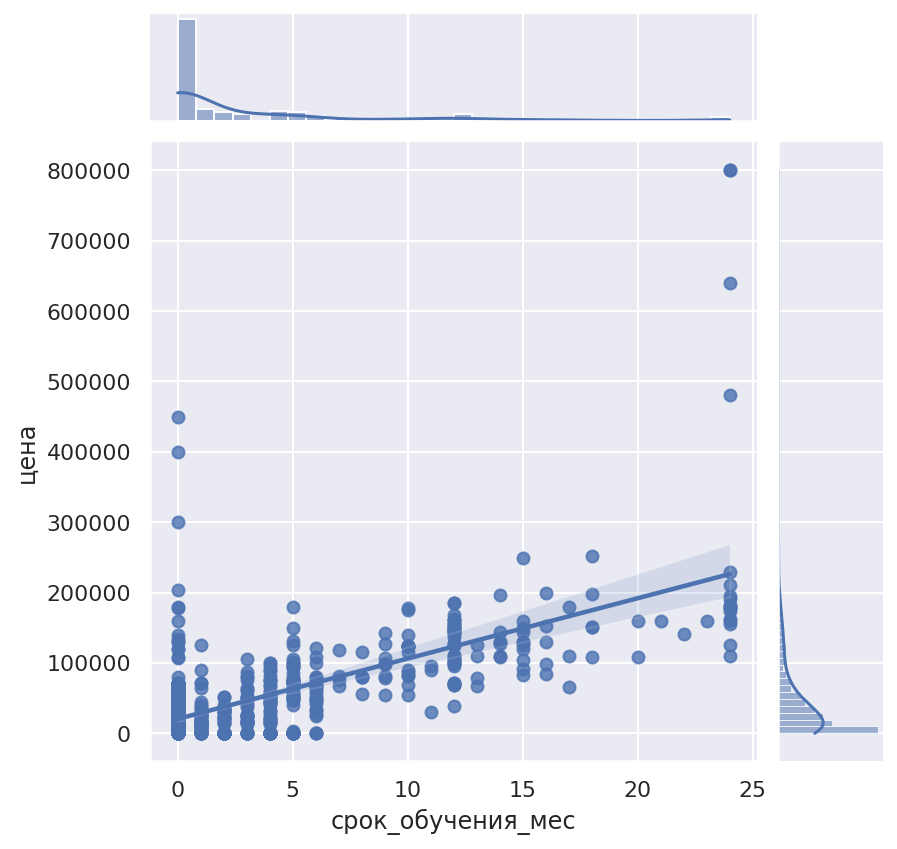

In [ ]:
sns.jointplot('срок_обучения_мес', 'цена', data=dataset_obrazoval, kind="reg")
plt.show()

уберём выбросы по цене, и нарисуем график с линией регрессии

In [ ]:
dataset_obrazoval = dataset_obrazoval[dataset_obrazoval['цена']<290000]

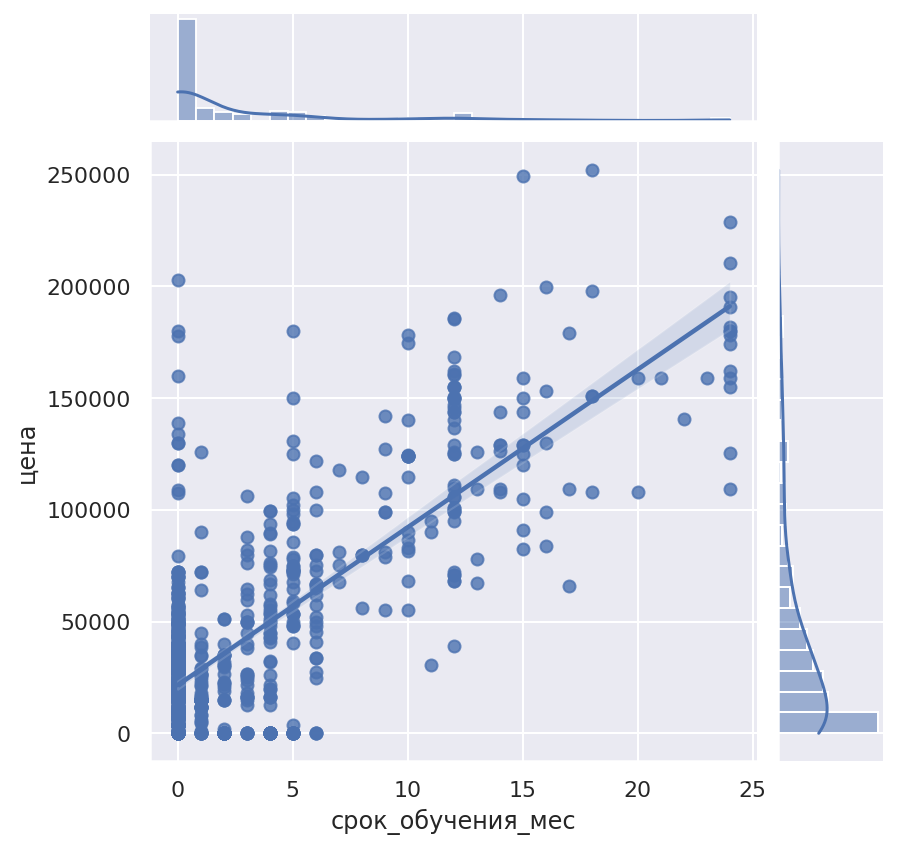

In [ ]:
sns.jointplot('срок_обучения_мес', 'цена', data=dataset_obrazoval, kind="reg")
plt.show()

так стало намного заметнее связь срока обучения и цены, посмотрим на корреляцию

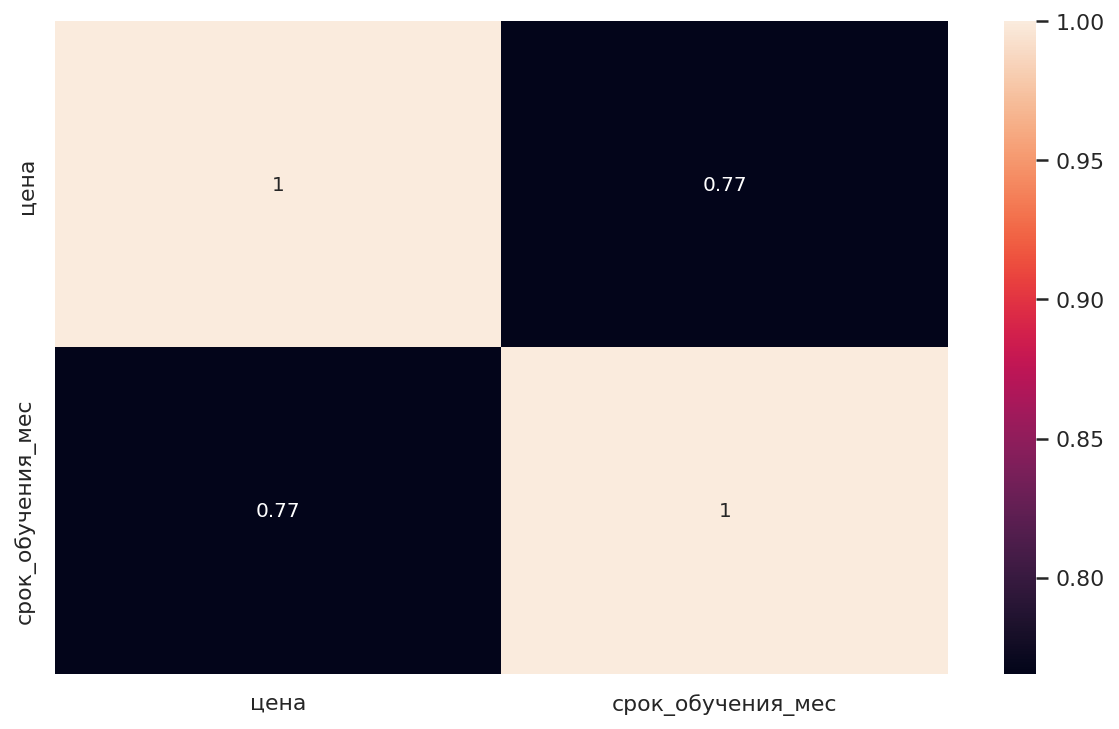

In [ ]:
num = ['цена', 'срок_обучения_мес']
sns.heatmap(dataset_obrazoval[num].corr(),annot=True)

стоимость курса зависит от срока обучения

In [ ]:
resul = smf.ols('цена ~ срок_обучения_мес', data=dataset_obrazoval).fit()
resul.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   цена   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     1339.
Date:                Fri, 27 Jan 2023   Prob (F-statistic):          1.88e-183
Time:                        08:49:10   Log-Likelihood:                -11116.
No. Observations:                 949   AIC:                         2.224e+04
Df Residuals:                     947   BIC:                         2.225e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          2.154e+04   1099.482     19.591      0.000    1.94e+04    2.37e+04
срок_обучения_мес  7064.8698    193.042     36.598      0.000    6686.030    7443.709
==============================================================================
Omnibus:                      277.121   Durbin-Watson:                   1.519
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1139.297
Skew:                           1.322   Prob(JB):                    4.03e-248
Kurtosis:                       7.671   Cond. No.                         6.56
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

срок обучения статистически значим для цены за курс, поэтому нулевую гипотезу, о не значимости связи, отклоняем.

In [ ]:
LR = lm.LinearRegression()
mod1 = LR.fit(dataset_obrazoval[['срок_обучения_мес']],dataset_obrazoval[['цена']])
print(mod1.intercept_, mod1.coef_)
# спрогнозируем цену на курс длительностью 12 месяцев
x=[[2],[4], [6], [12],[18], [24]]
print("Прогноз цены: ", mod1.predict(x).round(1))

[21539.6867605] [[7064.86981496]]
Прогноз цены:  [[ 35669.4]
 [ 49799.2]
 [ 63928.9]
 [106318.1]
 [148707.3]
 [191096.6]]


мы попробовали подставить срок обучения в 4,  6, 12, 24 месяцев в нашу предсказанную цену и получили такие результаты: срок в месяцах

обучение в месяцах |прогноз в месяц|стоимость курса|
---------------| -------       --- |--- -----------|
**2**          |      **17 85**    |     **35 669**|
**4**          |    **12 450**     |    **49 799** |
**6**          |    **10 655**     |    **63 929** |
**12**         |    **8 860**      |   **106 318** |
  **18**       |  **8 261**        |    **148 707**|
**24**         |    **7 962**      |   **191 096** |